In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import random
import csv
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
sub_features = ['42 tGravityAcc-mean()-Y',
 '43 tGravityAcc-mean()-Z',
 '51 tGravityAcc-max()-Y',
 '52 tGravityAcc-max()-Z',
 '54 tGravityAcc-min()-Y',
 '55 tGravityAcc-min()-Z',
 '56 tGravityAcc-sma()',
 '59 tGravityAcc-energy()-Z',
 '125 tBodyGyro-std()-Y',
 '128 tBodyGyro-mad()-Y',
 '138 tBodyGyro-energy()-Y',
 '165 tBodyGyroJerk-std()-Y',
 '168 tBodyGyroJerk-mad()-Y',
 '178 tBodyGyroJerk-energy()-Y',
 '181 tBodyGyroJerk-iqr()-Y',
 '425 fBodyGyro-mean()-Y',
 '428 fBodyGyro-std()-Y',
 '431 fBodyGyro-mad()-Y',
 '441 fBodyGyro-energy()-Y',
 '475 fBodyGyro-bandsEnergy()-1,8',
 '478 fBodyGyro-bandsEnergy()-25,32',
 '483 fBodyGyro-bandsEnergy()-1,16',
 '487 fBodyGyro-bandsEnergy()-1,24',
 '559 angle(X,gravityMean)',
 '560 angle(Y,gravityMean)',
 '561 angle(Z,gravityMean)']

act_features = ['4 tBodyAcc-std()-X',
 '7 tBodyAcc-mad()-X',
 '10 tBodyAcc-max()-X',
 '17 tBodyAcc-energy()-X',
 '202 tBodyAccMag-std()',
 '204 tBodyAccMag-max()',
 '215 tGravityAccMag-std()',
 '217 tGravityAccMag-max()',
 '266 fBodyAcc-mean()-X',
 '269 fBodyAcc-std()-X',
 '272 fBodyAcc-mad()-X',
 '275 fBodyAcc-max()-X',
 '282 fBodyAcc-energy()-X',
 '303 fBodyAcc-bandsEnergy()-1,8',
 '311 fBodyAcc-bandsEnergy()-1,16',
 '315 fBodyAcc-bandsEnergy()-1,24',
 '504 fBodyAccMag-std()',
 '505 fBodyAccMag-mad()',
 '506 fBodyAccMag-max()',
 '509 fBodyAccMag-energy()']

input_shape = len(sub_features) + len(act_features)

### Move Working Directory

In [3]:
# MaryClare's
#os.chdir('/Users/maryclaremartin/Documents/jup/ExtraSensory')

# Josh's
#os.chdir("D:/Research_Projects/REU2021-human-context-recognition/UCI_data")

# Harrison's
os.chdir("/Users/hkimr/Desktop/WPI Github/REU2021-human-context-recognition/UCI_data")

#os.chdir('../')
softmax = nn.Softmax(dim = 1)

### Load & Scale Data

In [4]:
##load and scale data
#returns scaled data (X) and labels (Y)
#label: array, list of activities to use (represented by integers)
#users: array, list of users whose data is to be used (represented by integers)

def start_data(label, users, sub_features, act_features):
    #get the dataframe column names
    name_dataframe = pd.read_csv('data/features.txt', delimiter = '\n', header = None)
    names = name_dataframe.values.tolist()
    names = [k for row in names for k in row] #List of column names

    data = pd.read_csv('data/X_train.txt', delim_whitespace = True, header = None) #Read in dataframe
    data.columns = names #Setting column names

    #X_train = data.loc[:,'1 tBodyAcc-mean()-X':'40 tBodyAcc-correlation()-Y,Z'] #Selecting only acceleration columns
    
    #X_train_1 = data.loc[:,'1 tBodyAcc-mean()-X':'40 tBodyAcc-correlation()-Y,Z']
    #X_train_2 = data.loc[:,'81 tBodyAccJerk-mean()-X':'160 tBodyGyro-correlation()-Y,Z']
    X_train_1 = data[sub_features]
    X_train_2 = data[act_features]
    X_train = pd.concat([X_train_1, X_train_2], axis = 1)
    
    y_train_activity = pd.read_csv('data/y_train.txt', header = None)
    y_train_activity.columns = ['Activity']

    y_train_subject = pd.read_csv('data/subject_train.txt', header = None)
    y_train_subject.columns = ['Subject']

    GAN_data = pd.concat([X_train, y_train_activity, y_train_subject], axis = 1)
    GAN_data = GAN_data[GAN_data['Activity'].isin(label)]
    GAN_data = GAN_data[GAN_data['Subject'].isin(users)]
    
#     GAN_data = GAN_data[(GAN_data['Activity'] == 1) & (GAN_data['Subject'] == 1)]
    GAN_data = GAN_data[~((GAN_data['Activity'] == 3) & (GAN_data['Subject'] == 5))] #CHANGE THIS
    
    X = GAN_data.iloc[:, :-2].values
    y = GAN_data[['Activity']].values
    
    return X, y

### The Generator

In [5]:
#defines each generator layer
#input and output dimensions needed
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )

#returns n_samples of z_dim (number of dimensions of latent space) noise
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim).to(device)

#defines generator class
class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = input_shape, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, 80),
            generator_block(80, 60),
            generator_block(60, 50),
            nn.Linear(50, feature_dim),
            nn.Tanh()
        )
    def forward(self, noise):
        return self.gen(noise)

##calculates generator loss
#gen: generator
#disc: discriminator
#criterion1: loss function1
#criterion2: loss function2
#batch_size: batch size
#z_dim: number of dimensions in the latent space
def get_gen_loss(gen, disc, act, usr, criterion1, criterion2, batch_size, z_dim, activities, users):
    latent_vectors = get_noise(batch_size, z_dim)
    
    u_idx, u_vectors, a_idx, a_vectors = get_usr_act_matrix(batch_size, activities, users)
    
    to_gen = torch.cat((latent_vectors, a_vectors, u_vectors), 1)
    fake_features = gen(to_gen)
    
    disc.eval()
    pred_disc = disc(fake_features)
    disc.train()
    pred_act = act(fake_features) ### CrossEntropyLoss Criterion automatically applies softmax and torch.max
    pred_usr = usr(fake_features)
    
    d_loss = criterion1(pred_disc, torch.ones_like(pred_disc))
    act_loss = criterion2(pred_act, a_idx)
    usr_loss = criterion2(pred_usr, u_idx)
    
    gen_loss = d_loss + act_loss + usr_loss
    
    return gen_loss

def get_usr_act_matrix(batch_size, a_dim, u_dim):
    # Creating user matrix and indices
    user_indexes = np.random.randint(u_dim, size = batch_size)
    
    user_matrix = np.zeros((user_indexes.size, user_indexes.max()+1))
    user_matrix[np.arange(user_indexes.size), user_indexes] = 1
    
    # Creating activity matrix and indices
    act_indexes = np.random.randint(a_dim, size = batch_size)
    
    act_matrix = np.zeros((act_indexes.size, act_indexes.max()+1))
    act_matrix[np.arange(act_indexes.size), act_indexes] = 1
        
#     for k in range(batch_size):
#         user_matrix[k,0] = 1
#         act_matrix[k,0] = 1
    
#     for k in range(batch_size):
#         if user_matrix[k, 0] == 1 and act_matrix[k, 0] == 1: # if the row is 1 0 0 1 0 0 
#             rand_idx = np.random.randint(1, 3) # index is either 1 or 2
#             act_matrix[k, rand_idx] = 1 #set the act matrix to have a 1 at that index
#             act_indexes[k] = rand_idx #Update the indices tensor
#             act_matrix[k, 0] = 0 #Set the original index as 0
    
    return torch.Tensor(user_indexes).long().to(device), torch.Tensor(user_matrix).to(device), torch.Tensor(act_indexes).long().to(device), torch.Tensor(act_matrix).to(device)

### Create Fake Generated Samples

In [6]:
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    gen.eval()
    fake_features = gen(latent_vectors)
    gen.train()
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

### The Discriminator

In [7]:
def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

#defines discriminator class
class Discriminator(nn.Module):
    def __init__(self, feature_dim = input_shape, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, 25),
            discriminator_block(25, 10),
            nn.Linear(10, 1),
            #nn.Linear(feature_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)
    
def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim, a_dim, u_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    
    u_idx, u_vectors, a_idx, a_vectors = get_usr_act_matrix(batch_size, a_dim, u_dim)    
    
    to_gen = torch.cat((latent_vectors, a_vectors, u_vectors), 1)
    gen.eval()
    fake_features = gen(to_gen)
    gen.train()
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

### User Classifier

In [8]:
def classifier_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class User_Classifier(nn.Module):
    def __init__(self, feature_dim = input_shape):
        super(User_Classifier, self).__init__()
        self.network = nn.Sequential(
            classifier_block(feature_dim, 25),
            classifier_block(25, 20),
            classifier_block(20, 20),
            classifier_block(20, 10),
            nn.Linear(10, 3)
        )
    def forward(self, x):
        return self.network(x)

### Activity Classifier

In [9]:
def classifier_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Activity_Classifier(nn.Module):
    def __init__(self, feature_dim = input_shape):
        super(Activity_Classifier, self).__init__()
        self.network = nn.Sequential(
            classifier_block(feature_dim, 25),
            classifier_block(25, 20),
            classifier_block(20, 15),
            classifier_block(15, 10),
            nn.Linear(10, 3)
        )
    def forward(self, x):
        return self.network(x)

### Calculate Performance Statistics

In [10]:
##calculates performance statistics for each epoch of training
#gen: generator
#disc: discriminator
#b_size: batch size
#z_dim: number of dimensions of the latent space
##returns accuracy, precision, recall, fpR, and f1 score
def performance_stats(gen, disc, b_size, z_dim, a_dim, u_dim, batch = None):
    tp = 0 #true positive
    fp = 0 #false positive
    tn = 0 #true negative
    fn = 0 #false negative

    with torch.no_grad():
        y_hat_fake = torch.Tensor([0])
        y_hat_real = torch.Tensor([0])
        
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)            
            act_vectors = get_act_matrix(b_size, a_dim)
            usr_vectors = get_usr_matrix(b_size, u_dim)
            to_gen = torch.cat((latent_vectors, act_vectors[1], usr_vectors[1]), 1)
            gen.eval()
            fake_features = gen(to_gen)
            gen.train()
            disc.eval()
            y_hat_fake = torch.round(disc(fake_features))
            disc.train()
        else:
            latent_vectors = get_noise(b_size, z_dim)
            u_idx, u_vectors, a_idx, a_vectors = get_usr_act_matrix(b_size, a_dim, u_dim)
            
            to_gen = torch.cat((latent_vectors, a_vectors, u_vectors), 1)
            gen.eval()
            fake_features = gen(to_gen)
            gen.train()
            disc.eval()
            
            ### CHANGING THRESHOLD
            y_hat_fake = disc(fake_features)
            y_hat_real = disc(batch)
            
            ones_fake = torch.ones_like(y_hat_fake)
            ones_real = torch.ones_like(y_hat_real)
            
            y_hat_fake = torch.where(y_hat_fake > 0.8, ones_fake, y_hat_fake)
            y_hat_real = torch.where(y_hat_real > 0.8, ones_real, y_hat_real)
        
            disc.train()
         
        fpR = torch.mean(y_hat_fake)
        recall = torch.mean(y_hat_real)
        class_acc = ((len(y_hat_fake) - torch.sum(y_hat_fake)) + torch.sum(y_hat_real)) / (2*b_size)
        #print(f'Classification Accuracy: {class_acc:.2f}'
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        return class_acc, recall, fpR
      

def performance_stats_class(gen, a_class, u_class, batch_size, z_dim, a_dim, u_dim):
    tp = 0 #true positive
    fp = 0 #false positive
    tn = 0 #true negative
    fn = 0 #false negative

    with torch.no_grad():
        latent_vectors = get_noise(batch_size, z_dim)
        
        u_idx, u_vectors, a_idx, a_vectors = get_usr_act_matrix(batch_size, a_dim, u_dim)
    
        to_gen = torch.cat((latent_vectors, a_vectors, u_vectors), 1)
        gen.eval()
        fake_features = gen(to_gen)
        gen.train()
    
        _, pred_a_class = torch.max(softmax(a_class(fake_features)), dim = 1)
        _, pred_u_class = torch.max(softmax(u_class(fake_features)), dim = 1)
        
        return torch.eq(a_idx, pred_a_class).sum()/batch_size, torch.eq(u_idx, pred_u_class).sum()/batch_size

### Initialize Training Environment

In [11]:
###initalize parameters that depend on training loop parameters
#X: acceleration data
#y: labels associated with X data (fake or real)
#z_dim: number of dimensions to the latent space
#disc_lr: discriminator learning rate
#gen_lr: generator learning rate
#DISCRIMINATOR: 1 to indicate if discriminator is training
#batch_size: batch size
#disc: initialized discrimiantor

def initialize_params(X, y, z_dim, a_dim, u_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc):
    #initialize generator
    gen = Generator(z_dim + a_dim + u_dim).to(device)
    #indicate that discriminator is training
    to_train = DISCRIMINATOR
    #create training features
    train_features = torch.tensor(X)
    #create training labels
    train_labels = torch.tensor(y)
    #concatenate to create training data
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    #create data loader for training data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    #initialize generator and discriminator optimizers
    opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
    opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)
    
    return gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen   

# Save / Load Models

In [12]:
# Change path and name of the Generator and Discriminator accordingly
def save_model(gen, disc, model_name):
    torch.save(gen.state_dict(), f"saved_models/{model_name}_gen.param")
    torch.save(disc.state_dict(), f"saved_models/{model_name}_disc.param")
    
def load_model(model, model_name):
    model.load_state_dict(torch.load(f'saved_models/{model_name}'))

# Training

In [13]:
######Training loop to train GAN

#Parameters to specifiy: 
    #X: starting accelerometer data
    #y: starting labels for X data (fake or real)
    
#Set parameters (do not change)
    #criterion: loss function (BCE)
    #dig: number of significant digits for printing (5)
    #feature_dim: Number of dimensions of output from generator (26)
    #GENERATOR: set generator to zero for training
    #DISCRIMINATOR: set discriminator to one for training
    #train_string: starting machine to train (DISC)
    #disc: initalize discriminator
    #rel_epochs: Epochs passed since last switch (constant training) (0)
    #rows: initialization of array to save data of each epoch to CSV file ([])
    #heading: array of column headings for table (["Epoch", "Machine Training", "Discriminator Loss", 
                    #"Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"])
    #table: intialize a table as a pretty table to save epoch data
    #switch_count: number of switches in dynamic training (0)
    
#Set parameters (can change):
    #z_dim: number of dimensions of latent vector (100)
    #gen_lr: generator learning rate (.001)
    #disc_lr: discriminator learning rate (.001) (shoud be equal to gen_lr)
    #batch_size: batch size (75)
    #print_batches: Show model performance per batch (False)
    #n_epochs: number of epochs to train (100)
    #constant_train_flag: (False)
        #Set to true to train based on constant # of epochs per machine 
        #Set to false to train dynamically based on machine performance
        
    #Constant training approach:
        #disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (5)
        #gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #epoch_threshold: Epoch number to change training epoch ratio (50)
        #disc_epochs_change: New number of consecutive epochs to train discriminator after epoch threshold is exceeded (1)
        #gen_epochs_change: New number of consecutive epochs to train generator after epoch threshold is exceeded (50)
    
    #Dynamic training approach:                        
        #static_threshold: Epoch number to change from static ratio to dynamic (18)
        #static_disc_epochs: Number of consecutive epochs to train discriminator before epoch threshold (4)
        #static_gen_epochs: Number of consecutive epochs to train generator before epoch threshold (2)
        #pull_threshold: Accuracy threshold for switching machine training when the generator is no longer competitive (0.4)
        #push_threshold: Accuracy threshold for switching machine training when the discriminator is no longer competitive (0.6)
        #recall_threshold: threshold for recall to switch machine training when discriminator is training well
        #switch_flag: indicates if we should switch our training machine (False)
        
def training_loop(X, y, act, usr, criterion1 = nn.BCELoss(), criterion2 = nn.CrossEntropyLoss(), gan_id = "Mod Test Gan", dig = 5, feature_dim = input_shape, 
                  GENERATOR = 0, DISCRIMINATOR = 1, train_string = "DISC", disc = Discriminator(), z_dim = 100, a_dim = 3, u_dim = 3, 
                  gen_lr =  0.001, disc_lr = 0.001, batch_size = 100, constant_train_flag = False, disc_epochs = 5,
                  gen_epochs = 2, epoch_threshold = 50, disc_epochs_change = 5, gen_epochs_change = 2, rel_epochs = 0,
                 static_threshold = 28, static_disc_epochs = 5, static_gen_epochs = 2, pull_threshold = 0.3,
                 push_threshold = 0.7, recall_threshold = 0.75, n_epochs = 1000, rows = [],
                 heading = ["Epoch", "Training", "Discriminator Loss", "Generator Loss", "D_Accuracy", "D_fpR", "D_Recall", "A_fpR", "U_fpR"],
                 table = PrettyTable(), switch_flag = False, switch_count = 0, last_real_features = []):
    
    disc.to(device)
    #returns generator, sets discriminator training, creates training tensor, loads data, and initializes optimizers
    gen, to_train, train_features, train_labels, train_data, train_loader, opt_disc, opt_gen = initialize_params(X, y, z_dim, a_dim, u_dim, disc_lr, gen_lr, DISCRIMINATOR, batch_size, disc)

    #set pretty table field names
    table.field_names = heading
    
    #visualize_gen(X, gen, z_dim, a_dim, u_dim)
    gen_epochs = 0
    
    last_D_loss = -1.0
    last_G_loss = -1.0
    
    mean_mean = []
    mean_median = []
    
    for epoch in range(n_epochs):  
        if constant_train_flag:
            if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"

            # Change epoch ratio after intial 'leveling out'
            if epoch == epoch_threshold:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

                old_ratio = gen_epochs / disc_epochs
                gen_epochs = gen_epochs_change
                disc_epochs = disc_epochs_change
                new_ratio = gen_epochs / disc_epochs
                print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
        else:
            if epoch < static_threshold:
                if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                    rel_epochs = 0
                    to_train = GENERATOR
                    train_string = "GEN"

                elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                    rel_epochs = 0
                    to_train = DISCRIMINATOR
                    train_string = "DISC"

            else:
                if not switch_flag:
                    print("\nSwitching to Dynamic Training\n")
                    switch_flag = True
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                    to_train = GENERATOR
                    train_string = "GEN"
                    print("\nPull Generator\n")
                    switch_count += 1
                if to_train == GENERATOR and fpR >= push_threshold:
                    to_train = DISCRIMINATOR
                    train_string = "DISC"
                    print("\nPush Generator\n")
                    switch_count += 1
                    
        print(f'Epoch[{epoch + 1}/{n_epochs}] Train: {train_string} ', end ='')
        
        for batch_idx, (real_features, _) in enumerate(train_loader):
            #Size of this current batch
            batch_size = len(real_features)
            #Send batch to GPU
            real_features = real_features.float().to(device)
            
            if to_train == DISCRIMINATOR:
                ### Training Discriminator
                #visualize_real_batch(real_features.float())
                opt_disc.zero_grad()
                disc_loss = get_disc_loss(gen, disc, criterion1, real_features, batch_size, z_dim, a_dim, u_dim)
                disc_loss.backward(retain_graph = True)
                opt_disc.step()
                last_D_loss = disc_loss.item()
                # If generator has yet to ever train, run intial evaluation
                if last_G_loss == -1.0:
                    last_G_loss = get_gen_loss(gen, disc, act, usr, criterion1, criterion2, batch_size, z_dim, a_dim, u_dim)
                
            else:
                ### Training Generator
                opt_gen.zero_grad()
                gen_loss = get_gen_loss(gen, disc, act, usr, criterion1, criterion2, batch_size, z_dim, a_dim, u_dim)
                gen_loss.backward()
                opt_gen.step()
                last_G_loss = gen_loss.item()
                # If discriminator has yet to ever train, run intial evaluation
                if last_D_loss == -1.0:
                    last_D_loss = get_disc_loss(gen, disc, criterion1, real_features, batch_size, z_dim, a_dim, u_dim)
                
            if batch_idx == (len(train_loader) - 1):
                acc, R, fpR = performance_stats(gen, disc, batch_size, z_dim, a_dim, u_dim, batch = real_features)
                A_fpR, U_fpR = performance_stats_class(gen, act, usr, batch_size, z_dim, a_dim, u_dim)
                #w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
                #median_w_dist = torch.median(w_dist)
                #mean_w_dist = torch.mean(w_dist)
                
                #mean_mean.append(mean_w_dist)
                #mean_median.append(median_w_dist)
                
        mean_mean_w = torch.mean(torch.Tensor(mean_mean)) 
        mean_median_w = torch.mean(torch.Tensor(mean_median))
            
        ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
        print(f'| LossD: {last_D_loss:.{dig}f}, LossG: {last_G_loss:.{dig}f} | Acc: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | R: {R:.{dig}f} | A_fpR: {A_fpR:.{dig}f} | U_fpR: {U_fpR:.{dig}f}')
        row_to_add = [f"{epoch + 1}", train_string, f"{last_D_loss:.{dig}f}", f"{last_G_loss:.{dig}f}", f"{acc:.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{A_fpR:.{dig}f}", f"{U_fpR:.{dig}f}"]
        table.add_row(row_to_add)
        rows.append(row_to_add)
                
        if to_train == GENERATOR:
            gen_epochs += 1
            
        mean_mean.clear()
        mean_median.clear()
        rel_epochs += 1
        
        
    print("\n\nTraining Session Finished")
    print(f"Encountered {switch_count} non-trivial training swaps")
    percent = gen_epochs / n_epochs
    print(f"Trained Generator {gen_epochs} out of {n_epochs} ({percent:.3f})")
    f = open("model_outputs/" + gan_id + ".txt", "w")
    f.write(table.get_string())
    f.close()
    print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".txt\"")

    with open("model_outputs/" + gan_id + ".csv", "w") as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        # writing the fields 
        csvwriter.writerow(heading)
        # writing the data rows 
        csvwriter.writerows(rows)
    print("Model Results Sucessfully Saved to \"model_outputs/" + gan_id + ".csv\"")
    save_model(gen, disc, gan_id)
    print("Generator's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_gen.param\"")
    print("Discriminators's Trained Parameters Sucessfully Saved to \"saved_models/" + gan_id + "_disc.param\"")
    model_output = pd.read_csv("model_outputs/" + gan_id + ".csv")
    #visualize_gen(X, gen, z_dim)
    # Change path and name of the Generator and Discriminator accordingly
    save_model(gen, disc, gan_id)
    
    return model_output

# Run Training

In [14]:
#X, y = start_data("aggregated_data/aggregated_data.csv", "label:SITTING")
#X, y = start_data("raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv", "label:SITTING" ) 
X, y = start_data([1, 3, 4], [1, 3, 5], sub_features, act_features)

#Initialize Classifier Architectures
activity_classifier = Activity_Classifier()
user_classifier = User_Classifier()

#Freeze Them
activity_classifier.eval()
user_classifier.eval()
#Send to GPU
activity_classifier.to(device)
user_classifier.to(device)

#Load with pre-trained parameters
activity_classifier.load_state_dict(torch.load('saved_models/UCI 3 Label Classifier'))
user_classifier.load_state_dict(torch.load("saved_models/UCI 3 User Classifier"))

#Train
model_output = training_loop(X,y, activity_classifier, user_classifier, gan_id="U2A1", batch_size = len(X), gen_lr=.0001, disc_lr =.0001, n_epochs=30000, dig=5, constant_train_flag=False, recall_threshold = 0.85)

Epoch[1/30000] Train: DISC | LossD: 0.67467, LossG: 171.64311 | Acc: 0.51003 | fpR: 0.49576 | R: 0.51582 | A_fpR: 0.35111 | U_fpR: 0.32889
Epoch[2/30000] Train: DISC | LossD: 0.67514, LossG: 171.64311 | Acc: 0.51024 | fpR: 0.49570 | R: 0.51618 | A_fpR: 0.33778 | U_fpR: 0.32889
Epoch[3/30000] Train: DISC | LossD: 0.67502, LossG: 171.64311 | Acc: 0.51045 | fpR: 0.49563 | R: 0.51653 | A_fpR: 0.36000 | U_fpR: 0.30000
Epoch[4/30000] Train: DISC | LossD: 0.67392, LossG: 171.64311 | Acc: 0.51068 | fpR: 0.49552 | R: 0.51688 | A_fpR: 0.36444 | U_fpR: 0.32222
Epoch[5/30000] Train: DISC | LossD: 0.67459, LossG: 171.64311 | Acc: 0.51090 | fpR: 0.49543 | R: 0.51723 | A_fpR: 0.33111 | U_fpR: 0.32889
Epoch[6/30000] Train: GEN | LossD: 0.67459, LossG: 162.61310 | Acc: 0.51102 | fpR: 0.49520 | R: 0.51723 | A_fpR: 0.32444 | U_fpR: 0.36000
Epoch[7/30000] Train: GEN | LossD: 0.67459, LossG: 145.40025 | Acc: 0.51105 | fpR: 0.49514 | R: 0.51723 | A_fpR: 0.32889 | U_fpR: 0.30889
Epoch[8/30000] Train: DISC | 

Epoch[74/30000] Train: DISC | LossD: 0.64917, LossG: 146.14758 | Acc: 0.52375 | fpR: 0.48799 | R: 0.53549 | A_fpR: 0.31333 | U_fpR: 0.34000
Epoch[75/30000] Train: DISC | LossD: 0.64922, LossG: 146.14758 | Acc: 0.52398 | fpR: 0.48782 | R: 0.53579 | A_fpR: 0.32667 | U_fpR: 0.34000
Epoch[76/30000] Train: DISC | LossD: 0.64954, LossG: 146.14758 | Acc: 0.52424 | fpR: 0.48761 | R: 0.53609 | A_fpR: 0.29778 | U_fpR: 0.32889
Epoch[77/30000] Train: DISC | LossD: 0.64765, LossG: 146.14758 | Acc: 0.52443 | fpR: 0.48754 | R: 0.53640 | A_fpR: 0.35778 | U_fpR: 0.34222
Epoch[78/30000] Train: DISC | LossD: 0.64742, LossG: 146.14758 | Acc: 0.52466 | fpR: 0.48738 | R: 0.53670 | A_fpR: 0.32000 | U_fpR: 0.34222
Epoch[79/30000] Train: DISC | LossD: 0.64852, LossG: 146.14758 | Acc: 0.52486 | fpR: 0.48729 | R: 0.53700 | A_fpR: 0.33778 | U_fpR: 0.31556
Epoch[80/30000] Train: DISC | LossD: 0.64702, LossG: 146.14758 | Acc: 0.52509 | fpR: 0.48712 | R: 0.53730 | A_fpR: 0.35556 | U_fpR: 0.34000
Epoch[81/30000] Trai

Epoch[134/30000] Train: DISC | LossD: 0.62300, LossG: 146.14758 | Acc: 0.53897 | fpR: 0.47894 | R: 0.55687 | A_fpR: 0.33778 | U_fpR: 0.36000
Epoch[135/30000] Train: DISC | LossD: 0.62190, LossG: 146.14758 | Acc: 0.53919 | fpR: 0.47890 | R: 0.55728 | A_fpR: 0.31111 | U_fpR: 0.34889
Epoch[136/30000] Train: DISC | LossD: 0.62080, LossG: 146.14758 | Acc: 0.53947 | fpR: 0.47875 | R: 0.55770 | A_fpR: 0.36000 | U_fpR: 0.32444
Epoch[137/30000] Train: DISC | LossD: 0.62151, LossG: 146.14758 | Acc: 0.53983 | fpR: 0.47844 | R: 0.55811 | A_fpR: 0.33778 | U_fpR: 0.33333
Epoch[138/30000] Train: DISC | LossD: 0.61977, LossG: 146.14758 | Acc: 0.54006 | fpR: 0.47840 | R: 0.55853 | A_fpR: 0.36222 | U_fpR: 0.30889
Epoch[139/30000] Train: DISC | LossD: 0.62041, LossG: 146.14758 | Acc: 0.54036 | fpR: 0.47824 | R: 0.55895 | A_fpR: 0.37778 | U_fpR: 0.34889
Epoch[140/30000] Train: DISC | LossD: 0.61884, LossG: 146.14758 | Acc: 0.54055 | fpR: 0.47828 | R: 0.55937 | A_fpR: 0.34444 | U_fpR: 0.31111
Epoch[141/300

Epoch[205/30000] Train: DISC | LossD: 0.58185, LossG: 146.14758 | Acc: 0.56207 | fpR: 0.46621 | R: 0.59036 | A_fpR: 0.35778 | U_fpR: 0.34667
Epoch[206/30000] Train: DISC | LossD: 0.58070, LossG: 146.14758 | Acc: 0.56246 | fpR: 0.46598 | R: 0.59090 | A_fpR: 0.32889 | U_fpR: 0.35556
Epoch[207/30000] Train: DISC | LossD: 0.58151, LossG: 146.14758 | Acc: 0.56287 | fpR: 0.46570 | R: 0.59144 | A_fpR: 0.32889 | U_fpR: 0.34222
Epoch[208/30000] Train: DISC | LossD: 0.57823, LossG: 146.14758 | Acc: 0.56340 | fpR: 0.46518 | R: 0.59199 | A_fpR: 0.34222 | U_fpR: 0.32444
Epoch[209/30000] Train: DISC | LossD: 0.57855, LossG: 146.14758 | Acc: 0.56372 | fpR: 0.46510 | R: 0.59254 | A_fpR: 0.35778 | U_fpR: 0.34222
Epoch[210/30000] Train: DISC | LossD: 0.57749, LossG: 146.14758 | Acc: 0.56404 | fpR: 0.46501 | R: 0.59309 | A_fpR: 0.34000 | U_fpR: 0.35556
Epoch[211/30000] Train: DISC | LossD: 0.57706, LossG: 146.14758 | Acc: 0.56447 | fpR: 0.46471 | R: 0.59365 | A_fpR: 0.32000 | U_fpR: 0.33333
Epoch[212/300

Epoch[276/30000] Train: DISC | LossD: 0.53039, LossG: 146.14758 | Acc: 0.59196 | fpR: 0.44796 | R: 0.63188 | A_fpR: 0.32222 | U_fpR: 0.32444
Epoch[277/30000] Train: DISC | LossD: 0.53081, LossG: 146.14758 | Acc: 0.59220 | fpR: 0.44811 | R: 0.63250 | A_fpR: 0.33111 | U_fpR: 0.34000
Epoch[278/30000] Train: DISC | LossD: 0.52881, LossG: 146.14758 | Acc: 0.59295 | fpR: 0.44723 | R: 0.63312 | A_fpR: 0.33778 | U_fpR: 0.33333
Epoch[279/30000] Train: DISC | LossD: 0.53164, LossG: 146.14758 | Acc: 0.59332 | fpR: 0.44711 | R: 0.63374 | A_fpR: 0.35556 | U_fpR: 0.28889
Epoch[280/30000] Train: DISC | LossD: 0.52784, LossG: 146.14758 | Acc: 0.59363 | fpR: 0.44711 | R: 0.63436 | A_fpR: 0.35333 | U_fpR: 0.30889
Epoch[281/30000] Train: DISC | LossD: 0.52693, LossG: 146.14758 | Acc: 0.59420 | fpR: 0.44658 | R: 0.63498 | A_fpR: 0.31111 | U_fpR: 0.33333
Epoch[282/30000] Train: DISC | LossD: 0.52544, LossG: 146.14758 | Acc: 0.59455 | fpR: 0.44649 | R: 0.63560 | A_fpR: 0.34444 | U_fpR: 0.33778
Epoch[283/300

Epoch[344/30000] Train: DISC | LossD: 0.47731, LossG: 146.14758 | Acc: 0.62516 | fpR: 0.42517 | R: 0.67549 | A_fpR: 0.34222 | U_fpR: 0.32000
Epoch[345/30000] Train: DISC | LossD: 0.47742, LossG: 146.14758 | Acc: 0.62570 | fpR: 0.42474 | R: 0.67615 | A_fpR: 0.29111 | U_fpR: 0.32444
Epoch[346/30000] Train: DISC | LossD: 0.47467, LossG: 146.14758 | Acc: 0.62601 | fpR: 0.42479 | R: 0.67681 | A_fpR: 0.31333 | U_fpR: 0.33778
Epoch[347/30000] Train: DISC | LossD: 0.47517, LossG: 146.14758 | Acc: 0.62681 | fpR: 0.42385 | R: 0.67747 | A_fpR: 0.33556 | U_fpR: 0.31778
Epoch[348/30000] Train: DISC | LossD: 0.47410, LossG: 146.14758 | Acc: 0.62740 | fpR: 0.42333 | R: 0.67813 | A_fpR: 0.32889 | U_fpR: 0.30889
Epoch[349/30000] Train: DISC | LossD: 0.47679, LossG: 146.14758 | Acc: 0.62786 | fpR: 0.42307 | R: 0.67878 | A_fpR: 0.34222 | U_fpR: 0.32000
Epoch[350/30000] Train: DISC | LossD: 0.47146, LossG: 146.14758 | Acc: 0.62827 | fpR: 0.42290 | R: 0.67944 | A_fpR: 0.31333 | U_fpR: 0.38889
Epoch[351/300

Epoch[411/30000] Train: DISC | LossD: 0.42249, LossG: 146.14758 | Acc: 0.68057 | fpR: 0.39033 | R: 0.75147 | A_fpR: 0.35778 | U_fpR: 0.35556
Epoch[412/30000] Train: DISC | LossD: 0.41954, LossG: 146.14758 | Acc: 0.68212 | fpR: 0.38952 | R: 0.75377 | A_fpR: 0.28889 | U_fpR: 0.32667
Epoch[413/30000] Train: DISC | LossD: 0.41693, LossG: 146.14758 | Acc: 0.68459 | fpR: 0.38866 | R: 0.75783 | A_fpR: 0.34444 | U_fpR: 0.31778
Epoch[414/30000] Train: DISC | LossD: 0.41694, LossG: 146.14758 | Acc: 0.68651 | fpR: 0.38798 | R: 0.76100 | A_fpR: 0.30667 | U_fpR: 0.31111
Epoch[415/30000] Train: DISC | LossD: 0.41554, LossG: 146.14758 | Acc: 0.68918 | fpR: 0.38757 | R: 0.76592 | A_fpR: 0.31778 | U_fpR: 0.30667
Epoch[416/30000] Train: DISC | LossD: 0.41359, LossG: 146.14758 | Acc: 0.69029 | fpR: 0.38713 | R: 0.76772 | A_fpR: 0.31778 | U_fpR: 0.32444
Epoch[417/30000] Train: DISC | LossD: 0.41269, LossG: 146.14758 | Acc: 0.69139 | fpR: 0.38629 | R: 0.76908 | A_fpR: 0.35778 | U_fpR: 0.31556
Epoch[418/300

Epoch[481/30000] Train: DISC | LossD: 0.35824, LossG: 146.14758 | Acc: 0.73186 | fpR: 0.34957 | R: 0.81330 | A_fpR: 0.32889 | U_fpR: 0.37333
Epoch[482/30000] Train: DISC | LossD: 0.35622, LossG: 146.14758 | Acc: 0.73334 | fpR: 0.34745 | R: 0.81413 | A_fpR: 0.33111 | U_fpR: 0.37111
Epoch[483/30000] Train: DISC | LossD: 0.35621, LossG: 146.14758 | Acc: 0.73317 | fpR: 0.34817 | R: 0.81451 | A_fpR: 0.34889 | U_fpR: 0.33556
Epoch[484/30000] Train: DISC | LossD: 0.35738, LossG: 146.14758 | Acc: 0.73399 | fpR: 0.34735 | R: 0.81534 | A_fpR: 0.32444 | U_fpR: 0.34889
Epoch[485/30000] Train: DISC | LossD: 0.35796, LossG: 146.14758 | Acc: 0.73422 | fpR: 0.34728 | R: 0.81572 | A_fpR: 0.33778 | U_fpR: 0.32444
Epoch[486/30000] Train: DISC | LossD: 0.35406, LossG: 146.14758 | Acc: 0.73535 | fpR: 0.34583 | R: 0.81654 | A_fpR: 0.31556 | U_fpR: 0.29333
Epoch[487/30000] Train: DISC | LossD: 0.35255, LossG: 146.14758 | Acc: 0.73523 | fpR: 0.34646 | R: 0.81692 | A_fpR: 0.33333 | U_fpR: 0.36667
Epoch[488/300

Epoch[552/30000] Train: DISC | LossD: 0.30032, LossG: 146.14758 | Acc: 0.78411 | fpR: 0.30574 | R: 0.87395 | A_fpR: 0.28000 | U_fpR: 0.32667
Epoch[553/30000] Train: DISC | LossD: 0.30106, LossG: 146.14758 | Acc: 0.78432 | fpR: 0.30601 | R: 0.87464 | A_fpR: 0.36667 | U_fpR: 0.33333
Epoch[554/30000] Train: DISC | LossD: 0.29944, LossG: 146.14758 | Acc: 0.78523 | fpR: 0.30442 | R: 0.87488 | A_fpR: 0.31556 | U_fpR: 0.34889
Epoch[555/30000] Train: DISC | LossD: 0.29829, LossG: 146.14758 | Acc: 0.78523 | fpR: 0.30512 | R: 0.87557 | A_fpR: 0.30889 | U_fpR: 0.29333
Epoch[556/30000] Train: DISC | LossD: 0.30111, LossG: 146.14758 | Acc: 0.78604 | fpR: 0.30462 | R: 0.87670 | A_fpR: 0.30444 | U_fpR: 0.32667
Epoch[557/30000] Train: DISC | LossD: 0.29690, LossG: 146.14758 | Acc: 0.78708 | fpR: 0.30323 | R: 0.87739 | A_fpR: 0.36222 | U_fpR: 0.31333
Epoch[558/30000] Train: DISC | LossD: 0.29895, LossG: 146.14758 | Acc: 0.78742 | fpR: 0.30278 | R: 0.87763 | A_fpR: 0.32000 | U_fpR: 0.31778
Epoch[559/300

Epoch[614/30000] Train: GEN | LossD: 0.29508, LossG: 76.22874 | Acc: 0.80512 | fpR: 0.27058 | R: 0.88082 | A_fpR: 0.36444 | U_fpR: 0.34222
Epoch[615/30000] Train: GEN | LossD: 0.29508, LossG: 83.10010 | Acc: 0.80489 | fpR: 0.27104 | R: 0.88082 | A_fpR: 0.35778 | U_fpR: 0.32667
Epoch[616/30000] Train: GEN | LossD: 0.29508, LossG: 75.59959 | Acc: 0.80693 | fpR: 0.26696 | R: 0.88082 | A_fpR: 0.37778 | U_fpR: 0.34667
Epoch[617/30000] Train: GEN | LossD: 0.29508, LossG: 70.19781 | Acc: 0.80664 | fpR: 0.26754 | R: 0.88082 | A_fpR: 0.33333 | U_fpR: 0.33333
Epoch[618/30000] Train: GEN | LossD: 0.29508, LossG: 75.73152 | Acc: 0.80546 | fpR: 0.26990 | R: 0.88082 | A_fpR: 0.34222 | U_fpR: 0.36222
Epoch[619/30000] Train: GEN | LossD: 0.29508, LossG: 75.20477 | Acc: 0.80558 | fpR: 0.26967 | R: 0.88082 | A_fpR: 0.35778 | U_fpR: 0.35778
Epoch[620/30000] Train: GEN | LossD: 0.29508, LossG: 78.75038 | Acc: 0.80578 | fpR: 0.26926 | R: 0.88082 | A_fpR: 0.34889 | U_fpR: 0.33333
Epoch[621/30000] Train: GEN

Epoch[683/30000] Train: GEN | LossD: 0.29508, LossG: 50.90002 | Acc: 0.80183 | fpR: 0.27717 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.36889
Epoch[684/30000] Train: GEN | LossD: 0.29508, LossG: 51.63251 | Acc: 0.80115 | fpR: 0.27852 | R: 0.88082 | A_fpR: 0.36667 | U_fpR: 0.38889
Epoch[685/30000] Train: GEN | LossD: 0.29508, LossG: 47.17614 | Acc: 0.80161 | fpR: 0.27761 | R: 0.88082 | A_fpR: 0.39111 | U_fpR: 0.36667
Epoch[686/30000] Train: GEN | LossD: 0.29508, LossG: 52.40052 | Acc: 0.80112 | fpR: 0.27859 | R: 0.88082 | A_fpR: 0.35111 | U_fpR: 0.36889
Epoch[687/30000] Train: GEN | LossD: 0.29508, LossG: 52.04530 | Acc: 0.79873 | fpR: 0.28337 | R: 0.88082 | A_fpR: 0.35111 | U_fpR: 0.35778
Epoch[688/30000] Train: GEN | LossD: 0.29508, LossG: 48.88469 | Acc: 0.80098 | fpR: 0.27886 | R: 0.88082 | A_fpR: 0.37778 | U_fpR: 0.39333
Epoch[689/30000] Train: GEN | LossD: 0.29508, LossG: 49.78161 | Acc: 0.79873 | fpR: 0.28336 | R: 0.88082 | A_fpR: 0.37111 | U_fpR: 0.36889
Epoch[690/30000] Train: GEN

Epoch[742/30000] Train: GEN | LossD: 0.29508, LossG: 39.06057 | Acc: 0.79700 | fpR: 0.28683 | R: 0.88082 | A_fpR: 0.40222 | U_fpR: 0.36667
Epoch[743/30000] Train: GEN | LossD: 0.29508, LossG: 42.00545 | Acc: 0.79902 | fpR: 0.28278 | R: 0.88082 | A_fpR: 0.35333 | U_fpR: 0.38444
Epoch[744/30000] Train: GEN | LossD: 0.29508, LossG: 39.32381 | Acc: 0.79923 | fpR: 0.28236 | R: 0.88082 | A_fpR: 0.36222 | U_fpR: 0.38000
Epoch[745/30000] Train: GEN | LossD: 0.29508, LossG: 40.97110 | Acc: 0.79684 | fpR: 0.28714 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.36222
Epoch[746/30000] Train: GEN | LossD: 0.29508, LossG: 37.15192 | Acc: 0.79797 | fpR: 0.28488 | R: 0.88082 | A_fpR: 0.36000 | U_fpR: 0.38000
Epoch[747/30000] Train: GEN | LossD: 0.29508, LossG: 39.75896 | Acc: 0.79772 | fpR: 0.28538 | R: 0.88082 | A_fpR: 0.38000 | U_fpR: 0.39556
Epoch[748/30000] Train: GEN | LossD: 0.29508, LossG: 39.82098 | Acc: 0.79529 | fpR: 0.29023 | R: 0.88082 | A_fpR: 0.37111 | U_fpR: 0.34000
Epoch[749/30000] Train: GEN

Epoch[803/30000] Train: GEN | LossD: 0.29508, LossG: 31.06362 | Acc: 0.79519 | fpR: 0.29045 | R: 0.88082 | A_fpR: 0.36667 | U_fpR: 0.37778
Epoch[804/30000] Train: GEN | LossD: 0.29508, LossG: 33.75682 | Acc: 0.79368 | fpR: 0.29346 | R: 0.88082 | A_fpR: 0.34667 | U_fpR: 0.42000
Epoch[805/30000] Train: GEN | LossD: 0.29508, LossG: 34.51052 | Acc: 0.79295 | fpR: 0.29493 | R: 0.88082 | A_fpR: 0.37556 | U_fpR: 0.36222
Epoch[806/30000] Train: GEN | LossD: 0.29508, LossG: 34.90362 | Acc: 0.79397 | fpR: 0.29289 | R: 0.88082 | A_fpR: 0.36222 | U_fpR: 0.37778
Epoch[807/30000] Train: GEN | LossD: 0.29508, LossG: 32.10704 | Acc: 0.79390 | fpR: 0.29303 | R: 0.88082 | A_fpR: 0.38667 | U_fpR: 0.38222
Epoch[808/30000] Train: GEN | LossD: 0.29508, LossG: 34.24792 | Acc: 0.79648 | fpR: 0.28786 | R: 0.88082 | A_fpR: 0.37111 | U_fpR: 0.40667
Epoch[809/30000] Train: GEN | LossD: 0.29508, LossG: 32.07917 | Acc: 0.79321 | fpR: 0.29440 | R: 0.88082 | A_fpR: 0.37556 | U_fpR: 0.38889
Epoch[810/30000] Train: GEN

Epoch[873/30000] Train: GEN | LossD: 0.29508, LossG: 25.59979 | Acc: 0.79125 | fpR: 0.29832 | R: 0.88082 | A_fpR: 0.38222 | U_fpR: 0.40889
Epoch[874/30000] Train: GEN | LossD: 0.29508, LossG: 25.00360 | Acc: 0.78984 | fpR: 0.30113 | R: 0.88082 | A_fpR: 0.38222 | U_fpR: 0.41556
Epoch[875/30000] Train: GEN | LossD: 0.29508, LossG: 26.97156 | Acc: 0.78912 | fpR: 0.30257 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.41111
Epoch[876/30000] Train: GEN | LossD: 0.29508, LossG: 27.64020 | Acc: 0.78825 | fpR: 0.30431 | R: 0.88082 | A_fpR: 0.39111 | U_fpR: 0.38000
Epoch[877/30000] Train: GEN | LossD: 0.29508, LossG: 30.13078 | Acc: 0.79050 | fpR: 0.29983 | R: 0.88082 | A_fpR: 0.40444 | U_fpR: 0.41556
Epoch[878/30000] Train: GEN | LossD: 0.29508, LossG: 26.33911 | Acc: 0.79024 | fpR: 0.30035 | R: 0.88082 | A_fpR: 0.37333 | U_fpR: 0.39778
Epoch[879/30000] Train: GEN | LossD: 0.29508, LossG: 26.30658 | Acc: 0.78999 | fpR: 0.30084 | R: 0.88082 | A_fpR: 0.41333 | U_fpR: 0.40222
Epoch[880/30000] Train: GEN

Epoch[940/30000] Train: GEN | LossD: 0.29508, LossG: 22.48669 | Acc: 0.78950 | fpR: 0.30183 | R: 0.88082 | A_fpR: 0.35556 | U_fpR: 0.38889
Epoch[941/30000] Train: GEN | LossD: 0.29508, LossG: 25.01340 | Acc: 0.78825 | fpR: 0.30433 | R: 0.88082 | A_fpR: 0.43556 | U_fpR: 0.40667
Epoch[942/30000] Train: GEN | LossD: 0.29508, LossG: 24.58094 | Acc: 0.79040 | fpR: 0.30003 | R: 0.88082 | A_fpR: 0.38889 | U_fpR: 0.38444
Epoch[943/30000] Train: GEN | LossD: 0.29508, LossG: 22.87229 | Acc: 0.78742 | fpR: 0.30598 | R: 0.88082 | A_fpR: 0.36889 | U_fpR: 0.40889
Epoch[944/30000] Train: GEN | LossD: 0.29508, LossG: 24.43520 | Acc: 0.78615 | fpR: 0.30853 | R: 0.88082 | A_fpR: 0.40667 | U_fpR: 0.42222
Epoch[945/30000] Train: GEN | LossD: 0.29508, LossG: 23.40535 | Acc: 0.78748 | fpR: 0.30587 | R: 0.88082 | A_fpR: 0.38667 | U_fpR: 0.42444
Epoch[946/30000] Train: GEN | LossD: 0.29508, LossG: 20.70670 | Acc: 0.78828 | fpR: 0.30425 | R: 0.88082 | A_fpR: 0.41778 | U_fpR: 0.42889
Epoch[947/30000] Train: GEN

Epoch[1009/30000] Train: GEN | LossD: 0.29508, LossG: 19.78191 | Acc: 0.78677 | fpR: 0.30729 | R: 0.88082 | A_fpR: 0.37556 | U_fpR: 0.41778
Epoch[1010/30000] Train: GEN | LossD: 0.29508, LossG: 19.98857 | Acc: 0.78596 | fpR: 0.30891 | R: 0.88082 | A_fpR: 0.37333 | U_fpR: 0.44000
Epoch[1011/30000] Train: GEN | LossD: 0.29508, LossG: 19.36876 | Acc: 0.78700 | fpR: 0.30683 | R: 0.88082 | A_fpR: 0.40222 | U_fpR: 0.42444
Epoch[1012/30000] Train: GEN | LossD: 0.29508, LossG: 19.53521 | Acc: 0.78562 | fpR: 0.30957 | R: 0.88082 | A_fpR: 0.42889 | U_fpR: 0.42000
Epoch[1013/30000] Train: GEN | LossD: 0.29508, LossG: 20.95119 | Acc: 0.78473 | fpR: 0.31137 | R: 0.88082 | A_fpR: 0.43111 | U_fpR: 0.44000
Epoch[1014/30000] Train: GEN | LossD: 0.29508, LossG: 19.40199 | Acc: 0.78577 | fpR: 0.30929 | R: 0.88082 | A_fpR: 0.39333 | U_fpR: 0.48889
Epoch[1015/30000] Train: GEN | LossD: 0.29508, LossG: 19.25714 | Acc: 0.78634 | fpR: 0.30814 | R: 0.88082 | A_fpR: 0.36889 | U_fpR: 0.42889
Epoch[1016/30000] Tr

Epoch[1068/30000] Train: GEN | LossD: 0.29508, LossG: 17.66437 | Acc: 0.78420 | fpR: 0.31242 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.42000
Epoch[1069/30000] Train: GEN | LossD: 0.29508, LossG: 17.98011 | Acc: 0.78312 | fpR: 0.31459 | R: 0.88082 | A_fpR: 0.36444 | U_fpR: 0.44000
Epoch[1070/30000] Train: GEN | LossD: 0.29508, LossG: 18.97087 | Acc: 0.78224 | fpR: 0.31634 | R: 0.88082 | A_fpR: 0.38444 | U_fpR: 0.42000
Epoch[1071/30000] Train: GEN | LossD: 0.29508, LossG: 18.20299 | Acc: 0.78196 | fpR: 0.31690 | R: 0.88082 | A_fpR: 0.37333 | U_fpR: 0.42889
Epoch[1072/30000] Train: GEN | LossD: 0.29508, LossG: 18.52531 | Acc: 0.78367 | fpR: 0.31349 | R: 0.88082 | A_fpR: 0.36222 | U_fpR: 0.44889
Epoch[1073/30000] Train: GEN | LossD: 0.29508, LossG: 17.82876 | Acc: 0.78408 | fpR: 0.31267 | R: 0.88082 | A_fpR: 0.35333 | U_fpR: 0.43778
Epoch[1074/30000] Train: GEN | LossD: 0.29508, LossG: 18.62805 | Acc: 0.78330 | fpR: 0.31422 | R: 0.88082 | A_fpR: 0.35111 | U_fpR: 0.43778
Epoch[1075/30000] Tr

Epoch[1128/30000] Train: GEN | LossD: 0.29508, LossG: 16.03032 | Acc: 0.78265 | fpR: 0.31551 | R: 0.88082 | A_fpR: 0.38222 | U_fpR: 0.41556
Epoch[1129/30000] Train: GEN | LossD: 0.29508, LossG: 16.29563 | Acc: 0.78183 | fpR: 0.31716 | R: 0.88082 | A_fpR: 0.40444 | U_fpR: 0.43333
Epoch[1130/30000] Train: GEN | LossD: 0.29508, LossG: 16.77517 | Acc: 0.78531 | fpR: 0.31020 | R: 0.88082 | A_fpR: 0.40222 | U_fpR: 0.46444
Epoch[1131/30000] Train: GEN | LossD: 0.29508, LossG: 15.15157 | Acc: 0.78147 | fpR: 0.31789 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.39333
Epoch[1132/30000] Train: GEN | LossD: 0.29508, LossG: 15.24322 | Acc: 0.78296 | fpR: 0.31490 | R: 0.88082 | A_fpR: 0.40444 | U_fpR: 0.44889
Epoch[1133/30000] Train: GEN | LossD: 0.29508, LossG: 16.97334 | Acc: 0.78395 | fpR: 0.31293 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.46444
Epoch[1134/30000] Train: GEN | LossD: 0.29508, LossG: 15.92798 | Acc: 0.78435 | fpR: 0.31212 | R: 0.88082 | A_fpR: 0.41111 | U_fpR: 0.41556
Epoch[1135/30000] Tr

Epoch[1197/30000] Train: GEN | LossD: 0.29508, LossG: 14.21072 | Acc: 0.78193 | fpR: 0.31695 | R: 0.88082 | A_fpR: 0.39556 | U_fpR: 0.39778
Epoch[1198/30000] Train: GEN | LossD: 0.29508, LossG: 14.78185 | Acc: 0.77949 | fpR: 0.32185 | R: 0.88082 | A_fpR: 0.44444 | U_fpR: 0.48222
Epoch[1199/30000] Train: GEN | LossD: 0.29508, LossG: 15.04547 | Acc: 0.78175 | fpR: 0.31731 | R: 0.88082 | A_fpR: 0.41556 | U_fpR: 0.43778
Epoch[1200/30000] Train: GEN | LossD: 0.29508, LossG: 14.72767 | Acc: 0.78179 | fpR: 0.31725 | R: 0.88082 | A_fpR: 0.44000 | U_fpR: 0.44444
Epoch[1201/30000] Train: GEN | LossD: 0.29508, LossG: 14.50682 | Acc: 0.78067 | fpR: 0.31948 | R: 0.88082 | A_fpR: 0.42889 | U_fpR: 0.46000
Epoch[1202/30000] Train: GEN | LossD: 0.29508, LossG: 14.17430 | Acc: 0.78162 | fpR: 0.31759 | R: 0.88082 | A_fpR: 0.39333 | U_fpR: 0.46000
Epoch[1203/30000] Train: GEN | LossD: 0.29508, LossG: 14.66409 | Acc: 0.78102 | fpR: 0.31879 | R: 0.88082 | A_fpR: 0.43111 | U_fpR: 0.45556
Epoch[1204/30000] Tr

Epoch[1258/30000] Train: GEN | LossD: 0.29508, LossG: 13.34403 | Acc: 0.77892 | fpR: 0.32298 | R: 0.88082 | A_fpR: 0.39333 | U_fpR: 0.46000
Epoch[1259/30000] Train: GEN | LossD: 0.29508, LossG: 13.98192 | Acc: 0.78176 | fpR: 0.31730 | R: 0.88082 | A_fpR: 0.42667 | U_fpR: 0.44000
Epoch[1260/30000] Train: GEN | LossD: 0.29508, LossG: 12.55459 | Acc: 0.78200 | fpR: 0.31683 | R: 0.88082 | A_fpR: 0.36667 | U_fpR: 0.47111
Epoch[1261/30000] Train: GEN | LossD: 0.29508, LossG: 15.20064 | Acc: 0.78003 | fpR: 0.32076 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.47556
Epoch[1262/30000] Train: GEN | LossD: 0.29508, LossG: 14.35278 | Acc: 0.77894 | fpR: 0.32295 | R: 0.88082 | A_fpR: 0.38222 | U_fpR: 0.43111
Epoch[1263/30000] Train: GEN | LossD: 0.29508, LossG: 14.49170 | Acc: 0.77926 | fpR: 0.32229 | R: 0.88082 | A_fpR: 0.41111 | U_fpR: 0.42000
Epoch[1264/30000] Train: GEN | LossD: 0.29508, LossG: 12.69026 | Acc: 0.77915 | fpR: 0.32252 | R: 0.88082 | A_fpR: 0.42667 | U_fpR: 0.47111
Epoch[1265/30000] Tr

Epoch[1328/30000] Train: GEN | LossD: 0.29508, LossG: 12.27651 | Acc: 0.77924 | fpR: 0.32234 | R: 0.88082 | A_fpR: 0.38000 | U_fpR: 0.44667
Epoch[1329/30000] Train: GEN | LossD: 0.29508, LossG: 12.61352 | Acc: 0.77920 | fpR: 0.32242 | R: 0.88082 | A_fpR: 0.40222 | U_fpR: 0.44444
Epoch[1330/30000] Train: GEN | LossD: 0.29508, LossG: 12.23888 | Acc: 0.77770 | fpR: 0.32542 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.45556
Epoch[1331/30000] Train: GEN | LossD: 0.29508, LossG: 12.33747 | Acc: 0.77822 | fpR: 0.32438 | R: 0.88082 | A_fpR: 0.37111 | U_fpR: 0.42889
Epoch[1332/30000] Train: GEN | LossD: 0.29508, LossG: 13.08926 | Acc: 0.78037 | fpR: 0.32009 | R: 0.88082 | A_fpR: 0.39778 | U_fpR: 0.44444
Epoch[1333/30000] Train: GEN | LossD: 0.29508, LossG: 12.41941 | Acc: 0.78002 | fpR: 0.32079 | R: 0.88082 | A_fpR: 0.41111 | U_fpR: 0.46000
Epoch[1334/30000] Train: GEN | LossD: 0.29508, LossG: 12.23479 | Acc: 0.77539 | fpR: 0.33003 | R: 0.88082 | A_fpR: 0.36222 | U_fpR: 0.43333
Epoch[1335/30000] Tr

Epoch[1387/30000] Train: GEN | LossD: 0.29508, LossG: 12.51375 | Acc: 0.77823 | fpR: 0.32436 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.46889
Epoch[1388/30000] Train: GEN | LossD: 0.29508, LossG: 11.92217 | Acc: 0.77698 | fpR: 0.32686 | R: 0.88082 | A_fpR: 0.39778 | U_fpR: 0.44000
Epoch[1389/30000] Train: GEN | LossD: 0.29508, LossG: 12.30531 | Acc: 0.77849 | fpR: 0.32384 | R: 0.88082 | A_fpR: 0.44444 | U_fpR: 0.47778
Epoch[1390/30000] Train: GEN | LossD: 0.29508, LossG: 12.88251 | Acc: 0.77527 | fpR: 0.33028 | R: 0.88082 | A_fpR: 0.43333 | U_fpR: 0.47778
Epoch[1391/30000] Train: GEN | LossD: 0.29508, LossG: 11.84427 | Acc: 0.77777 | fpR: 0.32527 | R: 0.88082 | A_fpR: 0.41556 | U_fpR: 0.48889
Epoch[1392/30000] Train: GEN | LossD: 0.29508, LossG: 12.12916 | Acc: 0.77984 | fpR: 0.32115 | R: 0.88082 | A_fpR: 0.39556 | U_fpR: 0.48444
Epoch[1393/30000] Train: GEN | LossD: 0.29508, LossG: 11.77253 | Acc: 0.77772 | fpR: 0.32539 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.43556
Epoch[1394/30000] Tr

Epoch[1448/30000] Train: GEN | LossD: 0.29508, LossG: 11.47505 | Acc: 0.77653 | fpR: 0.32777 | R: 0.88082 | A_fpR: 0.36222 | U_fpR: 0.47778
Epoch[1449/30000] Train: GEN | LossD: 0.29508, LossG: 11.25611 | Acc: 0.77552 | fpR: 0.32978 | R: 0.88082 | A_fpR: 0.38444 | U_fpR: 0.43333
Epoch[1450/30000] Train: GEN | LossD: 0.29508, LossG: 11.74817 | Acc: 0.77630 | fpR: 0.32823 | R: 0.88082 | A_fpR: 0.38667 | U_fpR: 0.46889
Epoch[1451/30000] Train: GEN | LossD: 0.29508, LossG: 12.24966 | Acc: 0.77521 | fpR: 0.33040 | R: 0.88082 | A_fpR: 0.46444 | U_fpR: 0.43778
Epoch[1452/30000] Train: GEN | LossD: 0.29508, LossG: 11.01761 | Acc: 0.77935 | fpR: 0.32213 | R: 0.88082 | A_fpR: 0.38444 | U_fpR: 0.47556
Epoch[1453/30000] Train: GEN | LossD: 0.29508, LossG: 11.17901 | Acc: 0.77694 | fpR: 0.32694 | R: 0.88082 | A_fpR: 0.41333 | U_fpR: 0.46222
Epoch[1454/30000] Train: GEN | LossD: 0.29508, LossG: 10.99016 | Acc: 0.77730 | fpR: 0.32622 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.49778
Epoch[1455/30000] Tr

Epoch[1518/30000] Train: GEN | LossD: 0.29508, LossG: 10.70984 | Acc: 0.77566 | fpR: 0.32951 | R: 0.88082 | A_fpR: 0.38000 | U_fpR: 0.44889
Epoch[1519/30000] Train: GEN | LossD: 0.29508, LossG: 9.90763 | Acc: 0.77730 | fpR: 0.32622 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.48444
Epoch[1520/30000] Train: GEN | LossD: 0.29508, LossG: 10.79003 | Acc: 0.77597 | fpR: 0.32889 | R: 0.88082 | A_fpR: 0.37778 | U_fpR: 0.50889
Epoch[1521/30000] Train: GEN | LossD: 0.29508, LossG: 11.02660 | Acc: 0.77592 | fpR: 0.32898 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.49111
Epoch[1522/30000] Train: GEN | LossD: 0.29508, LossG: 9.88216 | Acc: 0.77573 | fpR: 0.32937 | R: 0.88082 | A_fpR: 0.42667 | U_fpR: 0.54222
Epoch[1523/30000] Train: GEN | LossD: 0.29508, LossG: 10.30060 | Acc: 0.77725 | fpR: 0.32632 | R: 0.88082 | A_fpR: 0.39778 | U_fpR: 0.48889
Epoch[1524/30000] Train: GEN | LossD: 0.29508, LossG: 10.32344 | Acc: 0.77615 | fpR: 0.32852 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.50889
Epoch[1525/30000] Trai

Epoch[1577/30000] Train: GEN | LossD: 0.29508, LossG: 9.71078 | Acc: 0.77619 | fpR: 0.32844 | R: 0.88082 | A_fpR: 0.39556 | U_fpR: 0.46667
Epoch[1578/30000] Train: GEN | LossD: 0.29508, LossG: 10.26315 | Acc: 0.77357 | fpR: 0.33369 | R: 0.88082 | A_fpR: 0.42000 | U_fpR: 0.50222
Epoch[1579/30000] Train: GEN | LossD: 0.29508, LossG: 9.25206 | Acc: 0.77478 | fpR: 0.33127 | R: 0.88082 | A_fpR: 0.46667 | U_fpR: 0.50444
Epoch[1580/30000] Train: GEN | LossD: 0.29508, LossG: 10.28288 | Acc: 0.77432 | fpR: 0.33219 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.48000
Epoch[1581/30000] Train: GEN | LossD: 0.29508, LossG: 10.26820 | Acc: 0.77495 | fpR: 0.33092 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.51111
Epoch[1582/30000] Train: GEN | LossD: 0.29508, LossG: 9.90228 | Acc: 0.77452 | fpR: 0.33178 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.46444
Epoch[1583/30000] Train: GEN | LossD: 0.29508, LossG: 10.11701 | Acc: 0.77639 | fpR: 0.32805 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.50222
Epoch[1584/30000] Train

Epoch[1644/30000] Train: GEN | LossD: 0.29508, LossG: 9.09167 | Acc: 0.77448 | fpR: 0.33186 | R: 0.88082 | A_fpR: 0.40667 | U_fpR: 0.51111
Epoch[1645/30000] Train: GEN | LossD: 0.29508, LossG: 8.97103 | Acc: 0.77428 | fpR: 0.33226 | R: 0.88082 | A_fpR: 0.40222 | U_fpR: 0.54000
Epoch[1646/30000] Train: GEN | LossD: 0.29508, LossG: 9.69280 | Acc: 0.77479 | fpR: 0.33123 | R: 0.88082 | A_fpR: 0.40667 | U_fpR: 0.50667
Epoch[1647/30000] Train: GEN | LossD: 0.29508, LossG: 10.27081 | Acc: 0.77476 | fpR: 0.33130 | R: 0.88082 | A_fpR: 0.45111 | U_fpR: 0.50000
Epoch[1648/30000] Train: GEN | LossD: 0.29508, LossG: 9.82989 | Acc: 0.77427 | fpR: 0.33228 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.52889
Epoch[1649/30000] Train: GEN | LossD: 0.29508, LossG: 9.02386 | Acc: 0.77524 | fpR: 0.33034 | R: 0.88082 | A_fpR: 0.41778 | U_fpR: 0.51556
Epoch[1650/30000] Train: GEN | LossD: 0.29508, LossG: 9.31772 | Acc: 0.77420 | fpR: 0.33241 | R: 0.88082 | A_fpR: 0.42889 | U_fpR: 0.52667
Epoch[1651/30000] Train: G

Epoch[1703/30000] Train: GEN | LossD: 0.29508, LossG: 8.72508 | Acc: 0.77523 | fpR: 0.33036 | R: 0.88082 | A_fpR: 0.43111 | U_fpR: 0.50889
Epoch[1704/30000] Train: GEN | LossD: 0.29508, LossG: 9.22539 | Acc: 0.77488 | fpR: 0.33107 | R: 0.88082 | A_fpR: 0.38222 | U_fpR: 0.50000
Epoch[1705/30000] Train: GEN | LossD: 0.29508, LossG: 9.13297 | Acc: 0.77204 | fpR: 0.33675 | R: 0.88082 | A_fpR: 0.39556 | U_fpR: 0.55556
Epoch[1706/30000] Train: GEN | LossD: 0.29508, LossG: 8.76585 | Acc: 0.77236 | fpR: 0.33610 | R: 0.88082 | A_fpR: 0.47556 | U_fpR: 0.52889
Epoch[1707/30000] Train: GEN | LossD: 0.29508, LossG: 8.97325 | Acc: 0.77357 | fpR: 0.33367 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.52667
Epoch[1708/30000] Train: GEN | LossD: 0.29508, LossG: 8.16201 | Acc: 0.77222 | fpR: 0.33637 | R: 0.88082 | A_fpR: 0.44444 | U_fpR: 0.50000
Epoch[1709/30000] Train: GEN | LossD: 0.29508, LossG: 9.51865 | Acc: 0.77346 | fpR: 0.33390 | R: 0.88082 | A_fpR: 0.41556 | U_fpR: 0.52667
Epoch[1710/30000] Train: GE

Epoch[1762/30000] Train: GEN | LossD: 0.29508, LossG: 8.42236 | Acc: 0.77199 | fpR: 0.33683 | R: 0.88082 | A_fpR: 0.42000 | U_fpR: 0.54000
Epoch[1763/30000] Train: GEN | LossD: 0.29508, LossG: 8.39205 | Acc: 0.77304 | fpR: 0.33474 | R: 0.88082 | A_fpR: 0.36667 | U_fpR: 0.52667
Epoch[1764/30000] Train: GEN | LossD: 0.29508, LossG: 8.73448 | Acc: 0.77366 | fpR: 0.33350 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.52667
Epoch[1765/30000] Train: GEN | LossD: 0.29508, LossG: 8.32230 | Acc: 0.77290 | fpR: 0.33501 | R: 0.88082 | A_fpR: 0.40444 | U_fpR: 0.49778
Epoch[1766/30000] Train: GEN | LossD: 0.29508, LossG: 8.42104 | Acc: 0.77293 | fpR: 0.33497 | R: 0.88082 | A_fpR: 0.42889 | U_fpR: 0.53333
Epoch[1767/30000] Train: GEN | LossD: 0.29508, LossG: 8.68186 | Acc: 0.77236 | fpR: 0.33610 | R: 0.88082 | A_fpR: 0.43556 | U_fpR: 0.51111
Epoch[1768/30000] Train: GEN | LossD: 0.29508, LossG: 8.92160 | Acc: 0.77270 | fpR: 0.33542 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.55111
Epoch[1769/30000] Train: GE

Epoch[1821/30000] Train: GEN | LossD: 0.29508, LossG: 7.84437 | Acc: 0.77161 | fpR: 0.33761 | R: 0.88082 | A_fpR: 0.42667 | U_fpR: 0.52222
Epoch[1822/30000] Train: GEN | LossD: 0.29508, LossG: 8.23898 | Acc: 0.77055 | fpR: 0.33973 | R: 0.88082 | A_fpR: 0.41778 | U_fpR: 0.52667
Epoch[1823/30000] Train: GEN | LossD: 0.29508, LossG: 8.25657 | Acc: 0.77026 | fpR: 0.34031 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.53556
Epoch[1824/30000] Train: GEN | LossD: 0.29508, LossG: 7.79466 | Acc: 0.77040 | fpR: 0.34003 | R: 0.88082 | A_fpR: 0.44889 | U_fpR: 0.52444
Epoch[1825/30000] Train: GEN | LossD: 0.29508, LossG: 8.39535 | Acc: 0.77238 | fpR: 0.33607 | R: 0.88082 | A_fpR: 0.44889 | U_fpR: 0.48667
Epoch[1826/30000] Train: GEN | LossD: 0.29508, LossG: 9.24263 | Acc: 0.77073 | fpR: 0.33937 | R: 0.88082 | A_fpR: 0.40667 | U_fpR: 0.58000
Epoch[1827/30000] Train: GEN | LossD: 0.29508, LossG: 8.40285 | Acc: 0.77173 | fpR: 0.33737 | R: 0.88082 | A_fpR: 0.44222 | U_fpR: 0.54444
Epoch[1828/30000] Train: GE

Epoch[1880/30000] Train: GEN | LossD: 0.29508, LossG: 7.37023 | Acc: 0.76932 | fpR: 0.34219 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.57333
Epoch[1881/30000] Train: GEN | LossD: 0.29508, LossG: 8.54957 | Acc: 0.77063 | fpR: 0.33956 | R: 0.88082 | A_fpR: 0.41111 | U_fpR: 0.51111
Epoch[1882/30000] Train: GEN | LossD: 0.29508, LossG: 7.50568 | Acc: 0.77115 | fpR: 0.33852 | R: 0.88082 | A_fpR: 0.44222 | U_fpR: 0.55333
Epoch[1883/30000] Train: GEN | LossD: 0.29508, LossG: 7.73681 | Acc: 0.77037 | fpR: 0.34009 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.55556
Epoch[1884/30000] Train: GEN | LossD: 0.29508, LossG: 8.28495 | Acc: 0.77264 | fpR: 0.33555 | R: 0.88082 | A_fpR: 0.47556 | U_fpR: 0.51111
Epoch[1885/30000] Train: GEN | LossD: 0.29508, LossG: 7.45014 | Acc: 0.77210 | fpR: 0.33662 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.52889
Epoch[1886/30000] Train: GEN | LossD: 0.29508, LossG: 8.21887 | Acc: 0.77009 | fpR: 0.34064 | R: 0.88082 | A_fpR: 0.43778 | U_fpR: 0.54667
Epoch[1887/30000] Train: GE

Epoch[1941/30000] Train: GEN | LossD: 0.29508, LossG: 7.56835 | Acc: 0.76812 | fpR: 0.34459 | R: 0.88082 | A_fpR: 0.44000 | U_fpR: 0.55111
Epoch[1942/30000] Train: GEN | LossD: 0.29508, LossG: 8.27514 | Acc: 0.76962 | fpR: 0.34158 | R: 0.88082 | A_fpR: 0.37333 | U_fpR: 0.54889
Epoch[1943/30000] Train: GEN | LossD: 0.29508, LossG: 7.67787 | Acc: 0.76780 | fpR: 0.34521 | R: 0.88082 | A_fpR: 0.38889 | U_fpR: 0.53556
Epoch[1944/30000] Train: GEN | LossD: 0.29508, LossG: 7.64755 | Acc: 0.76841 | fpR: 0.34400 | R: 0.88082 | A_fpR: 0.41778 | U_fpR: 0.53333
Epoch[1945/30000] Train: GEN | LossD: 0.29508, LossG: 7.73092 | Acc: 0.76499 | fpR: 0.35083 | R: 0.88082 | A_fpR: 0.43333 | U_fpR: 0.54222
Epoch[1946/30000] Train: GEN | LossD: 0.29508, LossG: 7.89558 | Acc: 0.76793 | fpR: 0.34495 | R: 0.88082 | A_fpR: 0.39333 | U_fpR: 0.54889
Epoch[1947/30000] Train: GEN | LossD: 0.29508, LossG: 8.02277 | Acc: 0.76676 | fpR: 0.34730 | R: 0.88082 | A_fpR: 0.39111 | U_fpR: 0.52889
Epoch[1948/30000] Train: GE

Epoch[2001/30000] Train: GEN | LossD: 0.29508, LossG: 7.62624 | Acc: 0.76761 | fpR: 0.34561 | R: 0.88082 | A_fpR: 0.39111 | U_fpR: 0.56889
Epoch[2002/30000] Train: GEN | LossD: 0.29508, LossG: 7.43857 | Acc: 0.76688 | fpR: 0.34706 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.52667
Epoch[2003/30000] Train: GEN | LossD: 0.29508, LossG: 7.50187 | Acc: 0.76859 | fpR: 0.34363 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.56889
Epoch[2004/30000] Train: GEN | LossD: 0.29508, LossG: 7.26490 | Acc: 0.76815 | fpR: 0.34452 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.52667
Epoch[2005/30000] Train: GEN | LossD: 0.29508, LossG: 7.76216 | Acc: 0.76775 | fpR: 0.34532 | R: 0.88082 | A_fpR: 0.45778 | U_fpR: 0.53111
Epoch[2006/30000] Train: GEN | LossD: 0.29508, LossG: 7.69192 | Acc: 0.76575 | fpR: 0.34933 | R: 0.88082 | A_fpR: 0.38889 | U_fpR: 0.58000
Epoch[2007/30000] Train: GEN | LossD: 0.29508, LossG: 6.82518 | Acc: 0.76887 | fpR: 0.34309 | R: 0.88082 | A_fpR: 0.38000 | U_fpR: 0.55556
Epoch[2008/30000] Train: GE

Epoch[2063/30000] Train: GEN | LossD: 0.29508, LossG: 6.75692 | Acc: 0.76624 | fpR: 0.34834 | R: 0.88082 | A_fpR: 0.46000 | U_fpR: 0.55556
Epoch[2064/30000] Train: GEN | LossD: 0.29508, LossG: 7.45185 | Acc: 0.76575 | fpR: 0.34932 | R: 0.88082 | A_fpR: 0.41111 | U_fpR: 0.60222
Epoch[2065/30000] Train: GEN | LossD: 0.29508, LossG: 7.02189 | Acc: 0.76598 | fpR: 0.34886 | R: 0.88082 | A_fpR: 0.43333 | U_fpR: 0.58667
Epoch[2066/30000] Train: GEN | LossD: 0.29508, LossG: 7.42963 | Acc: 0.76608 | fpR: 0.34867 | R: 0.88082 | A_fpR: 0.43778 | U_fpR: 0.57778
Epoch[2067/30000] Train: GEN | LossD: 0.29508, LossG: 6.95494 | Acc: 0.76525 | fpR: 0.35032 | R: 0.88082 | A_fpR: 0.41556 | U_fpR: 0.58000
Epoch[2068/30000] Train: GEN | LossD: 0.29508, LossG: 6.96878 | Acc: 0.76684 | fpR: 0.34714 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.58222
Epoch[2069/30000] Train: GEN | LossD: 0.29508, LossG: 6.92732 | Acc: 0.76561 | fpR: 0.34961 | R: 0.88082 | A_fpR: 0.44889 | U_fpR: 0.60000
Epoch[2070/30000] Train: GE

Epoch[2123/30000] Train: GEN | LossD: 0.29508, LossG: 6.52003 | Acc: 0.76670 | fpR: 0.34742 | R: 0.88082 | A_fpR: 0.39778 | U_fpR: 0.56889
Epoch[2124/30000] Train: GEN | LossD: 0.29508, LossG: 6.66006 | Acc: 0.76607 | fpR: 0.34867 | R: 0.88082 | A_fpR: 0.41778 | U_fpR: 0.54000
Epoch[2125/30000] Train: GEN | LossD: 0.29508, LossG: 6.66858 | Acc: 0.76604 | fpR: 0.34874 | R: 0.88082 | A_fpR: 0.44444 | U_fpR: 0.55111
Epoch[2126/30000] Train: GEN | LossD: 0.29508, LossG: 6.96991 | Acc: 0.76590 | fpR: 0.34903 | R: 0.88082 | A_fpR: 0.44889 | U_fpR: 0.57556
Epoch[2127/30000] Train: GEN | LossD: 0.29508, LossG: 6.54731 | Acc: 0.76519 | fpR: 0.35044 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.53333
Epoch[2128/30000] Train: GEN | LossD: 0.29508, LossG: 6.44986 | Acc: 0.76492 | fpR: 0.35097 | R: 0.88082 | A_fpR: 0.46000 | U_fpR: 0.54000
Epoch[2129/30000] Train: GEN | LossD: 0.29508, LossG: 7.13182 | Acc: 0.76707 | fpR: 0.34669 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.54889
Epoch[2130/30000] Train: GE

Epoch[2185/30000] Train: GEN | LossD: 0.29508, LossG: 6.74676 | Acc: 0.76573 | fpR: 0.34936 | R: 0.88082 | A_fpR: 0.42222 | U_fpR: 0.57111
Epoch[2186/30000] Train: GEN | LossD: 0.29508, LossG: 6.60328 | Acc: 0.76628 | fpR: 0.34826 | R: 0.88082 | A_fpR: 0.39333 | U_fpR: 0.58444
Epoch[2187/30000] Train: GEN | LossD: 0.29508, LossG: 6.33655 | Acc: 0.76502 | fpR: 0.35078 | R: 0.88082 | A_fpR: 0.39333 | U_fpR: 0.50889
Epoch[2188/30000] Train: GEN | LossD: 0.29508, LossG: 6.33467 | Acc: 0.76472 | fpR: 0.35139 | R: 0.88082 | A_fpR: 0.44889 | U_fpR: 0.60000
Epoch[2189/30000] Train: GEN | LossD: 0.29508, LossG: 6.43229 | Acc: 0.76549 | fpR: 0.34985 | R: 0.88082 | A_fpR: 0.40222 | U_fpR: 0.57778
Epoch[2190/30000] Train: GEN | LossD: 0.29508, LossG: 6.62142 | Acc: 0.76541 | fpR: 0.35001 | R: 0.88082 | A_fpR: 0.40889 | U_fpR: 0.58667
Epoch[2191/30000] Train: GEN | LossD: 0.29508, LossG: 6.51513 | Acc: 0.76269 | fpR: 0.35545 | R: 0.88082 | A_fpR: 0.45333 | U_fpR: 0.58222
Epoch[2192/30000] Train: GE

Epoch[2246/30000] Train: GEN | LossD: 0.29508, LossG: 6.37422 | Acc: 0.76129 | fpR: 0.35825 | R: 0.88082 | A_fpR: 0.45111 | U_fpR: 0.55778
Epoch[2247/30000] Train: GEN | LossD: 0.29508, LossG: 6.38665 | Acc: 0.76066 | fpR: 0.35950 | R: 0.88082 | A_fpR: 0.38889 | U_fpR: 0.55778
Epoch[2248/30000] Train: GEN | LossD: 0.29508, LossG: 6.26598 | Acc: 0.76185 | fpR: 0.35712 | R: 0.88082 | A_fpR: 0.41333 | U_fpR: 0.57778
Epoch[2249/30000] Train: GEN | LossD: 0.29508, LossG: 6.64417 | Acc: 0.75948 | fpR: 0.36186 | R: 0.88082 | A_fpR: 0.42889 | U_fpR: 0.58000
Epoch[2250/30000] Train: GEN | LossD: 0.29508, LossG: 6.52404 | Acc: 0.76180 | fpR: 0.35722 | R: 0.88082 | A_fpR: 0.43333 | U_fpR: 0.61778
Epoch[2251/30000] Train: GEN | LossD: 0.29508, LossG: 6.65716 | Acc: 0.76076 | fpR: 0.35930 | R: 0.88082 | A_fpR: 0.39556 | U_fpR: 0.60444
Epoch[2252/30000] Train: GEN | LossD: 0.29508, LossG: 6.05755 | Acc: 0.76062 | fpR: 0.35959 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.62667
Epoch[2253/30000] Train: GE

Epoch[2306/30000] Train: GEN | LossD: 0.29508, LossG: 6.42659 | Acc: 0.76324 | fpR: 0.35435 | R: 0.88082 | A_fpR: 0.45778 | U_fpR: 0.67111
Epoch[2307/30000] Train: GEN | LossD: 0.29508, LossG: 5.83501 | Acc: 0.75831 | fpR: 0.36419 | R: 0.88082 | A_fpR: 0.44667 | U_fpR: 0.57111
Epoch[2308/30000] Train: GEN | LossD: 0.29508, LossG: 6.54064 | Acc: 0.75896 | fpR: 0.36290 | R: 0.88082 | A_fpR: 0.45778 | U_fpR: 0.59778
Epoch[2309/30000] Train: GEN | LossD: 0.29508, LossG: 6.42350 | Acc: 0.75986 | fpR: 0.36110 | R: 0.88082 | A_fpR: 0.45111 | U_fpR: 0.60222
Epoch[2310/30000] Train: GEN | LossD: 0.29508, LossG: 6.40460 | Acc: 0.75902 | fpR: 0.36277 | R: 0.88082 | A_fpR: 0.43556 | U_fpR: 0.54889
Epoch[2311/30000] Train: GEN | LossD: 0.29508, LossG: 6.21839 | Acc: 0.75912 | fpR: 0.36259 | R: 0.88082 | A_fpR: 0.42000 | U_fpR: 0.61556
Epoch[2312/30000] Train: GEN | LossD: 0.29508, LossG: 5.72434 | Acc: 0.75959 | fpR: 0.36164 | R: 0.88082 | A_fpR: 0.44222 | U_fpR: 0.59333
Epoch[2313/30000] Train: GE

Epoch[2367/30000] Train: GEN | LossD: 0.29508, LossG: 5.58803 | Acc: 0.75666 | fpR: 0.36750 | R: 0.88082 | A_fpR: 0.46444 | U_fpR: 0.65778
Epoch[2368/30000] Train: GEN | LossD: 0.29508, LossG: 5.76497 | Acc: 0.75995 | fpR: 0.36091 | R: 0.88082 | A_fpR: 0.40000 | U_fpR: 0.62444
Epoch[2369/30000] Train: GEN | LossD: 0.29508, LossG: 6.29869 | Acc: 0.75816 | fpR: 0.36451 | R: 0.88082 | A_fpR: 0.42667 | U_fpR: 0.60667
Epoch[2370/30000] Train: GEN | LossD: 0.29508, LossG: 5.72142 | Acc: 0.75981 | fpR: 0.36120 | R: 0.88082 | A_fpR: 0.42444 | U_fpR: 0.58000
Epoch[2371/30000] Train: GEN | LossD: 0.29508, LossG: 5.91646 | Acc: 0.75877 | fpR: 0.36328 | R: 0.88082 | A_fpR: 0.48000 | U_fpR: 0.62667
Epoch[2372/30000] Train: GEN | LossD: 0.29508, LossG: 5.70155 | Acc: 0.75997 | fpR: 0.36088 | R: 0.88082 | A_fpR: 0.45111 | U_fpR: 0.61556
Epoch[2373/30000] Train: GEN | LossD: 0.29508, LossG: 5.65059 | Acc: 0.75749 | fpR: 0.36584 | R: 0.88082 | A_fpR: 0.46444 | U_fpR: 0.61556
Epoch[2374/30000] Train: GE

Epoch[2429/30000] Train: GEN | LossD: 0.29508, LossG: 5.69169 | Acc: 0.75930 | fpR: 0.36222 | R: 0.88082 | A_fpR: 0.40444 | U_fpR: 0.64000
Epoch[2430/30000] Train: GEN | LossD: 0.29508, LossG: 5.79768 | Acc: 0.75755 | fpR: 0.36571 | R: 0.88082 | A_fpR: 0.46889 | U_fpR: 0.63111
Epoch[2431/30000] Train: GEN | LossD: 0.29508, LossG: 5.42174 | Acc: 0.75689 | fpR: 0.36704 | R: 0.88082 | A_fpR: 0.41111 | U_fpR: 0.60444
Epoch[2432/30000] Train: GEN | LossD: 0.29508, LossG: 6.24136 | Acc: 0.75711 | fpR: 0.36660 | R: 0.88082 | A_fpR: 0.46889 | U_fpR: 0.60222
Epoch[2433/30000] Train: GEN | LossD: 0.29508, LossG: 5.97771 | Acc: 0.75517 | fpR: 0.37049 | R: 0.88082 | A_fpR: 0.41778 | U_fpR: 0.62444
Epoch[2434/30000] Train: GEN | LossD: 0.29508, LossG: 5.72048 | Acc: 0.75844 | fpR: 0.36394 | R: 0.88082 | A_fpR: 0.40444 | U_fpR: 0.64000
Epoch[2435/30000] Train: GEN | LossD: 0.29508, LossG: 6.04354 | Acc: 0.75773 | fpR: 0.36536 | R: 0.88082 | A_fpR: 0.42667 | U_fpR: 0.65556
Epoch[2436/30000] Train: GE

Epoch[2488/30000] Train: GEN | LossD: 0.29508, LossG: 5.34761 | Acc: 0.75382 | fpR: 0.37319 | R: 0.88082 | A_fpR: 0.46222 | U_fpR: 0.65556
Epoch[2489/30000] Train: GEN | LossD: 0.29508, LossG: 5.62312 | Acc: 0.75614 | fpR: 0.36854 | R: 0.88082 | A_fpR: 0.50000 | U_fpR: 0.66667
Epoch[2490/30000] Train: GEN | LossD: 0.29508, LossG: 5.79177 | Acc: 0.75325 | fpR: 0.37431 | R: 0.88082 | A_fpR: 0.46222 | U_fpR: 0.63333
Epoch[2491/30000] Train: GEN | LossD: 0.29508, LossG: 5.43005 | Acc: 0.75586 | fpR: 0.36911 | R: 0.88082 | A_fpR: 0.44444 | U_fpR: 0.65333
Epoch[2492/30000] Train: GEN | LossD: 0.29508, LossG: 5.59912 | Acc: 0.75578 | fpR: 0.36926 | R: 0.88082 | A_fpR: 0.46444 | U_fpR: 0.62222
Epoch[2493/30000] Train: GEN | LossD: 0.29508, LossG: 5.67121 | Acc: 0.75427 | fpR: 0.37228 | R: 0.88082 | A_fpR: 0.44444 | U_fpR: 0.63556
Epoch[2494/30000] Train: GEN | LossD: 0.29508, LossG: 5.92326 | Acc: 0.75430 | fpR: 0.37221 | R: 0.88082 | A_fpR: 0.46889 | U_fpR: 0.66667
Epoch[2495/30000] Train: GE

Epoch[2547/30000] Train: GEN | LossD: 0.29508, LossG: 4.86628 | Acc: 0.75303 | fpR: 0.37476 | R: 0.88082 | A_fpR: 0.47333 | U_fpR: 0.64000
Epoch[2548/30000] Train: GEN | LossD: 0.29508, LossG: 5.06889 | Acc: 0.75372 | fpR: 0.37338 | R: 0.88082 | A_fpR: 0.46444 | U_fpR: 0.64667
Epoch[2549/30000] Train: GEN | LossD: 0.29508, LossG: 4.94113 | Acc: 0.75310 | fpR: 0.37463 | R: 0.88082 | A_fpR: 0.47556 | U_fpR: 0.62222
Epoch[2550/30000] Train: GEN | LossD: 0.29508, LossG: 5.12471 | Acc: 0.75526 | fpR: 0.37030 | R: 0.88082 | A_fpR: 0.43333 | U_fpR: 0.61333
Epoch[2551/30000] Train: GEN | LossD: 0.29508, LossG: 5.36783 | Acc: 0.75144 | fpR: 0.37794 | R: 0.88082 | A_fpR: 0.47333 | U_fpR: 0.62667
Epoch[2552/30000] Train: GEN | LossD: 0.29508, LossG: 5.25507 | Acc: 0.75298 | fpR: 0.37485 | R: 0.88082 | A_fpR: 0.47333 | U_fpR: 0.63778
Epoch[2553/30000] Train: GEN | LossD: 0.29508, LossG: 5.23337 | Acc: 0.75402 | fpR: 0.37278 | R: 0.88082 | A_fpR: 0.48444 | U_fpR: 0.67778
Epoch[2554/30000] Train: GE

Epoch[2606/30000] Train: GEN | LossD: 0.29508, LossG: 4.91447 | Acc: 0.75228 | fpR: 0.37626 | R: 0.88082 | A_fpR: 0.51111 | U_fpR: 0.65333
Epoch[2607/30000] Train: GEN | LossD: 0.29508, LossG: 5.01911 | Acc: 0.75231 | fpR: 0.37619 | R: 0.88082 | A_fpR: 0.46000 | U_fpR: 0.66667
Epoch[2608/30000] Train: GEN | LossD: 0.29508, LossG: 5.42642 | Acc: 0.75118 | fpR: 0.37845 | R: 0.88082 | A_fpR: 0.54444 | U_fpR: 0.66000
Epoch[2609/30000] Train: GEN | LossD: 0.29508, LossG: 5.30715 | Acc: 0.75070 | fpR: 0.37942 | R: 0.88082 | A_fpR: 0.46889 | U_fpR: 0.64444
Epoch[2610/30000] Train: GEN | LossD: 0.29508, LossG: 4.75444 | Acc: 0.75236 | fpR: 0.37610 | R: 0.88082 | A_fpR: 0.48667 | U_fpR: 0.62222
Epoch[2611/30000] Train: GEN | LossD: 0.29508, LossG: 4.70564 | Acc: 0.75220 | fpR: 0.37641 | R: 0.88082 | A_fpR: 0.48000 | U_fpR: 0.67111
Epoch[2612/30000] Train: GEN | LossD: 0.29508, LossG: 5.22733 | Acc: 0.75167 | fpR: 0.37748 | R: 0.88082 | A_fpR: 0.47556 | U_fpR: 0.66444
Epoch[2613/30000] Train: GE

Epoch[2674/30000] Train: GEN | LossD: 0.29508, LossG: 4.53747 | Acc: 0.74732 | fpR: 0.38618 | R: 0.88082 | A_fpR: 0.52222 | U_fpR: 0.68222
Epoch[2675/30000] Train: GEN | LossD: 0.29508, LossG: 5.05685 | Acc: 0.75029 | fpR: 0.38023 | R: 0.88082 | A_fpR: 0.51556 | U_fpR: 0.72000
Epoch[2676/30000] Train: GEN | LossD: 0.29508, LossG: 4.75279 | Acc: 0.74952 | fpR: 0.38178 | R: 0.88082 | A_fpR: 0.51333 | U_fpR: 0.66222
Epoch[2677/30000] Train: GEN | LossD: 0.29508, LossG: 4.74964 | Acc: 0.74926 | fpR: 0.38230 | R: 0.88082 | A_fpR: 0.51556 | U_fpR: 0.68222
Epoch[2678/30000] Train: GEN | LossD: 0.29508, LossG: 4.84287 | Acc: 0.75136 | fpR: 0.37810 | R: 0.88082 | A_fpR: 0.50667 | U_fpR: 0.65778
Epoch[2679/30000] Train: GEN | LossD: 0.29508, LossG: 4.60847 | Acc: 0.74721 | fpR: 0.38640 | R: 0.88082 | A_fpR: 0.51556 | U_fpR: 0.66222
Epoch[2680/30000] Train: GEN | LossD: 0.29508, LossG: 4.78359 | Acc: 0.75144 | fpR: 0.37795 | R: 0.88082 | A_fpR: 0.52667 | U_fpR: 0.65778
Epoch[2681/30000] Train: GE

Epoch[2734/30000] Train: GEN | LossD: 0.29508, LossG: 4.79038 | Acc: 0.74628 | fpR: 0.38827 | R: 0.88082 | A_fpR: 0.51556 | U_fpR: 0.69111
Epoch[2735/30000] Train: GEN | LossD: 0.29508, LossG: 5.13614 | Acc: 0.74727 | fpR: 0.38628 | R: 0.88082 | A_fpR: 0.58889 | U_fpR: 0.70667
Epoch[2736/30000] Train: GEN | LossD: 0.29508, LossG: 4.31681 | Acc: 0.74916 | fpR: 0.38250 | R: 0.88082 | A_fpR: 0.54000 | U_fpR: 0.70444
Epoch[2737/30000] Train: GEN | LossD: 0.29508, LossG: 5.05446 | Acc: 0.74645 | fpR: 0.38792 | R: 0.88082 | A_fpR: 0.54222 | U_fpR: 0.67333
Epoch[2738/30000] Train: GEN | LossD: 0.29508, LossG: 4.56939 | Acc: 0.74866 | fpR: 0.38351 | R: 0.88082 | A_fpR: 0.54667 | U_fpR: 0.71333
Epoch[2739/30000] Train: GEN | LossD: 0.29508, LossG: 4.59427 | Acc: 0.74491 | fpR: 0.39100 | R: 0.88082 | A_fpR: 0.49111 | U_fpR: 0.67111
Epoch[2740/30000] Train: GEN | LossD: 0.29508, LossG: 4.47404 | Acc: 0.74640 | fpR: 0.38803 | R: 0.88082 | A_fpR: 0.56000 | U_fpR: 0.71333
Epoch[2741/30000] Train: GE

Epoch[2793/30000] Train: GEN | LossD: 0.29508, LossG: 4.43003 | Acc: 0.74453 | fpR: 0.39176 | R: 0.88082 | A_fpR: 0.54000 | U_fpR: 0.74000
Epoch[2794/30000] Train: GEN | LossD: 0.29508, LossG: 4.03939 | Acc: 0.74385 | fpR: 0.39312 | R: 0.88082 | A_fpR: 0.59111 | U_fpR: 0.72000
Epoch[2795/30000] Train: GEN | LossD: 0.29508, LossG: 4.39965 | Acc: 0.74452 | fpR: 0.39178 | R: 0.88082 | A_fpR: 0.51111 | U_fpR: 0.71778
Epoch[2796/30000] Train: GEN | LossD: 0.29508, LossG: 4.54248 | Acc: 0.74349 | fpR: 0.39384 | R: 0.88082 | A_fpR: 0.52444 | U_fpR: 0.74000
Epoch[2797/30000] Train: GEN | LossD: 0.29508, LossG: 4.18180 | Acc: 0.74349 | fpR: 0.39385 | R: 0.88082 | A_fpR: 0.48222 | U_fpR: 0.72889
Epoch[2798/30000] Train: GEN | LossD: 0.29508, LossG: 4.36481 | Acc: 0.74436 | fpR: 0.39209 | R: 0.88082 | A_fpR: 0.51556 | U_fpR: 0.68444
Epoch[2799/30000] Train: GEN | LossD: 0.29508, LossG: 4.42635 | Acc: 0.74627 | fpR: 0.38828 | R: 0.88082 | A_fpR: 0.58000 | U_fpR: 0.74000
Epoch[2800/30000] Train: GE

Epoch[2854/30000] Train: GEN | LossD: 0.29508, LossG: 4.37556 | Acc: 0.74325 | fpR: 0.39433 | R: 0.88082 | A_fpR: 0.57111 | U_fpR: 0.70889
Epoch[2855/30000] Train: GEN | LossD: 0.29508, LossG: 4.05756 | Acc: 0.74135 | fpR: 0.39813 | R: 0.88082 | A_fpR: 0.57111 | U_fpR: 0.74667
Epoch[2856/30000] Train: GEN | LossD: 0.29508, LossG: 4.23913 | Acc: 0.74055 | fpR: 0.39973 | R: 0.88082 | A_fpR: 0.56000 | U_fpR: 0.68222
Epoch[2857/30000] Train: GEN | LossD: 0.29508, LossG: 4.12109 | Acc: 0.73983 | fpR: 0.40117 | R: 0.88082 | A_fpR: 0.54000 | U_fpR: 0.68222
Epoch[2858/30000] Train: GEN | LossD: 0.29508, LossG: 3.97871 | Acc: 0.74073 | fpR: 0.39936 | R: 0.88082 | A_fpR: 0.56444 | U_fpR: 0.70000
Epoch[2859/30000] Train: GEN | LossD: 0.29508, LossG: 3.94259 | Acc: 0.74023 | fpR: 0.40035 | R: 0.88082 | A_fpR: 0.56889 | U_fpR: 0.71778
Epoch[2860/30000] Train: GEN | LossD: 0.29508, LossG: 4.38794 | Acc: 0.74329 | fpR: 0.39424 | R: 0.88082 | A_fpR: 0.54000 | U_fpR: 0.70444
Epoch[2861/30000] Train: GE

Epoch[2923/30000] Train: GEN | LossD: 0.29508, LossG: 4.26799 | Acc: 0.73670 | fpR: 0.40743 | R: 0.88082 | A_fpR: 0.57111 | U_fpR: 0.70222
Epoch[2924/30000] Train: GEN | LossD: 0.29508, LossG: 3.98493 | Acc: 0.73706 | fpR: 0.40670 | R: 0.88082 | A_fpR: 0.56222 | U_fpR: 0.70222
Epoch[2925/30000] Train: GEN | LossD: 0.29508, LossG: 3.93382 | Acc: 0.73967 | fpR: 0.40148 | R: 0.88082 | A_fpR: 0.56889 | U_fpR: 0.72667
Epoch[2926/30000] Train: GEN | LossD: 0.29508, LossG: 4.35036 | Acc: 0.73845 | fpR: 0.40392 | R: 0.88082 | A_fpR: 0.58444 | U_fpR: 0.73556
Epoch[2927/30000] Train: GEN | LossD: 0.29508, LossG: 4.36104 | Acc: 0.74057 | fpR: 0.39968 | R: 0.88082 | A_fpR: 0.54889 | U_fpR: 0.70222
Epoch[2928/30000] Train: GEN | LossD: 0.29508, LossG: 3.74248 | Acc: 0.73535 | fpR: 0.41012 | R: 0.88082 | A_fpR: 0.52667 | U_fpR: 0.71556
Epoch[2929/30000] Train: GEN | LossD: 0.29508, LossG: 3.81044 | Acc: 0.73876 | fpR: 0.40331 | R: 0.88082 | A_fpR: 0.57333 | U_fpR: 0.71778
Epoch[2930/30000] Train: GE

Epoch[2983/30000] Train: GEN | LossD: 0.29508, LossG: 3.71731 | Acc: 0.73818 | fpR: 0.40445 | R: 0.88082 | A_fpR: 0.65778 | U_fpR: 0.74444
Epoch[2984/30000] Train: GEN | LossD: 0.29508, LossG: 3.79700 | Acc: 0.73598 | fpR: 0.40886 | R: 0.88082 | A_fpR: 0.61778 | U_fpR: 0.74222
Epoch[2985/30000] Train: GEN | LossD: 0.29508, LossG: 3.92119 | Acc: 0.73667 | fpR: 0.40749 | R: 0.88082 | A_fpR: 0.59111 | U_fpR: 0.72444
Epoch[2986/30000] Train: GEN | LossD: 0.29508, LossG: 3.60929 | Acc: 0.73641 | fpR: 0.40800 | R: 0.88082 | A_fpR: 0.58222 | U_fpR: 0.75778
Epoch[2987/30000] Train: GEN | LossD: 0.29508, LossG: 3.78197 | Acc: 0.73575 | fpR: 0.40932 | R: 0.88082 | A_fpR: 0.62889 | U_fpR: 0.72889
Epoch[2988/30000] Train: GEN | LossD: 0.29508, LossG: 3.33630 | Acc: 0.73565 | fpR: 0.40951 | R: 0.88082 | A_fpR: 0.59556 | U_fpR: 0.72667
Epoch[2989/30000] Train: GEN | LossD: 0.29508, LossG: 3.64584 | Acc: 0.73578 | fpR: 0.40926 | R: 0.88082 | A_fpR: 0.60667 | U_fpR: 0.74889
Epoch[2990/30000] Train: GE

Epoch[3053/30000] Train: GEN | LossD: 0.29508, LossG: 3.47291 | Acc: 0.73400 | fpR: 0.41281 | R: 0.88082 | A_fpR: 0.60444 | U_fpR: 0.77333
Epoch[3054/30000] Train: GEN | LossD: 0.29508, LossG: 3.75295 | Acc: 0.73237 | fpR: 0.41608 | R: 0.88082 | A_fpR: 0.63111 | U_fpR: 0.74667
Epoch[3055/30000] Train: GEN | LossD: 0.29508, LossG: 3.40192 | Acc: 0.73329 | fpR: 0.41424 | R: 0.88082 | A_fpR: 0.64444 | U_fpR: 0.72000
Epoch[3056/30000] Train: GEN | LossD: 0.29508, LossG: 3.87713 | Acc: 0.73489 | fpR: 0.41104 | R: 0.88082 | A_fpR: 0.63556 | U_fpR: 0.76667
Epoch[3057/30000] Train: GEN | LossD: 0.29508, LossG: 3.70917 | Acc: 0.73278 | fpR: 0.41527 | R: 0.88082 | A_fpR: 0.64889 | U_fpR: 0.70667
Epoch[3058/30000] Train: GEN | LossD: 0.29508, LossG: 3.99324 | Acc: 0.73226 | fpR: 0.41630 | R: 0.88082 | A_fpR: 0.65333 | U_fpR: 0.72000
Epoch[3059/30000] Train: GEN | LossD: 0.29508, LossG: 3.76451 | Acc: 0.73201 | fpR: 0.41680 | R: 0.88082 | A_fpR: 0.63333 | U_fpR: 0.77778
Epoch[3060/30000] Train: GE

Epoch[3115/30000] Train: GEN | LossD: 0.29508, LossG: 3.41050 | Acc: 0.73102 | fpR: 0.41879 | R: 0.88082 | A_fpR: 0.64667 | U_fpR: 0.78889
Epoch[3116/30000] Train: GEN | LossD: 0.29508, LossG: 3.16092 | Acc: 0.73063 | fpR: 0.41956 | R: 0.88082 | A_fpR: 0.62222 | U_fpR: 0.76889
Epoch[3117/30000] Train: GEN | LossD: 0.29508, LossG: 3.40143 | Acc: 0.73101 | fpR: 0.41881 | R: 0.88082 | A_fpR: 0.65778 | U_fpR: 0.76000
Epoch[3118/30000] Train: GEN | LossD: 0.29508, LossG: 3.60038 | Acc: 0.72876 | fpR: 0.42330 | R: 0.88082 | A_fpR: 0.69778 | U_fpR: 0.76222
Epoch[3119/30000] Train: GEN | LossD: 0.29508, LossG: 3.52908 | Acc: 0.72918 | fpR: 0.42246 | R: 0.88082 | A_fpR: 0.66444 | U_fpR: 0.77111
Epoch[3120/30000] Train: GEN | LossD: 0.29508, LossG: 3.58018 | Acc: 0.73142 | fpR: 0.41798 | R: 0.88082 | A_fpR: 0.68000 | U_fpR: 0.78222
Epoch[3121/30000] Train: GEN | LossD: 0.29508, LossG: 3.07927 | Acc: 0.73082 | fpR: 0.41918 | R: 0.88082 | A_fpR: 0.68889 | U_fpR: 0.75778
Epoch[3122/30000] Train: GE

Epoch[3174/30000] Train: GEN | LossD: 0.29508, LossG: 3.09497 | Acc: 0.72567 | fpR: 0.42948 | R: 0.88082 | A_fpR: 0.65778 | U_fpR: 0.82000
Epoch[3175/30000] Train: GEN | LossD: 0.29508, LossG: 3.43214 | Acc: 0.72801 | fpR: 0.42481 | R: 0.88082 | A_fpR: 0.69111 | U_fpR: 0.79333
Epoch[3176/30000] Train: GEN | LossD: 0.29508, LossG: 2.99653 | Acc: 0.72713 | fpR: 0.42656 | R: 0.88082 | A_fpR: 0.66000 | U_fpR: 0.77111
Epoch[3177/30000] Train: GEN | LossD: 0.29508, LossG: 3.15920 | Acc: 0.72838 | fpR: 0.42406 | R: 0.88082 | A_fpR: 0.66444 | U_fpR: 0.78444
Epoch[3178/30000] Train: GEN | LossD: 0.29508, LossG: 3.18213 | Acc: 0.73022 | fpR: 0.42038 | R: 0.88082 | A_fpR: 0.68444 | U_fpR: 0.80889
Epoch[3179/30000] Train: GEN | LossD: 0.29508, LossG: 3.05109 | Acc: 0.72688 | fpR: 0.42705 | R: 0.88082 | A_fpR: 0.64444 | U_fpR: 0.79333
Epoch[3180/30000] Train: GEN | LossD: 0.29508, LossG: 3.18754 | Acc: 0.72763 | fpR: 0.42556 | R: 0.88082 | A_fpR: 0.67111 | U_fpR: 0.77333
Epoch[3181/30000] Train: GE

Epoch[3244/30000] Train: GEN | LossD: 0.29508, LossG: 3.29062 | Acc: 0.72576 | fpR: 0.42929 | R: 0.88082 | A_fpR: 0.72667 | U_fpR: 0.81778
Epoch[3245/30000] Train: GEN | LossD: 0.29508, LossG: 2.92569 | Acc: 0.72501 | fpR: 0.43080 | R: 0.88082 | A_fpR: 0.69333 | U_fpR: 0.83111
Epoch[3246/30000] Train: GEN | LossD: 0.29508, LossG: 2.97201 | Acc: 0.72226 | fpR: 0.43631 | R: 0.88082 | A_fpR: 0.67556 | U_fpR: 0.79778
Epoch[3247/30000] Train: GEN | LossD: 0.29508, LossG: 3.26074 | Acc: 0.72579 | fpR: 0.42925 | R: 0.88082 | A_fpR: 0.64444 | U_fpR: 0.79333
Epoch[3248/30000] Train: GEN | LossD: 0.29508, LossG: 2.73683 | Acc: 0.72308 | fpR: 0.43467 | R: 0.88082 | A_fpR: 0.66889 | U_fpR: 0.76667
Epoch[3249/30000] Train: GEN | LossD: 0.29508, LossG: 2.95893 | Acc: 0.72608 | fpR: 0.42866 | R: 0.88082 | A_fpR: 0.69111 | U_fpR: 0.81333
Epoch[3250/30000] Train: GEN | LossD: 0.29508, LossG: 3.40709 | Acc: 0.72451 | fpR: 0.43181 | R: 0.88082 | A_fpR: 0.69111 | U_fpR: 0.76000
Epoch[3251/30000] Train: GE

Epoch[3303/30000] Train: GEN | LossD: 0.29508, LossG: 2.80324 | Acc: 0.72268 | fpR: 0.43547 | R: 0.88082 | A_fpR: 0.71111 | U_fpR: 0.78000
Epoch[3304/30000] Train: GEN | LossD: 0.29508, LossG: 2.87974 | Acc: 0.72491 | fpR: 0.43101 | R: 0.88082 | A_fpR: 0.66444 | U_fpR: 0.80222
Epoch[3305/30000] Train: GEN | LossD: 0.29508, LossG: 2.91661 | Acc: 0.72253 | fpR: 0.43577 | R: 0.88082 | A_fpR: 0.69333 | U_fpR: 0.79778
Epoch[3306/30000] Train: GEN | LossD: 0.29508, LossG: 2.76184 | Acc: 0.72451 | fpR: 0.43179 | R: 0.88082 | A_fpR: 0.69778 | U_fpR: 0.79556
Epoch[3307/30000] Train: GEN | LossD: 0.29508, LossG: 2.74733 | Acc: 0.72234 | fpR: 0.43614 | R: 0.88082 | A_fpR: 0.67556 | U_fpR: 0.80000
Epoch[3308/30000] Train: GEN | LossD: 0.29508, LossG: 2.79694 | Acc: 0.72177 | fpR: 0.43728 | R: 0.88082 | A_fpR: 0.72000 | U_fpR: 0.83556
Epoch[3309/30000] Train: GEN | LossD: 0.29508, LossG: 3.24780 | Acc: 0.72154 | fpR: 0.43775 | R: 0.88082 | A_fpR: 0.72000 | U_fpR: 0.77333
Epoch[3310/30000] Train: GE

Epoch[3373/30000] Train: GEN | LossD: 0.29508, LossG: 2.58296 | Acc: 0.72066 | fpR: 0.43951 | R: 0.88082 | A_fpR: 0.73111 | U_fpR: 0.81556
Epoch[3374/30000] Train: GEN | LossD: 0.29508, LossG: 2.77707 | Acc: 0.71926 | fpR: 0.44230 | R: 0.88082 | A_fpR: 0.70000 | U_fpR: 0.82889
Epoch[3375/30000] Train: GEN | LossD: 0.29508, LossG: 2.64541 | Acc: 0.72013 | fpR: 0.44055 | R: 0.88082 | A_fpR: 0.71556 | U_fpR: 0.81111
Epoch[3376/30000] Train: GEN | LossD: 0.29508, LossG: 2.64211 | Acc: 0.71918 | fpR: 0.44247 | R: 0.88082 | A_fpR: 0.71333 | U_fpR: 0.85778
Epoch[3377/30000] Train: GEN | LossD: 0.29508, LossG: 2.80487 | Acc: 0.72093 | fpR: 0.43895 | R: 0.88082 | A_fpR: 0.72000 | U_fpR: 0.82889
Epoch[3378/30000] Train: GEN | LossD: 0.29508, LossG: 2.83696 | Acc: 0.71987 | fpR: 0.44108 | R: 0.88082 | A_fpR: 0.67111 | U_fpR: 0.83333
Epoch[3379/30000] Train: GEN | LossD: 0.29508, LossG: 2.72856 | Acc: 0.72016 | fpR: 0.44050 | R: 0.88082 | A_fpR: 0.70000 | U_fpR: 0.82667
Epoch[3380/30000] Train: GE

Epoch[3435/30000] Train: GEN | LossD: 0.29508, LossG: 2.49088 | Acc: 0.71571 | fpR: 0.44941 | R: 0.88082 | A_fpR: 0.73778 | U_fpR: 0.82667
Epoch[3436/30000] Train: GEN | LossD: 0.29508, LossG: 2.72032 | Acc: 0.71598 | fpR: 0.44886 | R: 0.88082 | A_fpR: 0.71778 | U_fpR: 0.81111
Epoch[3437/30000] Train: GEN | LossD: 0.29508, LossG: 2.74576 | Acc: 0.71540 | fpR: 0.45003 | R: 0.88082 | A_fpR: 0.76222 | U_fpR: 0.81778
Epoch[3438/30000] Train: GEN | LossD: 0.29508, LossG: 2.66254 | Acc: 0.71452 | fpR: 0.45178 | R: 0.88082 | A_fpR: 0.71333 | U_fpR: 0.82444
Epoch[3439/30000] Train: GEN | LossD: 0.29508, LossG: 2.44358 | Acc: 0.71530 | fpR: 0.45023 | R: 0.88082 | A_fpR: 0.72667 | U_fpR: 0.80000
Epoch[3440/30000] Train: GEN | LossD: 0.29508, LossG: 2.68397 | Acc: 0.71562 | fpR: 0.44958 | R: 0.88082 | A_fpR: 0.73556 | U_fpR: 0.87778
Epoch[3441/30000] Train: GEN | LossD: 0.29508, LossG: 2.59493 | Acc: 0.71578 | fpR: 0.44926 | R: 0.88082 | A_fpR: 0.69333 | U_fpR: 0.81778
Epoch[3442/30000] Train: GE

Epoch[3496/30000] Train: GEN | LossD: 0.29508, LossG: 2.53141 | Acc: 0.71362 | fpR: 0.45359 | R: 0.88082 | A_fpR: 0.67333 | U_fpR: 0.82444
Epoch[3497/30000] Train: GEN | LossD: 0.29508, LossG: 2.39062 | Acc: 0.71218 | fpR: 0.45646 | R: 0.88082 | A_fpR: 0.76444 | U_fpR: 0.85778
Epoch[3498/30000] Train: GEN | LossD: 0.29508, LossG: 2.66858 | Acc: 0.71328 | fpR: 0.45426 | R: 0.88082 | A_fpR: 0.72667 | U_fpR: 0.84222
Epoch[3499/30000] Train: GEN | LossD: 0.29508, LossG: 2.51929 | Acc: 0.71229 | fpR: 0.45624 | R: 0.88082 | A_fpR: 0.72667 | U_fpR: 0.83778
Epoch[3500/30000] Train: GEN | LossD: 0.29508, LossG: 2.62698 | Acc: 0.71492 | fpR: 0.45098 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.84222
Epoch[3501/30000] Train: GEN | LossD: 0.29508, LossG: 2.80377 | Acc: 0.71411 | fpR: 0.45261 | R: 0.88082 | A_fpR: 0.76444 | U_fpR: 0.85778
Epoch[3502/30000] Train: GEN | LossD: 0.29508, LossG: 2.34202 | Acc: 0.71376 | fpR: 0.45331 | R: 0.88082 | A_fpR: 0.73333 | U_fpR: 0.84222
Epoch[3503/30000] Train: GE

Epoch[3555/30000] Train: GEN | LossD: 0.29508, LossG: 2.33449 | Acc: 0.71008 | fpR: 0.46066 | R: 0.88082 | A_fpR: 0.73556 | U_fpR: 0.84444
Epoch[3556/30000] Train: GEN | LossD: 0.29508, LossG: 2.59428 | Acc: 0.71205 | fpR: 0.45673 | R: 0.88082 | A_fpR: 0.74667 | U_fpR: 0.87333
Epoch[3557/30000] Train: GEN | LossD: 0.29508, LossG: 2.39224 | Acc: 0.71335 | fpR: 0.45413 | R: 0.88082 | A_fpR: 0.75111 | U_fpR: 0.85556
Epoch[3558/30000] Train: GEN | LossD: 0.29508, LossG: 2.47901 | Acc: 0.71102 | fpR: 0.45877 | R: 0.88082 | A_fpR: 0.70889 | U_fpR: 0.85333
Epoch[3559/30000] Train: GEN | LossD: 0.29508, LossG: 2.48377 | Acc: 0.70976 | fpR: 0.46131 | R: 0.88082 | A_fpR: 0.74222 | U_fpR: 0.88222
Epoch[3560/30000] Train: GEN | LossD: 0.29508, LossG: 2.44425 | Acc: 0.71297 | fpR: 0.45489 | R: 0.88082 | A_fpR: 0.73333 | U_fpR: 0.84444
Epoch[3561/30000] Train: GEN | LossD: 0.29508, LossG: 2.43143 | Acc: 0.71352 | fpR: 0.45379 | R: 0.88082 | A_fpR: 0.72222 | U_fpR: 0.86444
Epoch[3562/30000] Train: GE

Epoch[3625/30000] Train: GEN | LossD: 0.29508, LossG: 2.33645 | Acc: 0.70891 | fpR: 0.46300 | R: 0.88082 | A_fpR: 0.71333 | U_fpR: 0.85778
Epoch[3626/30000] Train: GEN | LossD: 0.29508, LossG: 2.29901 | Acc: 0.70968 | fpR: 0.46146 | R: 0.88082 | A_fpR: 0.72444 | U_fpR: 0.85333
Epoch[3627/30000] Train: GEN | LossD: 0.29508, LossG: 2.30777 | Acc: 0.70884 | fpR: 0.46315 | R: 0.88082 | A_fpR: 0.73778 | U_fpR: 0.88222
Epoch[3628/30000] Train: GEN | LossD: 0.29508, LossG: 2.46076 | Acc: 0.70872 | fpR: 0.46338 | R: 0.88082 | A_fpR: 0.73333 | U_fpR: 0.85778
Epoch[3629/30000] Train: GEN | LossD: 0.29508, LossG: 2.32831 | Acc: 0.70877 | fpR: 0.46329 | R: 0.88082 | A_fpR: 0.75333 | U_fpR: 0.86889
Epoch[3630/30000] Train: GEN | LossD: 0.29508, LossG: 2.45806 | Acc: 0.70967 | fpR: 0.46149 | R: 0.88082 | A_fpR: 0.73778 | U_fpR: 0.83556
Epoch[3631/30000] Train: GEN | LossD: 0.29508, LossG: 2.27217 | Acc: 0.70794 | fpR: 0.46494 | R: 0.88082 | A_fpR: 0.75778 | U_fpR: 0.88000
Epoch[3632/30000] Train: GE

Epoch[3685/30000] Train: GEN | LossD: 0.29508, LossG: 2.30515 | Acc: 0.70319 | fpR: 0.47444 | R: 0.88082 | A_fpR: 0.73778 | U_fpR: 0.88889
Epoch[3686/30000] Train: GEN | LossD: 0.29508, LossG: 2.31853 | Acc: 0.70796 | fpR: 0.46490 | R: 0.88082 | A_fpR: 0.76667 | U_fpR: 0.87556
Epoch[3687/30000] Train: GEN | LossD: 0.29508, LossG: 2.04560 | Acc: 0.70415 | fpR: 0.47252 | R: 0.88082 | A_fpR: 0.76444 | U_fpR: 0.87556
Epoch[3688/30000] Train: GEN | LossD: 0.29508, LossG: 2.52071 | Acc: 0.70654 | fpR: 0.46774 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.87778
Epoch[3689/30000] Train: GEN | LossD: 0.29508, LossG: 2.17794 | Acc: 0.70718 | fpR: 0.46646 | R: 0.88082 | A_fpR: 0.73556 | U_fpR: 0.88222
Epoch[3690/30000] Train: GEN | LossD: 0.29508, LossG: 2.25203 | Acc: 0.70566 | fpR: 0.46951 | R: 0.88082 | A_fpR: 0.74889 | U_fpR: 0.88444
Epoch[3691/30000] Train: GEN | LossD: 0.29508, LossG: 2.30593 | Acc: 0.70784 | fpR: 0.46513 | R: 0.88082 | A_fpR: 0.72889 | U_fpR: 0.87556
Epoch[3692/30000] Train: GE

Epoch[3744/30000] Train: GEN | LossD: 0.29508, LossG: 2.07610 | Acc: 0.70307 | fpR: 0.47469 | R: 0.88082 | A_fpR: 0.76000 | U_fpR: 0.89111
Epoch[3745/30000] Train: GEN | LossD: 0.29508, LossG: 2.50776 | Acc: 0.70285 | fpR: 0.47511 | R: 0.88082 | A_fpR: 0.77333 | U_fpR: 0.88000
Epoch[3746/30000] Train: GEN | LossD: 0.29508, LossG: 2.19254 | Acc: 0.70312 | fpR: 0.47459 | R: 0.88082 | A_fpR: 0.73778 | U_fpR: 0.88222
Epoch[3747/30000] Train: GEN | LossD: 0.29508, LossG: 2.09739 | Acc: 0.70344 | fpR: 0.47394 | R: 0.88082 | A_fpR: 0.75778 | U_fpR: 0.89778
Epoch[3748/30000] Train: GEN | LossD: 0.29508, LossG: 2.01601 | Acc: 0.70536 | fpR: 0.47010 | R: 0.88082 | A_fpR: 0.77556 | U_fpR: 0.90667
Epoch[3749/30000] Train: GEN | LossD: 0.29508, LossG: 2.07298 | Acc: 0.70686 | fpR: 0.46711 | R: 0.88082 | A_fpR: 0.70444 | U_fpR: 0.87333
Epoch[3750/30000] Train: GEN | LossD: 0.29508, LossG: 2.02699 | Acc: 0.70556 | fpR: 0.46971 | R: 0.88082 | A_fpR: 0.70889 | U_fpR: 0.88444
Epoch[3751/30000] Train: GE

Epoch[3804/30000] Train: GEN | LossD: 0.29508, LossG: 2.10666 | Acc: 0.70259 | fpR: 0.47565 | R: 0.88082 | A_fpR: 0.77556 | U_fpR: 0.91111
Epoch[3805/30000] Train: GEN | LossD: 0.29508, LossG: 2.26061 | Acc: 0.70105 | fpR: 0.47873 | R: 0.88082 | A_fpR: 0.79111 | U_fpR: 0.89778
Epoch[3806/30000] Train: GEN | LossD: 0.29508, LossG: 1.83185 | Acc: 0.69951 | fpR: 0.48181 | R: 0.88082 | A_fpR: 0.76444 | U_fpR: 0.90667
Epoch[3807/30000] Train: GEN | LossD: 0.29508, LossG: 2.14841 | Acc: 0.69896 | fpR: 0.48290 | R: 0.88082 | A_fpR: 0.78000 | U_fpR: 0.89333
Epoch[3808/30000] Train: GEN | LossD: 0.29508, LossG: 2.04766 | Acc: 0.70181 | fpR: 0.47721 | R: 0.88082 | A_fpR: 0.76889 | U_fpR: 0.91778
Epoch[3809/30000] Train: GEN | LossD: 0.29508, LossG: 2.25723 | Acc: 0.69993 | fpR: 0.48096 | R: 0.88082 | A_fpR: 0.73778 | U_fpR: 0.86889
Epoch[3810/30000] Train: GEN | LossD: 0.29508, LossG: 2.06006 | Acc: 0.70216 | fpR: 0.47649 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.88000
Epoch[3811/30000] Train: GE

Epoch[3863/30000] Train: GEN | LossD: 0.29508, LossG: 1.90687 | Acc: 0.69751 | fpR: 0.48581 | R: 0.88082 | A_fpR: 0.76444 | U_fpR: 0.91556
Epoch[3864/30000] Train: GEN | LossD: 0.29508, LossG: 1.85772 | Acc: 0.70040 | fpR: 0.48003 | R: 0.88082 | A_fpR: 0.77333 | U_fpR: 0.90222
Epoch[3865/30000] Train: GEN | LossD: 0.29508, LossG: 1.94591 | Acc: 0.69950 | fpR: 0.48182 | R: 0.88082 | A_fpR: 0.75556 | U_fpR: 0.89778
Epoch[3866/30000] Train: GEN | LossD: 0.29508, LossG: 1.94823 | Acc: 0.70006 | fpR: 0.48071 | R: 0.88082 | A_fpR: 0.78000 | U_fpR: 0.92444
Epoch[3867/30000] Train: GEN | LossD: 0.29508, LossG: 2.05106 | Acc: 0.70183 | fpR: 0.47716 | R: 0.88082 | A_fpR: 0.72444 | U_fpR: 0.90222
Epoch[3868/30000] Train: GEN | LossD: 0.29508, LossG: 2.07045 | Acc: 0.69886 | fpR: 0.48309 | R: 0.88082 | A_fpR: 0.77556 | U_fpR: 0.88444
Epoch[3869/30000] Train: GEN | LossD: 0.29508, LossG: 1.96205 | Acc: 0.69892 | fpR: 0.48297 | R: 0.88082 | A_fpR: 0.74222 | U_fpR: 0.90444
Epoch[3870/30000] Train: GE

Epoch[3931/30000] Train: GEN | LossD: 0.29508, LossG: 1.78621 | Acc: 0.69437 | fpR: 0.49209 | R: 0.88082 | A_fpR: 0.74444 | U_fpR: 0.89778
Epoch[3932/30000] Train: GEN | LossD: 0.29508, LossG: 1.81180 | Acc: 0.69619 | fpR: 0.48844 | R: 0.88082 | A_fpR: 0.75111 | U_fpR: 0.92222
Epoch[3933/30000] Train: GEN | LossD: 0.29508, LossG: 1.95958 | Acc: 0.69782 | fpR: 0.48519 | R: 0.88082 | A_fpR: 0.74889 | U_fpR: 0.90222
Epoch[3934/30000] Train: GEN | LossD: 0.29508, LossG: 1.88169 | Acc: 0.69602 | fpR: 0.48878 | R: 0.88082 | A_fpR: 0.76000 | U_fpR: 0.90444
Epoch[3935/30000] Train: GEN | LossD: 0.29508, LossG: 2.06678 | Acc: 0.69444 | fpR: 0.49194 | R: 0.88082 | A_fpR: 0.78222 | U_fpR: 0.90444
Epoch[3936/30000] Train: GEN | LossD: 0.29508, LossG: 1.84955 | Acc: 0.69811 | fpR: 0.48460 | R: 0.88082 | A_fpR: 0.76000 | U_fpR: 0.91778
Epoch[3937/30000] Train: GEN | LossD: 0.29508, LossG: 2.13676 | Acc: 0.69868 | fpR: 0.48345 | R: 0.88082 | A_fpR: 0.79556 | U_fpR: 0.91333
Epoch[3938/30000] Train: GE

Epoch[4000/30000] Train: GEN | LossD: 0.29508, LossG: 1.92582 | Acc: 0.69077 | fpR: 0.49929 | R: 0.88082 | A_fpR: 0.80000 | U_fpR: 0.91778
Epoch[4001/30000] Train: GEN | LossD: 0.29508, LossG: 2.02686 | Acc: 0.69083 | fpR: 0.49916 | R: 0.88082 | A_fpR: 0.78000 | U_fpR: 0.93111
Epoch[4002/30000] Train: GEN | LossD: 0.29508, LossG: 1.81107 | Acc: 0.69359 | fpR: 0.49365 | R: 0.88082 | A_fpR: 0.75333 | U_fpR: 0.92000
Epoch[4003/30000] Train: GEN | LossD: 0.29508, LossG: 1.89191 | Acc: 0.69424 | fpR: 0.49234 | R: 0.88082 | A_fpR: 0.77333 | U_fpR: 0.92000
Epoch[4004/30000] Train: GEN | LossD: 0.29508, LossG: 1.98212 | Acc: 0.69354 | fpR: 0.49375 | R: 0.88082 | A_fpR: 0.76222 | U_fpR: 0.93778
Epoch[4005/30000] Train: GEN | LossD: 0.29508, LossG: 1.78748 | Acc: 0.69418 | fpR: 0.49246 | R: 0.88082 | A_fpR: 0.76444 | U_fpR: 0.93333
Epoch[4006/30000] Train: GEN | LossD: 0.29508, LossG: 1.73325 | Acc: 0.69229 | fpR: 0.49624 | R: 0.88082 | A_fpR: 0.76889 | U_fpR: 0.92889
Epoch[4007/30000] Train: GE

Epoch[4059/30000] Train: GEN | LossD: 0.29508, LossG: 1.74743 | Acc: 0.69232 | fpR: 0.49619 | R: 0.88082 | A_fpR: 0.77333 | U_fpR: 0.93333
Epoch[4060/30000] Train: GEN | LossD: 0.29508, LossG: 1.76298 | Acc: 0.69192 | fpR: 0.49697 | R: 0.88082 | A_fpR: 0.73111 | U_fpR: 0.94000
Epoch[4061/30000] Train: GEN | LossD: 0.29508, LossG: 1.67417 | Acc: 0.69222 | fpR: 0.49639 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.92889
Epoch[4062/30000] Train: GEN | LossD: 0.29508, LossG: 1.65777 | Acc: 0.68899 | fpR: 0.50284 | R: 0.88082 | A_fpR: 0.79333 | U_fpR: 0.91111
Epoch[4063/30000] Train: GEN | LossD: 0.29508, LossG: 1.76066 | Acc: 0.68975 | fpR: 0.50132 | R: 0.88082 | A_fpR: 0.73556 | U_fpR: 0.93556
Epoch[4064/30000] Train: GEN | LossD: 0.29508, LossG: 1.73820 | Acc: 0.68860 | fpR: 0.50361 | R: 0.88082 | A_fpR: 0.81111 | U_fpR: 0.92889
Epoch[4065/30000] Train: GEN | LossD: 0.29508, LossG: 1.84487 | Acc: 0.69012 | fpR: 0.50058 | R: 0.88082 | A_fpR: 0.76667 | U_fpR: 0.94444
Epoch[4066/30000] Train: GE

Epoch[4120/30000] Train: GEN | LossD: 0.29508, LossG: 1.67956 | Acc: 0.68799 | fpR: 0.50484 | R: 0.88082 | A_fpR: 0.75556 | U_fpR: 0.94000
Epoch[4121/30000] Train: GEN | LossD: 0.29508, LossG: 1.64195 | Acc: 0.68761 | fpR: 0.50561 | R: 0.88082 | A_fpR: 0.80667 | U_fpR: 0.94222
Epoch[4122/30000] Train: GEN | LossD: 0.29508, LossG: 1.80701 | Acc: 0.68933 | fpR: 0.50216 | R: 0.88082 | A_fpR: 0.77111 | U_fpR: 0.93333
Epoch[4123/30000] Train: GEN | LossD: 0.29508, LossG: 1.71252 | Acc: 0.68941 | fpR: 0.50200 | R: 0.88082 | A_fpR: 0.74889 | U_fpR: 0.94444
Epoch[4124/30000] Train: GEN | LossD: 0.29508, LossG: 1.73816 | Acc: 0.68922 | fpR: 0.50237 | R: 0.88082 | A_fpR: 0.79556 | U_fpR: 0.93333
Epoch[4125/30000] Train: GEN | LossD: 0.29508, LossG: 1.61728 | Acc: 0.68971 | fpR: 0.50140 | R: 0.88082 | A_fpR: 0.77111 | U_fpR: 0.91333
Epoch[4126/30000] Train: GEN | LossD: 0.29508, LossG: 1.63753 | Acc: 0.69019 | fpR: 0.50044 | R: 0.88082 | A_fpR: 0.78222 | U_fpR: 0.96000
Epoch[4127/30000] Train: GE

Epoch[4179/30000] Train: GEN | LossD: 0.29508, LossG: 1.62215 | Acc: 0.68421 | fpR: 0.51240 | R: 0.88082 | A_fpR: 0.78222 | U_fpR: 0.94000
Epoch[4180/30000] Train: GEN | LossD: 0.29508, LossG: 1.70686 | Acc: 0.68601 | fpR: 0.50880 | R: 0.88082 | A_fpR: 0.78667 | U_fpR: 0.94000
Epoch[4181/30000] Train: GEN | LossD: 0.29508, LossG: 1.62934 | Acc: 0.68657 | fpR: 0.50768 | R: 0.88082 | A_fpR: 0.79556 | U_fpR: 0.93111
Epoch[4182/30000] Train: GEN | LossD: 0.29508, LossG: 1.54951 | Acc: 0.68777 | fpR: 0.50529 | R: 0.88082 | A_fpR: 0.77111 | U_fpR: 0.93333
Epoch[4183/30000] Train: GEN | LossD: 0.29508, LossG: 1.53650 | Acc: 0.68388 | fpR: 0.51306 | R: 0.88082 | A_fpR: 0.80889 | U_fpR: 0.94889
Epoch[4184/30000] Train: GEN | LossD: 0.29508, LossG: 1.52714 | Acc: 0.68621 | fpR: 0.50841 | R: 0.88082 | A_fpR: 0.81333 | U_fpR: 0.93556
Epoch[4185/30000] Train: GEN | LossD: 0.29508, LossG: 1.60361 | Acc: 0.68501 | fpR: 0.51081 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.96444
Epoch[4186/30000] Train: GE

Epoch[4238/30000] Train: GEN | LossD: 0.29508, LossG: 1.55110 | Acc: 0.68364 | fpR: 0.51354 | R: 0.88082 | A_fpR: 0.79778 | U_fpR: 0.94889
Epoch[4239/30000] Train: GEN | LossD: 0.29508, LossG: 1.49891 | Acc: 0.68590 | fpR: 0.50902 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.95778
Epoch[4240/30000] Train: GEN | LossD: 0.29508, LossG: 1.56567 | Acc: 0.68545 | fpR: 0.50992 | R: 0.88082 | A_fpR: 0.81556 | U_fpR: 0.95111
Epoch[4241/30000] Train: GEN | LossD: 0.29508, LossG: 1.46340 | Acc: 0.68285 | fpR: 0.51513 | R: 0.88082 | A_fpR: 0.78444 | U_fpR: 0.93556
Epoch[4242/30000] Train: GEN | LossD: 0.29508, LossG: 1.63018 | Acc: 0.68194 | fpR: 0.51694 | R: 0.88082 | A_fpR: 0.77556 | U_fpR: 0.97333
Epoch[4243/30000] Train: GEN | LossD: 0.29508, LossG: 1.64432 | Acc: 0.68416 | fpR: 0.51250 | R: 0.88082 | A_fpR: 0.77111 | U_fpR: 0.94667
Epoch[4244/30000] Train: GEN | LossD: 0.29508, LossG: 1.68519 | Acc: 0.68277 | fpR: 0.51527 | R: 0.88082 | A_fpR: 0.80000 | U_fpR: 0.94444
Epoch[4245/30000] Train: GE

Epoch[4298/30000] Train: GEN | LossD: 0.29508, LossG: 1.64149 | Acc: 0.68421 | fpR: 0.51240 | R: 0.88082 | A_fpR: 0.80222 | U_fpR: 0.96222
Epoch[4299/30000] Train: GEN | LossD: 0.29508, LossG: 1.73099 | Acc: 0.68079 | fpR: 0.51924 | R: 0.88082 | A_fpR: 0.81333 | U_fpR: 0.93556
Epoch[4300/30000] Train: GEN | LossD: 0.29508, LossG: 1.81015 | Acc: 0.68391 | fpR: 0.51301 | R: 0.88082 | A_fpR: 0.81333 | U_fpR: 0.95556
Epoch[4301/30000] Train: GEN | LossD: 0.29508, LossG: 1.58139 | Acc: 0.68257 | fpR: 0.51569 | R: 0.88082 | A_fpR: 0.82667 | U_fpR: 0.95778
Epoch[4302/30000] Train: GEN | LossD: 0.29508, LossG: 1.54477 | Acc: 0.68160 | fpR: 0.51761 | R: 0.88082 | A_fpR: 0.80889 | U_fpR: 0.93778
Epoch[4303/30000] Train: GEN | LossD: 0.29508, LossG: 1.43526 | Acc: 0.68190 | fpR: 0.51703 | R: 0.88082 | A_fpR: 0.77333 | U_fpR: 0.95556
Epoch[4304/30000] Train: GEN | LossD: 0.29508, LossG: 1.51901 | Acc: 0.68149 | fpR: 0.51785 | R: 0.88082 | A_fpR: 0.78889 | U_fpR: 0.94222
Epoch[4305/30000] Train: GE

Epoch[4360/30000] Train: GEN | LossD: 0.29508, LossG: 1.39606 | Acc: 0.68044 | fpR: 0.51994 | R: 0.88082 | A_fpR: 0.80222 | U_fpR: 0.96444
Epoch[4361/30000] Train: GEN | LossD: 0.29508, LossG: 1.46940 | Acc: 0.67849 | fpR: 0.52383 | R: 0.88082 | A_fpR: 0.77556 | U_fpR: 0.95556
Epoch[4362/30000] Train: GEN | LossD: 0.29508, LossG: 1.62233 | Acc: 0.68285 | fpR: 0.51512 | R: 0.88082 | A_fpR: 0.79333 | U_fpR: 0.96667
Epoch[4363/30000] Train: GEN | LossD: 0.29508, LossG: 1.46262 | Acc: 0.67794 | fpR: 0.52495 | R: 0.88082 | A_fpR: 0.79778 | U_fpR: 0.95111
Epoch[4364/30000] Train: GEN | LossD: 0.29508, LossG: 1.46002 | Acc: 0.67859 | fpR: 0.52364 | R: 0.88082 | A_fpR: 0.82444 | U_fpR: 0.96222
Epoch[4365/30000] Train: GEN | LossD: 0.29508, LossG: 1.53698 | Acc: 0.67997 | fpR: 0.52089 | R: 0.88082 | A_fpR: 0.79556 | U_fpR: 0.97556
Epoch[4366/30000] Train: GEN | LossD: 0.29508, LossG: 1.55625 | Acc: 0.68064 | fpR: 0.51954 | R: 0.88082 | A_fpR: 0.82000 | U_fpR: 0.95778
Epoch[4367/30000] Train: GE

Epoch[4420/30000] Train: GEN | LossD: 0.29508, LossG: 1.44548 | Acc: 0.67666 | fpR: 0.52751 | R: 0.88082 | A_fpR: 0.79556 | U_fpR: 0.96222
Epoch[4421/30000] Train: GEN | LossD: 0.29508, LossG: 1.40535 | Acc: 0.67738 | fpR: 0.52606 | R: 0.88082 | A_fpR: 0.83111 | U_fpR: 0.96667
Epoch[4422/30000] Train: GEN | LossD: 0.29508, LossG: 1.49534 | Acc: 0.67540 | fpR: 0.53002 | R: 0.88082 | A_fpR: 0.82222 | U_fpR: 0.96889
Epoch[4423/30000] Train: GEN | LossD: 0.29508, LossG: 1.28808 | Acc: 0.67794 | fpR: 0.52494 | R: 0.88082 | A_fpR: 0.78667 | U_fpR: 0.96222
Epoch[4424/30000] Train: GEN | LossD: 0.29508, LossG: 1.47746 | Acc: 0.67810 | fpR: 0.52462 | R: 0.88082 | A_fpR: 0.83111 | U_fpR: 0.96889
Epoch[4425/30000] Train: GEN | LossD: 0.29508, LossG: 1.38729 | Acc: 0.67583 | fpR: 0.52916 | R: 0.88082 | A_fpR: 0.81556 | U_fpR: 0.97778
Epoch[4426/30000] Train: GEN | LossD: 0.29508, LossG: 1.45948 | Acc: 0.67444 | fpR: 0.53195 | R: 0.88082 | A_fpR: 0.80000 | U_fpR: 0.94222
Epoch[4427/30000] Train: GE

Epoch[4487/30000] Train: GEN | LossD: 0.29508, LossG: 1.53457 | Acc: 0.67470 | fpR: 0.53143 | R: 0.88082 | A_fpR: 0.80444 | U_fpR: 0.97778
Epoch[4488/30000] Train: GEN | LossD: 0.29508, LossG: 1.42107 | Acc: 0.67213 | fpR: 0.53656 | R: 0.88082 | A_fpR: 0.80222 | U_fpR: 0.97333
Epoch[4489/30000] Train: GEN | LossD: 0.29508, LossG: 1.46026 | Acc: 0.67447 | fpR: 0.53188 | R: 0.88082 | A_fpR: 0.76889 | U_fpR: 0.96889
Epoch[4490/30000] Train: GEN | LossD: 0.29508, LossG: 1.53248 | Acc: 0.67381 | fpR: 0.53321 | R: 0.88082 | A_fpR: 0.83111 | U_fpR: 0.96889
Epoch[4491/30000] Train: GEN | LossD: 0.29508, LossG: 1.41153 | Acc: 0.67468 | fpR: 0.53147 | R: 0.88082 | A_fpR: 0.78000 | U_fpR: 0.97556
Epoch[4492/30000] Train: GEN | LossD: 0.29508, LossG: 1.47565 | Acc: 0.67405 | fpR: 0.53271 | R: 0.88082 | A_fpR: 0.78667 | U_fpR: 0.95556
Epoch[4493/30000] Train: GEN | LossD: 0.29508, LossG: 1.39957 | Acc: 0.67644 | fpR: 0.52793 | R: 0.88082 | A_fpR: 0.81556 | U_fpR: 0.96000
Epoch[4494/30000] Train: GE

Epoch[4545/30000] Train: GEN | LossD: 0.29508, LossG: 1.55633 | Acc: 0.67486 | fpR: 0.53111 | R: 0.88082 | A_fpR: 0.81556 | U_fpR: 0.98444
Epoch[4546/30000] Train: GEN | LossD: 0.29508, LossG: 1.41822 | Acc: 0.67299 | fpR: 0.53484 | R: 0.88082 | A_fpR: 0.80444 | U_fpR: 0.97333
Epoch[4547/30000] Train: GEN | LossD: 0.29508, LossG: 1.38035 | Acc: 0.67317 | fpR: 0.53449 | R: 0.88082 | A_fpR: 0.82667 | U_fpR: 0.96444
Epoch[4548/30000] Train: GEN | LossD: 0.29508, LossG: 1.31796 | Acc: 0.67221 | fpR: 0.53641 | R: 0.88082 | A_fpR: 0.80222 | U_fpR: 0.98444
Epoch[4549/30000] Train: GEN | LossD: 0.29508, LossG: 1.49825 | Acc: 0.67420 | fpR: 0.53242 | R: 0.88082 | A_fpR: 0.80889 | U_fpR: 0.96889
Epoch[4550/30000] Train: GEN | LossD: 0.29508, LossG: 1.39796 | Acc: 0.67339 | fpR: 0.53404 | R: 0.88082 | A_fpR: 0.85111 | U_fpR: 0.98889
Epoch[4551/30000] Train: GEN | LossD: 0.29508, LossG: 1.37177 | Acc: 0.67148 | fpR: 0.53785 | R: 0.88082 | A_fpR: 0.77333 | U_fpR: 0.97333
Epoch[4552/30000] Train: GE

Epoch[4605/30000] Train: GEN | LossD: 0.29508, LossG: 1.29781 | Acc: 0.66991 | fpR: 0.54100 | R: 0.88082 | A_fpR: 0.80667 | U_fpR: 0.96222
Epoch[4606/30000] Train: GEN | LossD: 0.29508, LossG: 1.39412 | Acc: 0.67152 | fpR: 0.53779 | R: 0.88082 | A_fpR: 0.79333 | U_fpR: 0.98222
Epoch[4607/30000] Train: GEN | LossD: 0.29508, LossG: 1.38238 | Acc: 0.66893 | fpR: 0.54297 | R: 0.88082 | A_fpR: 0.82889 | U_fpR: 0.97556
Epoch[4608/30000] Train: GEN | LossD: 0.29508, LossG: 1.47592 | Acc: 0.67189 | fpR: 0.53704 | R: 0.88082 | A_fpR: 0.79556 | U_fpR: 0.97333
Epoch[4609/30000] Train: GEN | LossD: 0.29508, LossG: 1.37255 | Acc: 0.67115 | fpR: 0.53853 | R: 0.88082 | A_fpR: 0.81333 | U_fpR: 0.98222
Epoch[4610/30000] Train: GEN | LossD: 0.29508, LossG: 1.37004 | Acc: 0.67129 | fpR: 0.53825 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.97778
Epoch[4611/30000] Train: GEN | LossD: 0.29508, LossG: 1.39294 | Acc: 0.67239 | fpR: 0.53604 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.97111
Epoch[4612/30000] Train: GE

Epoch[4672/30000] Train: GEN | LossD: 0.29508, LossG: 1.23991 | Acc: 0.66993 | fpR: 0.54096 | R: 0.88082 | A_fpR: 0.84222 | U_fpR: 0.98444
Epoch[4673/30000] Train: GEN | LossD: 0.29508, LossG: 1.40252 | Acc: 0.66694 | fpR: 0.54694 | R: 0.88082 | A_fpR: 0.84000 | U_fpR: 0.97556
Epoch[4674/30000] Train: GEN | LossD: 0.29508, LossG: 1.28564 | Acc: 0.67031 | fpR: 0.54021 | R: 0.88082 | A_fpR: 0.84000 | U_fpR: 0.98444
Epoch[4675/30000] Train: GEN | LossD: 0.29508, LossG: 1.41123 | Acc: 0.66853 | fpR: 0.54376 | R: 0.88082 | A_fpR: 0.81111 | U_fpR: 0.98222
Epoch[4676/30000] Train: GEN | LossD: 0.29508, LossG: 1.28067 | Acc: 0.67121 | fpR: 0.53840 | R: 0.88082 | A_fpR: 0.81778 | U_fpR: 0.97778
Epoch[4677/30000] Train: GEN | LossD: 0.29508, LossG: 1.39764 | Acc: 0.66484 | fpR: 0.55114 | R: 0.88082 | A_fpR: 0.84000 | U_fpR: 0.96889
Epoch[4678/30000] Train: GEN | LossD: 0.29508, LossG: 1.38482 | Acc: 0.66831 | fpR: 0.54420 | R: 0.88082 | A_fpR: 0.82889 | U_fpR: 0.97333
Epoch[4679/30000] Train: GE

Epoch[4730/30000] Train: GEN | LossD: 0.29508, LossG: 1.31229 | Acc: 0.66681 | fpR: 0.54720 | R: 0.88082 | A_fpR: 0.85778 | U_fpR: 0.96889
Epoch[4731/30000] Train: GEN | LossD: 0.29508, LossG: 1.20243 | Acc: 0.66710 | fpR: 0.54662 | R: 0.88082 | A_fpR: 0.84444 | U_fpR: 0.97778
Epoch[4732/30000] Train: GEN | LossD: 0.29508, LossG: 1.23917 | Acc: 0.66686 | fpR: 0.54710 | R: 0.88082 | A_fpR: 0.80889 | U_fpR: 0.98667
Epoch[4733/30000] Train: GEN | LossD: 0.29508, LossG: 1.45358 | Acc: 0.66505 | fpR: 0.55071 | R: 0.88082 | A_fpR: 0.82667 | U_fpR: 0.98667
Epoch[4734/30000] Train: GEN | LossD: 0.29508, LossG: 1.28909 | Acc: 0.66516 | fpR: 0.55049 | R: 0.88082 | A_fpR: 0.83556 | U_fpR: 0.97333
Epoch[4735/30000] Train: GEN | LossD: 0.29508, LossG: 1.34127 | Acc: 0.66745 | fpR: 0.54591 | R: 0.88082 | A_fpR: 0.82222 | U_fpR: 0.97778
Epoch[4736/30000] Train: GEN | LossD: 0.29508, LossG: 1.42109 | Acc: 0.66549 | fpR: 0.54985 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.98444
Epoch[4737/30000] Train: GE

Epoch[4789/30000] Train: GEN | LossD: 0.29508, LossG: 1.24341 | Acc: 0.66384 | fpR: 0.55315 | R: 0.88082 | A_fpR: 0.83556 | U_fpR: 0.98667
Epoch[4790/30000] Train: GEN | LossD: 0.29508, LossG: 1.28488 | Acc: 0.66485 | fpR: 0.55112 | R: 0.88082 | A_fpR: 0.82000 | U_fpR: 0.98667
Epoch[4791/30000] Train: GEN | LossD: 0.29508, LossG: 1.27334 | Acc: 0.66313 | fpR: 0.55456 | R: 0.88082 | A_fpR: 0.86000 | U_fpR: 0.98667
Epoch[4792/30000] Train: GEN | LossD: 0.29508, LossG: 1.28633 | Acc: 0.66330 | fpR: 0.55423 | R: 0.88082 | A_fpR: 0.80222 | U_fpR: 0.97778
Epoch[4793/30000] Train: GEN | LossD: 0.29508, LossG: 1.18192 | Acc: 0.66319 | fpR: 0.55444 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.98889
Epoch[4794/30000] Train: GEN | LossD: 0.29508, LossG: 1.13609 | Acc: 0.66219 | fpR: 0.55643 | R: 0.88082 | A_fpR: 0.83778 | U_fpR: 0.97778
Epoch[4795/30000] Train: GEN | LossD: 0.29508, LossG: 1.23373 | Acc: 0.66423 | fpR: 0.55235 | R: 0.88082 | A_fpR: 0.82889 | U_fpR: 0.97556
Epoch[4796/30000] Train: GE

Epoch[4859/30000] Train: GEN | LossD: 0.29508, LossG: 1.23970 | Acc: 0.65960 | fpR: 0.56163 | R: 0.88082 | A_fpR: 0.82222 | U_fpR: 0.98444
Epoch[4860/30000] Train: GEN | LossD: 0.29508, LossG: 1.20985 | Acc: 0.66064 | fpR: 0.55954 | R: 0.88082 | A_fpR: 0.83111 | U_fpR: 0.98000
Epoch[4861/30000] Train: GEN | LossD: 0.29508, LossG: 1.35800 | Acc: 0.66050 | fpR: 0.55981 | R: 0.88082 | A_fpR: 0.85333 | U_fpR: 0.98000
Epoch[4862/30000] Train: GEN | LossD: 0.29508, LossG: 1.19240 | Acc: 0.66231 | fpR: 0.55619 | R: 0.88082 | A_fpR: 0.84000 | U_fpR: 0.98444
Epoch[4863/30000] Train: GEN | LossD: 0.29508, LossG: 1.23816 | Acc: 0.66306 | fpR: 0.55471 | R: 0.88082 | A_fpR: 0.83333 | U_fpR: 0.97778
Epoch[4864/30000] Train: GEN | LossD: 0.29508, LossG: 1.17960 | Acc: 0.66163 | fpR: 0.55756 | R: 0.88082 | A_fpR: 0.85333 | U_fpR: 0.98889
Epoch[4865/30000] Train: GEN | LossD: 0.29508, LossG: 1.23238 | Acc: 0.66038 | fpR: 0.56005 | R: 0.88082 | A_fpR: 0.83778 | U_fpR: 0.97556
Epoch[4866/30000] Train: GE

Epoch[4918/30000] Train: GEN | LossD: 0.29508, LossG: 1.21168 | Acc: 0.66049 | fpR: 0.55985 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.99111
Epoch[4919/30000] Train: GEN | LossD: 0.29508, LossG: 1.36168 | Acc: 0.65803 | fpR: 0.56477 | R: 0.88082 | A_fpR: 0.87778 | U_fpR: 0.98667
Epoch[4920/30000] Train: GEN | LossD: 0.29508, LossG: 1.14346 | Acc: 0.65836 | fpR: 0.56411 | R: 0.88082 | A_fpR: 0.87333 | U_fpR: 0.98889
Epoch[4921/30000] Train: GEN | LossD: 0.29508, LossG: 1.16985 | Acc: 0.65752 | fpR: 0.56578 | R: 0.88082 | A_fpR: 0.84667 | U_fpR: 0.97333
Epoch[4922/30000] Train: GEN | LossD: 0.29508, LossG: 1.27482 | Acc: 0.65925 | fpR: 0.56231 | R: 0.88082 | A_fpR: 0.85778 | U_fpR: 0.98667
Epoch[4923/30000] Train: GEN | LossD: 0.29508, LossG: 1.07732 | Acc: 0.65919 | fpR: 0.56245 | R: 0.88082 | A_fpR: 0.87333 | U_fpR: 0.99778
Epoch[4924/30000] Train: GEN | LossD: 0.29508, LossG: 1.21727 | Acc: 0.66120 | fpR: 0.55843 | R: 0.88082 | A_fpR: 0.84000 | U_fpR: 0.98000
Epoch[4925/30000] Train: GE

Epoch[4977/30000] Train: GEN | LossD: 0.29508, LossG: 1.06246 | Acc: 0.65626 | fpR: 0.56830 | R: 0.88082 | A_fpR: 0.85111 | U_fpR: 0.99556
Epoch[4978/30000] Train: GEN | LossD: 0.29508, LossG: 1.08922 | Acc: 0.65661 | fpR: 0.56760 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.98667
Epoch[4979/30000] Train: GEN | LossD: 0.29508, LossG: 1.25246 | Acc: 0.65888 | fpR: 0.56307 | R: 0.88082 | A_fpR: 0.86222 | U_fpR: 0.98889
Epoch[4980/30000] Train: GEN | LossD: 0.29508, LossG: 1.21312 | Acc: 0.65944 | fpR: 0.56194 | R: 0.88082 | A_fpR: 0.84889 | U_fpR: 0.98667
Epoch[4981/30000] Train: GEN | LossD: 0.29508, LossG: 1.17121 | Acc: 0.65654 | fpR: 0.56775 | R: 0.88082 | A_fpR: 0.90667 | U_fpR: 0.98889
Epoch[4982/30000] Train: GEN | LossD: 0.29508, LossG: 1.16751 | Acc: 0.65689 | fpR: 0.56705 | R: 0.88082 | A_fpR: 0.87111 | U_fpR: 0.98444
Epoch[4983/30000] Train: GEN | LossD: 0.29508, LossG: 1.12955 | Acc: 0.65838 | fpR: 0.56406 | R: 0.88082 | A_fpR: 0.88667 | U_fpR: 0.99556
Epoch[4984/30000] Train: GE

Epoch[5046/30000] Train: GEN | LossD: 0.29508, LossG: 1.33961 | Acc: 0.65375 | fpR: 0.57332 | R: 0.88082 | A_fpR: 0.86222 | U_fpR: 0.98222
Epoch[5047/30000] Train: GEN | LossD: 0.29508, LossG: 1.15997 | Acc: 0.65469 | fpR: 0.57145 | R: 0.88082 | A_fpR: 0.88444 | U_fpR: 0.98444
Epoch[5048/30000] Train: GEN | LossD: 0.29508, LossG: 1.09060 | Acc: 0.65778 | fpR: 0.56527 | R: 0.88082 | A_fpR: 0.86444 | U_fpR: 0.98444
Epoch[5049/30000] Train: GEN | LossD: 0.29508, LossG: 1.08740 | Acc: 0.65509 | fpR: 0.57065 | R: 0.88082 | A_fpR: 0.86444 | U_fpR: 0.98444
Epoch[5050/30000] Train: GEN | LossD: 0.29508, LossG: 1.09334 | Acc: 0.65616 | fpR: 0.56851 | R: 0.88082 | A_fpR: 0.83778 | U_fpR: 0.99333
Epoch[5051/30000] Train: GEN | LossD: 0.29508, LossG: 1.08292 | Acc: 0.65594 | fpR: 0.56893 | R: 0.88082 | A_fpR: 0.82889 | U_fpR: 0.99111
Epoch[5052/30000] Train: GEN | LossD: 0.29508, LossG: 1.04189 | Acc: 0.65580 | fpR: 0.56921 | R: 0.88082 | A_fpR: 0.86444 | U_fpR: 0.98889
Epoch[5053/30000] Train: GE

Epoch[5107/30000] Train: GEN | LossD: 0.29508, LossG: 1.07213 | Acc: 0.65236 | fpR: 0.57611 | R: 0.88082 | A_fpR: 0.87556 | U_fpR: 0.99556
Epoch[5108/30000] Train: GEN | LossD: 0.29508, LossG: 1.05985 | Acc: 0.65220 | fpR: 0.57642 | R: 0.88082 | A_fpR: 0.91778 | U_fpR: 0.98222
Epoch[5109/30000] Train: GEN | LossD: 0.29508, LossG: 1.07653 | Acc: 0.65423 | fpR: 0.57237 | R: 0.88082 | A_fpR: 0.88444 | U_fpR: 0.99556
Epoch[5110/30000] Train: GEN | LossD: 0.29508, LossG: 1.01096 | Acc: 0.65223 | fpR: 0.57637 | R: 0.88082 | A_fpR: 0.87333 | U_fpR: 0.99333
Epoch[5111/30000] Train: GEN | LossD: 0.29508, LossG: 1.07964 | Acc: 0.65301 | fpR: 0.57481 | R: 0.88082 | A_fpR: 0.88222 | U_fpR: 0.99556
Epoch[5112/30000] Train: GEN | LossD: 0.29508, LossG: 1.06292 | Acc: 0.65391 | fpR: 0.57300 | R: 0.88082 | A_fpR: 0.88667 | U_fpR: 0.99778
Epoch[5113/30000] Train: GEN | LossD: 0.29508, LossG: 1.19212 | Acc: 0.65218 | fpR: 0.57645 | R: 0.88082 | A_fpR: 0.87556 | U_fpR: 0.99333
Epoch[5114/30000] Train: GE

Epoch[5167/30000] Train: GEN | LossD: 0.29508, LossG: 1.04040 | Acc: 0.65086 | fpR: 0.57911 | R: 0.88082 | A_fpR: 0.87111 | U_fpR: 0.98667
Epoch[5168/30000] Train: GEN | LossD: 0.29508, LossG: 1.09184 | Acc: 0.65337 | fpR: 0.57409 | R: 0.88082 | A_fpR: 0.88444 | U_fpR: 0.99556
Epoch[5169/30000] Train: GEN | LossD: 0.29508, LossG: 1.08105 | Acc: 0.65243 | fpR: 0.57596 | R: 0.88082 | A_fpR: 0.87778 | U_fpR: 0.98889
Epoch[5170/30000] Train: GEN | LossD: 0.29508, LossG: 1.07455 | Acc: 0.65024 | fpR: 0.58034 | R: 0.88082 | A_fpR: 0.88667 | U_fpR: 0.99778
Epoch[5171/30000] Train: GEN | LossD: 0.29508, LossG: 1.04380 | Acc: 0.65158 | fpR: 0.57766 | R: 0.88082 | A_fpR: 0.91111 | U_fpR: 0.98889
Epoch[5172/30000] Train: GEN | LossD: 0.29508, LossG: 1.08107 | Acc: 0.64988 | fpR: 0.58106 | R: 0.88082 | A_fpR: 0.89556 | U_fpR: 0.99111
Epoch[5173/30000] Train: GEN | LossD: 0.29508, LossG: 1.11725 | Acc: 0.64985 | fpR: 0.58112 | R: 0.88082 | A_fpR: 0.86444 | U_fpR: 0.98667
Epoch[5174/30000] Train: GE

Epoch[5229/30000] Train: GEN | LossD: 0.29508, LossG: 1.15290 | Acc: 0.64835 | fpR: 0.58412 | R: 0.88082 | A_fpR: 0.88889 | U_fpR: 0.98889
Epoch[5230/30000] Train: GEN | LossD: 0.29508, LossG: 1.02631 | Acc: 0.64638 | fpR: 0.58806 | R: 0.88082 | A_fpR: 0.89556 | U_fpR: 0.99333
Epoch[5231/30000] Train: GEN | LossD: 0.29508, LossG: 0.98021 | Acc: 0.64725 | fpR: 0.58632 | R: 0.88082 | A_fpR: 0.89556 | U_fpR: 0.99556
Epoch[5232/30000] Train: GEN | LossD: 0.29508, LossG: 1.06128 | Acc: 0.64867 | fpR: 0.58348 | R: 0.88082 | A_fpR: 0.88667 | U_fpR: 0.99111
Epoch[5233/30000] Train: GEN | LossD: 0.29508, LossG: 1.02045 | Acc: 0.64675 | fpR: 0.58733 | R: 0.88082 | A_fpR: 0.90222 | U_fpR: 0.99111
Epoch[5234/30000] Train: GEN | LossD: 0.29508, LossG: 1.06185 | Acc: 0.64862 | fpR: 0.58357 | R: 0.88082 | A_fpR: 0.91333 | U_fpR: 0.98444
Epoch[5235/30000] Train: GEN | LossD: 0.29508, LossG: 1.17948 | Acc: 0.64597 | fpR: 0.58887 | R: 0.88082 | A_fpR: 0.87778 | U_fpR: 1.00000
Epoch[5236/30000] Train: GE

Epoch[5289/30000] Train: GEN | LossD: 0.29508, LossG: 0.94133 | Acc: 0.64791 | fpR: 0.58500 | R: 0.88082 | A_fpR: 0.89111 | U_fpR: 1.00000
Epoch[5290/30000] Train: GEN | LossD: 0.29508, LossG: 1.05852 | Acc: 0.64855 | fpR: 0.58372 | R: 0.88082 | A_fpR: 0.89556 | U_fpR: 0.98889
Epoch[5291/30000] Train: GEN | LossD: 0.29508, LossG: 0.92372 | Acc: 0.64653 | fpR: 0.58777 | R: 0.88082 | A_fpR: 0.87111 | U_fpR: 1.00000
Epoch[5292/30000] Train: GEN | LossD: 0.29508, LossG: 0.91428 | Acc: 0.64508 | fpR: 0.59065 | R: 0.88082 | A_fpR: 0.92889 | U_fpR: 0.99778
Epoch[5293/30000] Train: GEN | LossD: 0.29508, LossG: 1.06732 | Acc: 0.64461 | fpR: 0.59160 | R: 0.88082 | A_fpR: 0.90444 | U_fpR: 0.99556
Epoch[5294/30000] Train: GEN | LossD: 0.29508, LossG: 0.94112 | Acc: 0.64640 | fpR: 0.58803 | R: 0.88082 | A_fpR: 0.88000 | U_fpR: 0.99556
Epoch[5295/30000] Train: GEN | LossD: 0.29508, LossG: 0.92490 | Acc: 0.64728 | fpR: 0.58627 | R: 0.88082 | A_fpR: 0.90000 | U_fpR: 0.99778
Epoch[5296/30000] Train: GE

Epoch[5349/30000] Train: GEN | LossD: 0.29508, LossG: 0.89144 | Acc: 0.64403 | fpR: 0.59275 | R: 0.88082 | A_fpR: 0.89333 | U_fpR: 0.99333
Epoch[5350/30000] Train: GEN | LossD: 0.29508, LossG: 1.15301 | Acc: 0.64409 | fpR: 0.59264 | R: 0.88082 | A_fpR: 0.91778 | U_fpR: 0.99111
Epoch[5351/30000] Train: GEN | LossD: 0.29508, LossG: 0.90537 | Acc: 0.64535 | fpR: 0.59012 | R: 0.88082 | A_fpR: 0.90000 | U_fpR: 0.99778
Epoch[5352/30000] Train: GEN | LossD: 0.29508, LossG: 0.92008 | Acc: 0.64367 | fpR: 0.59349 | R: 0.88082 | A_fpR: 0.91111 | U_fpR: 0.99333
Epoch[5353/30000] Train: GEN | LossD: 0.29508, LossG: 0.98973 | Acc: 0.64507 | fpR: 0.59068 | R: 0.88082 | A_fpR: 0.90222 | U_fpR: 1.00000
Epoch[5354/30000] Train: GEN | LossD: 0.29508, LossG: 0.98323 | Acc: 0.64261 | fpR: 0.59560 | R: 0.88082 | A_fpR: 0.91333 | U_fpR: 0.99111
Epoch[5355/30000] Train: GEN | LossD: 0.29508, LossG: 0.90421 | Acc: 0.64297 | fpR: 0.59487 | R: 0.88082 | A_fpR: 0.90000 | U_fpR: 0.99556
Epoch[5356/30000] Train: GE

Epoch[5417/30000] Train: GEN | LossD: 0.29508, LossG: 1.02049 | Acc: 0.64271 | fpR: 0.59540 | R: 0.88082 | A_fpR: 0.92667 | U_fpR: 0.99556
Epoch[5418/30000] Train: GEN | LossD: 0.29508, LossG: 0.92999 | Acc: 0.64014 | fpR: 0.60054 | R: 0.88082 | A_fpR: 0.92222 | U_fpR: 0.99556
Epoch[5419/30000] Train: GEN | LossD: 0.29508, LossG: 0.87568 | Acc: 0.64312 | fpR: 0.59457 | R: 0.88082 | A_fpR: 0.91556 | U_fpR: 0.99111
Epoch[5420/30000] Train: GEN | LossD: 0.29508, LossG: 0.95401 | Acc: 0.64347 | fpR: 0.59389 | R: 0.88082 | A_fpR: 0.93556 | U_fpR: 0.99778
Epoch[5421/30000] Train: GEN | LossD: 0.29508, LossG: 0.96302 | Acc: 0.64085 | fpR: 0.59912 | R: 0.88082 | A_fpR: 0.93556 | U_fpR: 0.99556
Epoch[5422/30000] Train: GEN | LossD: 0.29508, LossG: 0.91832 | Acc: 0.64155 | fpR: 0.59773 | R: 0.88082 | A_fpR: 0.91556 | U_fpR: 0.99333
Epoch[5423/30000] Train: GEN | LossD: 0.29508, LossG: 0.98996 | Acc: 0.64191 | fpR: 0.59699 | R: 0.88082 | A_fpR: 0.92889 | U_fpR: 0.98889
Epoch[5424/30000] Train: GE

Epoch[5486/30000] Train: GEN | LossD: 0.29508, LossG: 1.01383 | Acc: 0.64072 | fpR: 0.59938 | R: 0.88082 | A_fpR: 0.92000 | U_fpR: 0.99556
Epoch[5487/30000] Train: GEN | LossD: 0.29508, LossG: 0.89775 | Acc: 0.63975 | fpR: 0.60132 | R: 0.88082 | A_fpR: 0.92444 | U_fpR: 0.99333
Epoch[5488/30000] Train: GEN | LossD: 0.29508, LossG: 0.87548 | Acc: 0.63801 | fpR: 0.60479 | R: 0.88082 | A_fpR: 0.93333 | U_fpR: 0.99778
Epoch[5489/30000] Train: GEN | LossD: 0.29508, LossG: 0.95928 | Acc: 0.63737 | fpR: 0.60608 | R: 0.88082 | A_fpR: 0.92000 | U_fpR: 0.99778
Epoch[5490/30000] Train: GEN | LossD: 0.29508, LossG: 0.86599 | Acc: 0.63941 | fpR: 0.60200 | R: 0.88082 | A_fpR: 0.94889 | U_fpR: 0.99778
Epoch[5491/30000] Train: GEN | LossD: 0.29508, LossG: 0.88838 | Acc: 0.63865 | fpR: 0.60352 | R: 0.88082 | A_fpR: 0.92000 | U_fpR: 0.99333
Epoch[5492/30000] Train: GEN | LossD: 0.29508, LossG: 0.92280 | Acc: 0.63934 | fpR: 0.60215 | R: 0.88082 | A_fpR: 0.93333 | U_fpR: 0.99333
Epoch[5493/30000] Train: GE

Epoch[5545/30000] Train: GEN | LossD: 0.29508, LossG: 0.88946 | Acc: 0.63936 | fpR: 0.60210 | R: 0.88082 | A_fpR: 0.92222 | U_fpR: 0.99778
Epoch[5546/30000] Train: GEN | LossD: 0.29508, LossG: 0.80158 | Acc: 0.63824 | fpR: 0.60434 | R: 0.88082 | A_fpR: 0.93111 | U_fpR: 0.99556
Epoch[5547/30000] Train: GEN | LossD: 0.29508, LossG: 0.87806 | Acc: 0.63804 | fpR: 0.60475 | R: 0.88082 | A_fpR: 0.92889 | U_fpR: 0.99333
Epoch[5548/30000] Train: GEN | LossD: 0.29508, LossG: 0.83827 | Acc: 0.63641 | fpR: 0.60800 | R: 0.88082 | A_fpR: 0.93556 | U_fpR: 0.99778
Epoch[5549/30000] Train: GEN | LossD: 0.29508, LossG: 0.87302 | Acc: 0.63762 | fpR: 0.60559 | R: 0.88082 | A_fpR: 0.94667 | U_fpR: 0.99778
Epoch[5550/30000] Train: GEN | LossD: 0.29508, LossG: 0.86733 | Acc: 0.63898 | fpR: 0.60287 | R: 0.88082 | A_fpR: 0.91778 | U_fpR: 0.99333
Epoch[5551/30000] Train: GEN | LossD: 0.29508, LossG: 0.87096 | Acc: 0.63770 | fpR: 0.60542 | R: 0.88082 | A_fpR: 0.91333 | U_fpR: 0.99556
Epoch[5552/30000] Train: GE

Epoch[5613/30000] Train: GEN | LossD: 0.29508, LossG: 0.89381 | Acc: 0.63697 | fpR: 0.60689 | R: 0.88082 | A_fpR: 0.94889 | U_fpR: 0.99556
Epoch[5614/30000] Train: GEN | LossD: 0.29508, LossG: 0.88511 | Acc: 0.63292 | fpR: 0.61497 | R: 0.88082 | A_fpR: 0.94444 | U_fpR: 0.99111
Epoch[5615/30000] Train: GEN | LossD: 0.29508, LossG: 0.90230 | Acc: 0.63672 | fpR: 0.60738 | R: 0.88082 | A_fpR: 0.94444 | U_fpR: 0.99778
Epoch[5616/30000] Train: GEN | LossD: 0.29508, LossG: 0.89686 | Acc: 0.63588 | fpR: 0.60907 | R: 0.88082 | A_fpR: 0.94222 | U_fpR: 0.99778
Epoch[5617/30000] Train: GEN | LossD: 0.29508, LossG: 0.89268 | Acc: 0.63472 | fpR: 0.61139 | R: 0.88082 | A_fpR: 0.93111 | U_fpR: 1.00000
Epoch[5618/30000] Train: GEN | LossD: 0.29508, LossG: 0.85765 | Acc: 0.63373 | fpR: 0.61335 | R: 0.88082 | A_fpR: 0.94222 | U_fpR: 0.99556
Epoch[5619/30000] Train: GEN | LossD: 0.29508, LossG: 0.81113 | Acc: 0.63483 | fpR: 0.61116 | R: 0.88082 | A_fpR: 0.91333 | U_fpR: 0.99778
Epoch[5620/30000] Train: GE

Epoch[5674/30000] Train: GEN | LossD: 0.29508, LossG: 0.78845 | Acc: 0.63218 | fpR: 0.61645 | R: 0.88082 | A_fpR: 0.94889 | U_fpR: 0.99333
Epoch[5675/30000] Train: GEN | LossD: 0.29508, LossG: 0.96604 | Acc: 0.63179 | fpR: 0.61725 | R: 0.88082 | A_fpR: 0.94667 | U_fpR: 0.99556
Epoch[5676/30000] Train: GEN | LossD: 0.29508, LossG: 0.82390 | Acc: 0.63324 | fpR: 0.61434 | R: 0.88082 | A_fpR: 0.94444 | U_fpR: 0.99778
Epoch[5677/30000] Train: GEN | LossD: 0.29508, LossG: 0.80852 | Acc: 0.63401 | fpR: 0.61280 | R: 0.88082 | A_fpR: 0.94000 | U_fpR: 0.99556
Epoch[5678/30000] Train: GEN | LossD: 0.29508, LossG: 0.84661 | Acc: 0.63437 | fpR: 0.61208 | R: 0.88082 | A_fpR: 0.94000 | U_fpR: 0.99333
Epoch[5679/30000] Train: GEN | LossD: 0.29508, LossG: 0.76570 | Acc: 0.63138 | fpR: 0.61806 | R: 0.88082 | A_fpR: 0.92667 | U_fpR: 0.99333
Epoch[5680/30000] Train: GEN | LossD: 0.29508, LossG: 0.88223 | Acc: 0.63282 | fpR: 0.61518 | R: 0.88082 | A_fpR: 0.93111 | U_fpR: 1.00000
Epoch[5681/30000] Train: GE

Epoch[5733/30000] Train: GEN | LossD: 0.29508, LossG: 0.78197 | Acc: 0.63212 | fpR: 0.61658 | R: 0.88082 | A_fpR: 0.93333 | U_fpR: 0.99556
Epoch[5734/30000] Train: GEN | LossD: 0.29508, LossG: 0.95955 | Acc: 0.63182 | fpR: 0.61718 | R: 0.88082 | A_fpR: 0.95111 | U_fpR: 0.99778
Epoch[5735/30000] Train: GEN | LossD: 0.29508, LossG: 0.81397 | Acc: 0.63185 | fpR: 0.61712 | R: 0.88082 | A_fpR: 0.96222 | U_fpR: 0.99556
Epoch[5736/30000] Train: GEN | LossD: 0.29508, LossG: 0.84879 | Acc: 0.63208 | fpR: 0.61665 | R: 0.88082 | A_fpR: 0.95333 | U_fpR: 1.00000
Epoch[5737/30000] Train: GEN | LossD: 0.29508, LossG: 0.79855 | Acc: 0.63076 | fpR: 0.61931 | R: 0.88082 | A_fpR: 0.95333 | U_fpR: 0.99333
Epoch[5738/30000] Train: GEN | LossD: 0.29508, LossG: 0.84405 | Acc: 0.63170 | fpR: 0.61743 | R: 0.88082 | A_fpR: 0.93778 | U_fpR: 0.99556
Epoch[5739/30000] Train: GEN | LossD: 0.29508, LossG: 0.78778 | Acc: 0.63146 | fpR: 0.61790 | R: 0.88082 | A_fpR: 0.94667 | U_fpR: 0.99778
Epoch[5740/30000] Train: GE

Epoch[5793/30000] Train: GEN | LossD: 0.29508, LossG: 0.76012 | Acc: 0.62973 | fpR: 0.62137 | R: 0.88082 | A_fpR: 0.95556 | U_fpR: 0.99778
Epoch[5794/30000] Train: GEN | LossD: 0.29508, LossG: 0.76800 | Acc: 0.62845 | fpR: 0.62392 | R: 0.88082 | A_fpR: 0.96000 | U_fpR: 0.99778
Epoch[5795/30000] Train: GEN | LossD: 0.29508, LossG: 0.81643 | Acc: 0.62756 | fpR: 0.62569 | R: 0.88082 | A_fpR: 0.95111 | U_fpR: 1.00000
Epoch[5796/30000] Train: GEN | LossD: 0.29508, LossG: 0.84462 | Acc: 0.63022 | fpR: 0.62038 | R: 0.88082 | A_fpR: 0.96000 | U_fpR: 0.99778
Epoch[5797/30000] Train: GEN | LossD: 0.29508, LossG: 0.87395 | Acc: 0.62903 | fpR: 0.62277 | R: 0.88082 | A_fpR: 0.95333 | U_fpR: 0.99778
Epoch[5798/30000] Train: GEN | LossD: 0.29508, LossG: 0.80434 | Acc: 0.63123 | fpR: 0.61835 | R: 0.88082 | A_fpR: 0.96000 | U_fpR: 1.00000
Epoch[5799/30000] Train: GEN | LossD: 0.29508, LossG: 0.85679 | Acc: 0.63166 | fpR: 0.61751 | R: 0.88082 | A_fpR: 0.96667 | U_fpR: 0.99556
Epoch[5800/30000] Train: GE

Epoch[5853/30000] Train: GEN | LossD: 0.29508, LossG: 0.70924 | Acc: 0.62661 | fpR: 0.62760 | R: 0.88082 | A_fpR: 0.96222 | U_fpR: 0.99333
Epoch[5854/30000] Train: GEN | LossD: 0.29508, LossG: 0.88074 | Acc: 0.62610 | fpR: 0.62862 | R: 0.88082 | A_fpR: 0.97111 | U_fpR: 1.00000
Epoch[5855/30000] Train: GEN | LossD: 0.29508, LossG: 0.78043 | Acc: 0.62696 | fpR: 0.62690 | R: 0.88082 | A_fpR: 0.95778 | U_fpR: 0.99556
Epoch[5856/30000] Train: GEN | LossD: 0.29508, LossG: 0.84526 | Acc: 0.62735 | fpR: 0.62612 | R: 0.88082 | A_fpR: 0.97333 | U_fpR: 0.99778
Epoch[5857/30000] Train: GEN | LossD: 0.29508, LossG: 0.73607 | Acc: 0.62674 | fpR: 0.62734 | R: 0.88082 | A_fpR: 0.97778 | U_fpR: 1.00000
Epoch[5858/30000] Train: GEN | LossD: 0.29508, LossG: 0.77527 | Acc: 0.62702 | fpR: 0.62678 | R: 0.88082 | A_fpR: 0.97556 | U_fpR: 0.99778
Epoch[5859/30000] Train: GEN | LossD: 0.29508, LossG: 0.68207 | Acc: 0.62631 | fpR: 0.62820 | R: 0.88082 | A_fpR: 0.96000 | U_fpR: 1.00000
Epoch[5860/30000] Train: GE

Epoch[5912/30000] Train: GEN | LossD: 0.29508, LossG: 0.69144 | Acc: 0.62387 | fpR: 0.63309 | R: 0.88082 | A_fpR: 0.97333 | U_fpR: 1.00000
Epoch[5913/30000] Train: GEN | LossD: 0.29508, LossG: 0.69432 | Acc: 0.62626 | fpR: 0.62830 | R: 0.88082 | A_fpR: 0.95778 | U_fpR: 1.00000
Epoch[5914/30000] Train: GEN | LossD: 0.29508, LossG: 0.73117 | Acc: 0.62311 | fpR: 0.63460 | R: 0.88082 | A_fpR: 0.96000 | U_fpR: 0.99778
Epoch[5915/30000] Train: GEN | LossD: 0.29508, LossG: 0.75245 | Acc: 0.62312 | fpR: 0.63459 | R: 0.88082 | A_fpR: 0.96667 | U_fpR: 1.00000
Epoch[5916/30000] Train: GEN | LossD: 0.29508, LossG: 0.67581 | Acc: 0.62548 | fpR: 0.62987 | R: 0.88082 | A_fpR: 0.96889 | U_fpR: 0.99778
Epoch[5917/30000] Train: GEN | LossD: 0.29508, LossG: 0.70986 | Acc: 0.62503 | fpR: 0.63076 | R: 0.88082 | A_fpR: 0.98222 | U_fpR: 0.99778
Epoch[5918/30000] Train: GEN | LossD: 0.29508, LossG: 0.71112 | Acc: 0.62497 | fpR: 0.63089 | R: 0.88082 | A_fpR: 0.97333 | U_fpR: 0.99111
Epoch[5919/30000] Train: GE

Epoch[5982/30000] Train: GEN | LossD: 0.29508, LossG: 0.65664 | Acc: 0.62194 | fpR: 0.63695 | R: 0.88082 | A_fpR: 0.98444 | U_fpR: 0.99778
Epoch[5983/30000] Train: GEN | LossD: 0.29508, LossG: 0.68846 | Acc: 0.62429 | fpR: 0.63224 | R: 0.88082 | A_fpR: 0.97556 | U_fpR: 1.00000
Epoch[5984/30000] Train: GEN | LossD: 0.29508, LossG: 0.74017 | Acc: 0.62511 | fpR: 0.63061 | R: 0.88082 | A_fpR: 0.97556 | U_fpR: 0.99778
Epoch[5985/30000] Train: GEN | LossD: 0.29508, LossG: 0.70110 | Acc: 0.62188 | fpR: 0.63707 | R: 0.88082 | A_fpR: 0.97556 | U_fpR: 1.00000
Epoch[5986/30000] Train: GEN | LossD: 0.29508, LossG: 0.68210 | Acc: 0.62389 | fpR: 0.63305 | R: 0.88082 | A_fpR: 0.97778 | U_fpR: 0.99778
Epoch[5987/30000] Train: GEN | LossD: 0.29508, LossG: 0.67355 | Acc: 0.62306 | fpR: 0.63470 | R: 0.88082 | A_fpR: 0.98667 | U_fpR: 0.99778
Epoch[5988/30000] Train: GEN | LossD: 0.29508, LossG: 0.75143 | Acc: 0.62341 | fpR: 0.63401 | R: 0.88082 | A_fpR: 0.97111 | U_fpR: 0.99778
Epoch[5989/30000] Train: GE

Epoch[6041/30000] Train: GEN | LossD: 0.29508, LossG: 0.67942 | Acc: 0.62079 | fpR: 0.63924 | R: 0.88082 | A_fpR: 0.98000 | U_fpR: 1.00000
Epoch[6042/30000] Train: GEN | LossD: 0.29508, LossG: 0.70870 | Acc: 0.62168 | fpR: 0.63746 | R: 0.88082 | A_fpR: 0.98222 | U_fpR: 0.99111
Epoch[6043/30000] Train: GEN | LossD: 0.29508, LossG: 0.67668 | Acc: 0.62364 | fpR: 0.63354 | R: 0.88082 | A_fpR: 0.98000 | U_fpR: 1.00000
Epoch[6044/30000] Train: GEN | LossD: 0.29508, LossG: 0.64201 | Acc: 0.62199 | fpR: 0.63684 | R: 0.88082 | A_fpR: 0.97111 | U_fpR: 1.00000
Epoch[6045/30000] Train: GEN | LossD: 0.29508, LossG: 0.63850 | Acc: 0.62169 | fpR: 0.63744 | R: 0.88082 | A_fpR: 0.98000 | U_fpR: 0.99778
Epoch[6046/30000] Train: GEN | LossD: 0.29508, LossG: 0.66916 | Acc: 0.62223 | fpR: 0.63637 | R: 0.88082 | A_fpR: 0.96667 | U_fpR: 1.00000
Epoch[6047/30000] Train: GEN | LossD: 0.29508, LossG: 0.63082 | Acc: 0.62198 | fpR: 0.63687 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 1.00000
Epoch[6048/30000] Train: GE

Epoch[6110/30000] Train: GEN | LossD: 0.29508, LossG: 0.60416 | Acc: 0.61826 | fpR: 0.64431 | R: 0.88082 | A_fpR: 0.98222 | U_fpR: 0.99778
Epoch[6111/30000] Train: GEN | LossD: 0.29508, LossG: 0.68760 | Acc: 0.61767 | fpR: 0.64549 | R: 0.88082 | A_fpR: 0.97333 | U_fpR: 0.99778
Epoch[6112/30000] Train: GEN | LossD: 0.29508, LossG: 0.62922 | Acc: 0.61843 | fpR: 0.64396 | R: 0.88082 | A_fpR: 0.98667 | U_fpR: 0.99778
Epoch[6113/30000] Train: GEN | LossD: 0.29508, LossG: 0.68885 | Acc: 0.61804 | fpR: 0.64474 | R: 0.88082 | A_fpR: 0.98667 | U_fpR: 1.00000
Epoch[6114/30000] Train: GEN | LossD: 0.29508, LossG: 0.63699 | Acc: 0.61904 | fpR: 0.64275 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6115/30000] Train: GEN | LossD: 0.29508, LossG: 0.65401 | Acc: 0.61799 | fpR: 0.64484 | R: 0.88082 | A_fpR: 0.99111 | U_fpR: 1.00000
Epoch[6116/30000] Train: GEN | LossD: 0.29508, LossG: 0.62753 | Acc: 0.62081 | fpR: 0.63919 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6117/30000] Train: GE

Epoch[6180/30000] Train: GEN | LossD: 0.29508, LossG: 0.57712 | Acc: 0.61785 | fpR: 0.64513 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6181/30000] Train: GEN | LossD: 0.29508, LossG: 0.56852 | Acc: 0.61785 | fpR: 0.64513 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6182/30000] Train: GEN | LossD: 0.29508, LossG: 0.61513 | Acc: 0.61744 | fpR: 0.64594 | R: 0.88082 | A_fpR: 0.98444 | U_fpR: 1.00000
Epoch[6183/30000] Train: GEN | LossD: 0.29508, LossG: 0.63021 | Acc: 0.61845 | fpR: 0.64392 | R: 0.88082 | A_fpR: 0.97556 | U_fpR: 0.99778
Epoch[6184/30000] Train: GEN | LossD: 0.29508, LossG: 0.58462 | Acc: 0.61772 | fpR: 0.64538 | R: 0.88082 | A_fpR: 0.98222 | U_fpR: 1.00000
Epoch[6185/30000] Train: GEN | LossD: 0.29508, LossG: 0.55538 | Acc: 0.61896 | fpR: 0.64291 | R: 0.88082 | A_fpR: 0.98444 | U_fpR: 1.00000
Epoch[6186/30000] Train: GEN | LossD: 0.29508, LossG: 0.59618 | Acc: 0.61814 | fpR: 0.64454 | R: 0.88082 | A_fpR: 0.99111 | U_fpR: 1.00000
Epoch[6187/30000] Train: GE

Epoch[6239/30000] Train: GEN | LossD: 0.29508, LossG: 0.59366 | Acc: 0.61499 | fpR: 0.65084 | R: 0.88082 | A_fpR: 0.98222 | U_fpR: 0.99778
Epoch[6240/30000] Train: GEN | LossD: 0.29508, LossG: 0.66569 | Acc: 0.61409 | fpR: 0.65264 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 0.99778
Epoch[6241/30000] Train: GEN | LossD: 0.29508, LossG: 0.56230 | Acc: 0.61493 | fpR: 0.65096 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 0.99778
Epoch[6242/30000] Train: GEN | LossD: 0.29508, LossG: 0.62144 | Acc: 0.61607 | fpR: 0.64868 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 1.00000
Epoch[6243/30000] Train: GEN | LossD: 0.29508, LossG: 0.52413 | Acc: 0.61554 | fpR: 0.64975 | R: 0.88082 | A_fpR: 0.99111 | U_fpR: 1.00000
Epoch[6244/30000] Train: GEN | LossD: 0.29508, LossG: 0.60786 | Acc: 0.61666 | fpR: 0.64750 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6245/30000] Train: GEN | LossD: 0.29508, LossG: 0.59965 | Acc: 0.61495 | fpR: 0.65093 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6246/30000] Train: GE

Epoch[6298/30000] Train: GEN | LossD: 0.29508, LossG: 0.54329 | Acc: 0.61214 | fpR: 0.65653 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 0.99778
Epoch[6299/30000] Train: GEN | LossD: 0.29508, LossG: 0.56084 | Acc: 0.61476 | fpR: 0.65129 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6300/30000] Train: GEN | LossD: 0.29508, LossG: 0.50767 | Acc: 0.61335 | fpR: 0.65412 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6301/30000] Train: GEN | LossD: 0.29508, LossG: 0.54100 | Acc: 0.61194 | fpR: 0.65695 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6302/30000] Train: GEN | LossD: 0.29508, LossG: 0.69628 | Acc: 0.61323 | fpR: 0.65437 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6303/30000] Train: GEN | LossD: 0.29508, LossG: 0.61027 | Acc: 0.61167 | fpR: 0.65748 | R: 0.88082 | A_fpR: 0.98000 | U_fpR: 0.99778
Epoch[6304/30000] Train: GEN | LossD: 0.29508, LossG: 0.55237 | Acc: 0.61413 | fpR: 0.65256 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 0.99778
Epoch[6305/30000] Train: GE

Epoch[6368/30000] Train: GEN | LossD: 0.29508, LossG: 0.53825 | Acc: 0.60989 | fpR: 0.66104 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 0.99778
Epoch[6369/30000] Train: GEN | LossD: 0.29508, LossG: 0.57456 | Acc: 0.61144 | fpR: 0.65795 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 0.99556
Epoch[6370/30000] Train: GEN | LossD: 0.29508, LossG: 0.57184 | Acc: 0.61003 | fpR: 0.66076 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 0.99333
Epoch[6371/30000] Train: GEN | LossD: 0.29508, LossG: 0.57987 | Acc: 0.61113 | fpR: 0.65857 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 0.99778
Epoch[6372/30000] Train: GEN | LossD: 0.29508, LossG: 0.53324 | Acc: 0.61085 | fpR: 0.65913 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6373/30000] Train: GEN | LossD: 0.29508, LossG: 0.58037 | Acc: 0.60990 | fpR: 0.66103 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6374/30000] Train: GEN | LossD: 0.29508, LossG: 0.55397 | Acc: 0.61162 | fpR: 0.65758 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6375/30000] Train: GE

Epoch[6427/30000] Train: GEN | LossD: 0.29508, LossG: 0.63518 | Acc: 0.61130 | fpR: 0.65821 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 1.00000
Epoch[6428/30000] Train: GEN | LossD: 0.29508, LossG: 0.57024 | Acc: 0.61025 | fpR: 0.66032 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 1.00000
Epoch[6429/30000] Train: GEN | LossD: 0.29508, LossG: 0.51469 | Acc: 0.60983 | fpR: 0.66116 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 0.99778
Epoch[6430/30000] Train: GEN | LossD: 0.29508, LossG: 0.54293 | Acc: 0.60779 | fpR: 0.66524 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6431/30000] Train: GEN | LossD: 0.29508, LossG: 0.54048 | Acc: 0.60873 | fpR: 0.66336 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 1.00000
Epoch[6432/30000] Train: GEN | LossD: 0.29508, LossG: 0.53735 | Acc: 0.60827 | fpR: 0.66428 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[6433/30000] Train: GEN | LossD: 0.29508, LossG: 0.54277 | Acc: 0.60965 | fpR: 0.66151 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6434/30000] Train: GE

Epoch[6497/30000] Train: GEN | LossD: 0.29508, LossG: 0.50042 | Acc: 0.60796 | fpR: 0.66491 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 0.99778
Epoch[6498/30000] Train: GEN | LossD: 0.29508, LossG: 0.54365 | Acc: 0.60923 | fpR: 0.66236 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[6499/30000] Train: GEN | LossD: 0.29508, LossG: 0.53646 | Acc: 0.60651 | fpR: 0.66780 | R: 0.88082 | A_fpR: 0.99111 | U_fpR: 0.99556
Epoch[6500/30000] Train: GEN | LossD: 0.29508, LossG: 0.52795 | Acc: 0.60628 | fpR: 0.66827 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 0.99778
Epoch[6501/30000] Train: GEN | LossD: 0.29508, LossG: 0.52861 | Acc: 0.60690 | fpR: 0.66703 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6502/30000] Train: GEN | LossD: 0.29508, LossG: 0.51705 | Acc: 0.60783 | fpR: 0.66516 | R: 0.88082 | A_fpR: 0.98889 | U_fpR: 1.00000
Epoch[6503/30000] Train: GEN | LossD: 0.29508, LossG: 0.50833 | Acc: 0.60677 | fpR: 0.66728 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6504/30000] Train: GE

Epoch[6557/30000] Train: GEN | LossD: 0.29508, LossG: 0.49663 | Acc: 0.60520 | fpR: 0.67043 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6558/30000] Train: GEN | LossD: 0.29508, LossG: 0.50290 | Acc: 0.60625 | fpR: 0.66831 | R: 0.88082 | A_fpR: 0.99111 | U_fpR: 1.00000
Epoch[6559/30000] Train: GEN | LossD: 0.29508, LossG: 0.51450 | Acc: 0.60547 | fpR: 0.66989 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6560/30000] Train: GEN | LossD: 0.29508, LossG: 0.49600 | Acc: 0.60605 | fpR: 0.66872 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6561/30000] Train: GEN | LossD: 0.29508, LossG: 0.48769 | Acc: 0.60548 | fpR: 0.66986 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6562/30000] Train: GEN | LossD: 0.29508, LossG: 0.53166 | Acc: 0.60857 | fpR: 0.66368 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6563/30000] Train: GEN | LossD: 0.29508, LossG: 0.61044 | Acc: 0.60623 | fpR: 0.66836 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6564/30000] Train: GE

Epoch[6626/30000] Train: GEN | LossD: 0.29508, LossG: 0.46569 | Acc: 0.60420 | fpR: 0.67241 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6627/30000] Train: GEN | LossD: 0.29508, LossG: 0.49380 | Acc: 0.60436 | fpR: 0.67211 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6628/30000] Train: GEN | LossD: 0.29508, LossG: 0.48394 | Acc: 0.60491 | fpR: 0.67101 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6629/30000] Train: GEN | LossD: 0.29508, LossG: 0.49344 | Acc: 0.60499 | fpR: 0.67085 | R: 0.88082 | A_fpR: 0.99111 | U_fpR: 1.00000
Epoch[6630/30000] Train: GEN | LossD: 0.29508, LossG: 0.50592 | Acc: 0.60441 | fpR: 0.67200 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6631/30000] Train: GEN | LossD: 0.29508, LossG: 0.46350 | Acc: 0.60518 | fpR: 0.67046 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 0.99111
Epoch[6632/30000] Train: GEN | LossD: 0.29508, LossG: 0.50934 | Acc: 0.60433 | fpR: 0.67217 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6633/30000] Train: GE

Epoch[6694/30000] Train: GEN | LossD: 0.29508, LossG: 0.48821 | Acc: 0.60149 | fpR: 0.67785 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6695/30000] Train: GEN | LossD: 0.29508, LossG: 0.49897 | Acc: 0.60463 | fpR: 0.67156 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6696/30000] Train: GEN | LossD: 0.29508, LossG: 0.50423 | Acc: 0.60089 | fpR: 0.67905 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6697/30000] Train: GEN | LossD: 0.29508, LossG: 0.48198 | Acc: 0.60110 | fpR: 0.67863 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6698/30000] Train: GEN | LossD: 0.29508, LossG: 0.50170 | Acc: 0.60258 | fpR: 0.67566 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6699/30000] Train: GEN | LossD: 0.29508, LossG: 0.48747 | Acc: 0.60314 | fpR: 0.67453 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6700/30000] Train: GEN | LossD: 0.29508, LossG: 0.48205 | Acc: 0.60225 | fpR: 0.67632 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6701/30000] Train: GE

Epoch[6754/30000] Train: GEN | LossD: 0.29508, LossG: 0.46126 | Acc: 0.60005 | fpR: 0.68073 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6755/30000] Train: GEN | LossD: 0.29508, LossG: 0.44759 | Acc: 0.60123 | fpR: 0.67835 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6756/30000] Train: GEN | LossD: 0.29508, LossG: 0.43111 | Acc: 0.60001 | fpR: 0.68081 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6757/30000] Train: GEN | LossD: 0.29508, LossG: 0.53987 | Acc: 0.60117 | fpR: 0.67847 | R: 0.88082 | A_fpR: 0.99333 | U_fpR: 1.00000
Epoch[6758/30000] Train: GEN | LossD: 0.29508, LossG: 0.49026 | Acc: 0.60079 | fpR: 0.67923 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6759/30000] Train: GEN | LossD: 0.29508, LossG: 0.45291 | Acc: 0.60124 | fpR: 0.67835 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6760/30000] Train: GEN | LossD: 0.29508, LossG: 0.44768 | Acc: 0.60170 | fpR: 0.67743 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6761/30000] Train: GE

Epoch[6814/30000] Train: GEN | LossD: 0.29508, LossG: 0.49079 | Acc: 0.59824 | fpR: 0.68435 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6815/30000] Train: GEN | LossD: 0.29508, LossG: 0.46620 | Acc: 0.59851 | fpR: 0.68381 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6816/30000] Train: GEN | LossD: 0.29508, LossG: 0.46587 | Acc: 0.59927 | fpR: 0.68228 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6817/30000] Train: GEN | LossD: 0.29508, LossG: 0.48328 | Acc: 0.59847 | fpR: 0.68389 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6818/30000] Train: GEN | LossD: 0.29508, LossG: 0.47876 | Acc: 0.59774 | fpR: 0.68534 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 0.99556
Epoch[6819/30000] Train: GEN | LossD: 0.29508, LossG: 0.47759 | Acc: 0.59943 | fpR: 0.68196 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[6820/30000] Train: GEN | LossD: 0.29508, LossG: 0.44401 | Acc: 0.59895 | fpR: 0.68293 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6821/30000] Train: GE

Epoch[6873/30000] Train: GEN | LossD: 0.29508, LossG: 0.41343 | Acc: 0.59875 | fpR: 0.68332 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6874/30000] Train: GEN | LossD: 0.29508, LossG: 0.45792 | Acc: 0.59742 | fpR: 0.68598 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6875/30000] Train: GEN | LossD: 0.29508, LossG: 0.45398 | Acc: 0.59840 | fpR: 0.68403 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6876/30000] Train: GEN | LossD: 0.29508, LossG: 0.45844 | Acc: 0.59802 | fpR: 0.68478 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6877/30000] Train: GEN | LossD: 0.29508, LossG: 0.44003 | Acc: 0.59839 | fpR: 0.68404 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6878/30000] Train: GEN | LossD: 0.29508, LossG: 0.41027 | Acc: 0.59824 | fpR: 0.68434 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6879/30000] Train: GEN | LossD: 0.29508, LossG: 0.43597 | Acc: 0.59874 | fpR: 0.68335 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6880/30000] Train: GE

Epoch[6932/30000] Train: GEN | LossD: 0.29508, LossG: 0.42336 | Acc: 0.59715 | fpR: 0.68653 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6933/30000] Train: GEN | LossD: 0.29508, LossG: 0.44546 | Acc: 0.59617 | fpR: 0.68848 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6934/30000] Train: GEN | LossD: 0.29508, LossG: 0.52486 | Acc: 0.59701 | fpR: 0.68681 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6935/30000] Train: GEN | LossD: 0.29508, LossG: 0.46305 | Acc: 0.59544 | fpR: 0.68993 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[6936/30000] Train: GEN | LossD: 0.29508, LossG: 0.47784 | Acc: 0.59507 | fpR: 0.69067 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[6937/30000] Train: GEN | LossD: 0.29508, LossG: 0.46907 | Acc: 0.59665 | fpR: 0.68753 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[6938/30000] Train: GEN | LossD: 0.29508, LossG: 0.43011 | Acc: 0.59691 | fpR: 0.68701 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[6939/30000] Train: GE

Epoch[7001/30000] Train: GEN | LossD: 0.29508, LossG: 0.41290 | Acc: 0.59518 | fpR: 0.69047 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7002/30000] Train: GEN | LossD: 0.29508, LossG: 0.43296 | Acc: 0.59459 | fpR: 0.69164 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7003/30000] Train: GEN | LossD: 0.29508, LossG: 0.40581 | Acc: 0.59359 | fpR: 0.69365 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7004/30000] Train: GEN | LossD: 0.29508, LossG: 0.41979 | Acc: 0.59587 | fpR: 0.68908 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7005/30000] Train: GEN | LossD: 0.29508, LossG: 0.44980 | Acc: 0.59544 | fpR: 0.68995 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[7006/30000] Train: GEN | LossD: 0.29508, LossG: 0.48564 | Acc: 0.59538 | fpR: 0.69007 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7007/30000] Train: GEN | LossD: 0.29508, LossG: 0.45995 | Acc: 0.59376 | fpR: 0.69330 | R: 0.88082 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[7008/30000] Train: GE

Epoch[7060/30000] Train: GEN | LossD: 0.29508, LossG: 0.46763 | Acc: 0.59393 | fpR: 0.69296 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7061/30000] Train: GEN | LossD: 0.29508, LossG: 0.41192 | Acc: 0.59430 | fpR: 0.69221 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7062/30000] Train: GEN | LossD: 0.29508, LossG: 0.49277 | Acc: 0.59335 | fpR: 0.69413 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7063/30000] Train: GEN | LossD: 0.29508, LossG: 0.42143 | Acc: 0.59274 | fpR: 0.69534 | R: 0.88082 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7064/30000] Train: GEN | LossD: 0.29508, LossG: 0.42397 | Acc: 0.59490 | fpR: 0.69101 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7065/30000] Train: GEN | LossD: 0.29508, LossG: 0.39213 | Acc: 0.59349 | fpR: 0.69384 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7066/30000] Train: GEN | LossD: 0.29508, LossG: 0.41047 | Acc: 0.59372 | fpR: 0.69337 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7067/30000] Train: GE

Epoch[7120/30000] Train: GEN | LossD: 0.29508, LossG: 0.41028 | Acc: 0.59280 | fpR: 0.69522 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7121/30000] Train: GEN | LossD: 0.29508, LossG: 0.38662 | Acc: 0.59229 | fpR: 0.69624 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7122/30000] Train: GEN | LossD: 0.29508, LossG: 0.41727 | Acc: 0.59297 | fpR: 0.69488 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7123/30000] Train: GEN | LossD: 0.29508, LossG: 0.39644 | Acc: 0.59216 | fpR: 0.69651 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7124/30000] Train: GEN | LossD: 0.29508, LossG: 0.46972 | Acc: 0.59179 | fpR: 0.69724 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7125/30000] Train: GEN | LossD: 0.29508, LossG: 0.38149 | Acc: 0.59267 | fpR: 0.69548 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7126/30000] Train: GEN | LossD: 0.29508, LossG: 0.44077 | Acc: 0.59427 | fpR: 0.69229 | R: 0.88082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7127/30000] Train: GE

Epoch[7182/30000] Train: DISC | LossD: 0.70051, LossG: 0.49587 | Acc: 0.59630 | fpR: 0.68588 | R: 0.87848 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7183/30000] Train: DISC | LossD: 0.69758, LossG: 0.49587 | Acc: 0.59613 | fpR: 0.68551 | R: 0.87777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7184/30000] Train: DISC | LossD: 0.68803, LossG: 0.49587 | Acc: 0.59745 | fpR: 0.68259 | R: 0.87749 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7185/30000] Train: DISC | LossD: 0.67968, LossG: 0.49587 | Acc: 0.59916 | fpR: 0.67843 | R: 0.87674 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7186/30000] Train: DISC | LossD: 0.68346, LossG: 0.49587 | Acc: 0.59699 | fpR: 0.68157 | R: 0.87555 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[7187/30000] Train: DISC | LossD: 0.68778, LossG: 0.49587 | Acc: 0.60142 | fpR: 0.67238 | R: 0.87522 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7188/30000] Train: DISC | LossD: 0.67477, LossG: 0.49587 | Acc: 0.60142 | fpR: 0.67115 | R: 0.87399 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7189/30000] Tr

Epoch[7252/30000] Train: DISC | LossD: 0.44657, LossG: 0.49587 | Acc: 0.68613 | fpR: 0.42463 | R: 0.79689 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7253/30000] Train: DISC | LossD: 0.45052, LossG: 0.49587 | Acc: 0.68741 | fpR: 0.42153 | R: 0.79635 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7254/30000] Train: DISC | LossD: 0.43288, LossG: 0.49587 | Acc: 0.68821 | fpR: 0.41899 | R: 0.79540 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7255/30000] Train: DISC | LossD: 0.44350, LossG: 0.49587 | Acc: 0.69074 | fpR: 0.41343 | R: 0.79491 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7256/30000] Train: DISC | LossD: 0.43346, LossG: 0.49587 | Acc: 0.69100 | fpR: 0.41242 | R: 0.79443 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7257/30000] Train: DISC | LossD: 0.43602, LossG: 0.49587 | Acc: 0.69246 | fpR: 0.40860 | R: 0.79353 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7258/30000] Train: DISC | LossD: 0.43504, LossG: 0.49587 | Acc: 0.69294 | fpR: 0.40721 | R: 0.79309 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7259/30000] Tr

Epoch[7325/30000] Train: DISC | LossD: 0.32900, LossG: 0.49587 | Acc: 0.76618 | fpR: 0.27647 | R: 0.80884 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7326/30000] Train: DISC | LossD: 0.32620, LossG: 0.49587 | Acc: 0.76762 | fpR: 0.27386 | R: 0.80910 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7327/30000] Train: DISC | LossD: 0.32998, LossG: 0.49587 | Acc: 0.76949 | fpR: 0.27127 | R: 0.81024 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7328/30000] Train: DISC | LossD: 0.31589, LossG: 0.49587 | Acc: 0.76923 | fpR: 0.27292 | R: 0.81139 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7329/30000] Train: DISC | LossD: 0.32128, LossG: 0.49587 | Acc: 0.77027 | fpR: 0.27109 | R: 0.81164 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7330/30000] Train: DISC | LossD: 0.31320, LossG: 0.49587 | Acc: 0.77091 | fpR: 0.27051 | R: 0.81233 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7331/30000] Train: DISC | LossD: 0.31843, LossG: 0.49587 | Acc: 0.77205 | fpR: 0.26848 | R: 0.81257 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7332/30000] Tr

Epoch[7397/30000] Train: DISC | LossD: 0.23972, LossG: 0.49587 | Acc: 0.83570 | fpR: 0.17526 | R: 0.84666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7398/30000] Train: DISC | LossD: 0.24159, LossG: 0.49587 | Acc: 0.83771 | fpR: 0.17239 | R: 0.84782 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7399/30000] Train: DISC | LossD: 0.23875, LossG: 0.49587 | Acc: 0.83717 | fpR: 0.17376 | R: 0.84809 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7400/30000] Train: DISC | LossD: 0.24029, LossG: 0.49587 | Acc: 0.83880 | fpR: 0.17077 | R: 0.84836 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7401/30000] Train: DISC | LossD: 0.24556, LossG: 0.49587 | Acc: 0.83646 | fpR: 0.17573 | R: 0.84864 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7402/30000] Train: DISC | LossD: 0.23886, LossG: 0.49587 | Acc: 0.83880 | fpR: 0.17220 | R: 0.84981 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7403/30000] Train: DISC | LossD: 0.24344, LossG: 0.49587 | Acc: 0.83858 | fpR: 0.17291 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epo

Epoch[7459/30000] Train: GEN | LossD: 0.24344, LossG: 1.58922 | Acc: 0.80785 | fpR: 0.23437 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7460/30000] Train: GEN | LossD: 0.24344, LossG: 1.52627 | Acc: 0.80868 | fpR: 0.23272 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7461/30000] Train: GEN | LossD: 0.24344, LossG: 1.52604 | Acc: 0.80680 | fpR: 0.23647 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7462/30000] Train: GEN | LossD: 0.24344, LossG: 1.58162 | Acc: 0.80657 | fpR: 0.23693 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7463/30000] Train: GEN | LossD: 0.24344, LossG: 1.51390 | Acc: 0.80740 | fpR: 0.23527 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7464/30000] Train: GEN | LossD: 0.24344, LossG: 1.54044 | Acc: 0.80351 | fpR: 0.24305 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7465/30000] Train: GEN | LossD: 0.24344, LossG: 1.53577 | Acc: 0.80403 | fpR: 0.24202 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7466/30000] Train: GE

Epoch[7521/30000] Train: GEN | LossD: 0.24344, LossG: 1.18891 | Acc: 0.76042 | fpR: 0.32923 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[7522/30000] Train: GEN | LossD: 0.24344, LossG: 1.19221 | Acc: 0.75820 | fpR: 0.33367 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7523/30000] Train: GEN | LossD: 0.24344, LossG: 1.18694 | Acc: 0.76045 | fpR: 0.32918 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7524/30000] Train: GEN | LossD: 0.24344, LossG: 1.19257 | Acc: 0.75783 | fpR: 0.33441 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7525/30000] Train: GEN | LossD: 0.24344, LossG: 1.18034 | Acc: 0.75846 | fpR: 0.33315 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7526/30000] Train: GEN | LossD: 0.24344, LossG: 1.15371 | Acc: 0.75748 | fpR: 0.33512 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7527/30000] Train: GEN | LossD: 0.24344, LossG: 1.18788 | Acc: 0.75589 | fpR: 0.33830 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7528/30000] Train: GE

Epoch[7583/30000] Train: GEN | LossD: 0.24344, LossG: 0.92831 | Acc: 0.71373 | fpR: 0.42261 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7584/30000] Train: GEN | LossD: 0.24344, LossG: 0.91500 | Acc: 0.71468 | fpR: 0.42071 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[7585/30000] Train: GEN | LossD: 0.24344, LossG: 0.88188 | Acc: 0.71151 | fpR: 0.42705 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7586/30000] Train: GEN | LossD: 0.24344, LossG: 0.92568 | Acc: 0.71410 | fpR: 0.42188 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7587/30000] Train: GEN | LossD: 0.24344, LossG: 0.90650 | Acc: 0.71344 | fpR: 0.42319 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[7588/30000] Train: GEN | LossD: 0.24344, LossG: 0.91780 | Acc: 0.71032 | fpR: 0.42944 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7589/30000] Train: GEN | LossD: 0.24344, LossG: 0.92244 | Acc: 0.70975 | fpR: 0.43057 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7590/30000] Train: GE

Epoch[7642/30000] Train: GEN | LossD: 0.24344, LossG: 0.83520 | Acc: 0.68096 | fpR: 0.48815 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7643/30000] Train: GEN | LossD: 0.24344, LossG: 0.77509 | Acc: 0.67698 | fpR: 0.49612 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7644/30000] Train: GEN | LossD: 0.24344, LossG: 0.75165 | Acc: 0.67658 | fpR: 0.49692 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7645/30000] Train: GEN | LossD: 0.24344, LossG: 0.72247 | Acc: 0.67762 | fpR: 0.49483 | R: 0.85007 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[7646/30000] Train: GEN | LossD: 0.24344, LossG: 0.80328 | Acc: 0.67550 | fpR: 0.49906 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[7647/30000] Train: GEN | LossD: 0.24344, LossG: 0.73491 | Acc: 0.67631 | fpR: 0.49745 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7648/30000] Train: GEN | LossD: 0.24344, LossG: 0.74913 | Acc: 0.67453 | fpR: 0.50102 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7649/30000] Train: GE

Epoch[7703/30000] Train: GEN | LossD: 0.24344, LossG: 0.67940 | Acc: 0.65287 | fpR: 0.54434 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7704/30000] Train: GEN | LossD: 0.24344, LossG: 0.63378 | Acc: 0.64894 | fpR: 0.55220 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7705/30000] Train: GEN | LossD: 0.24344, LossG: 0.68150 | Acc: 0.64862 | fpR: 0.55284 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7706/30000] Train: GEN | LossD: 0.24344, LossG: 0.64687 | Acc: 0.64692 | fpR: 0.55623 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7707/30000] Train: GEN | LossD: 0.24344, LossG: 0.62362 | Acc: 0.64748 | fpR: 0.55511 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7708/30000] Train: GEN | LossD: 0.24344, LossG: 0.65088 | Acc: 0.64930 | fpR: 0.55147 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7709/30000] Train: GEN | LossD: 0.24344, LossG: 0.65349 | Acc: 0.64949 | fpR: 0.55110 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7710/30000] Train: GE

Epoch[7764/30000] Train: GEN | LossD: 0.24344, LossG: 0.58886 | Acc: 0.62902 | fpR: 0.59203 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99111
Epoch[7765/30000] Train: GEN | LossD: 0.24344, LossG: 0.56692 | Acc: 0.62806 | fpR: 0.59395 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7766/30000] Train: GEN | LossD: 0.24344, LossG: 0.56266 | Acc: 0.62744 | fpR: 0.59519 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7767/30000] Train: GEN | LossD: 0.24344, LossG: 0.58960 | Acc: 0.62892 | fpR: 0.59224 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[7768/30000] Train: GEN | LossD: 0.24344, LossG: 0.56624 | Acc: 0.62849 | fpR: 0.59309 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7769/30000] Train: GEN | LossD: 0.24344, LossG: 0.52664 | Acc: 0.62868 | fpR: 0.59271 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7770/30000] Train: GEN | LossD: 0.24344, LossG: 0.57412 | Acc: 0.62961 | fpR: 0.59085 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7771/30000] Train: GE

Epoch[7823/30000] Train: GEN | LossD: 0.24344, LossG: 0.54391 | Acc: 0.61518 | fpR: 0.61971 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7824/30000] Train: GEN | LossD: 0.24344, LossG: 0.50674 | Acc: 0.61420 | fpR: 0.62168 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7825/30000] Train: GEN | LossD: 0.24344, LossG: 0.52427 | Acc: 0.61407 | fpR: 0.62193 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7826/30000] Train: GEN | LossD: 0.24344, LossG: 0.59165 | Acc: 0.61727 | fpR: 0.61554 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7827/30000] Train: GEN | LossD: 0.24344, LossG: 0.55945 | Acc: 0.61268 | fpR: 0.62471 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7828/30000] Train: GEN | LossD: 0.24344, LossG: 0.51956 | Acc: 0.61701 | fpR: 0.61606 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7829/30000] Train: GEN | LossD: 0.24344, LossG: 0.53683 | Acc: 0.61292 | fpR: 0.62424 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7830/30000] Train: GE

Epoch[7892/30000] Train: GEN | LossD: 0.24344, LossG: 0.45028 | Acc: 0.60066 | fpR: 0.64876 | R: 0.85007 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[7893/30000] Train: GEN | LossD: 0.24344, LossG: 0.44862 | Acc: 0.59999 | fpR: 0.65009 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7894/30000] Train: GEN | LossD: 0.24344, LossG: 0.45743 | Acc: 0.60212 | fpR: 0.64584 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7895/30000] Train: GEN | LossD: 0.24344, LossG: 0.47279 | Acc: 0.59982 | fpR: 0.65043 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7896/30000] Train: GEN | LossD: 0.24344, LossG: 0.46920 | Acc: 0.59959 | fpR: 0.65089 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7897/30000] Train: GEN | LossD: 0.24344, LossG: 0.46519 | Acc: 0.60018 | fpR: 0.64972 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7898/30000] Train: GEN | LossD: 0.24344, LossG: 0.50662 | Acc: 0.59968 | fpR: 0.65071 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7899/30000] Train: GE

Epoch[7952/30000] Train: GEN | LossD: 0.24344, LossG: 0.43973 | Acc: 0.59101 | fpR: 0.66805 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7953/30000] Train: GEN | LossD: 0.24344, LossG: 0.42803 | Acc: 0.59054 | fpR: 0.66899 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[7954/30000] Train: GEN | LossD: 0.24344, LossG: 0.40666 | Acc: 0.59074 | fpR: 0.66859 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7955/30000] Train: GEN | LossD: 0.24344, LossG: 0.40864 | Acc: 0.59013 | fpR: 0.66981 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7956/30000] Train: GEN | LossD: 0.24344, LossG: 0.43399 | Acc: 0.59206 | fpR: 0.66595 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7957/30000] Train: GEN | LossD: 0.24344, LossG: 0.42552 | Acc: 0.59082 | fpR: 0.66843 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7958/30000] Train: GEN | LossD: 0.24344, LossG: 0.45476 | Acc: 0.58951 | fpR: 0.67106 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[7959/30000] Train: GE

Epoch[8022/30000] Train: GEN | LossD: 0.24344, LossG: 0.43426 | Acc: 0.58128 | fpR: 0.68752 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8023/30000] Train: GEN | LossD: 0.24344, LossG: 0.41002 | Acc: 0.58158 | fpR: 0.68691 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8024/30000] Train: GEN | LossD: 0.24344, LossG: 0.38912 | Acc: 0.58290 | fpR: 0.68427 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8025/30000] Train: GEN | LossD: 0.24344, LossG: 0.38794 | Acc: 0.58238 | fpR: 0.68531 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8026/30000] Train: GEN | LossD: 0.24344, LossG: 0.39067 | Acc: 0.58312 | fpR: 0.68384 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8027/30000] Train: GEN | LossD: 0.24344, LossG: 0.43537 | Acc: 0.57947 | fpR: 0.69113 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8028/30000] Train: GEN | LossD: 0.24344, LossG: 0.37912 | Acc: 0.58023 | fpR: 0.68962 | R: 0.85007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8029/30000] Train: GE

Epoch[8094/30000] Train: DISC | LossD: 0.69196, LossG: 0.36967 | Acc: 0.58327 | fpR: 0.66496 | R: 0.83150 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8095/30000] Train: DISC | LossD: 0.68803, LossG: 0.36967 | Acc: 0.58226 | fpR: 0.66458 | R: 0.82909 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8096/30000] Train: DISC | LossD: 0.67506, LossG: 0.36967 | Acc: 0.58419 | fpR: 0.65823 | R: 0.82662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8097/30000] Train: DISC | LossD: 0.68369, LossG: 0.36967 | Acc: 0.58564 | fpR: 0.65325 | R: 0.82453 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[8098/30000] Train: DISC | LossD: 0.68469, LossG: 0.36967 | Acc: 0.58643 | fpR: 0.64865 | R: 0.82151 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8099/30000] Train: DISC | LossD: 0.67221, LossG: 0.36967 | Acc: 0.58847 | fpR: 0.64194 | R: 0.81888 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8100/30000] Train: DISC | LossD: 0.67081, LossG: 0.36967 | Acc: 0.58731 | fpR: 0.64204 | R: 0.81665 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8101/30000] Tr

Epoch[8165/30000] Train: DISC | LossD: 0.52481, LossG: 0.36967 | Acc: 0.61201 | fpR: 0.43587 | R: 0.65988 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[8166/30000] Train: DISC | LossD: 0.51409, LossG: 0.36967 | Acc: 0.61350 | fpR: 0.43362 | R: 0.66062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8167/30000] Train: DISC | LossD: 0.51581, LossG: 0.36967 | Acc: 0.61233 | fpR: 0.43668 | R: 0.66134 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8168/30000] Train: DISC | LossD: 0.50818, LossG: 0.36967 | Acc: 0.61512 | fpR: 0.43181 | R: 0.66205 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8169/30000] Train: DISC | LossD: 0.52121, LossG: 0.36967 | Acc: 0.61765 | fpR: 0.42748 | R: 0.66278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8170/30000] Train: DISC | LossD: 0.51204, LossG: 0.36967 | Acc: 0.61659 | fpR: 0.43030 | R: 0.66349 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8171/30000] Train: DISC | LossD: 0.51550, LossG: 0.36967 | Acc: 0.61793 | fpR: 0.42836 | R: 0.66421 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[8172/30000] Tr

Epoch[8234/30000] Train: DISC | LossD: 0.44108, LossG: 0.36967 | Acc: 0.68958 | fpR: 0.36214 | R: 0.74131 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8235/30000] Train: DISC | LossD: 0.44039, LossG: 0.36967 | Acc: 0.69132 | fpR: 0.35993 | R: 0.74257 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8236/30000] Train: DISC | LossD: 0.44053, LossG: 0.36967 | Acc: 0.69382 | fpR: 0.35623 | R: 0.74386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8237/30000] Train: DISC | LossD: 0.43494, LossG: 0.36967 | Acc: 0.69260 | fpR: 0.36037 | R: 0.74556 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8238/30000] Train: DISC | LossD: 0.43113, LossG: 0.36967 | Acc: 0.69339 | fpR: 0.35914 | R: 0.74591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8239/30000] Train: DISC | LossD: 0.43301, LossG: 0.36967 | Acc: 0.69602 | fpR: 0.35513 | R: 0.74716 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[8240/30000] Train: DISC | LossD: 0.42887, LossG: 0.36967 | Acc: 0.69497 | fpR: 0.35758 | R: 0.74751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8241/30000] Tr

Epoch[8304/30000] Train: DISC | LossD: 0.37742, LossG: 0.36967 | Acc: 0.74434 | fpR: 0.29220 | R: 0.78089 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8305/30000] Train: DISC | LossD: 0.36327, LossG: 0.36967 | Acc: 0.74563 | fpR: 0.29084 | R: 0.78209 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[8306/30000] Train: DISC | LossD: 0.36491, LossG: 0.36967 | Acc: 0.74502 | fpR: 0.29281 | R: 0.78285 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8307/30000] Train: DISC | LossD: 0.36924, LossG: 0.36967 | Acc: 0.74590 | fpR: 0.29226 | R: 0.78405 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8308/30000] Train: DISC | LossD: 0.36742, LossG: 0.36967 | Acc: 0.74846 | fpR: 0.28744 | R: 0.78437 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8309/30000] Train: DISC | LossD: 0.35401, LossG: 0.36967 | Acc: 0.74911 | fpR: 0.28645 | R: 0.78467 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8310/30000] Train: DISC | LossD: 0.35791, LossG: 0.36967 | Acc: 0.74833 | fpR: 0.28833 | R: 0.78498 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[8311/30000] Tr

Epoch[8376/30000] Train: DISC | LossD: 0.30406, LossG: 0.36967 | Acc: 0.79308 | fpR: 0.23183 | R: 0.81798 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8377/30000] Train: DISC | LossD: 0.29782, LossG: 0.36967 | Acc: 0.79539 | fpR: 0.22747 | R: 0.81825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8378/30000] Train: DISC | LossD: 0.30065, LossG: 0.36967 | Acc: 0.79311 | fpR: 0.23274 | R: 0.81896 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8379/30000] Train: DISC | LossD: 0.30297, LossG: 0.36967 | Acc: 0.79369 | fpR: 0.23185 | R: 0.81923 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8380/30000] Train: DISC | LossD: 0.29844, LossG: 0.36967 | Acc: 0.79724 | fpR: 0.22589 | R: 0.82036 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8381/30000] Train: DISC | LossD: 0.30875, LossG: 0.36967 | Acc: 0.79709 | fpR: 0.22643 | R: 0.82061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8382/30000] Train: DISC | LossD: 0.29962, LossG: 0.36967 | Acc: 0.79573 | fpR: 0.22943 | R: 0.82088 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8383/30000] Tr

Epoch[8445/30000] Train: GEN | LossD: 0.26019, LossG: 1.69667 | Acc: 0.82954 | fpR: 0.19128 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8446/30000] Train: GEN | LossD: 0.26019, LossG: 1.68565 | Acc: 0.82917 | fpR: 0.19203 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8447/30000] Train: GEN | LossD: 0.26019, LossG: 1.73537 | Acc: 0.82646 | fpR: 0.19745 | R: 0.85037 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[8448/30000] Train: GEN | LossD: 0.26019, LossG: 1.68348 | Acc: 0.82648 | fpR: 0.19740 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8449/30000] Train: GEN | LossD: 0.26019, LossG: 1.70310 | Acc: 0.82583 | fpR: 0.19871 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8450/30000] Train: GEN | LossD: 0.26019, LossG: 1.66406 | Acc: 0.82404 | fpR: 0.20228 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8451/30000] Train: GEN | LossD: 0.26019, LossG: 1.64712 | Acc: 0.82256 | fpR: 0.20525 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[8452/30000] Train: GE

Epoch[8504/30000] Train: GEN | LossD: 0.26019, LossG: 1.12546 | Acc: 0.75380 | fpR: 0.34277 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8505/30000] Train: GEN | LossD: 0.26019, LossG: 1.12009 | Acc: 0.75462 | fpR: 0.34112 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8506/30000] Train: GEN | LossD: 0.26019, LossG: 1.06630 | Acc: 0.75019 | fpR: 0.34998 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8507/30000] Train: GEN | LossD: 0.26019, LossG: 1.11173 | Acc: 0.75154 | fpR: 0.34729 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8508/30000] Train: GEN | LossD: 0.26019, LossG: 1.10356 | Acc: 0.74900 | fpR: 0.35237 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8509/30000] Train: GEN | LossD: 0.26019, LossG: 1.06536 | Acc: 0.74245 | fpR: 0.36547 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8510/30000] Train: GEN | LossD: 0.26019, LossG: 1.06268 | Acc: 0.74658 | fpR: 0.35721 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8511/30000] Train: GE

Epoch[8564/30000] Train: GEN | LossD: 0.26019, LossG: 0.74769 | Acc: 0.67985 | fpR: 0.49067 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8565/30000] Train: GEN | LossD: 0.26019, LossG: 0.74884 | Acc: 0.67735 | fpR: 0.49566 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8566/30000] Train: GEN | LossD: 0.26019, LossG: 0.72797 | Acc: 0.67207 | fpR: 0.50623 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8567/30000] Train: GEN | LossD: 0.26019, LossG: 0.74293 | Acc: 0.67198 | fpR: 0.50641 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8568/30000] Train: GEN | LossD: 0.26019, LossG: 0.74751 | Acc: 0.67291 | fpR: 0.50454 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8569/30000] Train: GEN | LossD: 0.26019, LossG: 0.74667 | Acc: 0.67252 | fpR: 0.50532 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8570/30000] Train: GEN | LossD: 0.26019, LossG: 0.67908 | Acc: 0.67366 | fpR: 0.50305 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8571/30000] Train: GE

Epoch[8626/30000] Train: GEN | LossD: 0.26019, LossG: 0.55172 | Acc: 0.61969 | fpR: 0.61099 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8627/30000] Train: GEN | LossD: 0.26019, LossG: 0.58254 | Acc: 0.62191 | fpR: 0.60655 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8628/30000] Train: GEN | LossD: 0.26019, LossG: 0.52516 | Acc: 0.61526 | fpR: 0.61984 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8629/30000] Train: GEN | LossD: 0.26019, LossG: 0.54580 | Acc: 0.61837 | fpR: 0.61362 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8630/30000] Train: GEN | LossD: 0.26019, LossG: 0.54989 | Acc: 0.61623 | fpR: 0.61790 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8631/30000] Train: GEN | LossD: 0.26019, LossG: 0.50668 | Acc: 0.61596 | fpR: 0.61845 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8632/30000] Train: GEN | LossD: 0.26019, LossG: 0.54125 | Acc: 0.61675 | fpR: 0.61687 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8633/30000] Train: GE

Epoch[8688/30000] Train: GEN | LossD: 0.26019, LossG: 0.39394 | Acc: 0.58777 | fpR: 0.67482 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8689/30000] Train: GEN | LossD: 0.26019, LossG: 0.40204 | Acc: 0.58805 | fpR: 0.67426 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8690/30000] Train: GEN | LossD: 0.26019, LossG: 0.38853 | Acc: 0.58607 | fpR: 0.67822 | R: 0.85037 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[8691/30000] Train: GEN | LossD: 0.26019, LossG: 0.42128 | Acc: 0.58498 | fpR: 0.68040 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8692/30000] Train: GEN | LossD: 0.26019, LossG: 0.41183 | Acc: 0.58991 | fpR: 0.67055 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8693/30000] Train: GEN | LossD: 0.26019, LossG: 0.41857 | Acc: 0.58518 | fpR: 0.68001 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8694/30000] Train: GEN | LossD: 0.26019, LossG: 0.40211 | Acc: 0.58459 | fpR: 0.68119 | R: 0.85037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8695/30000] Train: GE

Epoch[8753/30000] Train: DISC | LossD: 0.59512, LossG: 0.38080 | Acc: 0.57544 | fpR: 0.44803 | R: 0.59890 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8754/30000] Train: DISC | LossD: 0.59052, LossG: 0.38080 | Acc: 0.57982 | fpR: 0.43925 | R: 0.59889 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8755/30000] Train: DISC | LossD: 0.58562, LossG: 0.38080 | Acc: 0.58206 | fpR: 0.43503 | R: 0.59915 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8756/30000] Train: DISC | LossD: 0.58263, LossG: 0.38080 | Acc: 0.58011 | fpR: 0.43942 | R: 0.59965 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8757/30000] Train: DISC | LossD: 0.59148, LossG: 0.38080 | Acc: 0.58301 | fpR: 0.43437 | R: 0.60039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8758/30000] Train: DISC | LossD: 0.58006, LossG: 0.38080 | Acc: 0.58262 | fpR: 0.43608 | R: 0.60133 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8759/30000] Train: DISC | LossD: 0.58294, LossG: 0.38080 | Acc: 0.58358 | fpR: 0.43534 | R: 0.60250 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8760/30000] Tr

Epoch[8823/30000] Train: DISC | LossD: 0.49460, LossG: 0.38080 | Acc: 0.63372 | fpR: 0.39572 | R: 0.66317 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8824/30000] Train: DISC | LossD: 0.49687, LossG: 0.38080 | Acc: 0.63158 | fpR: 0.40046 | R: 0.66361 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8825/30000] Train: DISC | LossD: 0.50000, LossG: 0.38080 | Acc: 0.63482 | fpR: 0.39441 | R: 0.66405 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8826/30000] Train: DISC | LossD: 0.49034, LossG: 0.38080 | Acc: 0.63418 | fpR: 0.39618 | R: 0.66454 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8827/30000] Train: DISC | LossD: 0.49798, LossG: 0.38080 | Acc: 0.63550 | fpR: 0.39403 | R: 0.66503 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8828/30000] Train: DISC | LossD: 0.49258, LossG: 0.38080 | Acc: 0.63731 | fpR: 0.39088 | R: 0.66549 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8829/30000] Train: DISC | LossD: 0.48822, LossG: 0.38080 | Acc: 0.63588 | fpR: 0.39463 | R: 0.66638 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8830/30000] Tr

Epoch[8894/30000] Train: DISC | LossD: 0.43328, LossG: 0.38080 | Acc: 0.69286 | fpR: 0.33194 | R: 0.71766 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8895/30000] Train: DISC | LossD: 0.43168, LossG: 0.38080 | Acc: 0.68968 | fpR: 0.33876 | R: 0.71813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8896/30000] Train: DISC | LossD: 0.42934, LossG: 0.38080 | Acc: 0.69395 | fpR: 0.33068 | R: 0.71858 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8897/30000] Train: DISC | LossD: 0.43486, LossG: 0.38080 | Acc: 0.69507 | fpR: 0.32979 | R: 0.71992 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8898/30000] Train: DISC | LossD: 0.42364, LossG: 0.38080 | Acc: 0.69426 | fpR: 0.33190 | R: 0.72043 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8899/30000] Train: DISC | LossD: 0.42415, LossG: 0.38080 | Acc: 0.69336 | fpR: 0.33422 | R: 0.72094 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8900/30000] Train: DISC | LossD: 0.42637, LossG: 0.38080 | Acc: 0.69794 | fpR: 0.32602 | R: 0.72189 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8901/30000] Tr

Epoch[8953/30000] Train: DISC | LossD: 0.37414, LossG: 0.38080 | Acc: 0.73494 | fpR: 0.28897 | R: 0.75886 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8954/30000] Train: DISC | LossD: 0.37397, LossG: 0.38080 | Acc: 0.73432 | fpR: 0.29051 | R: 0.75915 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8955/30000] Train: DISC | LossD: 0.36245, LossG: 0.38080 | Acc: 0.73751 | fpR: 0.28439 | R: 0.75941 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8956/30000] Train: DISC | LossD: 0.37547, LossG: 0.38080 | Acc: 0.73737 | fpR: 0.28581 | R: 0.76056 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8957/30000] Train: DISC | LossD: 0.37512, LossG: 0.38080 | Acc: 0.73795 | fpR: 0.28538 | R: 0.76128 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8958/30000] Train: DISC | LossD: 0.37155, LossG: 0.38080 | Acc: 0.73548 | fpR: 0.29055 | R: 0.76150 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8959/30000] Train: DISC | LossD: 0.37429, LossG: 0.38080 | Acc: 0.74056 | fpR: 0.28068 | R: 0.76180 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[8960/30000] Tr

Epoch[9021/30000] Train: DISC | LossD: 0.32504, LossG: 0.38080 | Acc: 0.77796 | fpR: 0.24149 | R: 0.79741 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9022/30000] Train: DISC | LossD: 0.33025, LossG: 0.38080 | Acc: 0.77868 | fpR: 0.24036 | R: 0.79771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9023/30000] Train: DISC | LossD: 0.33157, LossG: 0.38080 | Acc: 0.77897 | fpR: 0.24011 | R: 0.79805 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9024/30000] Train: DISC | LossD: 0.32328, LossG: 0.38080 | Acc: 0.77808 | fpR: 0.24220 | R: 0.79836 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9025/30000] Train: DISC | LossD: 0.33401, LossG: 0.38080 | Acc: 0.78130 | fpR: 0.23651 | R: 0.79912 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9026/30000] Train: DISC | LossD: 0.31852, LossG: 0.38080 | Acc: 0.78035 | fpR: 0.23915 | R: 0.79984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9027/30000] Train: DISC | LossD: 0.32367, LossG: 0.38080 | Acc: 0.78225 | fpR: 0.23561 | R: 0.80012 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9028/30000] Tr

Epoch[9091/30000] Train: DISC | LossD: 0.27497, LossG: 0.38080 | Acc: 0.81913 | fpR: 0.19593 | R: 0.83419 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9092/30000] Train: DISC | LossD: 0.27920, LossG: 0.38080 | Acc: 0.82029 | fpR: 0.19428 | R: 0.83486 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9093/30000] Train: DISC | LossD: 0.27648, LossG: 0.38080 | Acc: 0.81858 | fpR: 0.19793 | R: 0.83508 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9094/30000] Train: DISC | LossD: 0.28062, LossG: 0.38080 | Acc: 0.81837 | fpR: 0.19856 | R: 0.83529 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9095/30000] Train: DISC | LossD: 0.26730, LossG: 0.38080 | Acc: 0.82030 | fpR: 0.19532 | R: 0.83593 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9096/30000] Train: DISC | LossD: 0.28207, LossG: 0.38080 | Acc: 0.82011 | fpR: 0.19632 | R: 0.83655 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9097/30000] Train: DISC | LossD: 0.28071, LossG: 0.38080 | Acc: 0.82200 | fpR: 0.19276 | R: 0.83675 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9098/30000] Tr

Epoch[9155/30000] Train: GEN | LossD: 0.26515, LossG: 1.19072 | Acc: 0.76233 | fpR: 0.32593 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9156/30000] Train: GEN | LossD: 0.26515, LossG: 1.13267 | Acc: 0.75826 | fpR: 0.33407 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9157/30000] Train: GEN | LossD: 0.26515, LossG: 1.20938 | Acc: 0.75705 | fpR: 0.33648 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9158/30000] Train: GEN | LossD: 0.26515, LossG: 1.19734 | Acc: 0.75348 | fpR: 0.34363 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9159/30000] Train: GEN | LossD: 0.26515, LossG: 1.15594 | Acc: 0.75405 | fpR: 0.34248 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9160/30000] Train: GEN | LossD: 0.26515, LossG: 1.10674 | Acc: 0.74801 | fpR: 0.35457 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9161/30000] Train: GEN | LossD: 0.26515, LossG: 1.13615 | Acc: 0.74747 | fpR: 0.35564 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9162/30000] Train: GE

Epoch[9214/30000] Train: GEN | LossD: 0.26515, LossG: 0.61313 | Acc: 0.63380 | fpR: 0.58299 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9215/30000] Train: GEN | LossD: 0.26515, LossG: 0.57538 | Acc: 0.63542 | fpR: 0.57974 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9216/30000] Train: GEN | LossD: 0.26515, LossG: 0.59689 | Acc: 0.63564 | fpR: 0.57931 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9217/30000] Train: GEN | LossD: 0.26515, LossG: 0.59758 | Acc: 0.63236 | fpR: 0.58586 | R: 0.85059 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[9218/30000] Train: GEN | LossD: 0.26515, LossG: 0.60974 | Acc: 0.63072 | fpR: 0.58914 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9219/30000] Train: GEN | LossD: 0.26515, LossG: 0.56438 | Acc: 0.63163 | fpR: 0.58732 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9220/30000] Train: GEN | LossD: 0.26515, LossG: 0.54975 | Acc: 0.62520 | fpR: 0.60019 | R: 0.85059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9221/30000] Train: GE

Epoch[9276/30000] Train: DISC | LossD: 0.65732, LossG: 0.37650 | Acc: 0.57076 | fpR: 0.59003 | R: 0.73155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9277/30000] Train: DISC | LossD: 0.64153, LossG: 0.37650 | Acc: 0.56893 | fpR: 0.58035 | R: 0.71822 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[9278/30000] Train: DISC | LossD: 0.64654, LossG: 0.37650 | Acc: 0.56769 | fpR: 0.56415 | R: 0.69953 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9279/30000] Train: DISC | LossD: 0.64442, LossG: 0.37650 | Acc: 0.56905 | fpR: 0.54487 | R: 0.68297 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9280/30000] Train: DISC | LossD: 0.64273, LossG: 0.37650 | Acc: 0.56392 | fpR: 0.54211 | R: 0.66995 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9281/30000] Train: DISC | LossD: 0.63074, LossG: 0.37650 | Acc: 0.56485 | fpR: 0.52871 | R: 0.65841 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9282/30000] Train: DISC | LossD: 0.63693, LossG: 0.37650 | Acc: 0.56517 | fpR: 0.51606 | R: 0.64639 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9283/30000] Tr

Epoch[9348/30000] Train: DISC | LossD: 0.52631, LossG: 0.37650 | Acc: 0.61947 | fpR: 0.40956 | R: 0.64849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9349/30000] Train: DISC | LossD: 0.52970, LossG: 0.37650 | Acc: 0.62085 | fpR: 0.40702 | R: 0.64871 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9350/30000] Train: DISC | LossD: 0.51978, LossG: 0.37650 | Acc: 0.62162 | fpR: 0.40562 | R: 0.64887 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9351/30000] Train: DISC | LossD: 0.52859, LossG: 0.37650 | Acc: 0.62233 | fpR: 0.40443 | R: 0.64910 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9352/30000] Train: DISC | LossD: 0.50981, LossG: 0.37650 | Acc: 0.62044 | fpR: 0.40845 | R: 0.64933 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9353/30000] Train: DISC | LossD: 0.52864, LossG: 0.37650 | Acc: 0.62271 | fpR: 0.40415 | R: 0.64958 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9354/30000] Train: DISC | LossD: 0.52079, LossG: 0.37650 | Acc: 0.62393 | fpR: 0.40199 | R: 0.64985 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[9355/30000] Tr

Epoch[9413/30000] Train: DISC | LossD: 0.46391, LossG: 0.37650 | Acc: 0.66670 | fpR: 0.35178 | R: 0.68518 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9414/30000] Train: DISC | LossD: 0.45364, LossG: 0.37650 | Acc: 0.66704 | fpR: 0.35149 | R: 0.68558 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9415/30000] Train: DISC | LossD: 0.44652, LossG: 0.37650 | Acc: 0.66877 | fpR: 0.34838 | R: 0.68593 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9416/30000] Train: DISC | LossD: 0.44774, LossG: 0.37650 | Acc: 0.66900 | fpR: 0.34832 | R: 0.68632 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9417/30000] Train: DISC | LossD: 0.45459, LossG: 0.37650 | Acc: 0.66988 | fpR: 0.34693 | R: 0.68670 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[9418/30000] Train: DISC | LossD: 0.44981, LossG: 0.37650 | Acc: 0.66965 | fpR: 0.34779 | R: 0.68709 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9419/30000] Train: DISC | LossD: 0.44059, LossG: 0.37650 | Acc: 0.67109 | fpR: 0.34524 | R: 0.68742 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9420/30000] Tr

Epoch[9483/30000] Train: DISC | LossD: 0.39355, LossG: 0.37650 | Acc: 0.71773 | fpR: 0.29125 | R: 0.72671 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9484/30000] Train: DISC | LossD: 0.38660, LossG: 0.37650 | Acc: 0.71787 | fpR: 0.29182 | R: 0.72756 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9485/30000] Train: DISC | LossD: 0.38662, LossG: 0.37650 | Acc: 0.71895 | fpR: 0.29101 | R: 0.72891 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9486/30000] Train: DISC | LossD: 0.38655, LossG: 0.37650 | Acc: 0.71831 | fpR: 0.29276 | R: 0.72938 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9487/30000] Train: DISC | LossD: 0.38444, LossG: 0.37650 | Acc: 0.72075 | fpR: 0.28929 | R: 0.73079 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9488/30000] Train: DISC | LossD: 0.38832, LossG: 0.37650 | Acc: 0.72141 | fpR: 0.28853 | R: 0.73135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9489/30000] Train: DISC | LossD: 0.39480, LossG: 0.37650 | Acc: 0.72409 | fpR: 0.28410 | R: 0.73228 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9490/30000] Tr

Epoch[9554/30000] Train: DISC | LossD: 0.34591, LossG: 0.37650 | Acc: 0.76950 | fpR: 0.23478 | R: 0.77378 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9555/30000] Train: DISC | LossD: 0.34219, LossG: 0.37650 | Acc: 0.76748 | fpR: 0.23965 | R: 0.77461 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9556/30000] Train: DISC | LossD: 0.34275, LossG: 0.37650 | Acc: 0.76673 | fpR: 0.24158 | R: 0.77503 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9557/30000] Train: DISC | LossD: 0.33514, LossG: 0.37650 | Acc: 0.77027 | fpR: 0.23530 | R: 0.77584 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[9558/30000] Train: DISC | LossD: 0.33433, LossG: 0.37650 | Acc: 0.76986 | fpR: 0.23683 | R: 0.77655 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9559/30000] Train: DISC | LossD: 0.33393, LossG: 0.37650 | Acc: 0.76819 | fpR: 0.24047 | R: 0.77685 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9560/30000] Train: DISC | LossD: 0.33116, LossG: 0.37650 | Acc: 0.77209 | fpR: 0.23386 | R: 0.77803 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9561/30000] Tr

Epoch[9621/30000] Train: DISC | LossD: 0.28938, LossG: 0.37650 | Acc: 0.81366 | fpR: 0.20061 | R: 0.82793 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9622/30000] Train: DISC | LossD: 0.28771, LossG: 0.37650 | Acc: 0.81353 | fpR: 0.20160 | R: 0.82867 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9623/30000] Train: DISC | LossD: 0.29435, LossG: 0.37650 | Acc: 0.81299 | fpR: 0.20341 | R: 0.82940 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9624/30000] Train: DISC | LossD: 0.29528, LossG: 0.37650 | Acc: 0.81599 | fpR: 0.19807 | R: 0.83006 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9625/30000] Train: DISC | LossD: 0.28809, LossG: 0.37650 | Acc: 0.81437 | fpR: 0.20200 | R: 0.83073 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9626/30000] Train: DISC | LossD: 0.28907, LossG: 0.37650 | Acc: 0.81413 | fpR: 0.20314 | R: 0.83140 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9627/30000] Train: DISC | LossD: 0.28622, LossG: 0.37650 | Acc: 0.81525 | fpR: 0.20110 | R: 0.83160 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9628/30000] Tr

Epoch[9687/30000] Train: GEN | LossD: 0.28192, LossG: 1.09893 | Acc: 0.73651 | fpR: 0.37729 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9688/30000] Train: GEN | LossD: 0.28192, LossG: 1.03710 | Acc: 0.73534 | fpR: 0.37962 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9689/30000] Train: GEN | LossD: 0.28192, LossG: 1.08411 | Acc: 0.72590 | fpR: 0.39851 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9690/30000] Train: GEN | LossD: 0.28192, LossG: 1.05567 | Acc: 0.71884 | fpR: 0.41263 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9691/30000] Train: GEN | LossD: 0.28192, LossG: 0.99828 | Acc: 0.71913 | fpR: 0.41204 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9692/30000] Train: GEN | LossD: 0.28192, LossG: 0.94141 | Acc: 0.71201 | fpR: 0.42629 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9693/30000] Train: GEN | LossD: 0.28192, LossG: 0.94659 | Acc: 0.70963 | fpR: 0.43106 | R: 0.85031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9694/30000] Train: GE

Epoch[9748/30000] Train: DISC | LossD: 0.63621, LossG: 0.49430 | Acc: 0.56741 | fpR: 0.51715 | R: 0.65198 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9749/30000] Train: DISC | LossD: 0.62624, LossG: 0.49430 | Acc: 0.56435 | fpR: 0.51033 | R: 0.63903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9750/30000] Train: DISC | LossD: 0.62256, LossG: 0.49430 | Acc: 0.56470 | fpR: 0.49726 | R: 0.62665 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9751/30000] Train: DISC | LossD: 0.62804, LossG: 0.49430 | Acc: 0.56247 | fpR: 0.49020 | R: 0.61513 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9752/30000] Train: DISC | LossD: 0.63201, LossG: 0.49430 | Acc: 0.56419 | fpR: 0.47631 | R: 0.60468 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9753/30000] Train: DISC | LossD: 0.63523, LossG: 0.49430 | Acc: 0.57000 | fpR: 0.45547 | R: 0.59546 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9754/30000] Train: DISC | LossD: 0.64318, LossG: 0.49430 | Acc: 0.56613 | fpR: 0.45523 | R: 0.58750 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9755/30000] Tr

Epoch[9820/30000] Train: DISC | LossD: 0.54636, LossG: 0.49430 | Acc: 0.62061 | fpR: 0.40123 | R: 0.64246 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9821/30000] Train: DISC | LossD: 0.55101, LossG: 0.49430 | Acc: 0.61582 | fpR: 0.41129 | R: 0.64293 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9822/30000] Train: DISC | LossD: 0.54015, LossG: 0.49430 | Acc: 0.61490 | fpR: 0.41366 | R: 0.64346 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9823/30000] Train: DISC | LossD: 0.53607, LossG: 0.49430 | Acc: 0.62168 | fpR: 0.40061 | R: 0.64397 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[9824/30000] Train: DISC | LossD: 0.54137, LossG: 0.49430 | Acc: 0.62293 | fpR: 0.39869 | R: 0.64454 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9825/30000] Train: DISC | LossD: 0.52788, LossG: 0.49430 | Acc: 0.62277 | fpR: 0.39968 | R: 0.64521 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9826/30000] Train: DISC | LossD: 0.53661, LossG: 0.49430 | Acc: 0.62569 | fpR: 0.39463 | R: 0.64600 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[9827/30000] Tr

Epoch[9891/30000] Train: DISC | LossD: 0.48983, LossG: 0.49430 | Acc: 0.66432 | fpR: 0.34265 | R: 0.67130 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[9892/30000] Train: DISC | LossD: 0.47186, LossG: 0.49430 | Acc: 0.66396 | fpR: 0.34353 | R: 0.67145 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9893/30000] Train: DISC | LossD: 0.46961, LossG: 0.49430 | Acc: 0.66266 | fpR: 0.34622 | R: 0.67154 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9894/30000] Train: DISC | LossD: 0.46837, LossG: 0.49430 | Acc: 0.66168 | fpR: 0.34827 | R: 0.67164 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9895/30000] Train: DISC | LossD: 0.45493, LossG: 0.49430 | Acc: 0.65850 | fpR: 0.35471 | R: 0.67171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9896/30000] Train: DISC | LossD: 0.47048, LossG: 0.49430 | Acc: 0.66337 | fpR: 0.34493 | R: 0.67167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9897/30000] Train: DISC | LossD: 0.46924, LossG: 0.49430 | Acc: 0.66651 | fpR: 0.33857 | R: 0.67158 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9898/30000] Tr

Epoch[9959/30000] Train: DISC | LossD: 0.41808, LossG: 0.49430 | Acc: 0.69099 | fpR: 0.31212 | R: 0.69411 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9960/30000] Train: DISC | LossD: 0.40613, LossG: 0.49430 | Acc: 0.69538 | fpR: 0.30366 | R: 0.69442 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9961/30000] Train: DISC | LossD: 0.39924, LossG: 0.49430 | Acc: 0.69454 | fpR: 0.30614 | R: 0.69522 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9962/30000] Train: DISC | LossD: 0.41308, LossG: 0.49430 | Acc: 0.70072 | fpR: 0.29415 | R: 0.69560 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9963/30000] Train: DISC | LossD: 0.42021, LossG: 0.49430 | Acc: 0.69449 | fpR: 0.30694 | R: 0.69591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9964/30000] Train: DISC | LossD: 0.41675, LossG: 0.49430 | Acc: 0.69762 | fpR: 0.30098 | R: 0.69621 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9965/30000] Train: DISC | LossD: 0.41830, LossG: 0.49430 | Acc: 0.70294 | fpR: 0.29106 | R: 0.69695 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[9966/30000] Tr

Epoch[10018/30000] Train: DISC | LossD: 0.38494, LossG: 0.49430 | Acc: 0.72205 | fpR: 0.27200 | R: 0.71610 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10019/30000] Train: DISC | LossD: 0.38458, LossG: 0.49430 | Acc: 0.72508 | fpR: 0.26650 | R: 0.71667 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10020/30000] Train: DISC | LossD: 0.36966, LossG: 0.49430 | Acc: 0.72587 | fpR: 0.26551 | R: 0.71725 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10021/30000] Train: DISC | LossD: 0.37206, LossG: 0.49430 | Acc: 0.72992 | fpR: 0.25759 | R: 0.71743 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10022/30000] Train: DISC | LossD: 0.37646, LossG: 0.49430 | Acc: 0.72310 | fpR: 0.27144 | R: 0.71764 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10023/30000] Train: DISC | LossD: 0.37217, LossG: 0.49430 | Acc: 0.72111 | fpR: 0.27569 | R: 0.71790 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10024/30000] Train: DISC | LossD: 0.37457, LossG: 0.49430 | Acc: 0.72914 | fpR: 0.25976 | R: 0.71805 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[10025/3

Epoch[10090/30000] Train: DISC | LossD: 0.32981, LossG: 0.49430 | Acc: 0.76989 | fpR: 0.22315 | R: 0.76292 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10091/30000] Train: DISC | LossD: 0.33507, LossG: 0.49430 | Acc: 0.76751 | fpR: 0.22863 | R: 0.76366 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10092/30000] Train: DISC | LossD: 0.32448, LossG: 0.49430 | Acc: 0.76780 | fpR: 0.22928 | R: 0.76488 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10093/30000] Train: DISC | LossD: 0.34554, LossG: 0.49430 | Acc: 0.76842 | fpR: 0.22833 | R: 0.76517 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10094/30000] Train: DISC | LossD: 0.33345, LossG: 0.49430 | Acc: 0.76890 | fpR: 0.22760 | R: 0.76540 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10095/30000] Train: DISC | LossD: 0.33869, LossG: 0.49430 | Acc: 0.76728 | fpR: 0.23105 | R: 0.76561 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10096/30000] Train: DISC | LossD: 0.33299, LossG: 0.49430 | Acc: 0.76946 | fpR: 0.22693 | R: 0.76585 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10097/3

Epoch[10157/30000] Train: DISC | LossD: 0.29434, LossG: 0.49430 | Acc: 0.80420 | fpR: 0.20939 | R: 0.81779 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10158/30000] Train: DISC | LossD: 0.29753, LossG: 0.49430 | Acc: 0.80396 | fpR: 0.21113 | R: 0.81905 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10159/30000] Train: DISC | LossD: 0.30092, LossG: 0.49430 | Acc: 0.81361 | fpR: 0.19221 | R: 0.81943 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10160/30000] Train: DISC | LossD: 0.31457, LossG: 0.49430 | Acc: 0.80484 | fpR: 0.21101 | R: 0.82068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10161/30000] Train: DISC | LossD: 0.29131, LossG: 0.49430 | Acc: 0.81317 | fpR: 0.19482 | R: 0.82117 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10162/30000] Train: DISC | LossD: 0.29153, LossG: 0.49430 | Acc: 0.80817 | fpR: 0.20660 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10163/30000] Train: DISC | LossD: 0.29569, LossG: 0.49430 | Acc: 0.80677 | fpR: 0.20978 | R: 0.82332 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10164/3

Epoch[10224/30000] Train: GEN | LossD: 0.27729, LossG: 1.03303 | Acc: 0.71152 | fpR: 0.42704 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10225/30000] Train: GEN | LossD: 0.27729, LossG: 0.99573 | Acc: 0.70453 | fpR: 0.44103 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10226/30000] Train: GEN | LossD: 0.27729, LossG: 0.95122 | Acc: 0.69529 | fpR: 0.45951 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10227/30000] Train: GEN | LossD: 0.27729, LossG: 0.88830 | Acc: 0.69307 | fpR: 0.46395 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10228/30000] Train: GEN | LossD: 0.27729, LossG: 0.94268 | Acc: 0.67860 | fpR: 0.49288 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10229/30000] Train: GEN | LossD: 0.27729, LossG: 0.84424 | Acc: 0.67476 | fpR: 0.50055 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10230/30000] Train: GEN | LossD: 0.27729, LossG: 0.80318 | Acc: 0.66411 | fpR: 0.52185 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10231/30000] T

Epoch[10292/30000] Train: DISC | LossD: 0.61075, LossG: 0.52088 | Acc: 0.59019 | fpR: 0.45421 | R: 0.63460 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10293/30000] Train: DISC | LossD: 0.59175, LossG: 0.52088 | Acc: 0.58686 | fpR: 0.46150 | R: 0.63523 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10294/30000] Train: DISC | LossD: 0.61267, LossG: 0.52088 | Acc: 0.58634 | fpR: 0.46285 | R: 0.63553 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10295/30000] Train: DISC | LossD: 0.60635, LossG: 0.52088 | Acc: 0.58586 | fpR: 0.46388 | R: 0.63561 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10296/30000] Train: DISC | LossD: 0.60402, LossG: 0.52088 | Acc: 0.59295 | fpR: 0.44942 | R: 0.63533 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10297/30000] Train: DISC | LossD: 0.59513, LossG: 0.52088 | Acc: 0.58870 | fpR: 0.45740 | R: 0.63481 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10298/30000] Train: DISC | LossD: 0.59268, LossG: 0.52088 | Acc: 0.58815 | fpR: 0.45750 | R: 0.63381 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10299/3

Epoch[10362/30000] Train: DISC | LossD: 0.51242, LossG: 0.52088 | Acc: 0.62499 | fpR: 0.39653 | R: 0.64651 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10363/30000] Train: DISC | LossD: 0.53016, LossG: 0.52088 | Acc: 0.62758 | fpR: 0.39175 | R: 0.64691 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10364/30000] Train: DISC | LossD: 0.50913, LossG: 0.52088 | Acc: 0.63036 | fpR: 0.38665 | R: 0.64736 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10365/30000] Train: DISC | LossD: 0.52138, LossG: 0.52088 | Acc: 0.63024 | fpR: 0.38712 | R: 0.64761 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10366/30000] Train: DISC | LossD: 0.52347, LossG: 0.52088 | Acc: 0.62916 | fpR: 0.38935 | R: 0.64767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10367/30000] Train: DISC | LossD: 0.51554, LossG: 0.52088 | Acc: 0.62651 | fpR: 0.39481 | R: 0.64783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10368/30000] Train: DISC | LossD: 0.50561, LossG: 0.52088 | Acc: 0.63298 | fpR: 0.38207 | R: 0.64803 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10369/3

Epoch[10433/30000] Train: DISC | LossD: 0.46830, LossG: 0.52088 | Acc: 0.66171 | fpR: 0.34344 | R: 0.66686 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10434/30000] Train: DISC | LossD: 0.46702, LossG: 0.52088 | Acc: 0.66019 | fpR: 0.34660 | R: 0.66698 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10435/30000] Train: DISC | LossD: 0.46883, LossG: 0.52088 | Acc: 0.66050 | fpR: 0.34628 | R: 0.66728 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10436/30000] Train: DISC | LossD: 0.46088, LossG: 0.52088 | Acc: 0.65809 | fpR: 0.35144 | R: 0.66761 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10437/30000] Train: DISC | LossD: 0.45592, LossG: 0.52088 | Acc: 0.66193 | fpR: 0.34404 | R: 0.66790 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10438/30000] Train: DISC | LossD: 0.45212, LossG: 0.52088 | Acc: 0.66026 | fpR: 0.34769 | R: 0.66821 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10439/30000] Train: DISC | LossD: 0.46750, LossG: 0.52088 | Acc: 0.66620 | fpR: 0.33595 | R: 0.66835 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10440/3

Epoch[10505/30000] Train: DISC | LossD: 0.41551, LossG: 0.52088 | Acc: 0.68333 | fpR: 0.31943 | R: 0.68609 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10506/30000] Train: DISC | LossD: 0.41710, LossG: 0.52088 | Acc: 0.68600 | fpR: 0.31430 | R: 0.68629 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10507/30000] Train: DISC | LossD: 0.43283, LossG: 0.52088 | Acc: 0.68744 | fpR: 0.31161 | R: 0.68648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10508/30000] Train: DISC | LossD: 0.42109, LossG: 0.52088 | Acc: 0.68542 | fpR: 0.31585 | R: 0.68668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10509/30000] Train: DISC | LossD: 0.42280, LossG: 0.52088 | Acc: 0.69103 | fpR: 0.30493 | R: 0.68699 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10510/30000] Train: DISC | LossD: 0.42530, LossG: 0.52088 | Acc: 0.68746 | fpR: 0.31235 | R: 0.68727 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[10511/30000] Train: DISC | LossD: 0.42234, LossG: 0.52088 | Acc: 0.68772 | fpR: 0.31219 | R: 0.68762 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10512/3

Epoch[10572/30000] Train: DISC | LossD: 0.38400, LossG: 0.52088 | Acc: 0.71563 | fpR: 0.27588 | R: 0.70714 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10573/30000] Train: DISC | LossD: 0.39163, LossG: 0.52088 | Acc: 0.71498 | fpR: 0.27792 | R: 0.70788 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10574/30000] Train: DISC | LossD: 0.39053, LossG: 0.52088 | Acc: 0.71293 | fpR: 0.28233 | R: 0.70820 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10575/30000] Train: DISC | LossD: 0.39516, LossG: 0.52088 | Acc: 0.71289 | fpR: 0.28259 | R: 0.70837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10576/30000] Train: DISC | LossD: 0.37658, LossG: 0.52088 | Acc: 0.71672 | fpR: 0.27527 | R: 0.70872 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10577/30000] Train: DISC | LossD: 0.38267, LossG: 0.52088 | Acc: 0.71813 | fpR: 0.27269 | R: 0.70895 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10578/30000] Train: DISC | LossD: 0.38653, LossG: 0.52088 | Acc: 0.71700 | fpR: 0.27523 | R: 0.70923 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10579/3

Epoch[10642/30000] Train: DISC | LossD: 0.35932, LossG: 0.52088 | Acc: 0.73990 | fpR: 0.24957 | R: 0.72937 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10643/30000] Train: DISC | LossD: 0.35953, LossG: 0.52088 | Acc: 0.74079 | fpR: 0.24835 | R: 0.72993 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10644/30000] Train: DISC | LossD: 0.36993, LossG: 0.52088 | Acc: 0.74191 | fpR: 0.24679 | R: 0.73060 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[10645/30000] Train: DISC | LossD: 0.34689, LossG: 0.52088 | Acc: 0.74329 | fpR: 0.24477 | R: 0.73134 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10646/30000] Train: DISC | LossD: 0.34297, LossG: 0.52088 | Acc: 0.74253 | fpR: 0.24668 | R: 0.73174 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10647/30000] Train: DISC | LossD: 0.34713, LossG: 0.52088 | Acc: 0.74149 | fpR: 0.24960 | R: 0.73258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10648/30000] Train: DISC | LossD: 0.34568, LossG: 0.52088 | Acc: 0.74271 | fpR: 0.24804 | R: 0.73347 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10649/3

Epoch[10713/30000] Train: DISC | LossD: 0.32925, LossG: 0.52088 | Acc: 0.77224 | fpR: 0.23221 | R: 0.77669 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10714/30000] Train: DISC | LossD: 0.32084, LossG: 0.52088 | Acc: 0.77176 | fpR: 0.23351 | R: 0.77702 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10715/30000] Train: DISC | LossD: 0.32347, LossG: 0.52088 | Acc: 0.77845 | fpR: 0.22127 | R: 0.77817 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[10716/30000] Train: DISC | LossD: 0.31360, LossG: 0.52088 | Acc: 0.77792 | fpR: 0.22250 | R: 0.77834 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10717/30000] Train: DISC | LossD: 0.31179, LossG: 0.52088 | Acc: 0.77323 | fpR: 0.23280 | R: 0.77927 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10718/30000] Train: DISC | LossD: 0.32588, LossG: 0.52088 | Acc: 0.78143 | fpR: 0.21654 | R: 0.77940 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10719/30000] Train: DISC | LossD: 0.32312, LossG: 0.52088 | Acc: 0.77243 | fpR: 0.23515 | R: 0.78001 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10720/3

Epoch[10782/30000] Train: DISC | LossD: 0.29734, LossG: 0.52088 | Acc: 0.81871 | fpR: 0.19141 | R: 0.82883 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10783/30000] Train: DISC | LossD: 0.29139, LossG: 0.52088 | Acc: 0.81188 | fpR: 0.20620 | R: 0.82996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10784/30000] Train: DISC | LossD: 0.29270, LossG: 0.52088 | Acc: 0.81488 | fpR: 0.20139 | R: 0.83116 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10785/30000] Train: DISC | LossD: 0.29711, LossG: 0.52088 | Acc: 0.81294 | fpR: 0.20557 | R: 0.83146 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10786/30000] Train: DISC | LossD: 0.29123, LossG: 0.52088 | Acc: 0.81303 | fpR: 0.20652 | R: 0.83258 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10787/30000] Train: DISC | LossD: 0.30302, LossG: 0.52088 | Acc: 0.81208 | fpR: 0.20870 | R: 0.83286 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10788/30000] Train: DISC | LossD: 0.28711, LossG: 0.52088 | Acc: 0.81621 | fpR: 0.20116 | R: 0.83359 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10789/3

Epoch[10849/30000] Train: GEN | LossD: 0.29250, LossG: 0.56066 | Acc: 0.59766 | fpR: 0.65557 | R: 0.85089 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[10850/30000] Train: GEN | LossD: 0.29250, LossG: 0.53930 | Acc: 0.59432 | fpR: 0.66226 | R: 0.85089 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10851/30000] Train: GEN | LossD: 0.29250, LossG: 0.53440 | Acc: 0.58477 | fpR: 0.68135 | R: 0.85089 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10852/30000] Train: GEN | LossD: 0.29250, LossG: 0.48125 | Acc: 0.58390 | fpR: 0.68310 | R: 0.85089 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10853/30000] Train: GEN | LossD: 0.29250, LossG: 0.59679 | Acc: 0.57412 | fpR: 0.70265 | R: 0.85089 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[10854/30000] Train: DISC | LossD: 0.75609, LossG: 0.59679 | Acc: 0.56801 | fpR: 0.71039 | R: 0.84641 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10855/30000] Train: DISC | LossD: 0.74267, LossG: 0.59679 | Acc: 0.57442 | fpR: 0.68782 | R: 0.83665 | A_fpR: 1.00000 | U_fpR: 1.00000
E

Epoch[10919/30000] Train: DISC | LossD: 0.57328, LossG: 0.59679 | Acc: 0.58928 | fpR: 0.43519 | R: 0.61375 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10920/30000] Train: DISC | LossD: 0.57397, LossG: 0.59679 | Acc: 0.58661 | fpR: 0.44117 | R: 0.61438 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10921/30000] Train: DISC | LossD: 0.57130, LossG: 0.59679 | Acc: 0.59524 | fpR: 0.42480 | R: 0.61528 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10922/30000] Train: DISC | LossD: 0.56579, LossG: 0.59679 | Acc: 0.59396 | fpR: 0.42838 | R: 0.61630 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[10923/30000] Train: DISC | LossD: 0.56609, LossG: 0.59679 | Acc: 0.59790 | fpR: 0.42156 | R: 0.61735 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10924/30000] Train: DISC | LossD: 0.58865, LossG: 0.59679 | Acc: 0.59194 | fpR: 0.43449 | R: 0.61837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10925/30000] Train: DISC | LossD: 0.57434, LossG: 0.59679 | Acc: 0.59452 | fpR: 0.43036 | R: 0.61940 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10926/3

Epoch[10989/30000] Train: DISC | LossD: 0.53389, LossG: 0.59679 | Acc: 0.62826 | fpR: 0.38481 | R: 0.64132 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10990/30000] Train: DISC | LossD: 0.52627, LossG: 0.59679 | Acc: 0.62982 | fpR: 0.38236 | R: 0.64199 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10991/30000] Train: DISC | LossD: 0.50578, LossG: 0.59679 | Acc: 0.62751 | fpR: 0.38764 | R: 0.64267 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10992/30000] Train: DISC | LossD: 0.50129, LossG: 0.59679 | Acc: 0.62922 | fpR: 0.38485 | R: 0.64328 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10993/30000] Train: DISC | LossD: 0.51389, LossG: 0.59679 | Acc: 0.62908 | fpR: 0.38574 | R: 0.64390 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10994/30000] Train: DISC | LossD: 0.52267, LossG: 0.59679 | Acc: 0.63254 | fpR: 0.37936 | R: 0.64445 | A_fpR: 0.99778 | U_fpR: 0.99778
Epoch[10995/30000] Train: DISC | LossD: 0.51319, LossG: 0.59679 | Acc: 0.62993 | fpR: 0.38487 | R: 0.64472 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[10996/3

Epoch[11060/30000] Train: DISC | LossD: 0.48414, LossG: 0.59679 | Acc: 0.65568 | fpR: 0.35072 | R: 0.66207 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11061/30000] Train: DISC | LossD: 0.48383, LossG: 0.59679 | Acc: 0.65398 | fpR: 0.35409 | R: 0.66205 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11062/30000] Train: DISC | LossD: 0.47531, LossG: 0.59679 | Acc: 0.65715 | fpR: 0.34765 | R: 0.66195 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11063/30000] Train: DISC | LossD: 0.48469, LossG: 0.59679 | Acc: 0.66007 | fpR: 0.34174 | R: 0.66188 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11064/30000] Train: DISC | LossD: 0.47884, LossG: 0.59679 | Acc: 0.66001 | fpR: 0.34187 | R: 0.66189 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11065/30000] Train: DISC | LossD: 0.46328, LossG: 0.59679 | Acc: 0.65628 | fpR: 0.34953 | R: 0.66208 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11066/30000] Train: DISC | LossD: 0.45878, LossG: 0.59679 | Acc: 0.66173 | fpR: 0.33877 | R: 0.66222 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11067/3

Epoch[11131/30000] Train: DISC | LossD: 0.42352, LossG: 0.59679 | Acc: 0.68048 | fpR: 0.31980 | R: 0.68075 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11132/30000] Train: DISC | LossD: 0.42030, LossG: 0.59679 | Acc: 0.68544 | fpR: 0.31015 | R: 0.68104 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[11133/30000] Train: DISC | LossD: 0.43033, LossG: 0.59679 | Acc: 0.68794 | fpR: 0.30554 | R: 0.68141 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11134/30000] Train: DISC | LossD: 0.43370, LossG: 0.59679 | Acc: 0.68839 | fpR: 0.30495 | R: 0.68174 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11135/30000] Train: DISC | LossD: 0.42200, LossG: 0.59679 | Acc: 0.68492 | fpR: 0.31225 | R: 0.68209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11136/30000] Train: DISC | LossD: 0.42488, LossG: 0.59679 | Acc: 0.68888 | fpR: 0.30484 | R: 0.68259 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11137/30000] Train: DISC | LossD: 0.41972, LossG: 0.59679 | Acc: 0.68735 | fpR: 0.30832 | R: 0.68301 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11138/3

Epoch[11198/30000] Train: DISC | LossD: 0.38664, LossG: 0.59679 | Acc: 0.70622 | fpR: 0.29142 | R: 0.70386 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11199/30000] Train: DISC | LossD: 0.37980, LossG: 0.59679 | Acc: 0.71314 | fpR: 0.27810 | R: 0.70437 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[11200/30000] Train: DISC | LossD: 0.38599, LossG: 0.59679 | Acc: 0.71108 | fpR: 0.28265 | R: 0.70481 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11201/30000] Train: DISC | LossD: 0.40139, LossG: 0.59679 | Acc: 0.71427 | fpR: 0.27667 | R: 0.70521 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11202/30000] Train: DISC | LossD: 0.38420, LossG: 0.59679 | Acc: 0.71094 | fpR: 0.28372 | R: 0.70559 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11203/30000] Train: DISC | LossD: 0.39542, LossG: 0.59679 | Acc: 0.71127 | fpR: 0.28344 | R: 0.70598 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11204/30000] Train: DISC | LossD: 0.39060, LossG: 0.59679 | Acc: 0.71134 | fpR: 0.28368 | R: 0.70637 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11205/3

Epoch[11269/30000] Train: DISC | LossD: 0.36000, LossG: 0.59679 | Acc: 0.73858 | fpR: 0.26377 | R: 0.74094 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11270/30000] Train: DISC | LossD: 0.36061, LossG: 0.59679 | Acc: 0.73856 | fpR: 0.26423 | R: 0.74134 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11271/30000] Train: DISC | LossD: 0.35883, LossG: 0.59679 | Acc: 0.73894 | fpR: 0.26386 | R: 0.74173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11272/30000] Train: DISC | LossD: 0.35664, LossG: 0.59679 | Acc: 0.74039 | fpR: 0.26128 | R: 0.74205 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11273/30000] Train: DISC | LossD: 0.35499, LossG: 0.59679 | Acc: 0.74414 | fpR: 0.25412 | R: 0.74240 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11274/30000] Train: DISC | LossD: 0.36293, LossG: 0.59679 | Acc: 0.74606 | fpR: 0.25194 | R: 0.74405 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11275/30000] Train: DISC | LossD: 0.34766, LossG: 0.59679 | Acc: 0.74512 | fpR: 0.25467 | R: 0.74490 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11276/3

Epoch[11340/30000] Train: DISC | LossD: 0.32078, LossG: 0.59679 | Acc: 0.77938 | fpR: 0.22652 | R: 0.78527 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11341/30000] Train: DISC | LossD: 0.31912, LossG: 0.59679 | Acc: 0.77826 | fpR: 0.22986 | R: 0.78639 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11342/30000] Train: DISC | LossD: 0.31221, LossG: 0.59679 | Acc: 0.77751 | fpR: 0.23160 | R: 0.78662 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[11343/30000] Train: DISC | LossD: 0.32027, LossG: 0.59679 | Acc: 0.77665 | fpR: 0.23344 | R: 0.78673 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11344/30000] Train: DISC | LossD: 0.32890, LossG: 0.59679 | Acc: 0.77218 | fpR: 0.24233 | R: 0.78668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11345/30000] Train: DISC | LossD: 0.31476, LossG: 0.59679 | Acc: 0.77425 | fpR: 0.23815 | R: 0.78664 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11346/30000] Train: DISC | LossD: 0.31955, LossG: 0.59679 | Acc: 0.77806 | fpR: 0.23045 | R: 0.78658 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11347/3

Epoch[11407/30000] Train: DISC | LossD: 0.29538, LossG: 0.59679 | Acc: 0.81482 | fpR: 0.20092 | R: 0.83055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11408/30000] Train: DISC | LossD: 0.29155, LossG: 0.59679 | Acc: 0.80820 | fpR: 0.21436 | R: 0.83075 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11409/30000] Train: DISC | LossD: 0.29515, LossG: 0.59679 | Acc: 0.81438 | fpR: 0.20252 | R: 0.83128 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11410/30000] Train: DISC | LossD: 0.29802, LossG: 0.59679 | Acc: 0.81278 | fpR: 0.20627 | R: 0.83183 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11411/30000] Train: DISC | LossD: 0.29370, LossG: 0.59679 | Acc: 0.81023 | fpR: 0.21143 | R: 0.83189 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11412/30000] Train: DISC | LossD: 0.29863, LossG: 0.59679 | Acc: 0.81241 | fpR: 0.20720 | R: 0.83202 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11413/30000] Train: DISC | LossD: 0.28386, LossG: 0.59679 | Acc: 0.81107 | fpR: 0.21004 | R: 0.83218 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11414/3

Epoch[11472/30000] Train: GEN | LossD: 0.27696, LossG: 0.52015 | Acc: 0.59867 | fpR: 0.65289 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11473/30000] Train: GEN | LossD: 0.27696, LossG: 0.52815 | Acc: 0.59527 | fpR: 0.65968 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11474/30000] Train: GEN | LossD: 0.27696, LossG: 0.49648 | Acc: 0.58550 | fpR: 0.67922 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11475/30000] Train: GEN | LossD: 0.27696, LossG: 0.49783 | Acc: 0.58119 | fpR: 0.68784 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11476/30000] Train: GEN | LossD: 0.27696, LossG: 0.41521 | Acc: 0.57537 | fpR: 0.69947 | R: 0.85022 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[11477/30000] Train: GEN | LossD: 0.27696, LossG: 0.44440 | Acc: 0.56998 | fpR: 0.71027 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[11478/30000] Train: DISC | LossD: 0.76522, LossG: 0.44440 | Acc: 0.56475 | fpR: 0.71659 | R: 0.84608 | A_fpR: 1.00000 | U_fpR: 1.00000
Ep

Epoch[11543/30000] Train: DISC | LossD: 0.53838, LossG: 0.44440 | Acc: 0.62590 | fpR: 0.38756 | R: 0.63936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11544/30000] Train: DISC | LossD: 0.52803, LossG: 0.44440 | Acc: 0.62987 | fpR: 0.37970 | R: 0.63943 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11545/30000] Train: DISC | LossD: 0.53034, LossG: 0.44440 | Acc: 0.62698 | fpR: 0.38563 | R: 0.63960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11546/30000] Train: DISC | LossD: 0.52204, LossG: 0.44440 | Acc: 0.62948 | fpR: 0.38081 | R: 0.63978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11547/30000] Train: DISC | LossD: 0.50457, LossG: 0.44440 | Acc: 0.62970 | fpR: 0.38055 | R: 0.63995 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11548/30000] Train: DISC | LossD: 0.50650, LossG: 0.44440 | Acc: 0.62951 | fpR: 0.38119 | R: 0.64020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11549/30000] Train: DISC | LossD: 0.53733, LossG: 0.44440 | Acc: 0.63029 | fpR: 0.38002 | R: 0.64059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11550/3

Epoch[11616/30000] Train: DISC | LossD: 0.44228, LossG: 0.44440 | Acc: 0.66829 | fpR: 0.33320 | R: 0.66979 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11617/30000] Train: DISC | LossD: 0.45042, LossG: 0.44440 | Acc: 0.66992 | fpR: 0.33023 | R: 0.67007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11618/30000] Train: DISC | LossD: 0.45149, LossG: 0.44440 | Acc: 0.66422 | fpR: 0.34186 | R: 0.67030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11619/30000] Train: DISC | LossD: 0.44602, LossG: 0.44440 | Acc: 0.66940 | fpR: 0.33172 | R: 0.67052 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11620/30000] Train: DISC | LossD: 0.45064, LossG: 0.44440 | Acc: 0.66727 | fpR: 0.33615 | R: 0.67070 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11621/30000] Train: DISC | LossD: 0.45382, LossG: 0.44440 | Acc: 0.67081 | fpR: 0.32940 | R: 0.67102 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11622/30000] Train: DISC | LossD: 0.45283, LossG: 0.44440 | Acc: 0.67193 | fpR: 0.32751 | R: 0.67137 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11623/3

Epoch[11685/30000] Train: DISC | LossD: 0.40279, LossG: 0.44440 | Acc: 0.69888 | fpR: 0.29820 | R: 0.69595 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11686/30000] Train: DISC | LossD: 0.39777, LossG: 0.44440 | Acc: 0.69763 | fpR: 0.30093 | R: 0.69620 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11687/30000] Train: DISC | LossD: 0.42093, LossG: 0.44440 | Acc: 0.70415 | fpR: 0.28817 | R: 0.69647 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11688/30000] Train: DISC | LossD: 0.40075, LossG: 0.44440 | Acc: 0.70005 | fpR: 0.29667 | R: 0.69676 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11689/30000] Train: DISC | LossD: 0.40370, LossG: 0.44440 | Acc: 0.70277 | fpR: 0.29144 | R: 0.69697 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11690/30000] Train: DISC | LossD: 0.40709, LossG: 0.44440 | Acc: 0.70357 | fpR: 0.28996 | R: 0.69710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11691/30000] Train: DISC | LossD: 0.41199, LossG: 0.44440 | Acc: 0.70514 | fpR: 0.28700 | R: 0.69729 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11692/3

Epoch[11753/30000] Train: DISC | LossD: 0.35226, LossG: 0.44440 | Acc: 0.73280 | fpR: 0.25910 | R: 0.72469 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11754/30000] Train: DISC | LossD: 0.36185, LossG: 0.44440 | Acc: 0.73102 | fpR: 0.26289 | R: 0.72493 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11755/30000] Train: DISC | LossD: 0.38110, LossG: 0.44440 | Acc: 0.73427 | fpR: 0.25683 | R: 0.72537 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11756/30000] Train: DISC | LossD: 0.36195, LossG: 0.44440 | Acc: 0.73454 | fpR: 0.25677 | R: 0.72585 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11757/30000] Train: DISC | LossD: 0.37102, LossG: 0.44440 | Acc: 0.73199 | fpR: 0.26244 | R: 0.72641 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11758/30000] Train: DISC | LossD: 0.36187, LossG: 0.44440 | Acc: 0.73591 | fpR: 0.25518 | R: 0.72700 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11759/30000] Train: DISC | LossD: 0.36332, LossG: 0.44440 | Acc: 0.73644 | fpR: 0.25459 | R: 0.72746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11760/3

Epoch[11824/30000] Train: DISC | LossD: 0.32397, LossG: 0.44440 | Acc: 0.76758 | fpR: 0.23251 | R: 0.76766 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11825/30000] Train: DISC | LossD: 0.31949, LossG: 0.44440 | Acc: 0.77045 | fpR: 0.22857 | R: 0.76946 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11826/30000] Train: DISC | LossD: 0.32086, LossG: 0.44440 | Acc: 0.76600 | fpR: 0.23875 | R: 0.77074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11827/30000] Train: DISC | LossD: 0.32975, LossG: 0.44440 | Acc: 0.77211 | fpR: 0.22697 | R: 0.77118 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11828/30000] Train: DISC | LossD: 0.32608, LossG: 0.44440 | Acc: 0.77325 | fpR: 0.22559 | R: 0.77209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11829/30000] Train: DISC | LossD: 0.31852, LossG: 0.44440 | Acc: 0.77015 | fpR: 0.23266 | R: 0.77297 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11830/30000] Train: DISC | LossD: 0.32643, LossG: 0.44440 | Acc: 0.77566 | fpR: 0.22384 | R: 0.77515 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[11831/3

Epoch[11895/30000] Train: DISC | LossD: 0.27796, LossG: 0.44440 | Acc: 0.81494 | fpR: 0.20314 | R: 0.83301 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11896/30000] Train: DISC | LossD: 0.28881, LossG: 0.44440 | Acc: 0.81560 | fpR: 0.20292 | R: 0.83411 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11897/30000] Train: DISC | LossD: 0.30265, LossG: 0.44440 | Acc: 0.81209 | fpR: 0.21029 | R: 0.83447 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11898/30000] Train: DISC | LossD: 0.28362, LossG: 0.44440 | Acc: 0.81737 | fpR: 0.20094 | R: 0.83569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11899/30000] Train: DISC | LossD: 0.29393, LossG: 0.44440 | Acc: 0.81716 | fpR: 0.20166 | R: 0.83599 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11900/30000] Train: DISC | LossD: 0.29136, LossG: 0.44440 | Acc: 0.81487 | fpR: 0.20794 | R: 0.83769 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11901/30000] Train: DISC | LossD: 0.28739, LossG: 0.44440 | Acc: 0.81554 | fpR: 0.20702 | R: 0.83809 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[11902/3

Epoch[11954/30000] Train: GEN | LossD: 0.29851, LossG: 0.69145 | Acc: 0.65666 | fpR: 0.53837 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11955/30000] Train: GEN | LossD: 0.29851, LossG: 0.64341 | Acc: 0.65712 | fpR: 0.53746 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11956/30000] Train: GEN | LossD: 0.29851, LossG: 0.69137 | Acc: 0.65004 | fpR: 0.55162 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11957/30000] Train: GEN | LossD: 0.29851, LossG: 0.64446 | Acc: 0.64721 | fpR: 0.55727 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11958/30000] Train: GEN | LossD: 0.29851, LossG: 0.68361 | Acc: 0.64582 | fpR: 0.56005 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11959/30000] Train: GEN | LossD: 0.29851, LossG: 0.59248 | Acc: 0.64118 | fpR: 0.56935 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11960/30000] Train: GEN | LossD: 0.29851, LossG: 0.63534 | Acc: 0.63289 | fpR: 0.58592 | R: 0.85170 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[11961/30000] T

Epoch[12021/30000] Train: DISC | LossD: 0.50941, LossG: 0.43363 | Acc: 0.63506 | fpR: 0.35080 | R: 0.62091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12022/30000] Train: DISC | LossD: 0.50845, LossG: 0.43363 | Acc: 0.63523 | fpR: 0.35116 | R: 0.62163 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12023/30000] Train: DISC | LossD: 0.50486, LossG: 0.43363 | Acc: 0.64088 | fpR: 0.34044 | R: 0.62221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12024/30000] Train: DISC | LossD: 0.50628, LossG: 0.43363 | Acc: 0.63668 | fpR: 0.34925 | R: 0.62261 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12025/30000] Train: DISC | LossD: 0.49106, LossG: 0.43363 | Acc: 0.64576 | fpR: 0.33156 | R: 0.62307 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12026/30000] Train: DISC | LossD: 0.52016, LossG: 0.43363 | Acc: 0.64308 | fpR: 0.33725 | R: 0.62341 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12027/30000] Train: DISC | LossD: 0.50605, LossG: 0.43363 | Acc: 0.64394 | fpR: 0.33616 | R: 0.62403 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12028/3

Epoch[12092/30000] Train: DISC | LossD: 0.42337, LossG: 0.43363 | Acc: 0.69436 | fpR: 0.28922 | R: 0.67795 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12093/30000] Train: DISC | LossD: 0.42980, LossG: 0.43363 | Acc: 0.69857 | fpR: 0.28126 | R: 0.67840 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12094/30000] Train: DISC | LossD: 0.41900, LossG: 0.43363 | Acc: 0.69403 | fpR: 0.29084 | R: 0.67890 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12095/30000] Train: DISC | LossD: 0.40390, LossG: 0.43363 | Acc: 0.69883 | fpR: 0.28175 | R: 0.67940 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12096/30000] Train: DISC | LossD: 0.41063, LossG: 0.43363 | Acc: 0.69942 | fpR: 0.28101 | R: 0.67985 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12097/30000] Train: DISC | LossD: 0.42245, LossG: 0.43363 | Acc: 0.69940 | fpR: 0.28168 | R: 0.68049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12098/30000] Train: DISC | LossD: 0.41120, LossG: 0.43363 | Acc: 0.70170 | fpR: 0.27759 | R: 0.68098 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12099/3

Epoch[12162/30000] Train: DISC | LossD: 0.36162, LossG: 0.43363 | Acc: 0.73201 | fpR: 0.24887 | R: 0.71289 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12163/30000] Train: DISC | LossD: 0.36519, LossG: 0.43363 | Acc: 0.73561 | fpR: 0.24223 | R: 0.71346 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12164/30000] Train: DISC | LossD: 0.37182, LossG: 0.43363 | Acc: 0.73428 | fpR: 0.24535 | R: 0.71391 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12165/30000] Train: DISC | LossD: 0.36801, LossG: 0.43363 | Acc: 0.73650 | fpR: 0.24180 | R: 0.71479 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12166/30000] Train: DISC | LossD: 0.36314, LossG: 0.43363 | Acc: 0.73682 | fpR: 0.24156 | R: 0.71520 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12167/30000] Train: DISC | LossD: 0.35544, LossG: 0.43363 | Acc: 0.73722 | fpR: 0.24085 | R: 0.71529 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12168/30000] Train: DISC | LossD: 0.35270, LossG: 0.43363 | Acc: 0.73433 | fpR: 0.24664 | R: 0.71530 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12169/3

Epoch[12233/30000] Train: DISC | LossD: 0.33213, LossG: 0.43363 | Acc: 0.77921 | fpR: 0.21419 | R: 0.77260 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12234/30000] Train: DISC | LossD: 0.32688, LossG: 0.43363 | Acc: 0.77891 | fpR: 0.21547 | R: 0.77329 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[12235/30000] Train: DISC | LossD: 0.32180, LossG: 0.43363 | Acc: 0.78079 | fpR: 0.21246 | R: 0.77404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12236/30000] Train: DISC | LossD: 0.32739, LossG: 0.43363 | Acc: 0.78205 | fpR: 0.21097 | R: 0.77508 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12237/30000] Train: DISC | LossD: 0.31051, LossG: 0.43363 | Acc: 0.78103 | fpR: 0.21362 | R: 0.77568 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12238/30000] Train: DISC | LossD: 0.30647, LossG: 0.43363 | Acc: 0.78249 | fpR: 0.21102 | R: 0.77600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12239/30000] Train: DISC | LossD: 0.32827, LossG: 0.43363 | Acc: 0.78571 | fpR: 0.20626 | R: 0.77767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12240/3

Epoch[12304/30000] Train: DISC | LossD: 0.27850, LossG: 0.43363 | Acc: 0.82874 | fpR: 0.18728 | R: 0.84476 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12305/30000] Train: DISC | LossD: 0.27509, LossG: 0.43363 | Acc: 0.83201 | fpR: 0.18152 | R: 0.84555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12306/30000] Train: DISC | LossD: 0.28211, LossG: 0.43363 | Acc: 0.83209 | fpR: 0.18213 | R: 0.84630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12307/30000] Train: DISC | LossD: 0.28140, LossG: 0.43363 | Acc: 0.82871 | fpR: 0.18912 | R: 0.84653 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12308/30000] Train: DISC | LossD: 0.29155, LossG: 0.43363 | Acc: 0.83095 | fpR: 0.18486 | R: 0.84677 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12309/30000] Train: DISC | LossD: 0.28007, LossG: 0.43363 | Acc: 0.83121 | fpR: 0.18463 | R: 0.84704 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12310/30000] Train: DISC | LossD: 0.29029, LossG: 0.43363 | Acc: 0.83188 | fpR: 0.18437 | R: 0.84813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12311/3

Epoch[12363/30000] Train: GEN | LossD: 0.28534, LossG: 0.79634 | Acc: 0.66700 | fpR: 0.51656 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12364/30000] Train: GEN | LossD: 0.28534, LossG: 0.70432 | Acc: 0.65588 | fpR: 0.53879 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12365/30000] Train: GEN | LossD: 0.28534, LossG: 0.68787 | Acc: 0.64941 | fpR: 0.55173 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12366/30000] Train: GEN | LossD: 0.28534, LossG: 0.67583 | Acc: 0.65205 | fpR: 0.54645 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12367/30000] Train: GEN | LossD: 0.28534, LossG: 0.62600 | Acc: 0.64542 | fpR: 0.55971 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12368/30000] Train: GEN | LossD: 0.28534, LossG: 0.65415 | Acc: 0.63815 | fpR: 0.57426 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12369/30000] Train: GEN | LossD: 0.28534, LossG: 0.74769 | Acc: 0.63207 | fpR: 0.58642 | R: 0.85055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12370/30000] T

Epoch[12429/30000] Train: DISC | LossD: 0.56754, LossG: 0.48926 | Acc: 0.60437 | fpR: 0.37601 | R: 0.58474 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12430/30000] Train: DISC | LossD: 0.57932, LossG: 0.48926 | Acc: 0.60052 | fpR: 0.38430 | R: 0.58533 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12431/30000] Train: DISC | LossD: 0.54795, LossG: 0.48926 | Acc: 0.60650 | fpR: 0.37298 | R: 0.58597 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12432/30000] Train: DISC | LossD: 0.57981, LossG: 0.48926 | Acc: 0.60380 | fpR: 0.37897 | R: 0.58656 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12433/30000] Train: DISC | LossD: 0.57377, LossG: 0.48926 | Acc: 0.60452 | fpR: 0.37815 | R: 0.58719 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12434/30000] Train: DISC | LossD: 0.57787, LossG: 0.48926 | Acc: 0.60525 | fpR: 0.37740 | R: 0.58791 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12435/30000] Train: DISC | LossD: 0.58382, LossG: 0.48926 | Acc: 0.60480 | fpR: 0.37888 | R: 0.58847 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12436/3

Epoch[12501/30000] Train: DISC | LossD: 0.49549, LossG: 0.48926 | Acc: 0.65185 | fpR: 0.31419 | R: 0.61788 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12502/30000] Train: DISC | LossD: 0.49310, LossG: 0.48926 | Acc: 0.64763 | fpR: 0.32352 | R: 0.61878 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12503/30000] Train: DISC | LossD: 0.49353, LossG: 0.48926 | Acc: 0.64607 | fpR: 0.32749 | R: 0.61964 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12504/30000] Train: DISC | LossD: 0.48956, LossG: 0.48926 | Acc: 0.64889 | fpR: 0.32276 | R: 0.62054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12505/30000] Train: DISC | LossD: 0.50409, LossG: 0.48926 | Acc: 0.65500 | fpR: 0.31141 | R: 0.62141 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12506/30000] Train: DISC | LossD: 0.49489, LossG: 0.48926 | Acc: 0.64935 | fpR: 0.32348 | R: 0.62219 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12507/30000] Train: DISC | LossD: 0.49649, LossG: 0.48926 | Acc: 0.65146 | fpR: 0.31992 | R: 0.62284 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12508/3

Epoch[12572/30000] Train: DISC | LossD: 0.43280, LossG: 0.48926 | Acc: 0.68568 | fpR: 0.28254 | R: 0.65389 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12573/30000] Train: DISC | LossD: 0.44238, LossG: 0.48926 | Acc: 0.68481 | fpR: 0.28451 | R: 0.65414 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12574/30000] Train: DISC | LossD: 0.44119, LossG: 0.48926 | Acc: 0.68537 | fpR: 0.28360 | R: 0.65434 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12575/30000] Train: DISC | LossD: 0.43570, LossG: 0.48926 | Acc: 0.68556 | fpR: 0.28347 | R: 0.65460 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12576/30000] Train: DISC | LossD: 0.42919, LossG: 0.48926 | Acc: 0.68947 | fpR: 0.27604 | R: 0.65497 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12577/30000] Train: DISC | LossD: 0.42818, LossG: 0.48926 | Acc: 0.68285 | fpR: 0.28982 | R: 0.65552 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12578/30000] Train: DISC | LossD: 0.42370, LossG: 0.48926 | Acc: 0.69005 | fpR: 0.27591 | R: 0.65601 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12579/3

Epoch[12631/30000] Train: DISC | LossD: 0.39455, LossG: 0.48926 | Acc: 0.72063 | fpR: 0.25793 | R: 0.69919 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12632/30000] Train: DISC | LossD: 0.39146, LossG: 0.48926 | Acc: 0.71907 | fpR: 0.26172 | R: 0.69986 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12633/30000] Train: DISC | LossD: 0.39734, LossG: 0.48926 | Acc: 0.72390 | fpR: 0.25235 | R: 0.70015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12634/30000] Train: DISC | LossD: 0.38682, LossG: 0.48926 | Acc: 0.72173 | fpR: 0.25693 | R: 0.70038 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12635/30000] Train: DISC | LossD: 0.39597, LossG: 0.48926 | Acc: 0.72446 | fpR: 0.25166 | R: 0.70058 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12636/30000] Train: DISC | LossD: 0.38867, LossG: 0.48926 | Acc: 0.72589 | fpR: 0.24969 | R: 0.70147 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12637/30000] Train: DISC | LossD: 0.39413, LossG: 0.48926 | Acc: 0.72262 | fpR: 0.25705 | R: 0.70230 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12638/3

Epoch[12702/30000] Train: DISC | LossD: 0.34837, LossG: 0.48926 | Acc: 0.76151 | fpR: 0.23300 | R: 0.75601 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12703/30000] Train: DISC | LossD: 0.35726, LossG: 0.48926 | Acc: 0.76008 | fpR: 0.23638 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12704/30000] Train: DISC | LossD: 0.35544, LossG: 0.48926 | Acc: 0.75980 | fpR: 0.23790 | R: 0.75750 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12705/30000] Train: DISC | LossD: 0.35282, LossG: 0.48926 | Acc: 0.76150 | fpR: 0.23498 | R: 0.75797 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12706/30000] Train: DISC | LossD: 0.35396, LossG: 0.48926 | Acc: 0.76531 | fpR: 0.22816 | R: 0.75879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12707/30000] Train: DISC | LossD: 0.36020, LossG: 0.48926 | Acc: 0.76274 | fpR: 0.23360 | R: 0.75908 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12708/30000] Train: DISC | LossD: 0.33814, LossG: 0.48926 | Acc: 0.76337 | fpR: 0.23352 | R: 0.76027 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12709/3

Epoch[12772/30000] Train: DISC | LossD: 0.32043, LossG: 0.48926 | Acc: 0.79064 | fpR: 0.21309 | R: 0.79438 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12773/30000] Train: DISC | LossD: 0.30637, LossG: 0.48926 | Acc: 0.79376 | fpR: 0.20815 | R: 0.79568 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12774/30000] Train: DISC | LossD: 0.33187, LossG: 0.48926 | Acc: 0.79249 | fpR: 0.21150 | R: 0.79647 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12775/30000] Train: DISC | LossD: 0.31281, LossG: 0.48926 | Acc: 0.79134 | fpR: 0.21455 | R: 0.79722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12776/30000] Train: DISC | LossD: 0.33430, LossG: 0.48926 | Acc: 0.79476 | fpR: 0.20804 | R: 0.79756 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12777/30000] Train: DISC | LossD: 0.31080, LossG: 0.48926 | Acc: 0.79589 | fpR: 0.20739 | R: 0.79917 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12778/30000] Train: DISC | LossD: 0.32160, LossG: 0.48926 | Acc: 0.79713 | fpR: 0.20515 | R: 0.79941 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12779/3

Epoch[12842/30000] Train: DISC | LossD: 0.29713, LossG: 0.48926 | Acc: 0.82571 | fpR: 0.18480 | R: 0.83623 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12843/30000] Train: DISC | LossD: 0.28778, LossG: 0.48926 | Acc: 0.82445 | fpR: 0.18736 | R: 0.83626 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12844/30000] Train: DISC | LossD: 0.28963, LossG: 0.48926 | Acc: 0.82413 | fpR: 0.18801 | R: 0.83627 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12845/30000] Train: DISC | LossD: 0.29304, LossG: 0.48926 | Acc: 0.82770 | fpR: 0.18095 | R: 0.83635 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12846/30000] Train: DISC | LossD: 0.27892, LossG: 0.48926 | Acc: 0.82420 | fpR: 0.18897 | R: 0.83738 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12847/30000] Train: DISC | LossD: 0.29453, LossG: 0.48926 | Acc: 0.82468 | fpR: 0.18854 | R: 0.83790 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12848/30000] Train: DISC | LossD: 0.28670, LossG: 0.48926 | Acc: 0.82665 | fpR: 0.18470 | R: 0.83801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12849/3

Epoch[12907/30000] Train: GEN | LossD: 0.28228, LossG: 1.19621 | Acc: 0.75974 | fpR: 0.33130 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12908/30000] Train: GEN | LossD: 0.28228, LossG: 1.12980 | Acc: 0.75225 | fpR: 0.34628 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12909/30000] Train: GEN | LossD: 0.28228, LossG: 1.17708 | Acc: 0.74316 | fpR: 0.36445 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12910/30000] Train: GEN | LossD: 0.28228, LossG: 1.18646 | Acc: 0.74335 | fpR: 0.36408 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12911/30000] Train: GEN | LossD: 0.28228, LossG: 1.14010 | Acc: 0.74475 | fpR: 0.36128 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12912/30000] Train: GEN | LossD: 0.28228, LossG: 1.17274 | Acc: 0.73635 | fpR: 0.37808 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12913/30000] Train: GEN | LossD: 0.28228, LossG: 1.12142 | Acc: 0.73146 | fpR: 0.38785 | R: 0.85078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12914/30000] T

Epoch[12980/30000] Train: DISC | LossD: 0.61296, LossG: 0.46158 | Acc: 0.58164 | fpR: 0.41077 | R: 0.57405 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12981/30000] Train: DISC | LossD: 0.61997, LossG: 0.46158 | Acc: 0.58087 | fpR: 0.40984 | R: 0.57159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12982/30000] Train: DISC | LossD: 0.64356, LossG: 0.46158 | Acc: 0.58147 | fpR: 0.40696 | R: 0.56991 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12983/30000] Train: DISC | LossD: 0.60940, LossG: 0.46158 | Acc: 0.58408 | fpR: 0.40158 | R: 0.56974 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12984/30000] Train: DISC | LossD: 0.60754, LossG: 0.46158 | Acc: 0.58677 | fpR: 0.39664 | R: 0.57018 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12985/30000] Train: DISC | LossD: 0.60246, LossG: 0.46158 | Acc: 0.59186 | fpR: 0.38755 | R: 0.57126 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[12986/30000] Train: DISC | LossD: 0.61475, LossG: 0.46158 | Acc: 0.59306 | fpR: 0.38689 | R: 0.57301 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[12987/3

Epoch[13051/30000] Train: DISC | LossD: 0.51632, LossG: 0.46158 | Acc: 0.64289 | fpR: 0.36069 | R: 0.64646 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13052/30000] Train: DISC | LossD: 0.51621, LossG: 0.46158 | Acc: 0.64568 | fpR: 0.35539 | R: 0.64675 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13053/30000] Train: DISC | LossD: 0.51565, LossG: 0.46158 | Acc: 0.64791 | fpR: 0.35118 | R: 0.64699 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13054/30000] Train: DISC | LossD: 0.52994, LossG: 0.46158 | Acc: 0.64778 | fpR: 0.35179 | R: 0.64734 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13055/30000] Train: DISC | LossD: 0.51297, LossG: 0.46158 | Acc: 0.64787 | fpR: 0.35189 | R: 0.64763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13056/30000] Train: DISC | LossD: 0.52423, LossG: 0.46158 | Acc: 0.64578 | fpR: 0.35619 | R: 0.64775 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13057/30000] Train: DISC | LossD: 0.51313, LossG: 0.46158 | Acc: 0.64703 | fpR: 0.35383 | R: 0.64789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13058/3

Epoch[13122/30000] Train: DISC | LossD: 0.46320, LossG: 0.46158 | Acc: 0.67793 | fpR: 0.31445 | R: 0.67032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13123/30000] Train: DISC | LossD: 0.47259, LossG: 0.46158 | Acc: 0.67985 | fpR: 0.31144 | R: 0.67115 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13124/30000] Train: DISC | LossD: 0.47691, LossG: 0.46158 | Acc: 0.67767 | fpR: 0.31623 | R: 0.67156 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13125/30000] Train: DISC | LossD: 0.46377, LossG: 0.46158 | Acc: 0.68015 | fpR: 0.31256 | R: 0.67287 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13126/30000] Train: DISC | LossD: 0.46184, LossG: 0.46158 | Acc: 0.68019 | fpR: 0.31343 | R: 0.67382 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13127/30000] Train: DISC | LossD: 0.47081, LossG: 0.46158 | Acc: 0.68086 | fpR: 0.31350 | R: 0.67522 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[13128/30000] Train: DISC | LossD: 0.46139, LossG: 0.46158 | Acc: 0.68115 | fpR: 0.31334 | R: 0.67563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13129/3

Epoch[13190/30000] Train: DISC | LossD: 0.45036, LossG: 0.46158 | Acc: 0.70581 | fpR: 0.28756 | R: 0.69918 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13191/30000] Train: DISC | LossD: 0.42094, LossG: 0.46158 | Acc: 0.70354 | fpR: 0.29293 | R: 0.70001 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13192/30000] Train: DISC | LossD: 0.40677, LossG: 0.46158 | Acc: 0.70513 | fpR: 0.29019 | R: 0.70046 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13193/30000] Train: DISC | LossD: 0.42468, LossG: 0.46158 | Acc: 0.70705 | fpR: 0.28728 | R: 0.70138 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13194/30000] Train: DISC | LossD: 0.42202, LossG: 0.46158 | Acc: 0.70718 | fpR: 0.28744 | R: 0.70180 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13195/30000] Train: DISC | LossD: 0.42265, LossG: 0.46158 | Acc: 0.70980 | fpR: 0.28350 | R: 0.70310 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13196/30000] Train: DISC | LossD: 0.43049, LossG: 0.46158 | Acc: 0.71076 | fpR: 0.28208 | R: 0.70360 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13197/3

Epoch[13257/30000] Train: DISC | LossD: 0.40825, LossG: 0.46158 | Acc: 0.73380 | fpR: 0.25795 | R: 0.72555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13258/30000] Train: DISC | LossD: 0.40410, LossG: 0.46158 | Acc: 0.72782 | fpR: 0.27054 | R: 0.72619 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13259/30000] Train: DISC | LossD: 0.39060, LossG: 0.46158 | Acc: 0.73140 | fpR: 0.26452 | R: 0.72731 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13260/30000] Train: DISC | LossD: 0.38005, LossG: 0.46158 | Acc: 0.73383 | fpR: 0.26041 | R: 0.72806 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13261/30000] Train: DISC | LossD: 0.39378, LossG: 0.46158 | Acc: 0.73042 | fpR: 0.26876 | R: 0.72959 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13262/30000] Train: DISC | LossD: 0.38285, LossG: 0.46158 | Acc: 0.73566 | fpR: 0.25880 | R: 0.73012 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13263/30000] Train: DISC | LossD: 0.40197, LossG: 0.46158 | Acc: 0.73815 | fpR: 0.25482 | R: 0.73111 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13264/3

Epoch[13329/30000] Train: DISC | LossD: 0.36331, LossG: 0.46158 | Acc: 0.75763 | fpR: 0.23606 | R: 0.75132 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13330/30000] Train: DISC | LossD: 0.36437, LossG: 0.46158 | Acc: 0.75927 | fpR: 0.23312 | R: 0.75165 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13331/30000] Train: DISC | LossD: 0.37705, LossG: 0.46158 | Acc: 0.75625 | fpR: 0.23952 | R: 0.75203 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[13332/30000] Train: DISC | LossD: 0.36268, LossG: 0.46158 | Acc: 0.75828 | fpR: 0.23581 | R: 0.75238 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13333/30000] Train: DISC | LossD: 0.34476, LossG: 0.46158 | Acc: 0.75913 | fpR: 0.23453 | R: 0.75279 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13334/30000] Train: DISC | LossD: 0.34080, LossG: 0.46158 | Acc: 0.76268 | fpR: 0.22776 | R: 0.75312 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13335/30000] Train: DISC | LossD: 0.35113, LossG: 0.46158 | Acc: 0.75728 | fpR: 0.23890 | R: 0.75346 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13336/3

Epoch[13400/30000] Train: DISC | LossD: 0.33051, LossG: 0.46158 | Acc: 0.78038 | fpR: 0.21409 | R: 0.77485 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13401/30000] Train: DISC | LossD: 0.33654, LossG: 0.46158 | Acc: 0.78011 | fpR: 0.21484 | R: 0.77507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13402/30000] Train: DISC | LossD: 0.32541, LossG: 0.46158 | Acc: 0.78082 | fpR: 0.21358 | R: 0.77521 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13403/30000] Train: DISC | LossD: 0.33051, LossG: 0.46158 | Acc: 0.78113 | fpR: 0.21322 | R: 0.77548 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13404/30000] Train: DISC | LossD: 0.33106, LossG: 0.46158 | Acc: 0.78065 | fpR: 0.21433 | R: 0.77562 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13405/30000] Train: DISC | LossD: 0.33068, LossG: 0.46158 | Acc: 0.78130 | fpR: 0.21314 | R: 0.77574 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13406/30000] Train: DISC | LossD: 0.32628, LossG: 0.46158 | Acc: 0.77895 | fpR: 0.21801 | R: 0.77591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13407/3

Epoch[13470/30000] Train: DISC | LossD: 0.29211, LossG: 0.46158 | Acc: 0.80174 | fpR: 0.19235 | R: 0.79583 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13471/30000] Train: DISC | LossD: 0.30843, LossG: 0.46158 | Acc: 0.79986 | fpR: 0.19666 | R: 0.79638 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13472/30000] Train: DISC | LossD: 0.28789, LossG: 0.46158 | Acc: 0.80349 | fpR: 0.18995 | R: 0.79694 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13473/30000] Train: DISC | LossD: 0.30947, LossG: 0.46158 | Acc: 0.80227 | fpR: 0.19261 | R: 0.79715 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13474/30000] Train: DISC | LossD: 0.29407, LossG: 0.46158 | Acc: 0.80407 | fpR: 0.18958 | R: 0.79771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13475/30000] Train: DISC | LossD: 0.30727, LossG: 0.46158 | Acc: 0.80504 | fpR: 0.18770 | R: 0.79779 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13476/30000] Train: DISC | LossD: 0.29994, LossG: 0.46158 | Acc: 0.80005 | fpR: 0.19772 | R: 0.79783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13477/3

Epoch[13541/30000] Train: DISC | LossD: 0.27278, LossG: 0.46158 | Acc: 0.82487 | fpR: 0.17375 | R: 0.82349 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13542/30000] Train: DISC | LossD: 0.27707, LossG: 0.46158 | Acc: 0.82541 | fpR: 0.17291 | R: 0.82372 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13543/30000] Train: DISC | LossD: 0.27301, LossG: 0.46158 | Acc: 0.82484 | fpR: 0.17470 | R: 0.82438 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13544/30000] Train: DISC | LossD: 0.27888, LossG: 0.46158 | Acc: 0.82565 | fpR: 0.17333 | R: 0.82463 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13545/30000] Train: DISC | LossD: 0.27603, LossG: 0.46158 | Acc: 0.82750 | fpR: 0.16979 | R: 0.82479 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13546/30000] Train: DISC | LossD: 0.27461, LossG: 0.46158 | Acc: 0.82617 | fpR: 0.17257 | R: 0.82491 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13547/30000] Train: DISC | LossD: 0.28785, LossG: 0.46158 | Acc: 0.82654 | fpR: 0.17207 | R: 0.82516 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13548/3

Epoch[13609/30000] Train: DISC | LossD: 0.25855, LossG: 0.46158 | Acc: 0.84647 | fpR: 0.15716 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[13610/30000] Train: GEN | LossD: 0.25855, LossG: 2.00313 | Acc: 0.84249 | fpR: 0.16513 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13611/30000] Train: GEN | LossD: 0.25855, LossG: 1.97539 | Acc: 0.84420 | fpR: 0.16171 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13612/30000] Train: GEN | LossD: 0.25855, LossG: 1.92644 | Acc: 0.83949 | fpR: 0.17112 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13613/30000] Train: GEN | LossD: 0.25855, LossG: 1.88545 | Acc: 0.84014 | fpR: 0.16983 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13614/30000] Train: GEN | LossD: 0.25855, LossG: 1.94352 | Acc: 0.83753 | fpR: 0.17505 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13615/30000] Train: GEN | LossD: 0.25855, LossG: 1.90822 | Acc: 0.83422 | fpR: 0.18167 | R: 0.85011 | A_fpR: 1.00000 | U_fpR: 1.00000
Ep

Epoch[13681/30000] Train: DISC | LossD: 0.59823, LossG: 0.53761 | Acc: 0.60460 | fpR: 0.36296 | R: 0.57216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13682/30000] Train: DISC | LossD: 0.61698, LossG: 0.53761 | Acc: 0.61004 | fpR: 0.35731 | R: 0.57739 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13683/30000] Train: DISC | LossD: 0.60136, LossG: 0.53761 | Acc: 0.60721 | fpR: 0.37234 | R: 0.58676 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13684/30000] Train: DISC | LossD: 0.57655, LossG: 0.53761 | Acc: 0.60761 | fpR: 0.37766 | R: 0.59289 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13685/30000] Train: DISC | LossD: 0.57586, LossG: 0.53761 | Acc: 0.61025 | fpR: 0.37712 | R: 0.59763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13686/30000] Train: DISC | LossD: 0.57197, LossG: 0.53761 | Acc: 0.62073 | fpR: 0.36502 | R: 0.60648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13687/30000] Train: DISC | LossD: 0.58916, LossG: 0.53761 | Acc: 0.62381 | fpR: 0.36727 | R: 0.61489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13688/3

Epoch[13750/30000] Train: DISC | LossD: 0.52524, LossG: 0.53761 | Acc: 0.65118 | fpR: 0.34040 | R: 0.64277 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13751/30000] Train: DISC | LossD: 0.51977, LossG: 0.53761 | Acc: 0.65476 | fpR: 0.33260 | R: 0.64213 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13752/30000] Train: DISC | LossD: 0.50274, LossG: 0.53761 | Acc: 0.65432 | fpR: 0.33336 | R: 0.64199 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13753/30000] Train: DISC | LossD: 0.51217, LossG: 0.53761 | Acc: 0.65787 | fpR: 0.32615 | R: 0.64189 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13754/30000] Train: DISC | LossD: 0.50557, LossG: 0.53761 | Acc: 0.66371 | fpR: 0.31448 | R: 0.64189 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13755/30000] Train: DISC | LossD: 0.51862, LossG: 0.53761 | Acc: 0.65940 | fpR: 0.32324 | R: 0.64205 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13756/30000] Train: DISC | LossD: 0.49573, LossG: 0.53761 | Acc: 0.66439 | fpR: 0.31401 | R: 0.64279 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13757/3

Epoch[13822/30000] Train: DISC | LossD: 0.44572, LossG: 0.53761 | Acc: 0.69897 | fpR: 0.29235 | R: 0.69029 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13823/30000] Train: DISC | LossD: 0.44698, LossG: 0.53761 | Acc: 0.69755 | fpR: 0.29478 | R: 0.68987 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13824/30000] Train: DISC | LossD: 0.46677, LossG: 0.53761 | Acc: 0.70240 | fpR: 0.28585 | R: 0.69064 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13825/30000] Train: DISC | LossD: 0.45260, LossG: 0.53761 | Acc: 0.70201 | fpR: 0.28695 | R: 0.69096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13826/30000] Train: DISC | LossD: 0.45106, LossG: 0.53761 | Acc: 0.70148 | fpR: 0.28853 | R: 0.69150 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13827/30000] Train: DISC | LossD: 0.44575, LossG: 0.53761 | Acc: 0.70004 | fpR: 0.29184 | R: 0.69192 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13828/30000] Train: DISC | LossD: 0.45510, LossG: 0.53761 | Acc: 0.69935 | fpR: 0.29384 | R: 0.69255 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13829/3

Epoch[13890/30000] Train: DISC | LossD: 0.41703, LossG: 0.53761 | Acc: 0.72026 | fpR: 0.27343 | R: 0.71395 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[13891/30000] Train: DISC | LossD: 0.40590, LossG: 0.53761 | Acc: 0.72448 | fpR: 0.26536 | R: 0.71432 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13892/30000] Train: DISC | LossD: 0.40807, LossG: 0.53761 | Acc: 0.72683 | fpR: 0.26092 | R: 0.71458 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13893/30000] Train: DISC | LossD: 0.41856, LossG: 0.53761 | Acc: 0.72573 | fpR: 0.26339 | R: 0.71485 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13894/30000] Train: DISC | LossD: 0.41978, LossG: 0.53761 | Acc: 0.72834 | fpR: 0.25831 | R: 0.71499 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[13895/30000] Train: DISC | LossD: 0.40704, LossG: 0.53761 | Acc: 0.72158 | fpR: 0.27186 | R: 0.71503 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13896/30000] Train: DISC | LossD: 0.40220, LossG: 0.53761 | Acc: 0.72895 | fpR: 0.25786 | R: 0.71576 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13897/3

Epoch[13961/30000] Train: DISC | LossD: 0.39015, LossG: 0.53761 | Acc: 0.75470 | fpR: 0.22830 | R: 0.73769 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13962/30000] Train: DISC | LossD: 0.38107, LossG: 0.53761 | Acc: 0.74664 | fpR: 0.24501 | R: 0.73829 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13963/30000] Train: DISC | LossD: 0.38132, LossG: 0.53761 | Acc: 0.74780 | fpR: 0.24325 | R: 0.73886 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13964/30000] Train: DISC | LossD: 0.38429, LossG: 0.53761 | Acc: 0.74744 | fpR: 0.24485 | R: 0.73974 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13965/30000] Train: DISC | LossD: 0.36297, LossG: 0.53761 | Acc: 0.75200 | fpR: 0.23621 | R: 0.74021 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13966/30000] Train: DISC | LossD: 0.37078, LossG: 0.53761 | Acc: 0.75075 | fpR: 0.23924 | R: 0.74073 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[13967/30000] Train: DISC | LossD: 0.36843, LossG: 0.53761 | Acc: 0.74788 | fpR: 0.24526 | R: 0.74102 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[13968/3

Epoch[14032/30000] Train: DISC | LossD: 0.34744, LossG: 0.53761 | Acc: 0.76960 | fpR: 0.22609 | R: 0.76529 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14033/30000] Train: DISC | LossD: 0.34224, LossG: 0.53761 | Acc: 0.77806 | fpR: 0.20956 | R: 0.76569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14034/30000] Train: DISC | LossD: 0.35522, LossG: 0.53761 | Acc: 0.77298 | fpR: 0.22048 | R: 0.76645 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14035/30000] Train: DISC | LossD: 0.34420, LossG: 0.53761 | Acc: 0.77135 | fpR: 0.22387 | R: 0.76658 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14036/30000] Train: DISC | LossD: 0.34052, LossG: 0.53761 | Acc: 0.77384 | fpR: 0.21898 | R: 0.76666 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14037/30000] Train: DISC | LossD: 0.34352, LossG: 0.53761 | Acc: 0.77183 | fpR: 0.22296 | R: 0.76662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14038/30000] Train: DISC | LossD: 0.35421, LossG: 0.53761 | Acc: 0.77553 | fpR: 0.21500 | R: 0.76606 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14039/3

Epoch[14102/30000] Train: DISC | LossD: 0.32651, LossG: 0.53761 | Acc: 0.79105 | fpR: 0.20157 | R: 0.78366 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14103/30000] Train: DISC | LossD: 0.31737, LossG: 0.53761 | Acc: 0.79342 | fpR: 0.19601 | R: 0.78285 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14104/30000] Train: DISC | LossD: 0.31724, LossG: 0.53761 | Acc: 0.79540 | fpR: 0.19249 | R: 0.78329 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14105/30000] Train: DISC | LossD: 0.31157, LossG: 0.53761 | Acc: 0.79352 | fpR: 0.19632 | R: 0.78337 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14106/30000] Train: DISC | LossD: 0.32750, LossG: 0.53761 | Acc: 0.79157 | fpR: 0.20076 | R: 0.78390 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[14107/30000] Train: DISC | LossD: 0.31701, LossG: 0.53761 | Acc: 0.79337 | fpR: 0.19738 | R: 0.78413 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14108/30000] Train: DISC | LossD: 0.32712, LossG: 0.53761 | Acc: 0.79602 | fpR: 0.19230 | R: 0.78434 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14109/3

Epoch[14169/30000] Train: DISC | LossD: 0.29746, LossG: 0.53761 | Acc: 0.81190 | fpR: 0.18163 | R: 0.80543 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14170/30000] Train: DISC | LossD: 0.30197, LossG: 0.53761 | Acc: 0.81433 | fpR: 0.17745 | R: 0.80611 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14171/30000] Train: DISC | LossD: 0.28456, LossG: 0.53761 | Acc: 0.81501 | fpR: 0.17679 | R: 0.80681 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14172/30000] Train: DISC | LossD: 0.28294, LossG: 0.53761 | Acc: 0.81145 | fpR: 0.18423 | R: 0.80713 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14173/30000] Train: DISC | LossD: 0.30631, LossG: 0.53761 | Acc: 0.81107 | fpR: 0.18519 | R: 0.80734 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14174/30000] Train: DISC | LossD: 0.29475, LossG: 0.53761 | Acc: 0.81352 | fpR: 0.18048 | R: 0.80752 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14175/30000] Train: DISC | LossD: 0.28637, LossG: 0.53761 | Acc: 0.81363 | fpR: 0.18043 | R: 0.80770 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14176/3

Epoch[14239/30000] Train: DISC | LossD: 0.27192, LossG: 0.53761 | Acc: 0.82906 | fpR: 0.17148 | R: 0.82961 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14240/30000] Train: DISC | LossD: 0.27214, LossG: 0.53761 | Acc: 0.83421 | fpR: 0.16112 | R: 0.82955 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14241/30000] Train: DISC | LossD: 0.26506, LossG: 0.53761 | Acc: 0.83349 | fpR: 0.16235 | R: 0.82932 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14242/30000] Train: DISC | LossD: 0.25628, LossG: 0.53761 | Acc: 0.83250 | fpR: 0.16408 | R: 0.82907 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14243/30000] Train: DISC | LossD: 0.26072, LossG: 0.53761 | Acc: 0.83231 | fpR: 0.16450 | R: 0.82912 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14244/30000] Train: DISC | LossD: 0.27103, LossG: 0.53761 | Acc: 0.82928 | fpR: 0.17062 | R: 0.82918 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14245/30000] Train: DISC | LossD: 0.27047, LossG: 0.53761 | Acc: 0.83648 | fpR: 0.15624 | R: 0.82920 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14246/3

Epoch[14306/30000] Train: GEN | LossD: 0.25004, LossG: 1.48690 | Acc: 0.78302 | fpR: 0.28492 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14307/30000] Train: GEN | LossD: 0.25004, LossG: 1.43726 | Acc: 0.77886 | fpR: 0.29324 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14308/30000] Train: GEN | LossD: 0.25004, LossG: 1.31091 | Acc: 0.76072 | fpR: 0.32951 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14309/30000] Train: GEN | LossD: 0.25004, LossG: 1.26085 | Acc: 0.74818 | fpR: 0.35459 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14310/30000] Train: GEN | LossD: 0.25004, LossG: 1.30461 | Acc: 0.73491 | fpR: 0.38113 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14311/30000] Train: GEN | LossD: 0.25004, LossG: 1.17424 | Acc: 0.72863 | fpR: 0.39370 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14312/30000] Train: GEN | LossD: 0.25004, LossG: 1.12336 | Acc: 0.72282 | fpR: 0.40533 | R: 0.85096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14313/30000] T

Epoch[14375/30000] Train: DISC | LossD: 0.52940, LossG: 0.54852 | Acc: 0.64516 | fpR: 0.35619 | R: 0.64652 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14376/30000] Train: DISC | LossD: 0.53063, LossG: 0.54852 | Acc: 0.65062 | fpR: 0.34456 | R: 0.64580 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14377/30000] Train: DISC | LossD: 0.52658, LossG: 0.54852 | Acc: 0.64889 | fpR: 0.34716 | R: 0.64495 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14378/30000] Train: DISC | LossD: 0.53672, LossG: 0.54852 | Acc: 0.64941 | fpR: 0.34595 | R: 0.64477 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14379/30000] Train: DISC | LossD: 0.53867, LossG: 0.54852 | Acc: 0.64782 | fpR: 0.34913 | R: 0.64478 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14380/30000] Train: DISC | LossD: 0.53193, LossG: 0.54852 | Acc: 0.65157 | fpR: 0.34193 | R: 0.64507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14381/30000] Train: DISC | LossD: 0.53808, LossG: 0.54852 | Acc: 0.65308 | fpR: 0.33939 | R: 0.64554 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14382/3

Epoch[14443/30000] Train: DISC | LossD: 0.47461, LossG: 0.54852 | Acc: 0.67250 | fpR: 0.32799 | R: 0.67299 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14444/30000] Train: DISC | LossD: 0.49029, LossG: 0.54852 | Acc: 0.67355 | fpR: 0.32590 | R: 0.67299 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14445/30000] Train: DISC | LossD: 0.48997, LossG: 0.54852 | Acc: 0.67868 | fpR: 0.31568 | R: 0.67304 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14446/30000] Train: DISC | LossD: 0.47452, LossG: 0.54852 | Acc: 0.67501 | fpR: 0.32308 | R: 0.67310 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14447/30000] Train: DISC | LossD: 0.48247, LossG: 0.54852 | Acc: 0.68379 | fpR: 0.30570 | R: 0.67328 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14448/30000] Train: DISC | LossD: 0.49615, LossG: 0.54852 | Acc: 0.68231 | fpR: 0.30880 | R: 0.67342 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14449/30000] Train: DISC | LossD: 0.47175, LossG: 0.54852 | Acc: 0.67928 | fpR: 0.31497 | R: 0.67354 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14450/3

Epoch[14515/30000] Train: DISC | LossD: 0.44626, LossG: 0.54852 | Acc: 0.70346 | fpR: 0.28990 | R: 0.69681 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14516/30000] Train: DISC | LossD: 0.43535, LossG: 0.54852 | Acc: 0.70372 | fpR: 0.28965 | R: 0.69709 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14517/30000] Train: DISC | LossD: 0.43257, LossG: 0.54852 | Acc: 0.70464 | fpR: 0.28847 | R: 0.69775 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14518/30000] Train: DISC | LossD: 0.42964, LossG: 0.54852 | Acc: 0.70343 | fpR: 0.29117 | R: 0.69804 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14519/30000] Train: DISC | LossD: 0.44772, LossG: 0.54852 | Acc: 0.70970 | fpR: 0.27898 | R: 0.69838 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14520/30000] Train: DISC | LossD: 0.43561, LossG: 0.54852 | Acc: 0.70092 | fpR: 0.29692 | R: 0.69876 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14521/30000] Train: DISC | LossD: 0.43758, LossG: 0.54852 | Acc: 0.71112 | fpR: 0.27678 | R: 0.69901 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14522/3

Epoch[14587/30000] Train: DISC | LossD: 0.40995, LossG: 0.54852 | Acc: 0.72267 | fpR: 0.27164 | R: 0.71697 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14588/30000] Train: DISC | LossD: 0.38622, LossG: 0.54852 | Acc: 0.73078 | fpR: 0.25567 | R: 0.71722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14589/30000] Train: DISC | LossD: 0.40352, LossG: 0.54852 | Acc: 0.72691 | fpR: 0.26413 | R: 0.71794 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14590/30000] Train: DISC | LossD: 0.41574, LossG: 0.54852 | Acc: 0.72683 | fpR: 0.26451 | R: 0.71817 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14591/30000] Train: DISC | LossD: 0.41199, LossG: 0.54852 | Acc: 0.73004 | fpR: 0.25846 | R: 0.71854 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[14592/30000] Train: DISC | LossD: 0.40970, LossG: 0.54852 | Acc: 0.73111 | fpR: 0.25681 | R: 0.71902 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14593/30000] Train: DISC | LossD: 0.40682, LossG: 0.54852 | Acc: 0.72830 | fpR: 0.26292 | R: 0.71952 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14594/3

Epoch[14658/30000] Train: DISC | LossD: 0.37437, LossG: 0.54852 | Acc: 0.74829 | fpR: 0.24276 | R: 0.73934 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14659/30000] Train: DISC | LossD: 0.36686, LossG: 0.54852 | Acc: 0.74499 | fpR: 0.25011 | R: 0.74009 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14660/30000] Train: DISC | LossD: 0.37473, LossG: 0.54852 | Acc: 0.74654 | fpR: 0.24745 | R: 0.74053 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14661/30000] Train: DISC | LossD: 0.38675, LossG: 0.54852 | Acc: 0.74985 | fpR: 0.24166 | R: 0.74136 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14662/30000] Train: DISC | LossD: 0.37058, LossG: 0.54852 | Acc: 0.74968 | fpR: 0.24279 | R: 0.74215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14663/30000] Train: DISC | LossD: 0.36042, LossG: 0.54852 | Acc: 0.75355 | fpR: 0.23544 | R: 0.74253 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14664/30000] Train: DISC | LossD: 0.37708, LossG: 0.54852 | Acc: 0.74784 | fpR: 0.24778 | R: 0.74345 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14665/3

Epoch[14727/30000] Train: DISC | LossD: 0.33758, LossG: 0.54852 | Acc: 0.77002 | fpR: 0.22654 | R: 0.76657 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14728/30000] Train: DISC | LossD: 0.33724, LossG: 0.54852 | Acc: 0.77182 | fpR: 0.22324 | R: 0.76688 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14729/30000] Train: DISC | LossD: 0.34890, LossG: 0.54852 | Acc: 0.77130 | fpR: 0.22502 | R: 0.76762 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14730/30000] Train: DISC | LossD: 0.34987, LossG: 0.54852 | Acc: 0.77054 | fpR: 0.22719 | R: 0.76826 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14731/30000] Train: DISC | LossD: 0.35101, LossG: 0.54852 | Acc: 0.77370 | fpR: 0.22100 | R: 0.76840 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14732/30000] Train: DISC | LossD: 0.33828, LossG: 0.54852 | Acc: 0.77160 | fpR: 0.22516 | R: 0.76837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14733/30000] Train: DISC | LossD: 0.34478, LossG: 0.54852 | Acc: 0.77329 | fpR: 0.22172 | R: 0.76829 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14734/3

Epoch[14798/30000] Train: DISC | LossD: 0.31550, LossG: 0.54852 | Acc: 0.79887 | fpR: 0.19373 | R: 0.79146 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14799/30000] Train: DISC | LossD: 0.31497, LossG: 0.54852 | Acc: 0.79512 | fpR: 0.20177 | R: 0.79200 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14800/30000] Train: DISC | LossD: 0.32864, LossG: 0.54852 | Acc: 0.79593 | fpR: 0.20020 | R: 0.79205 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14801/30000] Train: DISC | LossD: 0.30694, LossG: 0.54852 | Acc: 0.79617 | fpR: 0.19970 | R: 0.79204 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14802/30000] Train: DISC | LossD: 0.30881, LossG: 0.54852 | Acc: 0.79478 | fpR: 0.20348 | R: 0.79305 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14803/30000] Train: DISC | LossD: 0.31092, LossG: 0.54852 | Acc: 0.79448 | fpR: 0.20417 | R: 0.79313 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14804/30000] Train: DISC | LossD: 0.31762, LossG: 0.54852 | Acc: 0.79902 | fpR: 0.19517 | R: 0.79321 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14805/3

Epoch[14869/30000] Train: DISC | LossD: 0.29392, LossG: 0.54852 | Acc: 0.82284 | fpR: 0.17516 | R: 0.82085 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14870/30000] Train: DISC | LossD: 0.30009, LossG: 0.54852 | Acc: 0.81977 | fpR: 0.18165 | R: 0.82118 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14871/30000] Train: DISC | LossD: 0.29736, LossG: 0.54852 | Acc: 0.81802 | fpR: 0.18531 | R: 0.82136 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14872/30000] Train: DISC | LossD: 0.27916, LossG: 0.54852 | Acc: 0.81938 | fpR: 0.18284 | R: 0.82160 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[14873/30000] Train: DISC | LossD: 0.29006, LossG: 0.54852 | Acc: 0.81610 | fpR: 0.18960 | R: 0.82180 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14874/30000] Train: DISC | LossD: 0.29045, LossG: 0.54852 | Acc: 0.81797 | fpR: 0.18606 | R: 0.82200 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14875/30000] Train: DISC | LossD: 0.28157, LossG: 0.54852 | Acc: 0.81778 | fpR: 0.18709 | R: 0.82266 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14876/3

Epoch[14938/30000] Train: DISC | LossD: 0.27881, LossG: 0.54852 | Acc: 0.83851 | fpR: 0.16536 | R: 0.84237 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14939/30000] Train: DISC | LossD: 0.27024, LossG: 0.54852 | Acc: 0.84045 | fpR: 0.16218 | R: 0.84308 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14940/30000] Train: DISC | LossD: 0.26007, LossG: 0.54852 | Acc: 0.84108 | fpR: 0.16164 | R: 0.84380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14941/30000] Train: DISC | LossD: 0.25825, LossG: 0.54852 | Acc: 0.84010 | fpR: 0.16387 | R: 0.84408 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14942/30000] Train: DISC | LossD: 0.28316, LossG: 0.54852 | Acc: 0.84070 | fpR: 0.16340 | R: 0.84481 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14943/30000] Train: DISC | LossD: 0.25854, LossG: 0.54852 | Acc: 0.83910 | fpR: 0.16729 | R: 0.84550 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14944/30000] Train: DISC | LossD: 0.27977, LossG: 0.54852 | Acc: 0.84030 | fpR: 0.16512 | R: 0.84573 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[14945/3

Epoch[14999/30000] Train: GEN | LossD: 0.24741, LossG: 0.53396 | Acc: 0.58837 | fpR: 0.67357 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15000/30000] Train: GEN | LossD: 0.24741, LossG: 0.50686 | Acc: 0.58763 | fpR: 0.67505 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15001/30000] Train: GEN | LossD: 0.24741, LossG: 0.49493 | Acc: 0.58605 | fpR: 0.67820 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15002/30000] Train: GEN | LossD: 0.24741, LossG: 0.47261 | Acc: 0.57230 | fpR: 0.70569 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[15003/30000] Train: DISC | LossD: 0.73854, LossG: 0.47261 | Acc: 0.57825 | fpR: 0.68941 | R: 0.84591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15004/30000] Train: DISC | LossD: 0.76310, LossG: 0.47261 | Acc: 0.59111 | fpR: 0.65368 | R: 0.83591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15005/30000] Train: DISC | LossD: 0.71925, LossG: 0.47261 | Acc: 0.59473 | fpR: 0.63610 | R: 0.82556 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[15059/30000] Train: DISC | LossD: 0.48689, LossG: 0.47261 | Acc: 0.68162 | fpR: 0.31602 | R: 0.67927 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15060/30000] Train: DISC | LossD: 0.48208, LossG: 0.47261 | Acc: 0.67602 | fpR: 0.32836 | R: 0.68040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15061/30000] Train: DISC | LossD: 0.49776, LossG: 0.47261 | Acc: 0.68331 | fpR: 0.31629 | R: 0.68292 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15062/30000] Train: DISC | LossD: 0.47264, LossG: 0.47261 | Acc: 0.68824 | fpR: 0.30846 | R: 0.68494 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15063/30000] Train: DISC | LossD: 0.46902, LossG: 0.47261 | Acc: 0.68448 | fpR: 0.31804 | R: 0.68700 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15064/30000] Train: DISC | LossD: 0.47566, LossG: 0.47261 | Acc: 0.68544 | fpR: 0.31770 | R: 0.68858 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15065/30000] Train: DISC | LossD: 0.45604, LossG: 0.47261 | Acc: 0.68468 | fpR: 0.32019 | R: 0.68954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15066/3

Epoch[15119/30000] Train: DISC | LossD: 0.42455, LossG: 0.47261 | Acc: 0.71814 | fpR: 0.28038 | R: 0.71667 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15120/30000] Train: DISC | LossD: 0.43759, LossG: 0.47261 | Acc: 0.71584 | fpR: 0.28533 | R: 0.71702 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15121/30000] Train: DISC | LossD: 0.43808, LossG: 0.47261 | Acc: 0.72156 | fpR: 0.27420 | R: 0.71732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15122/30000] Train: DISC | LossD: 0.41330, LossG: 0.47261 | Acc: 0.72581 | fpR: 0.26598 | R: 0.71761 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15123/30000] Train: DISC | LossD: 0.42468, LossG: 0.47261 | Acc: 0.71712 | fpR: 0.28355 | R: 0.71780 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15124/30000] Train: DISC | LossD: 0.43905, LossG: 0.47261 | Acc: 0.72103 | fpR: 0.27591 | R: 0.71796 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15125/30000] Train: DISC | LossD: 0.42172, LossG: 0.47261 | Acc: 0.72375 | fpR: 0.27066 | R: 0.71817 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15126/3

Epoch[15179/30000] Train: DISC | LossD: 0.38216, LossG: 0.47261 | Acc: 0.74260 | fpR: 0.25985 | R: 0.74504 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15180/30000] Train: DISC | LossD: 0.39301, LossG: 0.47261 | Acc: 0.74884 | fpR: 0.24777 | R: 0.74545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15181/30000] Train: DISC | LossD: 0.37833, LossG: 0.47261 | Acc: 0.74912 | fpR: 0.24747 | R: 0.74570 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15182/30000] Train: DISC | LossD: 0.38263, LossG: 0.47261 | Acc: 0.74296 | fpR: 0.26005 | R: 0.74598 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15183/30000] Train: DISC | LossD: 0.39363, LossG: 0.47261 | Acc: 0.74469 | fpR: 0.25688 | R: 0.74626 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15184/30000] Train: DISC | LossD: 0.37859, LossG: 0.47261 | Acc: 0.74381 | fpR: 0.25900 | R: 0.74661 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15185/30000] Train: DISC | LossD: 0.37971, LossG: 0.47261 | Acc: 0.75054 | fpR: 0.24636 | R: 0.74745 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15186/3

Epoch[15251/30000] Train: DISC | LossD: 0.36066, LossG: 0.47261 | Acc: 0.77580 | fpR: 0.23300 | R: 0.78460 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15252/30000] Train: DISC | LossD: 0.33640, LossG: 0.47261 | Acc: 0.78051 | fpR: 0.22373 | R: 0.78474 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15253/30000] Train: DISC | LossD: 0.33990, LossG: 0.47261 | Acc: 0.78087 | fpR: 0.22306 | R: 0.78480 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15254/30000] Train: DISC | LossD: 0.33561, LossG: 0.47261 | Acc: 0.78415 | fpR: 0.21668 | R: 0.78498 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15255/30000] Train: DISC | LossD: 0.33550, LossG: 0.47261 | Acc: 0.78499 | fpR: 0.21510 | R: 0.78507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15256/30000] Train: DISC | LossD: 0.32710, LossG: 0.47261 | Acc: 0.78278 | fpR: 0.21969 | R: 0.78525 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15257/30000] Train: DISC | LossD: 0.34442, LossG: 0.47261 | Acc: 0.78124 | fpR: 0.22296 | R: 0.78544 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15258/3

Epoch[15311/30000] Train: DISC | LossD: 0.29632, LossG: 0.47261 | Acc: 0.80555 | fpR: 0.19930 | R: 0.81040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15312/30000] Train: DISC | LossD: 0.30438, LossG: 0.47261 | Acc: 0.80756 | fpR: 0.19551 | R: 0.81064 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15313/30000] Train: DISC | LossD: 0.30526, LossG: 0.47261 | Acc: 0.80309 | fpR: 0.20479 | R: 0.81096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15314/30000] Train: DISC | LossD: 0.30665, LossG: 0.47261 | Acc: 0.80551 | fpR: 0.20019 | R: 0.81121 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15315/30000] Train: DISC | LossD: 0.31249, LossG: 0.47261 | Acc: 0.80792 | fpR: 0.19566 | R: 0.81150 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15316/30000] Train: DISC | LossD: 0.32223, LossG: 0.47261 | Acc: 0.80617 | fpR: 0.19956 | R: 0.81189 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15317/30000] Train: DISC | LossD: 0.30530, LossG: 0.47261 | Acc: 0.81121 | fpR: 0.18991 | R: 0.81232 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15318/3

Epoch[15370/30000] Train: DISC | LossD: 0.28399, LossG: 0.47261 | Acc: 0.83291 | fpR: 0.17180 | R: 0.83763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15371/30000] Train: DISC | LossD: 0.28129, LossG: 0.47261 | Acc: 0.82998 | fpR: 0.17819 | R: 0.83814 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15372/30000] Train: DISC | LossD: 0.26839, LossG: 0.47261 | Acc: 0.82798 | fpR: 0.18366 | R: 0.83963 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15373/30000] Train: DISC | LossD: 0.29596, LossG: 0.47261 | Acc: 0.82867 | fpR: 0.18278 | R: 0.84013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15374/30000] Train: DISC | LossD: 0.28649, LossG: 0.47261 | Acc: 0.83082 | fpR: 0.17892 | R: 0.84057 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15375/30000] Train: DISC | LossD: 0.28497, LossG: 0.47261 | Acc: 0.83237 | fpR: 0.17620 | R: 0.84094 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15376/30000] Train: DISC | LossD: 0.29339, LossG: 0.47261 | Acc: 0.83273 | fpR: 0.17580 | R: 0.84127 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15377/3

Epoch[15435/30000] Train: GEN | LossD: 0.27385, LossG: 1.13747 | Acc: 0.72120 | fpR: 0.40884 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15436/30000] Train: GEN | LossD: 0.27385, LossG: 1.05199 | Acc: 0.71203 | fpR: 0.42720 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15437/30000] Train: GEN | LossD: 0.27385, LossG: 1.05870 | Acc: 0.70497 | fpR: 0.44132 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15438/30000] Train: GEN | LossD: 0.27385, LossG: 1.01974 | Acc: 0.70501 | fpR: 0.44123 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15439/30000] Train: GEN | LossD: 0.27385, LossG: 0.99118 | Acc: 0.69823 | fpR: 0.45478 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15440/30000] Train: GEN | LossD: 0.27385, LossG: 1.02275 | Acc: 0.69062 | fpR: 0.47001 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15441/30000] Train: GEN | LossD: 0.27385, LossG: 0.93895 | Acc: 0.68801 | fpR: 0.47522 | R: 0.85125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15442/30000] T

Epoch[15503/30000] Train: DISC | LossD: 0.52199, LossG: 0.51651 | Acc: 0.65140 | fpR: 0.34850 | R: 0.65131 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15504/30000] Train: DISC | LossD: 0.51494, LossG: 0.51651 | Acc: 0.65029 | fpR: 0.34888 | R: 0.64947 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15505/30000] Train: DISC | LossD: 0.53115, LossG: 0.51651 | Acc: 0.64888 | fpR: 0.35026 | R: 0.64803 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15506/30000] Train: DISC | LossD: 0.52452, LossG: 0.51651 | Acc: 0.65353 | fpR: 0.33910 | R: 0.64617 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15507/30000] Train: DISC | LossD: 0.50882, LossG: 0.51651 | Acc: 0.65227 | fpR: 0.33935 | R: 0.64389 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15508/30000] Train: DISC | LossD: 0.50773, LossG: 0.51651 | Acc: 0.65813 | fpR: 0.32645 | R: 0.64271 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15509/30000] Train: DISC | LossD: 0.52411, LossG: 0.51651 | Acc: 0.65803 | fpR: 0.32569 | R: 0.64175 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15510/3

Epoch[15562/30000] Train: DISC | LossD: 0.45647, LossG: 0.51651 | Acc: 0.70210 | fpR: 0.30232 | R: 0.70653 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15563/30000] Train: DISC | LossD: 0.44866, LossG: 0.51651 | Acc: 0.70526 | fpR: 0.29758 | R: 0.70810 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15564/30000] Train: DISC | LossD: 0.44959, LossG: 0.51651 | Acc: 0.69938 | fpR: 0.30989 | R: 0.70866 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15565/30000] Train: DISC | LossD: 0.46105, LossG: 0.51651 | Acc: 0.70676 | fpR: 0.29604 | R: 0.70957 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15566/30000] Train: DISC | LossD: 0.45200, LossG: 0.51651 | Acc: 0.70353 | fpR: 0.30293 | R: 0.70998 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15567/30000] Train: DISC | LossD: 0.45601, LossG: 0.51651 | Acc: 0.70623 | fpR: 0.29793 | R: 0.71039 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[15568/30000] Train: DISC | LossD: 0.44638, LossG: 0.51651 | Acc: 0.70341 | fpR: 0.30387 | R: 0.71069 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15569/3

Epoch[15634/30000] Train: DISC | LossD: 0.39359, LossG: 0.51651 | Acc: 0.75315 | fpR: 0.25039 | R: 0.75670 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15635/30000] Train: DISC | LossD: 0.38201, LossG: 0.51651 | Acc: 0.75514 | fpR: 0.24845 | R: 0.75872 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15636/30000] Train: DISC | LossD: 0.39376, LossG: 0.51651 | Acc: 0.75656 | fpR: 0.24765 | R: 0.76077 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15637/30000] Train: DISC | LossD: 0.37922, LossG: 0.51651 | Acc: 0.75952 | fpR: 0.24240 | R: 0.76145 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15638/30000] Train: DISC | LossD: 0.37891, LossG: 0.51651 | Acc: 0.75467 | fpR: 0.25316 | R: 0.76250 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15639/30000] Train: DISC | LossD: 0.39102, LossG: 0.51651 | Acc: 0.75476 | fpR: 0.25404 | R: 0.76356 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15640/30000] Train: DISC | LossD: 0.37742, LossG: 0.51651 | Acc: 0.75526 | fpR: 0.25450 | R: 0.76502 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15641/3

Epoch[15705/30000] Train: DISC | LossD: 0.32383, LossG: 0.51651 | Acc: 0.80325 | fpR: 0.20059 | R: 0.80708 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15706/30000] Train: DISC | LossD: 0.32452, LossG: 0.51651 | Acc: 0.79539 | fpR: 0.21688 | R: 0.80767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15707/30000] Train: DISC | LossD: 0.33154, LossG: 0.51651 | Acc: 0.79916 | fpR: 0.20990 | R: 0.80822 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15708/30000] Train: DISC | LossD: 0.32086, LossG: 0.51651 | Acc: 0.80193 | fpR: 0.20487 | R: 0.80873 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15709/30000] Train: DISC | LossD: 0.31707, LossG: 0.51651 | Acc: 0.80311 | fpR: 0.20393 | R: 0.81015 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[15710/30000] Train: DISC | LossD: 0.30618, LossG: 0.51651 | Acc: 0.80218 | fpR: 0.20575 | R: 0.81011 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15711/30000] Train: DISC | LossD: 0.31259, LossG: 0.51651 | Acc: 0.80262 | fpR: 0.20580 | R: 0.81104 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15712/3

Epoch[15769/30000] Train: GEN | LossD: 0.28763, LossG: 0.84454 | Acc: 0.67090 | fpR: 0.50882 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15770/30000] Train: GEN | LossD: 0.28763, LossG: 0.84423 | Acc: 0.65064 | fpR: 0.54935 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15771/30000] Train: GEN | LossD: 0.28763, LossG: 0.93836 | Acc: 0.65323 | fpR: 0.54415 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15772/30000] Train: GEN | LossD: 0.28763, LossG: 0.83520 | Acc: 0.64785 | fpR: 0.55493 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[15773/30000] Train: GEN | LossD: 0.28763, LossG: 0.79551 | Acc: 0.64457 | fpR: 0.56147 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15774/30000] Train: GEN | LossD: 0.28763, LossG: 0.75253 | Acc: 0.63678 | fpR: 0.57705 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15775/30000] Train: GEN | LossD: 0.28763, LossG: 0.71337 | Acc: 0.63022 | fpR: 0.59018 | R: 0.85062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15776/30000] T

Epoch[15837/30000] Train: DISC | LossD: 0.53244, LossG: 0.53233 | Acc: 0.65036 | fpR: 0.33313 | R: 0.63386 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[15838/30000] Train: DISC | LossD: 0.52337, LossG: 0.53233 | Acc: 0.64883 | fpR: 0.33565 | R: 0.63332 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[15839/30000] Train: DISC | LossD: 0.55163, LossG: 0.53233 | Acc: 0.65010 | fpR: 0.33323 | R: 0.63344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15840/30000] Train: DISC | LossD: 0.51870, LossG: 0.53233 | Acc: 0.65471 | fpR: 0.32446 | R: 0.63387 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15841/30000] Train: DISC | LossD: 0.51655, LossG: 0.53233 | Acc: 0.65713 | fpR: 0.32030 | R: 0.63457 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15842/30000] Train: DISC | LossD: 0.49883, LossG: 0.53233 | Acc: 0.65682 | fpR: 0.32269 | R: 0.63632 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[15843/30000] Train: DISC | LossD: 0.50725, LossG: 0.53233 | Acc: 0.65375 | fpR: 0.33049 | R: 0.63800 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15844/3

Epoch[15908/30000] Train: DISC | LossD: 0.41290, LossG: 0.53233 | Acc: 0.73019 | fpR: 0.26924 | R: 0.72961 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15909/30000] Train: DISC | LossD: 0.39109, LossG: 0.53233 | Acc: 0.73678 | fpR: 0.25938 | R: 0.73293 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15910/30000] Train: DISC | LossD: 0.41369, LossG: 0.53233 | Acc: 0.73305 | fpR: 0.26804 | R: 0.73414 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15911/30000] Train: DISC | LossD: 0.40551, LossG: 0.53233 | Acc: 0.73519 | fpR: 0.26657 | R: 0.73695 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15912/30000] Train: DISC | LossD: 0.40711, LossG: 0.53233 | Acc: 0.74126 | fpR: 0.25514 | R: 0.73767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15913/30000] Train: DISC | LossD: 0.41454, LossG: 0.53233 | Acc: 0.73795 | fpR: 0.26252 | R: 0.73842 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15914/30000] Train: DISC | LossD: 0.40530, LossG: 0.53233 | Acc: 0.74075 | fpR: 0.25965 | R: 0.74115 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15915/3

Epoch[15978/30000] Train: DISC | LossD: 0.34484, LossG: 0.53233 | Acc: 0.80091 | fpR: 0.19723 | R: 0.79905 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15979/30000] Train: DISC | LossD: 0.33709, LossG: 0.53233 | Acc: 0.79523 | fpR: 0.20909 | R: 0.79954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15980/30000] Train: DISC | LossD: 0.34198, LossG: 0.53233 | Acc: 0.79834 | fpR: 0.20407 | R: 0.80074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15981/30000] Train: DISC | LossD: 0.32378, LossG: 0.53233 | Acc: 0.79571 | fpR: 0.21005 | R: 0.80147 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15982/30000] Train: DISC | LossD: 0.32623, LossG: 0.53233 | Acc: 0.80208 | fpR: 0.19901 | R: 0.80316 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15983/30000] Train: DISC | LossD: 0.31226, LossG: 0.53233 | Acc: 0.80181 | fpR: 0.20089 | R: 0.80450 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15984/30000] Train: DISC | LossD: 0.32729, LossG: 0.53233 | Acc: 0.79878 | fpR: 0.20902 | R: 0.80659 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[15985/3

Epoch[16044/30000] Train: GEN | LossD: 0.27196, LossG: 1.91006 | Acc: 0.81916 | fpR: 0.21402 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16045/30000] Train: GEN | LossD: 0.27196, LossG: 1.84245 | Acc: 0.81784 | fpR: 0.21667 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16046/30000] Train: GEN | LossD: 0.27196, LossG: 1.79913 | Acc: 0.81792 | fpR: 0.21651 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16047/30000] Train: GEN | LossD: 0.27196, LossG: 1.94822 | Acc: 0.81605 | fpR: 0.22024 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16048/30000] Train: GEN | LossD: 0.27196, LossG: 1.68845 | Acc: 0.80689 | fpR: 0.23856 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16049/30000] Train: GEN | LossD: 0.27196, LossG: 1.68065 | Acc: 0.80127 | fpR: 0.24980 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16050/30000] Train: GEN | LossD: 0.27196, LossG: 1.63558 | Acc: 0.79872 | fpR: 0.25492 | R: 0.85235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16051/30000] T

Epoch[16106/30000] Train: DISC | LossD: 0.72725, LossG: 0.57354 | Acc: 0.57706 | fpR: 0.58563 | R: 0.73976 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16107/30000] Train: DISC | LossD: 0.76326, LossG: 0.57354 | Acc: 0.56371 | fpR: 0.59171 | R: 0.71912 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16108/30000] Train: DISC | LossD: 0.71166, LossG: 0.57354 | Acc: 0.56561 | fpR: 0.56415 | R: 0.69536 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16109/30000] Train: DISC | LossD: 0.67928, LossG: 0.57354 | Acc: 0.56712 | fpR: 0.53963 | R: 0.67387 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16110/30000] Train: DISC | LossD: 0.65515, LossG: 0.57354 | Acc: 0.56484 | fpR: 0.52667 | R: 0.65636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16111/30000] Train: DISC | LossD: 0.67003, LossG: 0.57354 | Acc: 0.57369 | fpR: 0.49174 | R: 0.63911 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16112/30000] Train: DISC | LossD: 0.68669, LossG: 0.57354 | Acc: 0.56938 | fpR: 0.48717 | R: 0.62593 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16113/3

Epoch[16177/30000] Train: DISC | LossD: 0.52678, LossG: 0.57354 | Acc: 0.65471 | fpR: 0.35804 | R: 0.66747 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16178/30000] Train: DISC | LossD: 0.52570, LossG: 0.57354 | Acc: 0.65351 | fpR: 0.36030 | R: 0.66732 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[16179/30000] Train: DISC | LossD: 0.53111, LossG: 0.57354 | Acc: 0.66384 | fpR: 0.33949 | R: 0.66716 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16180/30000] Train: DISC | LossD: 0.55408, LossG: 0.57354 | Acc: 0.66394 | fpR: 0.33925 | R: 0.66714 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16181/30000] Train: DISC | LossD: 0.49363, LossG: 0.57354 | Acc: 0.66636 | fpR: 0.33450 | R: 0.66722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16182/30000] Train: DISC | LossD: 0.51412, LossG: 0.57354 | Acc: 0.66058 | fpR: 0.34622 | R: 0.66737 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[16183/30000] Train: DISC | LossD: 0.50450, LossG: 0.57354 | Acc: 0.66406 | fpR: 0.33937 | R: 0.66749 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16184/3

Epoch[16244/30000] Train: DISC | LossD: 0.44608, LossG: 0.57354 | Acc: 0.70778 | fpR: 0.28802 | R: 0.70357 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16245/30000] Train: DISC | LossD: 0.42151, LossG: 0.57354 | Acc: 0.71448 | fpR: 0.27502 | R: 0.70397 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16246/30000] Train: DISC | LossD: 0.43149, LossG: 0.57354 | Acc: 0.70915 | fpR: 0.28617 | R: 0.70447 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[16247/30000] Train: DISC | LossD: 0.45430, LossG: 0.57354 | Acc: 0.70883 | fpR: 0.28756 | R: 0.70523 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16248/30000] Train: DISC | LossD: 0.42465, LossG: 0.57354 | Acc: 0.71055 | fpR: 0.28477 | R: 0.70587 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16249/30000] Train: DISC | LossD: 0.43184, LossG: 0.57354 | Acc: 0.70549 | fpR: 0.29543 | R: 0.70642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16250/30000] Train: DISC | LossD: 0.43486, LossG: 0.57354 | Acc: 0.70748 | fpR: 0.29243 | R: 0.70738 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16251/3

Epoch[16315/30000] Train: DISC | LossD: 0.37058, LossG: 0.57354 | Acc: 0.74984 | fpR: 0.25445 | R: 0.75412 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16316/30000] Train: DISC | LossD: 0.36923, LossG: 0.57354 | Acc: 0.75636 | fpR: 0.24117 | R: 0.75390 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16317/30000] Train: DISC | LossD: 0.37172, LossG: 0.57354 | Acc: 0.75507 | fpR: 0.24359 | R: 0.75373 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16318/30000] Train: DISC | LossD: 0.36349, LossG: 0.57354 | Acc: 0.75851 | fpR: 0.23624 | R: 0.75326 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16319/30000] Train: DISC | LossD: 0.37503, LossG: 0.57354 | Acc: 0.75670 | fpR: 0.23953 | R: 0.75294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16320/30000] Train: DISC | LossD: 0.36445, LossG: 0.57354 | Acc: 0.75562 | fpR: 0.24152 | R: 0.75277 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16321/30000] Train: DISC | LossD: 0.37281, LossG: 0.57354 | Acc: 0.75902 | fpR: 0.23449 | R: 0.75253 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16322/3

Epoch[16387/30000] Train: DISC | LossD: 0.31208, LossG: 0.57354 | Acc: 0.79976 | fpR: 0.20511 | R: 0.80462 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16388/30000] Train: DISC | LossD: 0.32549, LossG: 0.57354 | Acc: 0.80004 | fpR: 0.20411 | R: 0.80420 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16389/30000] Train: DISC | LossD: 0.31495, LossG: 0.57354 | Acc: 0.80514 | fpR: 0.19403 | R: 0.80430 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16390/30000] Train: DISC | LossD: 0.30787, LossG: 0.57354 | Acc: 0.80257 | fpR: 0.19830 | R: 0.80344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16391/30000] Train: DISC | LossD: 0.30449, LossG: 0.57354 | Acc: 0.80305 | fpR: 0.19758 | R: 0.80368 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16392/30000] Train: DISC | LossD: 0.32802, LossG: 0.57354 | Acc: 0.80433 | fpR: 0.19569 | R: 0.80435 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16393/30000] Train: DISC | LossD: 0.31763, LossG: 0.57354 | Acc: 0.80453 | fpR: 0.19542 | R: 0.80449 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16394/3

Epoch[16455/30000] Train: GEN | LossD: 0.27988, LossG: 1.85536 | Acc: 0.82507 | fpR: 0.20029 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16456/30000] Train: GEN | LossD: 0.27988, LossG: 1.86274 | Acc: 0.81957 | fpR: 0.21128 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16457/30000] Train: GEN | LossD: 0.27988, LossG: 1.79323 | Acc: 0.81829 | fpR: 0.21385 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16458/30000] Train: GEN | LossD: 0.27988, LossG: 1.79657 | Acc: 0.81154 | fpR: 0.22734 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16459/30000] Train: GEN | LossD: 0.27988, LossG: 1.72982 | Acc: 0.80973 | fpR: 0.23096 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16460/30000] Train: GEN | LossD: 0.27988, LossG: 1.66001 | Acc: 0.80290 | fpR: 0.24462 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16461/30000] Train: GEN | LossD: 0.27988, LossG: 1.66577 | Acc: 0.79965 | fpR: 0.25113 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[16462/30000] T

Epoch[16515/30000] Train: DISC | LossD: 0.65661, LossG: 0.66013 | Acc: 0.58633 | fpR: 0.46549 | R: 0.63815 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16516/30000] Train: DISC | LossD: 0.65716, LossG: 0.66013 | Acc: 0.58661 | fpR: 0.44994 | R: 0.62317 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16517/30000] Train: DISC | LossD: 0.64611, LossG: 0.66013 | Acc: 0.58441 | fpR: 0.44287 | R: 0.61169 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16518/30000] Train: DISC | LossD: 0.62212, LossG: 0.66013 | Acc: 0.58565 | fpR: 0.43193 | R: 0.60324 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16519/30000] Train: DISC | LossD: 0.60681, LossG: 0.66013 | Acc: 0.59825 | fpR: 0.39952 | R: 0.59603 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16520/30000] Train: DISC | LossD: 0.63085, LossG: 0.66013 | Acc: 0.60256 | fpR: 0.38644 | R: 0.59157 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16521/30000] Train: DISC | LossD: 0.60145, LossG: 0.66013 | Acc: 0.60149 | fpR: 0.38495 | R: 0.58793 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16522/3

Epoch[16583/30000] Train: DISC | LossD: 0.49340, LossG: 0.66013 | Acc: 0.68391 | fpR: 0.30620 | R: 0.67402 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16584/30000] Train: DISC | LossD: 0.47347, LossG: 0.66013 | Acc: 0.68025 | fpR: 0.31655 | R: 0.67704 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16585/30000] Train: DISC | LossD: 0.47665, LossG: 0.66013 | Acc: 0.68251 | fpR: 0.31355 | R: 0.67857 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16586/30000] Train: DISC | LossD: 0.47109, LossG: 0.66013 | Acc: 0.68544 | fpR: 0.30885 | R: 0.67974 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16587/30000] Train: DISC | LossD: 0.47466, LossG: 0.66013 | Acc: 0.68229 | fpR: 0.31533 | R: 0.67991 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16588/30000] Train: DISC | LossD: 0.46338, LossG: 0.66013 | Acc: 0.68848 | fpR: 0.30274 | R: 0.67971 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16589/30000] Train: DISC | LossD: 0.47423, LossG: 0.66013 | Acc: 0.68905 | fpR: 0.30078 | R: 0.67887 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16590/3

Epoch[16654/30000] Train: DISC | LossD: 0.38680, LossG: 0.66013 | Acc: 0.75040 | fpR: 0.24689 | R: 0.74768 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16655/30000] Train: DISC | LossD: 0.38811, LossG: 0.66013 | Acc: 0.75133 | fpR: 0.24324 | R: 0.74590 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16656/30000] Train: DISC | LossD: 0.39258, LossG: 0.66013 | Acc: 0.74630 | fpR: 0.24869 | R: 0.74128 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16657/30000] Train: DISC | LossD: 0.38956, LossG: 0.66013 | Acc: 0.74745 | fpR: 0.24440 | R: 0.73930 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16658/30000] Train: DISC | LossD: 0.38499, LossG: 0.66013 | Acc: 0.74281 | fpR: 0.25489 | R: 0.74052 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16659/30000] Train: DISC | LossD: 0.38545, LossG: 0.66013 | Acc: 0.74846 | fpR: 0.24434 | R: 0.74125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16660/30000] Train: DISC | LossD: 0.36796, LossG: 0.66013 | Acc: 0.75151 | fpR: 0.23748 | R: 0.74049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16661/3

Epoch[16725/30000] Train: DISC | LossD: 0.32721, LossG: 0.66013 | Acc: 0.79916 | fpR: 0.21737 | R: 0.81569 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16726/30000] Train: DISC | LossD: 0.34791, LossG: 0.66013 | Acc: 0.80479 | fpR: 0.20749 | R: 0.81707 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16727/30000] Train: DISC | LossD: 0.34078, LossG: 0.66013 | Acc: 0.80540 | fpR: 0.20789 | R: 0.81870 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16728/30000] Train: DISC | LossD: 0.32446, LossG: 0.66013 | Acc: 0.80637 | fpR: 0.20611 | R: 0.81885 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16729/30000] Train: DISC | LossD: 0.32664, LossG: 0.66013 | Acc: 0.80377 | fpR: 0.21034 | R: 0.81789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16730/30000] Train: DISC | LossD: 0.32745, LossG: 0.66013 | Acc: 0.80981 | fpR: 0.19609 | R: 0.81572 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16731/30000] Train: DISC | LossD: 0.33321, LossG: 0.66013 | Acc: 0.80786 | fpR: 0.19654 | R: 0.81225 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16732/3

Epoch[16795/30000] Train: GEN | LossD: 0.29961, LossG: 1.23629 | Acc: 0.73431 | fpR: 0.38160 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16796/30000] Train: GEN | LossD: 0.29961, LossG: 1.24950 | Acc: 0.72549 | fpR: 0.39924 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16797/30000] Train: GEN | LossD: 0.29961, LossG: 1.20628 | Acc: 0.72417 | fpR: 0.40188 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16798/30000] Train: GEN | LossD: 0.29961, LossG: 1.21541 | Acc: 0.71763 | fpR: 0.41495 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16799/30000] Train: GEN | LossD: 0.29961, LossG: 1.11889 | Acc: 0.70733 | fpR: 0.43556 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16800/30000] Train: GEN | LossD: 0.29961, LossG: 1.13693 | Acc: 0.70606 | fpR: 0.43811 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16801/30000] Train: GEN | LossD: 0.29961, LossG: 1.09728 | Acc: 0.69282 | fpR: 0.46459 | R: 0.85022 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16802/30000] T

Epoch[16863/30000] Train: DISC | LossD: 0.57444, LossG: 0.57483 | Acc: 0.63786 | fpR: 0.40323 | R: 0.67895 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16864/30000] Train: DISC | LossD: 0.57380, LossG: 0.57483 | Acc: 0.63892 | fpR: 0.39954 | R: 0.67737 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16865/30000] Train: DISC | LossD: 0.55142, LossG: 0.57483 | Acc: 0.63839 | fpR: 0.39950 | R: 0.67627 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16866/30000] Train: DISC | LossD: 0.57201, LossG: 0.57483 | Acc: 0.63732 | fpR: 0.39839 | R: 0.67304 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16867/30000] Train: DISC | LossD: 0.55943, LossG: 0.57483 | Acc: 0.64003 | fpR: 0.39062 | R: 0.67068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16868/30000] Train: DISC | LossD: 0.56388, LossG: 0.57483 | Acc: 0.64362 | fpR: 0.37933 | R: 0.66656 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16869/30000] Train: DISC | LossD: 0.55454, LossG: 0.57483 | Acc: 0.63880 | fpR: 0.38687 | R: 0.66446 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16870/3

Epoch[16935/30000] Train: DISC | LossD: 0.45269, LossG: 0.57483 | Acc: 0.69135 | fpR: 0.31341 | R: 0.69610 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[16936/30000] Train: DISC | LossD: 0.47542, LossG: 0.57483 | Acc: 0.69451 | fpR: 0.30728 | R: 0.69630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16937/30000] Train: DISC | LossD: 0.44257, LossG: 0.57483 | Acc: 0.68919 | fpR: 0.31805 | R: 0.69643 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16938/30000] Train: DISC | LossD: 0.45333, LossG: 0.57483 | Acc: 0.69208 | fpR: 0.31194 | R: 0.69610 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16939/30000] Train: DISC | LossD: 0.44708, LossG: 0.57483 | Acc: 0.69211 | fpR: 0.31201 | R: 0.69623 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16940/30000] Train: DISC | LossD: 0.43648, LossG: 0.57483 | Acc: 0.69055 | fpR: 0.31544 | R: 0.69654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16941/30000] Train: DISC | LossD: 0.45387, LossG: 0.57483 | Acc: 0.69657 | fpR: 0.30432 | R: 0.69747 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[16942/3

Epoch[17005/30000] Train: DISC | LossD: 0.39847, LossG: 0.57483 | Acc: 0.73376 | fpR: 0.26646 | R: 0.73398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17006/30000] Train: DISC | LossD: 0.39571, LossG: 0.57483 | Acc: 0.73470 | fpR: 0.26513 | R: 0.73453 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17007/30000] Train: DISC | LossD: 0.39275, LossG: 0.57483 | Acc: 0.73245 | fpR: 0.27014 | R: 0.73504 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17008/30000] Train: DISC | LossD: 0.40604, LossG: 0.57483 | Acc: 0.73559 | fpR: 0.26441 | R: 0.73560 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17009/30000] Train: DISC | LossD: 0.39810, LossG: 0.57483 | Acc: 0.73457 | fpR: 0.26708 | R: 0.73622 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17010/30000] Train: DISC | LossD: 0.39482, LossG: 0.57483 | Acc: 0.73411 | fpR: 0.26854 | R: 0.73675 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17011/30000] Train: DISC | LossD: 0.39190, LossG: 0.57483 | Acc: 0.73511 | fpR: 0.26715 | R: 0.73737 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17012/3

Epoch[17064/30000] Train: DISC | LossD: 0.35569, LossG: 0.57483 | Acc: 0.76440 | fpR: 0.23870 | R: 0.76750 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17065/30000] Train: DISC | LossD: 0.37174, LossG: 0.57483 | Acc: 0.76816 | fpR: 0.23266 | R: 0.76898 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17066/30000] Train: DISC | LossD: 0.35251, LossG: 0.57483 | Acc: 0.76916 | fpR: 0.23204 | R: 0.77036 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[17067/30000] Train: DISC | LossD: 0.34250, LossG: 0.57483 | Acc: 0.76743 | fpR: 0.23693 | R: 0.77179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17068/30000] Train: DISC | LossD: 0.34848, LossG: 0.57483 | Acc: 0.76877 | fpR: 0.23605 | R: 0.77359 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17069/30000] Train: DISC | LossD: 0.35766, LossG: 0.57483 | Acc: 0.76693 | fpR: 0.24249 | R: 0.77636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17070/30000] Train: DISC | LossD: 0.34777, LossG: 0.57483 | Acc: 0.77342 | fpR: 0.23016 | R: 0.77700 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17071/3

Epoch[17134/30000] Train: DISC | LossD: 0.30723, LossG: 0.57483 | Acc: 0.79734 | fpR: 0.21412 | R: 0.80880 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17135/30000] Train: DISC | LossD: 0.31632, LossG: 0.57483 | Acc: 0.80248 | fpR: 0.20364 | R: 0.80861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17136/30000] Train: DISC | LossD: 0.31103, LossG: 0.57483 | Acc: 0.80176 | fpR: 0.20494 | R: 0.80845 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17137/30000] Train: DISC | LossD: 0.31928, LossG: 0.57483 | Acc: 0.79986 | fpR: 0.20832 | R: 0.80803 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[17138/30000] Train: DISC | LossD: 0.31851, LossG: 0.57483 | Acc: 0.80291 | fpR: 0.20260 | R: 0.80843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17139/30000] Train: DISC | LossD: 0.30000, LossG: 0.57483 | Acc: 0.80435 | fpR: 0.20110 | R: 0.80979 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17140/30000] Train: DISC | LossD: 0.31056, LossG: 0.57483 | Acc: 0.80414 | fpR: 0.20196 | R: 0.81024 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17141/3

Epoch[17202/30000] Train: GEN | LossD: 0.28993, LossG: 1.01844 | Acc: 0.68543 | fpR: 0.47918 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17203/30000] Train: GEN | LossD: 0.28993, LossG: 0.92883 | Acc: 0.67782 | fpR: 0.49441 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17204/30000] Train: GEN | LossD: 0.28993, LossG: 0.94131 | Acc: 0.67618 | fpR: 0.49768 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17205/30000] Train: GEN | LossD: 0.28993, LossG: 0.87557 | Acc: 0.66700 | fpR: 0.51603 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17206/30000] Train: GEN | LossD: 0.28993, LossG: 0.81721 | Acc: 0.65929 | fpR: 0.53146 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17207/30000] Train: GEN | LossD: 0.28993, LossG: 0.80350 | Acc: 0.64564 | fpR: 0.55876 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17208/30000] Train: GEN | LossD: 0.28993, LossG: 0.73371 | Acc: 0.64032 | fpR: 0.56939 | R: 0.85004 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17209/30000] T

Epoch[17270/30000] Train: DISC | LossD: 0.45135, LossG: 0.56267 | Acc: 0.69678 | fpR: 0.28455 | R: 0.67810 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17271/30000] Train: DISC | LossD: 0.45194, LossG: 0.56267 | Acc: 0.69368 | fpR: 0.29243 | R: 0.67979 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17272/30000] Train: DISC | LossD: 0.45911, LossG: 0.56267 | Acc: 0.69356 | fpR: 0.29595 | R: 0.68307 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17273/30000] Train: DISC | LossD: 0.46027, LossG: 0.56267 | Acc: 0.69678 | fpR: 0.29255 | R: 0.68612 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17274/30000] Train: DISC | LossD: 0.44816, LossG: 0.56267 | Acc: 0.70240 | fpR: 0.28397 | R: 0.68877 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17275/30000] Train: DISC | LossD: 0.47613, LossG: 0.56267 | Acc: 0.70099 | fpR: 0.28939 | R: 0.69138 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17276/30000] Train: DISC | LossD: 0.44270, LossG: 0.56267 | Acc: 0.70029 | fpR: 0.29345 | R: 0.69404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17277/3

Epoch[17334/30000] Train: DISC | LossD: 0.39450, LossG: 0.56267 | Acc: 0.73678 | fpR: 0.25722 | R: 0.73078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17335/30000] Train: DISC | LossD: 0.39973, LossG: 0.56267 | Acc: 0.73849 | fpR: 0.25496 | R: 0.73195 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17336/30000] Train: DISC | LossD: 0.38746, LossG: 0.56267 | Acc: 0.74090 | fpR: 0.24998 | R: 0.73178 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17337/30000] Train: DISC | LossD: 0.38205, LossG: 0.56267 | Acc: 0.74131 | fpR: 0.25052 | R: 0.73314 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17338/30000] Train: DISC | LossD: 0.40220, LossG: 0.56267 | Acc: 0.73851 | fpR: 0.25744 | R: 0.73445 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17339/30000] Train: DISC | LossD: 0.40642, LossG: 0.56267 | Acc: 0.74493 | fpR: 0.24622 | R: 0.73608 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17340/30000] Train: DISC | LossD: 0.38598, LossG: 0.56267 | Acc: 0.73920 | fpR: 0.25822 | R: 0.73663 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17341/3

Epoch[17404/30000] Train: DISC | LossD: 0.35452, LossG: 0.56267 | Acc: 0.77129 | fpR: 0.23275 | R: 0.77533 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17405/30000] Train: DISC | LossD: 0.35603, LossG: 0.56267 | Acc: 0.77435 | fpR: 0.22740 | R: 0.77609 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17406/30000] Train: DISC | LossD: 0.33856, LossG: 0.56267 | Acc: 0.77101 | fpR: 0.23466 | R: 0.77668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17407/30000] Train: DISC | LossD: 0.34272, LossG: 0.56267 | Acc: 0.77092 | fpR: 0.23551 | R: 0.77736 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17408/30000] Train: DISC | LossD: 0.34015, LossG: 0.56267 | Acc: 0.77409 | fpR: 0.23037 | R: 0.77855 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17409/30000] Train: DISC | LossD: 0.34924, LossG: 0.56267 | Acc: 0.77427 | fpR: 0.23094 | R: 0.77948 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17410/30000] Train: DISC | LossD: 0.35803, LossG: 0.56267 | Acc: 0.77850 | fpR: 0.22278 | R: 0.77979 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17411/3

Epoch[17474/30000] Train: DISC | LossD: 0.30513, LossG: 0.56267 | Acc: 0.80085 | fpR: 0.20217 | R: 0.80387 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17475/30000] Train: DISC | LossD: 0.32230, LossG: 0.56267 | Acc: 0.79798 | fpR: 0.20863 | R: 0.80460 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17476/30000] Train: DISC | LossD: 0.31372, LossG: 0.56267 | Acc: 0.80483 | fpR: 0.19568 | R: 0.80534 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17477/30000] Train: DISC | LossD: 0.31977, LossG: 0.56267 | Acc: 0.80172 | fpR: 0.20330 | R: 0.80674 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17478/30000] Train: DISC | LossD: 0.32599, LossG: 0.56267 | Acc: 0.80100 | fpR: 0.20563 | R: 0.80763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17479/30000] Train: DISC | LossD: 0.32673, LossG: 0.56267 | Acc: 0.80102 | fpR: 0.20653 | R: 0.80857 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17480/30000] Train: DISC | LossD: 0.31361, LossG: 0.56267 | Acc: 0.80436 | fpR: 0.20028 | R: 0.80901 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17481/3

Epoch[17544/30000] Train: DISC | LossD: 0.28685, LossG: 0.56267 | Acc: 0.82748 | fpR: 0.17558 | R: 0.83054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17545/30000] Train: DISC | LossD: 0.27163, LossG: 0.56267 | Acc: 0.82791 | fpR: 0.17453 | R: 0.83034 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17546/30000] Train: DISC | LossD: 0.28089, LossG: 0.56267 | Acc: 0.82986 | fpR: 0.17078 | R: 0.83050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17547/30000] Train: DISC | LossD: 0.28023, LossG: 0.56267 | Acc: 0.82675 | fpR: 0.17709 | R: 0.83059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17548/30000] Train: DISC | LossD: 0.27079, LossG: 0.56267 | Acc: 0.83020 | fpR: 0.17051 | R: 0.83091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17549/30000] Train: DISC | LossD: 0.28016, LossG: 0.56267 | Acc: 0.82528 | fpR: 0.18073 | R: 0.83129 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17550/30000] Train: DISC | LossD: 0.28144, LossG: 0.56267 | Acc: 0.82930 | fpR: 0.17325 | R: 0.83185 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17551/3

Epoch[17611/30000] Train: GEN | LossD: 0.26409, LossG: 0.81991 | Acc: 0.62889 | fpR: 0.59334 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17612/30000] Train: GEN | LossD: 0.26409, LossG: 0.78565 | Acc: 0.61454 | fpR: 0.62205 | R: 0.85112 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17613/30000] Train: GEN | LossD: 0.26409, LossG: 0.71393 | Acc: 0.60872 | fpR: 0.63368 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[17614/30000] Train: GEN | LossD: 0.26409, LossG: 0.66883 | Acc: 0.60176 | fpR: 0.64761 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17615/30000] Train: GEN | LossD: 0.26409, LossG: 0.67713 | Acc: 0.59328 | fpR: 0.66456 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17616/30000] Train: GEN | LossD: 0.26409, LossG: 0.76493 | Acc: 0.58813 | fpR: 0.67487 | R: 0.85112 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17617/30000] Train: GEN | LossD: 0.26409, LossG: 0.63089 | Acc: 0.57726 | fpR: 0.69661 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17618/30000] T

Epoch[17679/30000] Train: DISC | LossD: 0.45735, LossG: 0.59614 | Acc: 0.70128 | fpR: 0.30303 | R: 0.70559 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17680/30000] Train: DISC | LossD: 0.42736, LossG: 0.59614 | Acc: 0.70300 | fpR: 0.30120 | R: 0.70720 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17681/30000] Train: DISC | LossD: 0.44105, LossG: 0.59614 | Acc: 0.70429 | fpR: 0.30001 | R: 0.70859 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17682/30000] Train: DISC | LossD: 0.43485, LossG: 0.59614 | Acc: 0.70050 | fpR: 0.30940 | R: 0.71041 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17683/30000] Train: DISC | LossD: 0.44096, LossG: 0.59614 | Acc: 0.71052 | fpR: 0.29040 | R: 0.71144 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17684/30000] Train: DISC | LossD: 0.44895, LossG: 0.59614 | Acc: 0.70610 | fpR: 0.30016 | R: 0.71236 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[17685/30000] Train: DISC | LossD: 0.43939, LossG: 0.59614 | Acc: 0.69924 | fpR: 0.31470 | R: 0.71318 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17686/3

Epoch[17749/30000] Train: DISC | LossD: 0.41225, LossG: 0.59614 | Acc: 0.73077 | fpR: 0.26127 | R: 0.72280 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17750/30000] Train: DISC | LossD: 0.41323, LossG: 0.59614 | Acc: 0.73290 | fpR: 0.25840 | R: 0.72421 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17751/30000] Train: DISC | LossD: 0.40778, LossG: 0.59614 | Acc: 0.73332 | fpR: 0.25826 | R: 0.72490 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17752/30000] Train: DISC | LossD: 0.41419, LossG: 0.59614 | Acc: 0.73003 | fpR: 0.26501 | R: 0.72506 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17753/30000] Train: DISC | LossD: 0.41508, LossG: 0.59614 | Acc: 0.73029 | fpR: 0.26481 | R: 0.72539 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17754/30000] Train: DISC | LossD: 0.39849, LossG: 0.59614 | Acc: 0.73147 | fpR: 0.26351 | R: 0.72645 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17755/30000] Train: DISC | LossD: 0.39777, LossG: 0.59614 | Acc: 0.73474 | fpR: 0.25730 | R: 0.72678 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17756/3

Epoch[17819/30000] Train: DISC | LossD: 0.36764, LossG: 0.59614 | Acc: 0.77040 | fpR: 0.22352 | R: 0.76433 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17820/30000] Train: DISC | LossD: 0.36140, LossG: 0.59614 | Acc: 0.76912 | fpR: 0.22598 | R: 0.76421 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17821/30000] Train: DISC | LossD: 0.35416, LossG: 0.59614 | Acc: 0.76952 | fpR: 0.22550 | R: 0.76454 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[17822/30000] Train: DISC | LossD: 0.35068, LossG: 0.59614 | Acc: 0.76555 | fpR: 0.23374 | R: 0.76483 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17823/30000] Train: DISC | LossD: 0.35102, LossG: 0.59614 | Acc: 0.76732 | fpR: 0.23018 | R: 0.76482 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17824/30000] Train: DISC | LossD: 0.34061, LossG: 0.59614 | Acc: 0.76560 | fpR: 0.23347 | R: 0.76467 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[17825/30000] Train: DISC | LossD: 0.35655, LossG: 0.59614 | Acc: 0.76919 | fpR: 0.22624 | R: 0.76462 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17826/3

Epoch[17889/30000] Train: DISC | LossD: 0.32901, LossG: 0.59614 | Acc: 0.79333 | fpR: 0.20099 | R: 0.78765 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17890/30000] Train: DISC | LossD: 0.33666, LossG: 0.59614 | Acc: 0.79028 | fpR: 0.20704 | R: 0.78761 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17891/30000] Train: DISC | LossD: 0.34187, LossG: 0.59614 | Acc: 0.79649 | fpR: 0.19445 | R: 0.78742 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17892/30000] Train: DISC | LossD: 0.33427, LossG: 0.59614 | Acc: 0.78963 | fpR: 0.20820 | R: 0.78746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17893/30000] Train: DISC | LossD: 0.31316, LossG: 0.59614 | Acc: 0.79358 | fpR: 0.20041 | R: 0.78758 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[17894/30000] Train: DISC | LossD: 0.32288, LossG: 0.59614 | Acc: 0.79554 | fpR: 0.19769 | R: 0.78878 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17895/30000] Train: DISC | LossD: 0.34334, LossG: 0.59614 | Acc: 0.79226 | fpR: 0.20454 | R: 0.78905 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17896/3

Epoch[17958/30000] Train: DISC | LossD: 0.29257, LossG: 0.59614 | Acc: 0.81357 | fpR: 0.19005 | R: 0.81719 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17959/30000] Train: DISC | LossD: 0.28722, LossG: 0.59614 | Acc: 0.81426 | fpR: 0.19130 | R: 0.81983 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17960/30000] Train: DISC | LossD: 0.30617, LossG: 0.59614 | Acc: 0.81752 | fpR: 0.18617 | R: 0.82121 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17961/30000] Train: DISC | LossD: 0.29558, LossG: 0.59614 | Acc: 0.81401 | fpR: 0.19397 | R: 0.82199 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17962/30000] Train: DISC | LossD: 0.28720, LossG: 0.59614 | Acc: 0.81491 | fpR: 0.19319 | R: 0.82301 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17963/30000] Train: DISC | LossD: 0.31413, LossG: 0.59614 | Acc: 0.81928 | fpR: 0.18484 | R: 0.82340 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17964/30000] Train: DISC | LossD: 0.30914, LossG: 0.59614 | Acc: 0.80910 | fpR: 0.20528 | R: 0.82348 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[17965/3

Epoch[18027/30000] Train: DISC | LossD: 0.28594, LossG: 0.59614 | Acc: 0.83095 | fpR: 0.17371 | R: 0.83561 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18028/30000] Train: DISC | LossD: 0.26816, LossG: 0.59614 | Acc: 0.83135 | fpR: 0.17362 | R: 0.83631 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18029/30000] Train: DISC | LossD: 0.26948, LossG: 0.59614 | Acc: 0.83019 | fpR: 0.17752 | R: 0.83790 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18030/30000] Train: DISC | LossD: 0.27899, LossG: 0.59614 | Acc: 0.83484 | fpR: 0.16894 | R: 0.83861 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18031/30000] Train: DISC | LossD: 0.28260, LossG: 0.59614 | Acc: 0.83235 | fpR: 0.17429 | R: 0.83900 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18032/30000] Train: DISC | LossD: 0.28314, LossG: 0.59614 | Acc: 0.83431 | fpR: 0.17121 | R: 0.83983 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18033/30000] Train: DISC | LossD: 0.26912, LossG: 0.59614 | Acc: 0.82929 | fpR: 0.18150 | R: 0.84009 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18034/3

Epoch[18094/30000] Train: GEN | LossD: 0.26906, LossG: 0.69679 | Acc: 0.58277 | fpR: 0.68496 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18095/30000] Train: GEN | LossD: 0.26906, LossG: 0.67034 | Acc: 0.56962 | fpR: 0.71126 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[18096/30000] Train: DISC | LossD: 0.77151, LossG: 0.67034 | Acc: 0.57395 | fpR: 0.69689 | R: 0.84479 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18097/30000] Train: DISC | LossD: 0.73260, LossG: 0.67034 | Acc: 0.57994 | fpR: 0.67567 | R: 0.83554 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18098/30000] Train: DISC | LossD: 0.76013, LossG: 0.67034 | Acc: 0.58832 | fpR: 0.64527 | R: 0.82192 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18099/30000] Train: DISC | LossD: 0.74804, LossG: 0.67034 | Acc: 0.58969 | fpR: 0.62229 | R: 0.80167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18100/30000] Train: DISC | LossD: 0.68447, LossG: 0.67034 | Acc: 0.59495 | fpR: 0.59122 | R: 0.78113 | A_fpR: 1.00000 | U_fpR: 1.0000

Epoch[18162/30000] Train: DISC | LossD: 0.45226, LossG: 0.67034 | Acc: 0.69332 | fpR: 0.31267 | R: 0.69931 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18163/30000] Train: DISC | LossD: 0.45019, LossG: 0.67034 | Acc: 0.69317 | fpR: 0.31343 | R: 0.69978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18164/30000] Train: DISC | LossD: 0.46379, LossG: 0.67034 | Acc: 0.69483 | fpR: 0.31066 | R: 0.70031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18165/30000] Train: DISC | LossD: 0.45000, LossG: 0.67034 | Acc: 0.69596 | fpR: 0.30834 | R: 0.70025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18166/30000] Train: DISC | LossD: 0.43876, LossG: 0.67034 | Acc: 0.69041 | fpR: 0.31937 | R: 0.70019 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18167/30000] Train: DISC | LossD: 0.44967, LossG: 0.67034 | Acc: 0.69694 | fpR: 0.30602 | R: 0.69991 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18168/30000] Train: DISC | LossD: 0.46494, LossG: 0.67034 | Acc: 0.69778 | fpR: 0.30404 | R: 0.69960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18169/3

Epoch[18233/30000] Train: DISC | LossD: 0.40321, LossG: 0.67034 | Acc: 0.72504 | fpR: 0.27330 | R: 0.72338 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18234/30000] Train: DISC | LossD: 0.42486, LossG: 0.67034 | Acc: 0.71988 | fpR: 0.28422 | R: 0.72398 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18235/30000] Train: DISC | LossD: 0.41822, LossG: 0.67034 | Acc: 0.72380 | fpR: 0.27625 | R: 0.72385 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18236/30000] Train: DISC | LossD: 0.41401, LossG: 0.67034 | Acc: 0.71831 | fpR: 0.28751 | R: 0.72413 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18237/30000] Train: DISC | LossD: 0.40216, LossG: 0.67034 | Acc: 0.72437 | fpR: 0.27533 | R: 0.72408 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18238/30000] Train: DISC | LossD: 0.43516, LossG: 0.67034 | Acc: 0.72463 | fpR: 0.27482 | R: 0.72408 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18239/30000] Train: DISC | LossD: 0.40998, LossG: 0.67034 | Acc: 0.72648 | fpR: 0.27067 | R: 0.72362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18240/3

Epoch[18303/30000] Train: DISC | LossD: 0.39552, LossG: 0.67034 | Acc: 0.74872 | fpR: 0.25158 | R: 0.74903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18304/30000] Train: DISC | LossD: 0.38264, LossG: 0.67034 | Acc: 0.74841 | fpR: 0.25252 | R: 0.74934 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18305/30000] Train: DISC | LossD: 0.39002, LossG: 0.67034 | Acc: 0.75010 | fpR: 0.24945 | R: 0.74965 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18306/30000] Train: DISC | LossD: 0.37097, LossG: 0.67034 | Acc: 0.74835 | fpR: 0.25340 | R: 0.75009 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18307/30000] Train: DISC | LossD: 0.39301, LossG: 0.67034 | Acc: 0.75209 | fpR: 0.24613 | R: 0.75032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18308/30000] Train: DISC | LossD: 0.37734, LossG: 0.67034 | Acc: 0.75127 | fpR: 0.24805 | R: 0.75060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18309/30000] Train: DISC | LossD: 0.38695, LossG: 0.67034 | Acc: 0.75406 | fpR: 0.24280 | R: 0.75091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18310/3

Epoch[18370/30000] Train: DISC | LossD: 0.35129, LossG: 0.67034 | Acc: 0.77195 | fpR: 0.22768 | R: 0.77158 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18371/30000] Train: DISC | LossD: 0.36246, LossG: 0.67034 | Acc: 0.77171 | fpR: 0.22889 | R: 0.77231 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18372/30000] Train: DISC | LossD: 0.34520, LossG: 0.67034 | Acc: 0.77610 | fpR: 0.22169 | R: 0.77389 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18373/30000] Train: DISC | LossD: 0.36103, LossG: 0.67034 | Acc: 0.77521 | fpR: 0.22446 | R: 0.77488 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18374/30000] Train: DISC | LossD: 0.35587, LossG: 0.67034 | Acc: 0.77311 | fpR: 0.22930 | R: 0.77553 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18375/30000] Train: DISC | LossD: 0.34671, LossG: 0.67034 | Acc: 0.77512 | fpR: 0.22640 | R: 0.77663 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18376/30000] Train: DISC | LossD: 0.34851, LossG: 0.67034 | Acc: 0.77216 | fpR: 0.23286 | R: 0.77718 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18377/3

Epoch[18442/30000] Train: DISC | LossD: 0.33279, LossG: 0.67034 | Acc: 0.79360 | fpR: 0.21091 | R: 0.79812 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18443/30000] Train: DISC | LossD: 0.32033, LossG: 0.67034 | Acc: 0.79682 | fpR: 0.20515 | R: 0.79879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18444/30000] Train: DISC | LossD: 0.32317, LossG: 0.67034 | Acc: 0.79528 | fpR: 0.20920 | R: 0.79976 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18445/30000] Train: DISC | LossD: 0.33552, LossG: 0.67034 | Acc: 0.79777 | fpR: 0.20505 | R: 0.80060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18446/30000] Train: DISC | LossD: 0.33355, LossG: 0.67034 | Acc: 0.79494 | fpR: 0.21176 | R: 0.80163 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18447/30000] Train: DISC | LossD: 0.31880, LossG: 0.67034 | Acc: 0.79509 | fpR: 0.21248 | R: 0.80266 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18448/30000] Train: DISC | LossD: 0.31463, LossG: 0.67034 | Acc: 0.79582 | fpR: 0.21182 | R: 0.80347 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18449/3

Epoch[18512/30000] Train: DISC | LossD: 0.29739, LossG: 0.67034 | Acc: 0.81751 | fpR: 0.19058 | R: 0.82561 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18513/30000] Train: DISC | LossD: 0.30550, LossG: 0.67034 | Acc: 0.81928 | fpR: 0.18729 | R: 0.82584 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18514/30000] Train: DISC | LossD: 0.30910, LossG: 0.67034 | Acc: 0.81887 | fpR: 0.18830 | R: 0.82604 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18515/30000] Train: DISC | LossD: 0.29618, LossG: 0.67034 | Acc: 0.82167 | fpR: 0.18297 | R: 0.82631 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18516/30000] Train: DISC | LossD: 0.27747, LossG: 0.67034 | Acc: 0.82082 | fpR: 0.18471 | R: 0.82634 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18517/30000] Train: DISC | LossD: 0.30110, LossG: 0.67034 | Acc: 0.81984 | fpR: 0.18665 | R: 0.82633 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18518/30000] Train: DISC | LossD: 0.29933, LossG: 0.67034 | Acc: 0.81769 | fpR: 0.19038 | R: 0.82575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18519/3

Epoch[18579/30000] Train: DISC | LossD: 0.26052, LossG: 0.67034 | Acc: 0.83872 | fpR: 0.16987 | R: 0.84732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18580/30000] Train: DISC | LossD: 0.25730, LossG: 0.67034 | Acc: 0.83806 | fpR: 0.17061 | R: 0.84673 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18581/30000] Train: DISC | LossD: 0.28730, LossG: 0.67034 | Acc: 0.84095 | fpR: 0.16464 | R: 0.84653 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18582/30000] Train: DISC | LossD: 0.27760, LossG: 0.67034 | Acc: 0.84253 | fpR: 0.16139 | R: 0.84646 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18583/30000] Train: DISC | LossD: 0.26037, LossG: 0.67034 | Acc: 0.83847 | fpR: 0.16948 | R: 0.84642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18584/30000] Train: DISC | LossD: 0.27801, LossG: 0.67034 | Acc: 0.83558 | fpR: 0.17529 | R: 0.84645 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18585/30000] Train: DISC | LossD: 0.27619, LossG: 0.67034 | Acc: 0.84249 | fpR: 0.16134 | R: 0.84632 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18586/3

Epoch[18642/30000] Train: DISC | LossD: 0.65679, LossG: 0.63685 | Acc: 0.61193 | fpR: 0.52108 | R: 0.74494 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18643/30000] Train: DISC | LossD: 0.65284, LossG: 0.63685 | Acc: 0.62830 | fpR: 0.46733 | R: 0.72393 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18644/30000] Train: DISC | LossD: 0.62179, LossG: 0.63685 | Acc: 0.63690 | fpR: 0.42915 | R: 0.70295 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18645/30000] Train: DISC | LossD: 0.61295, LossG: 0.63685 | Acc: 0.63014 | fpR: 0.41825 | R: 0.67852 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18646/30000] Train: DISC | LossD: 0.60196, LossG: 0.63685 | Acc: 0.64626 | fpR: 0.36795 | R: 0.66048 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18647/30000] Train: DISC | LossD: 0.58669, LossG: 0.63685 | Acc: 0.64235 | fpR: 0.36057 | R: 0.64526 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18648/30000] Train: DISC | LossD: 0.57829, LossG: 0.63685 | Acc: 0.64451 | fpR: 0.34338 | R: 0.63239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18649/3

Epoch[18713/30000] Train: DISC | LossD: 0.40483, LossG: 0.63685 | Acc: 0.74661 | fpR: 0.23856 | R: 0.73177 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18714/30000] Train: DISC | LossD: 0.42587, LossG: 0.63685 | Acc: 0.73925 | fpR: 0.25445 | R: 0.73296 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18715/30000] Train: DISC | LossD: 0.40435, LossG: 0.63685 | Acc: 0.74426 | fpR: 0.24629 | R: 0.73481 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18716/30000] Train: DISC | LossD: 0.40330, LossG: 0.63685 | Acc: 0.74876 | fpR: 0.23811 | R: 0.73562 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18717/30000] Train: DISC | LossD: 0.40897, LossG: 0.63685 | Acc: 0.74480 | fpR: 0.24713 | R: 0.73673 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18718/30000] Train: DISC | LossD: 0.39503, LossG: 0.63685 | Acc: 0.74574 | fpR: 0.24698 | R: 0.73846 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18719/30000] Train: DISC | LossD: 0.40120, LossG: 0.63685 | Acc: 0.74886 | fpR: 0.24177 | R: 0.73950 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18720/3

Epoch[18781/30000] Train: DISC | LossD: 0.34205, LossG: 0.63685 | Acc: 0.78919 | fpR: 0.20315 | R: 0.78154 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18782/30000] Train: DISC | LossD: 0.33442, LossG: 0.63685 | Acc: 0.78770 | fpR: 0.20642 | R: 0.78181 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18783/30000] Train: DISC | LossD: 0.33452, LossG: 0.63685 | Acc: 0.78332 | fpR: 0.21536 | R: 0.78200 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18784/30000] Train: DISC | LossD: 0.34917, LossG: 0.63685 | Acc: 0.79101 | fpR: 0.19992 | R: 0.78194 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18785/30000] Train: DISC | LossD: 0.34040, LossG: 0.63685 | Acc: 0.78668 | fpR: 0.20867 | R: 0.78203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18786/30000] Train: DISC | LossD: 0.34388, LossG: 0.63685 | Acc: 0.79086 | fpR: 0.20072 | R: 0.78243 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18787/30000] Train: DISC | LossD: 0.33875, LossG: 0.63685 | Acc: 0.78967 | fpR: 0.20377 | R: 0.78311 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18788/3

Epoch[18849/30000] Train: DISC | LossD: 0.28973, LossG: 0.63685 | Acc: 0.82359 | fpR: 0.17380 | R: 0.82099 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18850/30000] Train: DISC | LossD: 0.28935, LossG: 0.63685 | Acc: 0.82688 | fpR: 0.16788 | R: 0.82165 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18851/30000] Train: DISC | LossD: 0.29161, LossG: 0.63685 | Acc: 0.82167 | fpR: 0.17856 | R: 0.82190 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18852/30000] Train: DISC | LossD: 0.31510, LossG: 0.63685 | Acc: 0.82718 | fpR: 0.16797 | R: 0.82234 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18853/30000] Train: DISC | LossD: 0.29023, LossG: 0.63685 | Acc: 0.82398 | fpR: 0.17464 | R: 0.82261 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18854/30000] Train: DISC | LossD: 0.30264, LossG: 0.63685 | Acc: 0.82431 | fpR: 0.17444 | R: 0.82305 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18855/30000] Train: DISC | LossD: 0.27642, LossG: 0.63685 | Acc: 0.82596 | fpR: 0.17150 | R: 0.82341 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18856/3

Epoch[18920/30000] Train: GEN | LossD: 0.26397, LossG: 1.85446 | Acc: 0.80448 | fpR: 0.24170 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18921/30000] Train: GEN | LossD: 0.26397, LossG: 1.75640 | Acc: 0.78806 | fpR: 0.27455 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18922/30000] Train: GEN | LossD: 0.26397, LossG: 1.56782 | Acc: 0.77678 | fpR: 0.29709 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18923/30000] Train: GEN | LossD: 0.26397, LossG: 1.58794 | Acc: 0.75567 | fpR: 0.33932 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18924/30000] Train: GEN | LossD: 0.26397, LossG: 1.41408 | Acc: 0.74443 | fpR: 0.36181 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18925/30000] Train: GEN | LossD: 0.26397, LossG: 1.35564 | Acc: 0.72989 | fpR: 0.39088 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18926/30000] Train: GEN | LossD: 0.26397, LossG: 1.32814 | Acc: 0.71702 | fpR: 0.41662 | R: 0.85066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18927/30000] T

Epoch[18986/30000] Train: DISC | LossD: 0.37768, LossG: 0.67942 | Acc: 0.78416 | fpR: 0.20826 | R: 0.77659 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18987/30000] Train: DISC | LossD: 0.38772, LossG: 0.67942 | Acc: 0.77817 | fpR: 0.22279 | R: 0.77914 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18988/30000] Train: DISC | LossD: 0.37588, LossG: 0.67942 | Acc: 0.77791 | fpR: 0.22501 | R: 0.78083 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18989/30000] Train: DISC | LossD: 0.37337, LossG: 0.67942 | Acc: 0.77675 | fpR: 0.22931 | R: 0.78281 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[18990/30000] Train: DISC | LossD: 0.36673, LossG: 0.67942 | Acc: 0.77759 | fpR: 0.22980 | R: 0.78499 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18991/30000] Train: DISC | LossD: 0.35356, LossG: 0.67942 | Acc: 0.78307 | fpR: 0.21961 | R: 0.78575 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18992/30000] Train: DISC | LossD: 0.35779, LossG: 0.67942 | Acc: 0.78050 | fpR: 0.22526 | R: 0.78625 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[18993/3

Epoch[19057/30000] Train: DISC | LossD: 0.31578, LossG: 0.67942 | Acc: 0.81536 | fpR: 0.18096 | R: 0.81168 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19058/30000] Train: DISC | LossD: 0.31018, LossG: 0.67942 | Acc: 0.81686 | fpR: 0.18102 | R: 0.81474 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19059/30000] Train: DISC | LossD: 0.31926, LossG: 0.67942 | Acc: 0.81280 | fpR: 0.18982 | R: 0.81543 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19060/30000] Train: DISC | LossD: 0.30049, LossG: 0.67942 | Acc: 0.81049 | fpR: 0.19552 | R: 0.81650 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[19061/30000] Train: DISC | LossD: 0.32509, LossG: 0.67942 | Acc: 0.81841 | fpR: 0.18119 | R: 0.81801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19062/30000] Train: DISC | LossD: 0.31971, LossG: 0.67942 | Acc: 0.81399 | fpR: 0.19032 | R: 0.81829 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19063/30000] Train: DISC | LossD: 0.29986, LossG: 0.67942 | Acc: 0.81884 | fpR: 0.18081 | R: 0.81848 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19064/3

Epoch[19128/30000] Train: GEN | LossD: 0.28595, LossG: 2.30522 | Acc: 0.84208 | fpR: 0.16696 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19129/30000] Train: GEN | LossD: 0.28595, LossG: 2.20430 | Acc: 0.83681 | fpR: 0.17750 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19130/30000] Train: GEN | LossD: 0.28595, LossG: 2.13093 | Acc: 0.83389 | fpR: 0.18334 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19131/30000] Train: GEN | LossD: 0.28595, LossG: 2.04847 | Acc: 0.81306 | fpR: 0.22499 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19132/30000] Train: GEN | LossD: 0.28595, LossG: 2.05404 | Acc: 0.80783 | fpR: 0.23546 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19133/30000] Train: GEN | LossD: 0.28595, LossG: 1.92207 | Acc: 0.80077 | fpR: 0.24958 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19134/30000] Train: GEN | LossD: 0.28595, LossG: 1.80392 | Acc: 0.78595 | fpR: 0.27922 | R: 0.85112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19135/30000] T

Epoch[19191/30000] Train: DISC | LossD: 0.49546, LossG: 0.71349 | Acc: 0.69733 | fpR: 0.26064 | R: 0.65531 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19192/30000] Train: DISC | LossD: 0.49394, LossG: 0.71349 | Acc: 0.69958 | fpR: 0.26751 | R: 0.66668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19193/30000] Train: DISC | LossD: 0.46961, LossG: 0.71349 | Acc: 0.71168 | fpR: 0.25642 | R: 0.67979 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19194/30000] Train: DISC | LossD: 0.48345, LossG: 0.71349 | Acc: 0.71787 | fpR: 0.25660 | R: 0.69234 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19195/30000] Train: DISC | LossD: 0.43631, LossG: 0.71349 | Acc: 0.71870 | fpR: 0.26220 | R: 0.69960 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19196/30000] Train: DISC | LossD: 0.47571, LossG: 0.71349 | Acc: 0.71449 | fpR: 0.27910 | R: 0.70807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19197/30000] Train: DISC | LossD: 0.47646, LossG: 0.71349 | Acc: 0.71673 | fpR: 0.28050 | R: 0.71395 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19198/3

Epoch[19258/30000] Train: DISC | LossD: 0.39213, LossG: 0.71349 | Acc: 0.76233 | fpR: 0.23633 | R: 0.76099 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19259/30000] Train: DISC | LossD: 0.40308, LossG: 0.71349 | Acc: 0.75708 | fpR: 0.24731 | R: 0.76146 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19260/30000] Train: DISC | LossD: 0.41553, LossG: 0.71349 | Acc: 0.75066 | fpR: 0.26082 | R: 0.76215 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19261/30000] Train: DISC | LossD: 0.39300, LossG: 0.71349 | Acc: 0.75287 | fpR: 0.25715 | R: 0.76289 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19262/30000] Train: DISC | LossD: 0.40354, LossG: 0.71349 | Acc: 0.75923 | fpR: 0.24500 | R: 0.76346 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19263/30000] Train: DISC | LossD: 0.40820, LossG: 0.71349 | Acc: 0.75813 | fpR: 0.24749 | R: 0.76374 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19264/30000] Train: DISC | LossD: 0.40147, LossG: 0.71349 | Acc: 0.76175 | fpR: 0.24048 | R: 0.76397 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19265/3

Epoch[19327/30000] Train: DISC | LossD: 0.35374, LossG: 0.71349 | Acc: 0.79239 | fpR: 0.20430 | R: 0.78909 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19328/30000] Train: DISC | LossD: 0.32377, LossG: 0.71349 | Acc: 0.79434 | fpR: 0.20077 | R: 0.78944 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19329/30000] Train: DISC | LossD: 0.35070, LossG: 0.71349 | Acc: 0.80097 | fpR: 0.18841 | R: 0.79035 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19330/30000] Train: DISC | LossD: 0.34140, LossG: 0.71349 | Acc: 0.79368 | fpR: 0.20416 | R: 0.79151 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19331/30000] Train: DISC | LossD: 0.32713, LossG: 0.71349 | Acc: 0.79588 | fpR: 0.20107 | R: 0.79283 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19332/30000] Train: DISC | LossD: 0.32794, LossG: 0.71349 | Acc: 0.79070 | fpR: 0.21278 | R: 0.79419 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19333/30000] Train: DISC | LossD: 0.33055, LossG: 0.71349 | Acc: 0.79877 | fpR: 0.19800 | R: 0.79554 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19334/3

Epoch[19398/30000] Train: DISC | LossD: 0.30466, LossG: 0.71349 | Acc: 0.82766 | fpR: 0.17136 | R: 0.82669 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19399/30000] Train: DISC | LossD: 0.29771, LossG: 0.71349 | Acc: 0.82399 | fpR: 0.17772 | R: 0.82571 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19400/30000] Train: DISC | LossD: 0.31078, LossG: 0.71349 | Acc: 0.83084 | fpR: 0.16368 | R: 0.82536 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19401/30000] Train: DISC | LossD: 0.29630, LossG: 0.71349 | Acc: 0.82872 | fpR: 0.16781 | R: 0.82525 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19402/30000] Train: DISC | LossD: 0.30898, LossG: 0.71349 | Acc: 0.82919 | fpR: 0.16673 | R: 0.82512 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19403/30000] Train: DISC | LossD: 0.29450, LossG: 0.71349 | Acc: 0.82462 | fpR: 0.17559 | R: 0.82483 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19404/30000] Train: DISC | LossD: 0.29714, LossG: 0.71349 | Acc: 0.82675 | fpR: 0.17063 | R: 0.82413 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19405/3

Epoch[19460/30000] Train: GEN | LossD: 0.27332, LossG: 0.76758 | Acc: 0.60749 | fpR: 0.63530 | R: 0.85028 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19461/30000] Train: GEN | LossD: 0.27332, LossG: 0.79759 | Acc: 0.58627 | fpR: 0.67775 | R: 0.85028 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19462/30000] Train: GEN | LossD: 0.27332, LossG: 0.72597 | Acc: 0.58170 | fpR: 0.68688 | R: 0.85028 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19463/30000] Train: GEN | LossD: 0.27332, LossG: 0.77873 | Acc: 0.56905 | fpR: 0.71218 | R: 0.85028 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[19464/30000] Train: DISC | LossD: 0.78590, LossG: 0.77873 | Acc: 0.57483 | fpR: 0.69443 | R: 0.84409 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19465/30000] Train: DISC | LossD: 0.77354, LossG: 0.77873 | Acc: 0.57585 | fpR: 0.68032 | R: 0.83202 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19466/30000] Train: DISC | LossD: 0.77473, LossG: 0.77873 | Acc: 0.58679 | fpR: 0.64330 | R: 0.81688 | A_fpR: 1.00000 | U_fpR: 1.00000


Epoch[19529/30000] Train: DISC | LossD: 0.46599, LossG: 0.77873 | Acc: 0.71848 | fpR: 0.29181 | R: 0.72876 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19530/30000] Train: DISC | LossD: 0.44527, LossG: 0.77873 | Acc: 0.72045 | fpR: 0.28668 | R: 0.72759 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19531/30000] Train: DISC | LossD: 0.42245, LossG: 0.77873 | Acc: 0.71719 | fpR: 0.29308 | R: 0.72747 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19532/30000] Train: DISC | LossD: 0.42650, LossG: 0.77873 | Acc: 0.71729 | fpR: 0.29174 | R: 0.72631 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19533/30000] Train: DISC | LossD: 0.44271, LossG: 0.77873 | Acc: 0.72663 | fpR: 0.27232 | R: 0.72559 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19534/30000] Train: DISC | LossD: 0.45491, LossG: 0.77873 | Acc: 0.71428 | fpR: 0.29677 | R: 0.72532 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19535/30000] Train: DISC | LossD: 0.41153, LossG: 0.77873 | Acc: 0.71441 | fpR: 0.29581 | R: 0.72463 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19536/3

Epoch[19601/30000] Train: DISC | LossD: 0.36686, LossG: 0.77873 | Acc: 0.78109 | fpR: 0.22379 | R: 0.78596 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19602/30000] Train: DISC | LossD: 0.36056, LossG: 0.77873 | Acc: 0.77870 | fpR: 0.22785 | R: 0.78525 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19603/30000] Train: DISC | LossD: 0.37527, LossG: 0.77873 | Acc: 0.78568 | fpR: 0.21426 | R: 0.78563 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19604/30000] Train: DISC | LossD: 0.36523, LossG: 0.77873 | Acc: 0.78512 | fpR: 0.21480 | R: 0.78505 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19605/30000] Train: DISC | LossD: 0.36367, LossG: 0.77873 | Acc: 0.78206 | fpR: 0.22084 | R: 0.78496 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19606/30000] Train: DISC | LossD: 0.37868, LossG: 0.77873 | Acc: 0.78413 | fpR: 0.21722 | R: 0.78548 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19607/30000] Train: DISC | LossD: 0.35756, LossG: 0.77873 | Acc: 0.78446 | fpR: 0.21709 | R: 0.78601 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19608/3

Epoch[19672/30000] Train: DISC | LossD: 0.30882, LossG: 0.77873 | Acc: 0.81465 | fpR: 0.18915 | R: 0.81845 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19673/30000] Train: DISC | LossD: 0.34295, LossG: 0.77873 | Acc: 0.81381 | fpR: 0.19124 | R: 0.81886 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19674/30000] Train: DISC | LossD: 0.31585, LossG: 0.77873 | Acc: 0.81022 | fpR: 0.19894 | R: 0.81938 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19675/30000] Train: DISC | LossD: 0.32480, LossG: 0.77873 | Acc: 0.81759 | fpR: 0.18713 | R: 0.82232 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19676/30000] Train: DISC | LossD: 0.31585, LossG: 0.77873 | Acc: 0.81700 | fpR: 0.18969 | R: 0.82370 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19677/30000] Train: DISC | LossD: 0.31773, LossG: 0.77873 | Acc: 0.81588 | fpR: 0.19251 | R: 0.82427 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19678/30000] Train: DISC | LossD: 0.30884, LossG: 0.77873 | Acc: 0.81333 | fpR: 0.19886 | R: 0.82552 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19679/3

Epoch[19743/30000] Train: DISC | LossD: 0.28451, LossG: 0.77873 | Acc: 0.83911 | fpR: 0.17264 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[19744/30000] Train: GEN | LossD: 0.28451, LossG: 2.26404 | Acc: 0.84346 | fpR: 0.16395 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19745/30000] Train: GEN | LossD: 0.28451, LossG: 2.37638 | Acc: 0.84478 | fpR: 0.16132 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19746/30000] Train: GEN | LossD: 0.28451, LossG: 2.29630 | Acc: 0.83645 | fpR: 0.17796 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19747/30000] Train: GEN | LossD: 0.28451, LossG: 2.25830 | Acc: 0.82653 | fpR: 0.19781 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19748/30000] Train: GEN | LossD: 0.28451, LossG: 2.25783 | Acc: 0.82734 | fpR: 0.19620 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19749/30000] Train: GEN | LossD: 0.28451, LossG: 2.04925 | Acc: 0.81312 | fpR: 0.22463 | R: 0.85087 | A_fpR: 1.00000 | U_fpR: 1.00000
Ep

Epoch[19806/30000] Train: DISC | LossD: 0.46990, LossG: 0.62835 | Acc: 0.71905 | fpR: 0.27258 | R: 0.71068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19807/30000] Train: DISC | LossD: 0.42060, LossG: 0.62835 | Acc: 0.72369 | fpR: 0.27464 | R: 0.72201 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19808/30000] Train: DISC | LossD: 0.44015, LossG: 0.62835 | Acc: 0.72529 | fpR: 0.27913 | R: 0.72972 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19809/30000] Train: DISC | LossD: 0.42932, LossG: 0.62835 | Acc: 0.72687 | fpR: 0.28176 | R: 0.73551 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19810/30000] Train: DISC | LossD: 0.44312, LossG: 0.62835 | Acc: 0.72877 | fpR: 0.28333 | R: 0.74087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19811/30000] Train: DISC | LossD: 0.44417, LossG: 0.62835 | Acc: 0.72343 | fpR: 0.30007 | R: 0.74692 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19812/30000] Train: DISC | LossD: 0.44560, LossG: 0.62835 | Acc: 0.72324 | fpR: 0.30425 | R: 0.75073 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19813/3

Epoch[19875/30000] Train: DISC | LossD: 0.39262, LossG: 0.62835 | Acc: 0.75301 | fpR: 0.25706 | R: 0.76307 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19876/30000] Train: DISC | LossD: 0.38103, LossG: 0.62835 | Acc: 0.75135 | fpR: 0.26155 | R: 0.76426 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19877/30000] Train: DISC | LossD: 0.40397, LossG: 0.62835 | Acc: 0.74970 | fpR: 0.26646 | R: 0.76586 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19878/30000] Train: DISC | LossD: 0.37889, LossG: 0.62835 | Acc: 0.75583 | fpR: 0.25539 | R: 0.76704 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19879/30000] Train: DISC | LossD: 0.40888, LossG: 0.62835 | Acc: 0.75438 | fpR: 0.25912 | R: 0.76788 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19880/30000] Train: DISC | LossD: 0.38497, LossG: 0.62835 | Acc: 0.75870 | fpR: 0.25062 | R: 0.76801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19881/30000] Train: DISC | LossD: 0.40454, LossG: 0.62835 | Acc: 0.75441 | fpR: 0.25922 | R: 0.76805 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19882/3

Epoch[19945/30000] Train: DISC | LossD: 0.35696, LossG: 0.62835 | Acc: 0.77838 | fpR: 0.22269 | R: 0.77946 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19946/30000] Train: DISC | LossD: 0.34243, LossG: 0.62835 | Acc: 0.77824 | fpR: 0.22316 | R: 0.77964 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19947/30000] Train: DISC | LossD: 0.37736, LossG: 0.62835 | Acc: 0.77619 | fpR: 0.22801 | R: 0.78039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19948/30000] Train: DISC | LossD: 0.36218, LossG: 0.62835 | Acc: 0.77933 | fpR: 0.22218 | R: 0.78084 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19949/30000] Train: DISC | LossD: 0.36353, LossG: 0.62835 | Acc: 0.77640 | fpR: 0.22852 | R: 0.78132 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[19950/30000] Train: DISC | LossD: 0.35629, LossG: 0.62835 | Acc: 0.78007 | fpR: 0.22200 | R: 0.78214 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19951/30000] Train: DISC | LossD: 0.34067, LossG: 0.62835 | Acc: 0.78277 | fpR: 0.21703 | R: 0.78257 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[19952/3

Epoch[20004/30000] Train: DISC | LossD: 0.32648, LossG: 0.62835 | Acc: 0.79740 | fpR: 0.20522 | R: 0.80003 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20005/30000] Train: DISC | LossD: 0.32007, LossG: 0.62835 | Acc: 0.79645 | fpR: 0.20728 | R: 0.80018 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20006/30000] Train: DISC | LossD: 0.34700, LossG: 0.62835 | Acc: 0.79396 | fpR: 0.21256 | R: 0.80048 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20007/30000] Train: DISC | LossD: 0.32401, LossG: 0.62835 | Acc: 0.79456 | fpR: 0.21151 | R: 0.80064 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20008/30000] Train: DISC | LossD: 0.34152, LossG: 0.62835 | Acc: 0.79800 | fpR: 0.20476 | R: 0.80076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20009/30000] Train: DISC | LossD: 0.32738, LossG: 0.62835 | Acc: 0.79639 | fpR: 0.20855 | R: 0.80133 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20010/30000] Train: DISC | LossD: 0.32564, LossG: 0.62835 | Acc: 0.79718 | fpR: 0.20722 | R: 0.80159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20011/3

Epoch[20073/30000] Train: DISC | LossD: 0.30220, LossG: 0.62835 | Acc: 0.81265 | fpR: 0.19461 | R: 0.81991 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20074/30000] Train: DISC | LossD: 0.29327, LossG: 0.62835 | Acc: 0.81714 | fpR: 0.18553 | R: 0.81981 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20075/30000] Train: DISC | LossD: 0.31804, LossG: 0.62835 | Acc: 0.81571 | fpR: 0.18789 | R: 0.81930 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20076/30000] Train: DISC | LossD: 0.31186, LossG: 0.62835 | Acc: 0.81206 | fpR: 0.19498 | R: 0.81909 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20077/30000] Train: DISC | LossD: 0.30470, LossG: 0.62835 | Acc: 0.81551 | fpR: 0.18805 | R: 0.81907 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20078/30000] Train: DISC | LossD: 0.30635, LossG: 0.62835 | Acc: 0.81412 | fpR: 0.19072 | R: 0.81895 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20079/30000] Train: DISC | LossD: 0.29932, LossG: 0.62835 | Acc: 0.81473 | fpR: 0.18934 | R: 0.81880 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20080/3

Epoch[20142/30000] Train: DISC | LossD: 0.27468, LossG: 0.62835 | Acc: 0.83208 | fpR: 0.17340 | R: 0.83755 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20143/30000] Train: DISC | LossD: 0.28106, LossG: 0.62835 | Acc: 0.82515 | fpR: 0.18748 | R: 0.83778 | A_fpR: 0.99556 | U_fpR: 1.00000
Epoch[20144/30000] Train: DISC | LossD: 0.27619, LossG: 0.62835 | Acc: 0.83218 | fpR: 0.17410 | R: 0.83847 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20145/30000] Train: DISC | LossD: 0.28046, LossG: 0.62835 | Acc: 0.83187 | fpR: 0.17508 | R: 0.83882 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20146/30000] Train: DISC | LossD: 0.26503, LossG: 0.62835 | Acc: 0.83116 | fpR: 0.17683 | R: 0.83914 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20147/30000] Train: DISC | LossD: 0.28420, LossG: 0.62835 | Acc: 0.83188 | fpR: 0.17647 | R: 0.84024 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20148/30000] Train: DISC | LossD: 0.28022, LossG: 0.62835 | Acc: 0.83449 | fpR: 0.17197 | R: 0.84095 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20149/3

Epoch[20213/30000] Train: GEN | LossD: 0.25755, LossG: 1.96387 | Acc: 0.83140 | fpR: 0.18773 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20214/30000] Train: GEN | LossD: 0.25755, LossG: 1.95738 | Acc: 0.82519 | fpR: 0.20016 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20215/30000] Train: GEN | LossD: 0.25755, LossG: 1.85641 | Acc: 0.81231 | fpR: 0.22592 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20216/30000] Train: GEN | LossD: 0.25755, LossG: 1.74762 | Acc: 0.80562 | fpR: 0.23930 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20217/30000] Train: GEN | LossD: 0.25755, LossG: 1.58197 | Acc: 0.79283 | fpR: 0.26488 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20218/30000] Train: GEN | LossD: 0.25755, LossG: 1.50153 | Acc: 0.77909 | fpR: 0.29237 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20219/30000] Train: GEN | LossD: 0.25755, LossG: 1.37829 | Acc: 0.75549 | fpR: 0.33955 | R: 0.85054 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20220/30000] T

Epoch[20278/30000] Train: DISC | LossD: 0.44044, LossG: 0.60374 | Acc: 0.71685 | fpR: 0.30363 | R: 0.73734 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20279/30000] Train: DISC | LossD: 0.45645, LossG: 0.60374 | Acc: 0.72394 | fpR: 0.28629 | R: 0.73418 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20280/30000] Train: DISC | LossD: 0.44547, LossG: 0.60374 | Acc: 0.71930 | fpR: 0.29220 | R: 0.73079 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20281/30000] Train: DISC | LossD: 0.44892, LossG: 0.60374 | Acc: 0.72415 | fpR: 0.27813 | R: 0.72642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20282/30000] Train: DISC | LossD: 0.45007, LossG: 0.60374 | Acc: 0.72487 | fpR: 0.27319 | R: 0.72292 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20283/30000] Train: DISC | LossD: 0.43367, LossG: 0.60374 | Acc: 0.72717 | fpR: 0.26451 | R: 0.71884 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20284/30000] Train: DISC | LossD: 0.42949, LossG: 0.60374 | Acc: 0.73726 | fpR: 0.23807 | R: 0.71259 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20285/3

Epoch[20349/30000] Train: DISC | LossD: 0.35553, LossG: 0.60374 | Acc: 0.77925 | fpR: 0.21571 | R: 0.77421 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20350/30000] Train: DISC | LossD: 0.36179, LossG: 0.60374 | Acc: 0.77760 | fpR: 0.21952 | R: 0.77471 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20351/30000] Train: DISC | LossD: 0.36177, LossG: 0.60374 | Acc: 0.78211 | fpR: 0.21015 | R: 0.77436 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20352/30000] Train: DISC | LossD: 0.33860, LossG: 0.60374 | Acc: 0.78414 | fpR: 0.20649 | R: 0.77477 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20353/30000] Train: DISC | LossD: 0.33571, LossG: 0.60374 | Acc: 0.77876 | fpR: 0.21766 | R: 0.77518 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20354/30000] Train: DISC | LossD: 0.34436, LossG: 0.60374 | Acc: 0.78561 | fpR: 0.20498 | R: 0.77619 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20355/30000] Train: DISC | LossD: 0.34639, LossG: 0.60374 | Acc: 0.78205 | fpR: 0.21307 | R: 0.77716 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20356/3

Epoch[20420/30000] Train: DISC | LossD: 0.29914, LossG: 0.60374 | Acc: 0.81786 | fpR: 0.18665 | R: 0.82237 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20421/30000] Train: DISC | LossD: 0.29994, LossG: 0.60374 | Acc: 0.81697 | fpR: 0.18827 | R: 0.82221 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20422/30000] Train: DISC | LossD: 0.30236, LossG: 0.60374 | Acc: 0.81823 | fpR: 0.18552 | R: 0.82198 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20423/30000] Train: DISC | LossD: 0.30861, LossG: 0.60374 | Acc: 0.81738 | fpR: 0.18724 | R: 0.82200 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20424/30000] Train: DISC | LossD: 0.30420, LossG: 0.60374 | Acc: 0.81584 | fpR: 0.19072 | R: 0.82241 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20425/30000] Train: DISC | LossD: 0.29298, LossG: 0.60374 | Acc: 0.82108 | fpR: 0.18154 | R: 0.82371 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20426/30000] Train: DISC | LossD: 0.30259, LossG: 0.60374 | Acc: 0.82036 | fpR: 0.18291 | R: 0.82363 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20427/3

Epoch[20490/30000] Train: GEN | LossD: 0.27072, LossG: 2.00022 | Acc: 0.82164 | fpR: 0.20712 | R: 0.85040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20491/30000] Train: GEN | LossD: 0.27072, LossG: 1.94260 | Acc: 0.80777 | fpR: 0.23486 | R: 0.85040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20492/30000] Train: GEN | LossD: 0.27072, LossG: 1.74966 | Acc: 0.79342 | fpR: 0.26355 | R: 0.85040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20493/30000] Train: GEN | LossD: 0.27072, LossG: 1.74134 | Acc: 0.77438 | fpR: 0.30163 | R: 0.85040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20494/30000] Train: GEN | LossD: 0.27072, LossG: 1.63445 | Acc: 0.75884 | fpR: 0.33271 | R: 0.85040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20495/30000] Train: GEN | LossD: 0.27072, LossG: 1.45399 | Acc: 0.74638 | fpR: 0.35763 | R: 0.85040 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20496/30000] Train: GEN | LossD: 0.27072, LossG: 1.43324 | Acc: 0.72897 | fpR: 0.39245 | R: 0.85040 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20497/30000] T

Epoch[20552/30000] Train: DISC | LossD: 0.42298, LossG: 0.66771 | Acc: 0.72747 | fpR: 0.27398 | R: 0.72892 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20553/30000] Train: DISC | LossD: 0.43052, LossG: 0.66771 | Acc: 0.73299 | fpR: 0.26943 | R: 0.73540 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20554/30000] Train: DISC | LossD: 0.41316, LossG: 0.66771 | Acc: 0.72969 | fpR: 0.28296 | R: 0.74235 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20555/30000] Train: DISC | LossD: 0.40819, LossG: 0.66771 | Acc: 0.73461 | fpR: 0.28017 | R: 0.74939 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20556/30000] Train: DISC | LossD: 0.40604, LossG: 0.66771 | Acc: 0.73702 | fpR: 0.28039 | R: 0.75444 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20557/30000] Train: DISC | LossD: 0.41217, LossG: 0.66771 | Acc: 0.73253 | fpR: 0.29424 | R: 0.75929 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20558/30000] Train: DISC | LossD: 0.40612, LossG: 0.66771 | Acc: 0.73527 | fpR: 0.29245 | R: 0.76299 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20559/3

Epoch[20623/30000] Train: DISC | LossD: 0.36294, LossG: 0.66771 | Acc: 0.77144 | fpR: 0.24088 | R: 0.78376 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20624/30000] Train: DISC | LossD: 0.35168, LossG: 0.66771 | Acc: 0.76930 | fpR: 0.24549 | R: 0.78410 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20625/30000] Train: DISC | LossD: 0.35913, LossG: 0.66771 | Acc: 0.77021 | fpR: 0.24381 | R: 0.78424 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20626/30000] Train: DISC | LossD: 0.37321, LossG: 0.66771 | Acc: 0.77114 | fpR: 0.24150 | R: 0.78379 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20627/30000] Train: DISC | LossD: 0.38021, LossG: 0.66771 | Acc: 0.77056 | fpR: 0.24262 | R: 0.78375 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20628/30000] Train: DISC | LossD: 0.35392, LossG: 0.66771 | Acc: 0.76891 | fpR: 0.24575 | R: 0.78358 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20629/30000] Train: DISC | LossD: 0.35809, LossG: 0.66771 | Acc: 0.77163 | fpR: 0.24020 | R: 0.78347 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20630/3

Epoch[20694/30000] Train: DISC | LossD: 0.34562, LossG: 0.66771 | Acc: 0.79273 | fpR: 0.21699 | R: 0.80244 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20695/30000] Train: DISC | LossD: 0.34314, LossG: 0.66771 | Acc: 0.79330 | fpR: 0.21544 | R: 0.80203 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20696/30000] Train: DISC | LossD: 0.33793, LossG: 0.66771 | Acc: 0.79727 | fpR: 0.20724 | R: 0.80178 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20697/30000] Train: DISC | LossD: 0.33553, LossG: 0.66771 | Acc: 0.79003 | fpR: 0.22152 | R: 0.80157 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20698/30000] Train: DISC | LossD: 0.33194, LossG: 0.66771 | Acc: 0.79526 | fpR: 0.21111 | R: 0.80163 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20699/30000] Train: DISC | LossD: 0.33018, LossG: 0.66771 | Acc: 0.79607 | fpR: 0.20955 | R: 0.80168 | A_fpR: 0.99778 | U_fpR: 1.00000
Epoch[20700/30000] Train: DISC | LossD: 0.33520, LossG: 0.66771 | Acc: 0.79656 | fpR: 0.20854 | R: 0.80167 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20701/3

Epoch[20762/30000] Train: DISC | LossD: 0.30110, LossG: 0.66771 | Acc: 0.81833 | fpR: 0.19044 | R: 0.82710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20763/30000] Train: DISC | LossD: 0.30074, LossG: 0.66771 | Acc: 0.81657 | fpR: 0.19441 | R: 0.82755 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20764/30000] Train: DISC | LossD: 0.30231, LossG: 0.66771 | Acc: 0.81921 | fpR: 0.19035 | R: 0.82878 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20765/30000] Train: DISC | LossD: 0.28971, LossG: 0.66771 | Acc: 0.81824 | fpR: 0.19320 | R: 0.82968 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20766/30000] Train: DISC | LossD: 0.30861, LossG: 0.66771 | Acc: 0.81936 | fpR: 0.19142 | R: 0.83014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20767/30000] Train: DISC | LossD: 0.28519, LossG: 0.66771 | Acc: 0.81703 | fpR: 0.19650 | R: 0.83055 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20768/30000] Train: DISC | LossD: 0.29143, LossG: 0.66771 | Acc: 0.81369 | fpR: 0.20374 | R: 0.83112 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20769/3

Epoch[20832/30000] Train: DISC | LossD: 0.28397, LossG: 0.66771 | Acc: 0.83607 | fpR: 0.17449 | R: 0.84663 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20833/30000] Train: DISC | LossD: 0.29665, LossG: 0.66771 | Acc: 0.83624 | fpR: 0.17402 | R: 0.84650 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20834/30000] Train: DISC | LossD: 0.26429, LossG: 0.66771 | Acc: 0.83189 | fpR: 0.18257 | R: 0.84635 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20835/30000] Train: DISC | LossD: 0.27449, LossG: 0.66771 | Acc: 0.83550 | fpR: 0.17486 | R: 0.84586 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20836/30000] Train: DISC | LossD: 0.28523, LossG: 0.66771 | Acc: 0.83692 | fpR: 0.17190 | R: 0.84574 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20837/30000] Train: DISC | LossD: 0.26851, LossG: 0.66771 | Acc: 0.83334 | fpR: 0.17902 | R: 0.84570 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20838/30000] Train: DISC | LossD: 0.27152, LossG: 0.66771 | Acc: 0.83647 | fpR: 0.17217 | R: 0.84511 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20839/3

Epoch[20897/30000] Train: DISC | LossD: 0.53018, LossG: 0.68198 | Acc: 0.65511 | fpR: 0.26822 | R: 0.57844 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20898/30000] Train: DISC | LossD: 0.52172, LossG: 0.68198 | Acc: 0.66511 | fpR: 0.24889 | R: 0.57911 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20899/30000] Train: DISC | LossD: 0.51179, LossG: 0.68198 | Acc: 0.67001 | fpR: 0.24376 | R: 0.58378 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20900/30000] Train: DISC | LossD: 0.51218, LossG: 0.68198 | Acc: 0.67459 | fpR: 0.24314 | R: 0.59231 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20901/30000] Train: DISC | LossD: 0.48389, LossG: 0.68198 | Acc: 0.68446 | fpR: 0.23777 | R: 0.60668 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[20902/30000] Train: DISC | LossD: 0.48570, LossG: 0.68198 | Acc: 0.69633 | fpR: 0.22646 | R: 0.61912 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20903/30000] Train: DISC | LossD: 0.46058, LossG: 0.68198 | Acc: 0.70242 | fpR: 0.22578 | R: 0.63062 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20904/3

Epoch[20968/30000] Train: DISC | LossD: 0.34155, LossG: 0.68198 | Acc: 0.78449 | fpR: 0.21870 | R: 0.78769 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20969/30000] Train: DISC | LossD: 0.34600, LossG: 0.68198 | Acc: 0.78584 | fpR: 0.21655 | R: 0.78823 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20970/30000] Train: DISC | LossD: 0.34211, LossG: 0.68198 | Acc: 0.78430 | fpR: 0.21989 | R: 0.78850 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20971/30000] Train: DISC | LossD: 0.34149, LossG: 0.68198 | Acc: 0.78895 | fpR: 0.21069 | R: 0.78859 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20972/30000] Train: DISC | LossD: 0.35478, LossG: 0.68198 | Acc: 0.78572 | fpR: 0.21662 | R: 0.78805 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20973/30000] Train: DISC | LossD: 0.35014, LossG: 0.68198 | Acc: 0.78740 | fpR: 0.21265 | R: 0.78745 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20974/30000] Train: DISC | LossD: 0.33697, LossG: 0.68198 | Acc: 0.78850 | fpR: 0.21048 | R: 0.78748 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[20975/3

Epoch[21027/30000] Train: DISC | LossD: 0.29474, LossG: 0.68198 | Acc: 0.81277 | fpR: 0.19108 | R: 0.81663 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21028/30000] Train: DISC | LossD: 0.31233, LossG: 0.68198 | Acc: 0.81305 | fpR: 0.19041 | R: 0.81651 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21029/30000] Train: DISC | LossD: 0.31883, LossG: 0.68198 | Acc: 0.81659 | fpR: 0.18332 | R: 0.81650 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21030/30000] Train: DISC | LossD: 0.30635, LossG: 0.68198 | Acc: 0.81515 | fpR: 0.18593 | R: 0.81623 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21031/30000] Train: DISC | LossD: 0.29574, LossG: 0.68198 | Acc: 0.81509 | fpR: 0.18573 | R: 0.81591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21032/30000] Train: DISC | LossD: 0.31300, LossG: 0.68198 | Acc: 0.81689 | fpR: 0.18181 | R: 0.81559 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21033/30000] Train: DISC | LossD: 0.30111, LossG: 0.68198 | Acc: 0.81848 | fpR: 0.17809 | R: 0.81506 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21034/3

Epoch[21098/30000] Train: DISC | LossD: 0.27160, LossG: 0.68198 | Acc: 0.84121 | fpR: 0.16533 | R: 0.84776 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21099/30000] Train: DISC | LossD: 0.26834, LossG: 0.68198 | Acc: 0.84258 | fpR: 0.16246 | R: 0.84762 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21100/30000] Train: DISC | LossD: 0.26487, LossG: 0.68198 | Acc: 0.84026 | fpR: 0.16696 | R: 0.84747 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21101/30000] Train: DISC | LossD: 0.26340, LossG: 0.68198 | Acc: 0.84548 | fpR: 0.15676 | R: 0.84772 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21102/30000] Train: DISC | LossD: 0.27830, LossG: 0.68198 | Acc: 0.84189 | fpR: 0.16425 | R: 0.84803 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21103/30000] Train: DISC | LossD: 0.28135, LossG: 0.68198 | Acc: 0.84443 | fpR: 0.15968 | R: 0.84854 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21104/30000] Train: DISC | LossD: 0.27222, LossG: 0.68198 | Acc: 0.84432 | fpR: 0.16039 | R: 0.84903 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21105/3

Epoch[21161/30000] Train: DISC | LossD: 0.40387, LossG: 0.72054 | Acc: 0.73324 | fpR: 0.24942 | R: 0.71590 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21162/30000] Train: DISC | LossD: 0.43163, LossG: 0.72054 | Acc: 0.73638 | fpR: 0.24957 | R: 0.72233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21163/30000] Train: DISC | LossD: 0.39588, LossG: 0.72054 | Acc: 0.73817 | fpR: 0.24900 | R: 0.72535 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21164/30000] Train: DISC | LossD: 0.41207, LossG: 0.72054 | Acc: 0.74463 | fpR: 0.23883 | R: 0.72809 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21165/30000] Train: DISC | LossD: 0.40375, LossG: 0.72054 | Acc: 0.74016 | fpR: 0.25108 | R: 0.73139 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21166/30000] Train: DISC | LossD: 0.40284, LossG: 0.72054 | Acc: 0.74781 | fpR: 0.24006 | R: 0.73567 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21167/30000] Train: DISC | LossD: 0.40558, LossG: 0.72054 | Acc: 0.75060 | fpR: 0.23801 | R: 0.73921 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21168/3

Epoch[21226/30000] Train: DISC | LossD: 0.36262, LossG: 0.72054 | Acc: 0.77143 | fpR: 0.23311 | R: 0.77596 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21227/30000] Train: DISC | LossD: 0.35705, LossG: 0.72054 | Acc: 0.77209 | fpR: 0.23283 | R: 0.77702 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21228/30000] Train: DISC | LossD: 0.34908, LossG: 0.72054 | Acc: 0.77631 | fpR: 0.22492 | R: 0.77754 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21229/30000] Train: DISC | LossD: 0.36253, LossG: 0.72054 | Acc: 0.77453 | fpR: 0.22952 | R: 0.77858 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21230/30000] Train: DISC | LossD: 0.35274, LossG: 0.72054 | Acc: 0.77143 | fpR: 0.23634 | R: 0.77920 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21231/30000] Train: DISC | LossD: 0.37173, LossG: 0.72054 | Acc: 0.77246 | fpR: 0.23492 | R: 0.77984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21232/30000] Train: DISC | LossD: 0.36589, LossG: 0.72054 | Acc: 0.77655 | fpR: 0.22756 | R: 0.78065 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21233/3

Epoch[21297/30000] Train: DISC | LossD: 0.33395, LossG: 0.72054 | Acc: 0.80251 | fpR: 0.19844 | R: 0.80346 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21298/30000] Train: DISC | LossD: 0.33291, LossG: 0.72054 | Acc: 0.80266 | fpR: 0.19944 | R: 0.80477 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21299/30000] Train: DISC | LossD: 0.32216, LossG: 0.72054 | Acc: 0.79952 | fpR: 0.20732 | R: 0.80637 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21300/30000] Train: DISC | LossD: 0.32416, LossG: 0.72054 | Acc: 0.80411 | fpR: 0.19814 | R: 0.80636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21301/30000] Train: DISC | LossD: 0.30312, LossG: 0.72054 | Acc: 0.80436 | fpR: 0.19798 | R: 0.80670 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21302/30000] Train: DISC | LossD: 0.32227, LossG: 0.72054 | Acc: 0.80302 | fpR: 0.20140 | R: 0.80744 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21303/30000] Train: DISC | LossD: 0.31048, LossG: 0.72054 | Acc: 0.80715 | fpR: 0.19325 | R: 0.80755 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21304/3

Epoch[21356/30000] Train: DISC | LossD: 0.30052, LossG: 0.72054 | Acc: 0.82209 | fpR: 0.18669 | R: 0.83086 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21357/30000] Train: DISC | LossD: 0.29795, LossG: 0.72054 | Acc: 0.82725 | fpR: 0.17684 | R: 0.83135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21358/30000] Train: DISC | LossD: 0.28216, LossG: 0.72054 | Acc: 0.83013 | fpR: 0.17109 | R: 0.83134 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21359/30000] Train: DISC | LossD: 0.29242, LossG: 0.72054 | Acc: 0.82890 | fpR: 0.17360 | R: 0.83139 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21360/30000] Train: DISC | LossD: 0.29399, LossG: 0.72054 | Acc: 0.82846 | fpR: 0.17396 | R: 0.83089 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21361/30000] Train: DISC | LossD: 0.30650, LossG: 0.72054 | Acc: 0.82602 | fpR: 0.17893 | R: 0.83098 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21362/30000] Train: DISC | LossD: 0.30099, LossG: 0.72054 | Acc: 0.82650 | fpR: 0.17872 | R: 0.83173 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21363/3

Epoch[21422/30000] Train: GEN | LossD: 0.28453, LossG: 1.25330 | Acc: 0.70327 | fpR: 0.44346 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21423/30000] Train: GEN | LossD: 0.28453, LossG: 1.29313 | Acc: 0.68879 | fpR: 0.47243 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21424/30000] Train: GEN | LossD: 0.28453, LossG: 1.08494 | Acc: 0.66682 | fpR: 0.51637 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21425/30000] Train: GEN | LossD: 0.28453, LossG: 1.05795 | Acc: 0.65032 | fpR: 0.54937 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21426/30000] Train: GEN | LossD: 0.28453, LossG: 1.09647 | Acc: 0.63563 | fpR: 0.57874 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[21427/30000] Train: GEN | LossD: 0.28453, LossG: 1.02751 | Acc: 0.62796 | fpR: 0.59409 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[21428/30000] Train: GEN | LossD: 0.28453, LossG: 1.03064 | Acc: 0.60506 | fpR: 0.63988 | R: 0.85000 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21429/30000] T

Epoch[21489/30000] Train: DISC | LossD: 0.32937, LossG: 0.77025 | Acc: 0.80339 | fpR: 0.19872 | R: 0.80549 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21490/30000] Train: DISC | LossD: 0.33465, LossG: 0.77025 | Acc: 0.80076 | fpR: 0.20691 | R: 0.80843 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21491/30000] Train: DISC | LossD: 0.32277, LossG: 0.77025 | Acc: 0.80350 | fpR: 0.20459 | R: 0.81158 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21492/30000] Train: DISC | LossD: 0.31189, LossG: 0.77025 | Acc: 0.80248 | fpR: 0.20975 | R: 0.81472 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[21493/30000] Train: DISC | LossD: 0.32594, LossG: 0.77025 | Acc: 0.80529 | fpR: 0.20596 | R: 0.81654 | A_fpR: 1.00000 | U_fpR: 0.99111
Epoch[21494/30000] Train: DISC | LossD: 0.31314, LossG: 0.77025 | Acc: 0.80636 | fpR: 0.20424 | R: 0.81696 | A_fpR: 1.00000 | U_fpR: 0.99333
Epoch[21495/30000] Train: DISC | LossD: 0.31992, LossG: 0.77025 | Acc: 0.80743 | fpR: 0.20214 | R: 0.81700 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21496/3

Epoch[21560/30000] Train: DISC | LossD: 0.28771, LossG: 0.77025 | Acc: 0.83252 | fpR: 0.17035 | R: 0.83540 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21561/30000] Train: DISC | LossD: 0.28095, LossG: 0.77025 | Acc: 0.83723 | fpR: 0.16038 | R: 0.83484 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21562/30000] Train: DISC | LossD: 0.29163, LossG: 0.77025 | Acc: 0.83498 | fpR: 0.16482 | R: 0.83479 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[21563/30000] Train: DISC | LossD: 0.28616, LossG: 0.77025 | Acc: 0.83469 | fpR: 0.16560 | R: 0.83497 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[21564/30000] Train: DISC | LossD: 0.27937, LossG: 0.77025 | Acc: 0.83916 | fpR: 0.15682 | R: 0.83513 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[21565/30000] Train: DISC | LossD: 0.29517, LossG: 0.77025 | Acc: 0.83800 | fpR: 0.15986 | R: 0.83586 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[21566/30000] Train: DISC | LossD: 0.28797, LossG: 0.77025 | Acc: 0.83579 | fpR: 0.16451 | R: 0.83608 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21567/3

Epoch[21627/30000] Train: GEN | LossD: 0.27138, LossG: 0.82971 | Acc: 0.60952 | fpR: 0.63104 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21628/30000] Train: GEN | LossD: 0.27138, LossG: 0.78261 | Acc: 0.60884 | fpR: 0.63241 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21629/30000] Train: GEN | LossD: 0.27138, LossG: 0.78396 | Acc: 0.59102 | fpR: 0.66805 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21630/30000] Train: GEN | LossD: 0.27138, LossG: 0.76418 | Acc: 0.59024 | fpR: 0.66959 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21631/30000] Train: GEN | LossD: 0.27138, LossG: 0.77756 | Acc: 0.59440 | fpR: 0.66128 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21632/30000] Train: GEN | LossD: 0.27138, LossG: 0.72285 | Acc: 0.59199 | fpR: 0.66611 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21633/30000] Train: GEN | LossD: 0.27138, LossG: 0.69157 | Acc: 0.58696 | fpR: 0.67617 | R: 0.85008 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21634/30000] T

Epoch[21695/30000] Train: DISC | LossD: 0.34030, LossG: 0.74027 | Acc: 0.78852 | fpR: 0.21950 | R: 0.79654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21696/30000] Train: DISC | LossD: 0.33408, LossG: 0.74027 | Acc: 0.79789 | fpR: 0.20116 | R: 0.79694 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21697/30000] Train: DISC | LossD: 0.32573, LossG: 0.74027 | Acc: 0.79230 | fpR: 0.21261 | R: 0.79722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21698/30000] Train: DISC | LossD: 0.32962, LossG: 0.74027 | Acc: 0.79740 | fpR: 0.20289 | R: 0.79769 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21699/30000] Train: DISC | LossD: 0.32828, LossG: 0.74027 | Acc: 0.79183 | fpR: 0.21452 | R: 0.79817 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21700/30000] Train: DISC | LossD: 0.35184, LossG: 0.74027 | Acc: 0.79809 | fpR: 0.20196 | R: 0.79814 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21701/30000] Train: DISC | LossD: 0.33281, LossG: 0.74027 | Acc: 0.79567 | fpR: 0.20670 | R: 0.79804 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21702/3

Epoch[21765/30000] Train: DISC | LossD: 0.28439, LossG: 0.74027 | Acc: 0.82483 | fpR: 0.17998 | R: 0.82964 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21766/30000] Train: DISC | LossD: 0.30357, LossG: 0.74027 | Acc: 0.82853 | fpR: 0.17288 | R: 0.82993 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21767/30000] Train: DISC | LossD: 0.28571, LossG: 0.74027 | Acc: 0.83336 | fpR: 0.16405 | R: 0.83078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21768/30000] Train: DISC | LossD: 0.31016, LossG: 0.74027 | Acc: 0.83130 | fpR: 0.16906 | R: 0.83165 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21769/30000] Train: DISC | LossD: 0.30467, LossG: 0.74027 | Acc: 0.82796 | fpR: 0.17625 | R: 0.83216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21770/30000] Train: DISC | LossD: 0.28980, LossG: 0.74027 | Acc: 0.82761 | fpR: 0.17830 | R: 0.83352 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21771/30000] Train: DISC | LossD: 0.29051, LossG: 0.74027 | Acc: 0.83332 | fpR: 0.16740 | R: 0.83403 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21772/3

Epoch[21829/30000] Train: GEN | LossD: 0.26415, LossG: 0.79928 | Acc: 0.60087 | fpR: 0.64856 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21830/30000] Train: GEN | LossD: 0.26415, LossG: 0.77744 | Acc: 0.59025 | fpR: 0.66980 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21831/30000] Train: GEN | LossD: 0.26415, LossG: 0.81877 | Acc: 0.58961 | fpR: 0.67107 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21832/30000] Train: GEN | LossD: 0.26415, LossG: 0.85689 | Acc: 0.58442 | fpR: 0.68145 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21833/30000] Train: GEN | LossD: 0.26415, LossG: 0.75752 | Acc: 0.57435 | fpR: 0.70160 | R: 0.85030 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[21834/30000] Train: DISC | LossD: 0.73485, LossG: 0.75752 | Acc: 0.58675 | fpR: 0.67392 | R: 0.84741 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21835/30000] Train: DISC | LossD: 0.73845, LossG: 0.75752 | Acc: 0.59014 | fpR: 0.65839 | R: 0.83867 | A_fpR: 1.00000 | U_fpR: 1.00000
E

Epoch[21900/30000] Train: DISC | LossD: 0.29585, LossG: 0.75752 | Acc: 0.81669 | fpR: 0.17526 | R: 0.80863 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21901/30000] Train: DISC | LossD: 0.31872, LossG: 0.75752 | Acc: 0.81196 | fpR: 0.18421 | R: 0.80812 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21902/30000] Train: DISC | LossD: 0.30669, LossG: 0.75752 | Acc: 0.81746 | fpR: 0.17264 | R: 0.80756 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21903/30000] Train: DISC | LossD: 0.31755, LossG: 0.75752 | Acc: 0.80907 | fpR: 0.18936 | R: 0.80750 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21904/30000] Train: DISC | LossD: 0.30127, LossG: 0.75752 | Acc: 0.81860 | fpR: 0.17046 | R: 0.80766 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21905/30000] Train: DISC | LossD: 0.31248, LossG: 0.75752 | Acc: 0.81692 | fpR: 0.17402 | R: 0.80786 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21906/30000] Train: DISC | LossD: 0.30023, LossG: 0.75752 | Acc: 0.81622 | fpR: 0.17591 | R: 0.80834 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21907/3

Epoch[21972/30000] Train: DISC | LossD: 0.27637, LossG: 0.75752 | Acc: 0.84700 | fpR: 0.15039 | R: 0.84440 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21973/30000] Train: DISC | LossD: 0.26996, LossG: 0.75752 | Acc: 0.84574 | fpR: 0.15382 | R: 0.84531 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21974/30000] Train: DISC | LossD: 0.28186, LossG: 0.75752 | Acc: 0.84076 | fpR: 0.16425 | R: 0.84576 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21975/30000] Train: DISC | LossD: 0.27731, LossG: 0.75752 | Acc: 0.84774 | fpR: 0.15158 | R: 0.84706 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21976/30000] Train: DISC | LossD: 0.27464, LossG: 0.75752 | Acc: 0.84915 | fpR: 0.14936 | R: 0.84767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21977/30000] Train: DISC | LossD: 0.26522, LossG: 0.75752 | Acc: 0.84641 | fpR: 0.15520 | R: 0.84802 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21978/30000] Train: DISC | LossD: 0.27994, LossG: 0.75752 | Acc: 0.84157 | fpR: 0.16525 | R: 0.84839 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[21979/3

Epoch[22035/30000] Train: DISC | LossD: 0.56568, LossG: 0.69393 | Acc: 0.63668 | fpR: 0.42645 | R: 0.69981 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22036/30000] Train: DISC | LossD: 0.55936, LossG: 0.69393 | Acc: 0.64306 | fpR: 0.39956 | R: 0.68568 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22037/30000] Train: DISC | LossD: 0.57202, LossG: 0.69393 | Acc: 0.65322 | fpR: 0.36535 | R: 0.67178 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22038/30000] Train: DISC | LossD: 0.57746, LossG: 0.69393 | Acc: 0.66328 | fpR: 0.33441 | R: 0.66097 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22039/30000] Train: DISC | LossD: 0.55733, LossG: 0.69393 | Acc: 0.65450 | fpR: 0.34187 | R: 0.65087 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22040/30000] Train: DISC | LossD: 0.54429, LossG: 0.69393 | Acc: 0.66725 | fpR: 0.30724 | R: 0.64175 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22041/30000] Train: DISC | LossD: 0.53463, LossG: 0.69393 | Acc: 0.67142 | fpR: 0.29287 | R: 0.63570 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22042/3

Epoch[22105/30000] Train: DISC | LossD: 0.38784, LossG: 0.69393 | Acc: 0.75477 | fpR: 0.25291 | R: 0.76245 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22106/30000] Train: DISC | LossD: 0.38049, LossG: 0.69393 | Acc: 0.75420 | fpR: 0.25448 | R: 0.76289 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22107/30000] Train: DISC | LossD: 0.37753, LossG: 0.69393 | Acc: 0.76014 | fpR: 0.24338 | R: 0.76367 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22108/30000] Train: DISC | LossD: 0.38550, LossG: 0.69393 | Acc: 0.75348 | fpR: 0.25727 | R: 0.76424 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22109/30000] Train: DISC | LossD: 0.36305, LossG: 0.69393 | Acc: 0.75944 | fpR: 0.24585 | R: 0.76472 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22110/30000] Train: DISC | LossD: 0.39650, LossG: 0.69393 | Acc: 0.76447 | fpR: 0.23619 | R: 0.76513 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22111/30000] Train: DISC | LossD: 0.38645, LossG: 0.69393 | Acc: 0.76369 | fpR: 0.23822 | R: 0.76561 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22112/3

Epoch[22176/30000] Train: DISC | LossD: 0.34092, LossG: 0.69393 | Acc: 0.78637 | fpR: 0.21475 | R: 0.78749 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22177/30000] Train: DISC | LossD: 0.32350, LossG: 0.69393 | Acc: 0.78499 | fpR: 0.21772 | R: 0.78769 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22178/30000] Train: DISC | LossD: 0.33948, LossG: 0.69393 | Acc: 0.78999 | fpR: 0.20813 | R: 0.78811 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22179/30000] Train: DISC | LossD: 0.35100, LossG: 0.69393 | Acc: 0.79167 | fpR: 0.20529 | R: 0.78862 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22180/30000] Train: DISC | LossD: 0.33548, LossG: 0.69393 | Acc: 0.79065 | fpR: 0.20780 | R: 0.78911 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22181/30000] Train: DISC | LossD: 0.32853, LossG: 0.69393 | Acc: 0.78950 | fpR: 0.21062 | R: 0.78961 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22182/30000] Train: DISC | LossD: 0.32731, LossG: 0.69393 | Acc: 0.78824 | fpR: 0.21348 | R: 0.78996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22183/3

Epoch[22247/30000] Train: DISC | LossD: 0.29221, LossG: 0.69393 | Acc: 0.81354 | fpR: 0.18820 | R: 0.81528 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22248/30000] Train: DISC | LossD: 0.31061, LossG: 0.69393 | Acc: 0.81033 | fpR: 0.19453 | R: 0.81519 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22249/30000] Train: DISC | LossD: 0.29374, LossG: 0.69393 | Acc: 0.81784 | fpR: 0.17960 | R: 0.81528 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22250/30000] Train: DISC | LossD: 0.31717, LossG: 0.69393 | Acc: 0.81551 | fpR: 0.18498 | R: 0.81600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22251/30000] Train: DISC | LossD: 0.31393, LossG: 0.69393 | Acc: 0.81585 | fpR: 0.18524 | R: 0.81695 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22252/30000] Train: DISC | LossD: 0.32388, LossG: 0.69393 | Acc: 0.81222 | fpR: 0.19273 | R: 0.81718 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22253/30000] Train: DISC | LossD: 0.31438, LossG: 0.69393 | Acc: 0.81717 | fpR: 0.18239 | R: 0.81673 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22254/3

Epoch[22320/30000] Train: DISC | LossD: 0.27340, LossG: 0.69393 | Acc: 0.83696 | fpR: 0.16586 | R: 0.83978 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22321/30000] Train: DISC | LossD: 0.27181, LossG: 0.69393 | Acc: 0.83357 | fpR: 0.17231 | R: 0.83944 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22322/30000] Train: DISC | LossD: 0.26829, LossG: 0.69393 | Acc: 0.83241 | fpR: 0.17442 | R: 0.83924 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22323/30000] Train: DISC | LossD: 0.27721, LossG: 0.69393 | Acc: 0.83609 | fpR: 0.16718 | R: 0.83937 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22324/30000] Train: DISC | LossD: 0.27301, LossG: 0.69393 | Acc: 0.83932 | fpR: 0.16078 | R: 0.83943 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22325/30000] Train: DISC | LossD: 0.27026, LossG: 0.69393 | Acc: 0.83410 | fpR: 0.17112 | R: 0.83932 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22326/30000] Train: DISC | LossD: 0.29077, LossG: 0.69393 | Acc: 0.83443 | fpR: 0.17040 | R: 0.83926 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22327/3

Epoch[22384/30000] Train: GEN | LossD: 0.27037, LossG: 0.72716 | Acc: 0.57135 | fpR: 0.70821 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[22385/30000] Train: DISC | LossD: 0.75097, LossG: 0.72716 | Acc: 0.58026 | fpR: 0.68673 | R: 0.84725 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22386/30000] Train: DISC | LossD: 0.76035, LossG: 0.72716 | Acc: 0.59477 | fpR: 0.64989 | R: 0.83942 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22387/30000] Train: DISC | LossD: 0.69102, LossG: 0.72716 | Acc: 0.60767 | fpR: 0.61597 | R: 0.83131 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22388/30000] Train: DISC | LossD: 0.69736, LossG: 0.72716 | Acc: 0.62018 | fpR: 0.57601 | R: 0.81637 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22389/30000] Train: DISC | LossD: 0.66180, LossG: 0.72716 | Acc: 0.63210 | fpR: 0.52803 | R: 0.79224 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[22390/30000] Train: DISC | LossD: 0.64276, LossG: 0.72716 | Acc: 0.64528 | fpR: 0.47404 | R: 0.76459 | A_fpR: 1.00000 | U_fpR: 0.991

Epoch[22455/30000] Train: DISC | LossD: 0.28925, LossG: 0.72716 | Acc: 0.82356 | fpR: 0.17929 | R: 0.82641 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22456/30000] Train: DISC | LossD: 0.30009, LossG: 0.72716 | Acc: 0.82287 | fpR: 0.18042 | R: 0.82615 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22457/30000] Train: DISC | LossD: 0.28009, LossG: 0.72716 | Acc: 0.82831 | fpR: 0.16945 | R: 0.82608 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[22458/30000] Train: DISC | LossD: 0.29912, LossG: 0.72716 | Acc: 0.82851 | fpR: 0.16956 | R: 0.82658 | A_fpR: 1.00000 | U_fpR: 0.98889
Epoch[22459/30000] Train: DISC | LossD: 0.29063, LossG: 0.72716 | Acc: 0.83248 | fpR: 0.16154 | R: 0.82649 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22460/30000] Train: DISC | LossD: 0.27845, LossG: 0.72716 | Acc: 0.82931 | fpR: 0.16794 | R: 0.82657 | A_fpR: 1.00000 | U_fpR: 0.99556
Epoch[22461/30000] Train: DISC | LossD: 0.27613, LossG: 0.72716 | Acc: 0.83093 | fpR: 0.16419 | R: 0.82605 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22462/3

Epoch[22522/30000] Train: DISC | LossD: 0.26306, LossG: 0.72716 | Acc: 0.84842 | fpR: 0.15038 | R: 0.84721 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22523/30000] Train: DISC | LossD: 0.27661, LossG: 0.72716 | Acc: 0.84988 | fpR: 0.14731 | R: 0.84707 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22524/30000] Train: DISC | LossD: 0.27276, LossG: 0.72716 | Acc: 0.84678 | fpR: 0.15350 | R: 0.84707 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22525/30000] Train: DISC | LossD: 0.27265, LossG: 0.72716 | Acc: 0.85030 | fpR: 0.14664 | R: 0.84723 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22526/30000] Train: DISC | LossD: 0.28458, LossG: 0.72716 | Acc: 0.84976 | fpR: 0.14780 | R: 0.84731 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22527/30000] Train: DISC | LossD: 0.25337, LossG: 0.72716 | Acc: 0.84581 | fpR: 0.15578 | R: 0.84740 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22528/30000] Train: DISC | LossD: 0.27185, LossG: 0.72716 | Acc: 0.84891 | fpR: 0.14985 | R: 0.84767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22529/3

Epoch[22586/30000] Train: DISC | LossD: 0.50416, LossG: 0.61812 | Acc: 0.68450 | fpR: 0.25574 | R: 0.62474 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22587/30000] Train: DISC | LossD: 0.49115, LossG: 0.61812 | Acc: 0.69123 | fpR: 0.23631 | R: 0.61877 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22588/30000] Train: DISC | LossD: 0.49293, LossG: 0.61812 | Acc: 0.68891 | fpR: 0.23684 | R: 0.61467 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22589/30000] Train: DISC | LossD: 0.48781, LossG: 0.61812 | Acc: 0.70112 | fpR: 0.21283 | R: 0.61507 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22590/30000] Train: DISC | LossD: 0.46032, LossG: 0.61812 | Acc: 0.70675 | fpR: 0.20467 | R: 0.61818 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22591/30000] Train: DISC | LossD: 0.47435, LossG: 0.61812 | Acc: 0.71260 | fpR: 0.19678 | R: 0.62199 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22592/30000] Train: DISC | LossD: 0.46766, LossG: 0.61812 | Acc: 0.71399 | fpR: 0.20039 | R: 0.62837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22593/3

Epoch[22656/30000] Train: DISC | LossD: 0.31632, LossG: 0.61812 | Acc: 0.80822 | fpR: 0.19877 | R: 0.81521 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22657/30000] Train: DISC | LossD: 0.32631, LossG: 0.61812 | Acc: 0.80705 | fpR: 0.20101 | R: 0.81511 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22658/30000] Train: DISC | LossD: 0.32128, LossG: 0.61812 | Acc: 0.80447 | fpR: 0.20604 | R: 0.81497 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22659/30000] Train: DISC | LossD: 0.32529, LossG: 0.61812 | Acc: 0.80089 | fpR: 0.21293 | R: 0.81470 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22660/30000] Train: DISC | LossD: 0.31905, LossG: 0.61812 | Acc: 0.80601 | fpR: 0.20245 | R: 0.81446 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22661/30000] Train: DISC | LossD: 0.33342, LossG: 0.61812 | Acc: 0.79822 | fpR: 0.21772 | R: 0.81416 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22662/30000] Train: DISC | LossD: 0.32089, LossG: 0.61812 | Acc: 0.80704 | fpR: 0.19961 | R: 0.81369 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22663/3

Epoch[22722/30000] Train: DISC | LossD: 0.30672, LossG: 0.61812 | Acc: 0.82529 | fpR: 0.17686 | R: 0.82745 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22723/30000] Train: DISC | LossD: 0.28911, LossG: 0.61812 | Acc: 0.82888 | fpR: 0.16943 | R: 0.82719 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22724/30000] Train: DISC | LossD: 0.27786, LossG: 0.61812 | Acc: 0.82846 | fpR: 0.17037 | R: 0.82729 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22725/30000] Train: DISC | LossD: 0.28439, LossG: 0.61812 | Acc: 0.82410 | fpR: 0.17926 | R: 0.82746 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22726/30000] Train: DISC | LossD: 0.30946, LossG: 0.61812 | Acc: 0.83260 | fpR: 0.16245 | R: 0.82764 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22727/30000] Train: DISC | LossD: 0.29331, LossG: 0.61812 | Acc: 0.83297 | fpR: 0.16190 | R: 0.82783 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22728/30000] Train: DISC | LossD: 0.30468, LossG: 0.61812 | Acc: 0.82555 | fpR: 0.17681 | R: 0.82791 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22729/3

Epoch[22790/30000] Train: DISC | LossD: 0.27767, LossG: 0.61812 | Acc: 0.84521 | fpR: 0.15802 | R: 0.84844 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22791/30000] Train: DISC | LossD: 0.27593, LossG: 0.61812 | Acc: 0.84587 | fpR: 0.15662 | R: 0.84835 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22792/30000] Train: DISC | LossD: 0.25244, LossG: 0.61812 | Acc: 0.84468 | fpR: 0.15901 | R: 0.84837 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22793/30000] Train: DISC | LossD: 0.26304, LossG: 0.61812 | Acc: 0.85270 | fpR: 0.14361 | R: 0.84900 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22794/30000] Train: DISC | LossD: 0.28071, LossG: 0.61812 | Acc: 0.85207 | fpR: 0.14498 | R: 0.84912 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22795/30000] Train: DISC | LossD: 0.27810, LossG: 0.61812 | Acc: 0.84938 | fpR: 0.15051 | R: 0.84928 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22796/30000] Train: DISC | LossD: 0.26980, LossG: 0.61812 | Acc: 0.84981 | fpR: 0.14971 | R: 0.84933 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22797/3

Epoch[22858/30000] Train: DISC | LossD: 0.38890, LossG: 0.73729 | Acc: 0.74073 | fpR: 0.23997 | R: 0.72144 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22859/30000] Train: DISC | LossD: 0.38748, LossG: 0.73729 | Acc: 0.73967 | fpR: 0.24913 | R: 0.72847 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22860/30000] Train: DISC | LossD: 0.41475, LossG: 0.73729 | Acc: 0.74177 | fpR: 0.25456 | R: 0.73810 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22861/30000] Train: DISC | LossD: 0.41536, LossG: 0.73729 | Acc: 0.74402 | fpR: 0.25838 | R: 0.74641 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22862/30000] Train: DISC | LossD: 0.40692, LossG: 0.73729 | Acc: 0.74341 | fpR: 0.26585 | R: 0.75267 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22863/30000] Train: DISC | LossD: 0.40444, LossG: 0.73729 | Acc: 0.74640 | fpR: 0.26705 | R: 0.75985 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22864/30000] Train: DISC | LossD: 0.40221, LossG: 0.73729 | Acc: 0.74815 | fpR: 0.26952 | R: 0.76582 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22865/3

Epoch[22928/30000] Train: DISC | LossD: 0.34358, LossG: 0.73729 | Acc: 0.78234 | fpR: 0.21060 | R: 0.77529 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22929/30000] Train: DISC | LossD: 0.35163, LossG: 0.73729 | Acc: 0.77549 | fpR: 0.22648 | R: 0.77747 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22930/30000] Train: DISC | LossD: 0.34482, LossG: 0.73729 | Acc: 0.77747 | fpR: 0.22349 | R: 0.77843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22931/30000] Train: DISC | LossD: 0.35514, LossG: 0.73729 | Acc: 0.77264 | fpR: 0.23544 | R: 0.78072 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22932/30000] Train: DISC | LossD: 0.33867, LossG: 0.73729 | Acc: 0.78102 | fpR: 0.22026 | R: 0.78231 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22933/30000] Train: DISC | LossD: 0.34669, LossG: 0.73729 | Acc: 0.77876 | fpR: 0.22593 | R: 0.78344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22934/30000] Train: DISC | LossD: 0.35129, LossG: 0.73729 | Acc: 0.78294 | fpR: 0.21876 | R: 0.78464 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[22935/3

Epoch[22998/30000] Train: DISC | LossD: 0.32612, LossG: 0.73729 | Acc: 0.80170 | fpR: 0.20424 | R: 0.80764 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[22999/30000] Train: DISC | LossD: 0.32303, LossG: 0.73729 | Acc: 0.80474 | fpR: 0.19815 | R: 0.80763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23000/30000] Train: DISC | LossD: 0.31154, LossG: 0.73729 | Acc: 0.80181 | fpR: 0.20425 | R: 0.80787 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23001/30000] Train: DISC | LossD: 0.31088, LossG: 0.73729 | Acc: 0.80272 | fpR: 0.20256 | R: 0.80800 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23002/30000] Train: DISC | LossD: 0.29160, LossG: 0.73729 | Acc: 0.80327 | fpR: 0.20189 | R: 0.80843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23003/30000] Train: DISC | LossD: 0.32187, LossG: 0.73729 | Acc: 0.80385 | fpR: 0.20132 | R: 0.80902 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[23004/30000] Train: DISC | LossD: 0.31099, LossG: 0.73729 | Acc: 0.80754 | fpR: 0.19435 | R: 0.80942 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[23005/3

Epoch[23070/30000] Train: DISC | LossD: 0.29200, LossG: 0.73729 | Acc: 0.82953 | fpR: 0.16784 | R: 0.82689 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23071/30000] Train: DISC | LossD: 0.28319, LossG: 0.73729 | Acc: 0.83201 | fpR: 0.16351 | R: 0.82752 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23072/30000] Train: DISC | LossD: 0.26212, LossG: 0.73729 | Acc: 0.82758 | fpR: 0.17303 | R: 0.82820 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23073/30000] Train: DISC | LossD: 0.28299, LossG: 0.73729 | Acc: 0.82784 | fpR: 0.17310 | R: 0.82878 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23074/30000] Train: DISC | LossD: 0.27293, LossG: 0.73729 | Acc: 0.83142 | fpR: 0.16787 | R: 0.83071 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23075/30000] Train: DISC | LossD: 0.26936, LossG: 0.73729 | Acc: 0.83070 | fpR: 0.17094 | R: 0.83234 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23076/30000] Train: DISC | LossD: 0.28638, LossG: 0.73729 | Acc: 0.83334 | fpR: 0.16792 | R: 0.83461 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23077/3

Epoch[23138/30000] Train: GEN | LossD: 0.26951, LossG: 1.31673 | Acc: 0.65480 | fpR: 0.54065 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23139/30000] Train: GEN | LossD: 0.26951, LossG: 1.08458 | Acc: 0.63341 | fpR: 0.58343 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23140/30000] Train: GEN | LossD: 0.26951, LossG: 0.96610 | Acc: 0.62345 | fpR: 0.60335 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23141/30000] Train: GEN | LossD: 0.26951, LossG: 0.99788 | Acc: 0.61867 | fpR: 0.61290 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23142/30000] Train: GEN | LossD: 0.26951, LossG: 0.91336 | Acc: 0.61170 | fpR: 0.62685 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23143/30000] Train: GEN | LossD: 0.26951, LossG: 0.88221 | Acc: 0.60515 | fpR: 0.63995 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23144/30000] Train: GEN | LossD: 0.26951, LossG: 0.94208 | Acc: 0.61575 | fpR: 0.61876 | R: 0.85025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23145/30000] T

Epoch[23204/30000] Train: DISC | LossD: 0.38759, LossG: 0.71090 | Acc: 0.77290 | fpR: 0.25246 | R: 0.79825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23205/30000] Train: DISC | LossD: 0.36635, LossG: 0.71090 | Acc: 0.77886 | fpR: 0.23484 | R: 0.79255 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23206/30000] Train: DISC | LossD: 0.36028, LossG: 0.71090 | Acc: 0.77502 | fpR: 0.23882 | R: 0.78886 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23207/30000] Train: DISC | LossD: 0.36349, LossG: 0.71090 | Acc: 0.78005 | fpR: 0.22282 | R: 0.78291 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[23208/30000] Train: DISC | LossD: 0.34204, LossG: 0.71090 | Acc: 0.77688 | fpR: 0.22697 | R: 0.78074 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23209/30000] Train: DISC | LossD: 0.36944, LossG: 0.71090 | Acc: 0.77577 | fpR: 0.22739 | R: 0.77892 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23210/30000] Train: DISC | LossD: 0.35530, LossG: 0.71090 | Acc: 0.77801 | fpR: 0.22219 | R: 0.77822 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23211/3

Epoch[23273/30000] Train: DISC | LossD: 0.31585, LossG: 0.71090 | Acc: 0.80195 | fpR: 0.20573 | R: 0.80963 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23274/30000] Train: DISC | LossD: 0.33623, LossG: 0.71090 | Acc: 0.79498 | fpR: 0.22087 | R: 0.81082 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23275/30000] Train: DISC | LossD: 0.36096, LossG: 0.71090 | Acc: 0.80120 | fpR: 0.20905 | R: 0.81144 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23276/30000] Train: DISC | LossD: 0.32124, LossG: 0.71090 | Acc: 0.80113 | fpR: 0.21008 | R: 0.81234 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23277/30000] Train: DISC | LossD: 0.31579, LossG: 0.71090 | Acc: 0.80178 | fpR: 0.20923 | R: 0.81279 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23278/30000] Train: DISC | LossD: 0.31995, LossG: 0.71090 | Acc: 0.79794 | fpR: 0.21728 | R: 0.81316 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23279/30000] Train: DISC | LossD: 0.32280, LossG: 0.71090 | Acc: 0.80032 | fpR: 0.21300 | R: 0.81364 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23280/3

Epoch[23345/30000] Train: DISC | LossD: 0.30270, LossG: 0.71090 | Acc: 0.81954 | fpR: 0.18792 | R: 0.82699 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23346/30000] Train: DISC | LossD: 0.30501, LossG: 0.71090 | Acc: 0.82330 | fpR: 0.18070 | R: 0.82730 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23347/30000] Train: DISC | LossD: 0.28730, LossG: 0.71090 | Acc: 0.81598 | fpR: 0.19576 | R: 0.82771 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23348/30000] Train: DISC | LossD: 0.30003, LossG: 0.71090 | Acc: 0.82104 | fpR: 0.18584 | R: 0.82792 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23349/30000] Train: DISC | LossD: 0.29547, LossG: 0.71090 | Acc: 0.81672 | fpR: 0.19471 | R: 0.82816 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23350/30000] Train: DISC | LossD: 0.29894, LossG: 0.71090 | Acc: 0.82276 | fpR: 0.18332 | R: 0.82885 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23351/30000] Train: DISC | LossD: 0.30649, LossG: 0.71090 | Acc: 0.82246 | fpR: 0.18413 | R: 0.82906 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23352/3

Epoch[23404/30000] Train: DISC | LossD: 0.27622, LossG: 0.71090 | Acc: 0.83864 | fpR: 0.16268 | R: 0.83996 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23405/30000] Train: DISC | LossD: 0.26270, LossG: 0.71090 | Acc: 0.83248 | fpR: 0.17439 | R: 0.83936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23406/30000] Train: DISC | LossD: 0.27542, LossG: 0.71090 | Acc: 0.84035 | fpR: 0.15933 | R: 0.84003 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23407/30000] Train: DISC | LossD: 0.29240, LossG: 0.71090 | Acc: 0.83491 | fpR: 0.17051 | R: 0.84033 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23408/30000] Train: DISC | LossD: 0.28240, LossG: 0.71090 | Acc: 0.83089 | fpR: 0.17948 | R: 0.84127 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23409/30000] Train: DISC | LossD: 0.27806, LossG: 0.71090 | Acc: 0.83372 | fpR: 0.17415 | R: 0.84159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23410/30000] Train: DISC | LossD: 0.27616, LossG: 0.71090 | Acc: 0.83783 | fpR: 0.16609 | R: 0.84175 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23411/3

Epoch[23470/30000] Train: DISC | LossD: 0.47454, LossG: 0.76222 | Acc: 0.69787 | fpR: 0.26898 | R: 0.66471 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23471/30000] Train: DISC | LossD: 0.45856, LossG: 0.76222 | Acc: 0.70233 | fpR: 0.25159 | R: 0.65625 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23472/30000] Train: DISC | LossD: 0.46003, LossG: 0.76222 | Acc: 0.70632 | fpR: 0.23847 | R: 0.65110 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23473/30000] Train: DISC | LossD: 0.44182, LossG: 0.76222 | Acc: 0.71642 | fpR: 0.21592 | R: 0.64876 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23474/30000] Train: DISC | LossD: 0.45468, LossG: 0.76222 | Acc: 0.72525 | fpR: 0.19970 | R: 0.65020 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23475/30000] Train: DISC | LossD: 0.44981, LossG: 0.76222 | Acc: 0.72892 | fpR: 0.19737 | R: 0.65520 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23476/30000] Train: DISC | LossD: 0.43803, LossG: 0.76222 | Acc: 0.72810 | fpR: 0.20714 | R: 0.66334 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23477/3

Epoch[23542/30000] Train: DISC | LossD: 0.30767, LossG: 0.76222 | Acc: 0.81868 | fpR: 0.18369 | R: 0.82105 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23543/30000] Train: DISC | LossD: 0.32502, LossG: 0.76222 | Acc: 0.81228 | fpR: 0.19753 | R: 0.82209 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23544/30000] Train: DISC | LossD: 0.30413, LossG: 0.76222 | Acc: 0.82141 | fpR: 0.17969 | R: 0.82250 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23545/30000] Train: DISC | LossD: 0.29392, LossG: 0.76222 | Acc: 0.81317 | fpR: 0.19783 | R: 0.82417 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23546/30000] Train: DISC | LossD: 0.29831, LossG: 0.76222 | Acc: 0.81723 | fpR: 0.18986 | R: 0.82432 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23547/30000] Train: DISC | LossD: 0.30423, LossG: 0.76222 | Acc: 0.81586 | fpR: 0.19208 | R: 0.82380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23548/30000] Train: DISC | LossD: 0.31029, LossG: 0.76222 | Acc: 0.81744 | fpR: 0.18907 | R: 0.82394 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23549/3

Epoch[23612/30000] Train: DISC | LossD: 0.25647, LossG: 0.76222 | Acc: 0.84555 | fpR: 0.15548 | R: 0.84659 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23613/30000] Train: DISC | LossD: 0.27812, LossG: 0.76222 | Acc: 0.84780 | fpR: 0.15038 | R: 0.84598 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23614/30000] Train: DISC | LossD: 0.26050, LossG: 0.76222 | Acc: 0.84321 | fpR: 0.15967 | R: 0.84609 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23615/30000] Train: DISC | LossD: 0.27255, LossG: 0.76222 | Acc: 0.84526 | fpR: 0.15570 | R: 0.84622 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23616/30000] Train: DISC | LossD: 0.26731, LossG: 0.76222 | Acc: 0.84360 | fpR: 0.15929 | R: 0.84648 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23617/30000] Train: DISC | LossD: 0.26202, LossG: 0.76222 | Acc: 0.84254 | fpR: 0.16196 | R: 0.84705 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23618/30000] Train: DISC | LossD: 0.25880, LossG: 0.76222 | Acc: 0.84915 | fpR: 0.14972 | R: 0.84802 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23619/3

Epoch[23676/30000] Train: DISC | LossD: 0.56707, LossG: 0.66491 | Acc: 0.63560 | fpR: 0.42526 | R: 0.69647 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23677/30000] Train: DISC | LossD: 0.58836, LossG: 0.66491 | Acc: 0.64176 | fpR: 0.39910 | R: 0.68262 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23678/30000] Train: DISC | LossD: 0.55551, LossG: 0.66491 | Acc: 0.64133 | fpR: 0.39080 | R: 0.67345 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23679/30000] Train: DISC | LossD: 0.52166, LossG: 0.66491 | Acc: 0.64406 | fpR: 0.37651 | R: 0.66463 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23680/30000] Train: DISC | LossD: 0.53257, LossG: 0.66491 | Acc: 0.64426 | fpR: 0.36971 | R: 0.65822 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23681/30000] Train: DISC | LossD: 0.54414, LossG: 0.66491 | Acc: 0.64549 | fpR: 0.36449 | R: 0.65547 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23682/30000] Train: DISC | LossD: 0.53256, LossG: 0.66491 | Acc: 0.65986 | fpR: 0.33580 | R: 0.65551 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23683/3

Epoch[23746/30000] Train: DISC | LossD: 0.36342, LossG: 0.66491 | Acc: 0.76930 | fpR: 0.25186 | R: 0.79045 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23747/30000] Train: DISC | LossD: 0.37199, LossG: 0.66491 | Acc: 0.76961 | fpR: 0.25137 | R: 0.79059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23748/30000] Train: DISC | LossD: 0.37256, LossG: 0.66491 | Acc: 0.77146 | fpR: 0.24784 | R: 0.79075 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23749/30000] Train: DISC | LossD: 0.35687, LossG: 0.66491 | Acc: 0.76723 | fpR: 0.25603 | R: 0.79048 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23750/30000] Train: DISC | LossD: 0.37441, LossG: 0.66491 | Acc: 0.76637 | fpR: 0.25732 | R: 0.79006 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23751/30000] Train: DISC | LossD: 0.35798, LossG: 0.66491 | Acc: 0.76779 | fpR: 0.25368 | R: 0.78925 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23752/30000] Train: DISC | LossD: 0.35872, LossG: 0.66491 | Acc: 0.77446 | fpR: 0.23983 | R: 0.78876 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23753/3

Epoch[23816/30000] Train: DISC | LossD: 0.33416, LossG: 0.66491 | Acc: 0.78929 | fpR: 0.22866 | R: 0.80724 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23817/30000] Train: DISC | LossD: 0.32952, LossG: 0.66491 | Acc: 0.79659 | fpR: 0.21389 | R: 0.80708 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23818/30000] Train: DISC | LossD: 0.32929, LossG: 0.66491 | Acc: 0.79085 | fpR: 0.22534 | R: 0.80704 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23819/30000] Train: DISC | LossD: 0.32239, LossG: 0.66491 | Acc: 0.79003 | fpR: 0.22703 | R: 0.80709 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23820/30000] Train: DISC | LossD: 0.31663, LossG: 0.66491 | Acc: 0.79449 | fpR: 0.21792 | R: 0.80690 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23821/30000] Train: DISC | LossD: 0.33252, LossG: 0.66491 | Acc: 0.79373 | fpR: 0.21885 | R: 0.80631 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23822/30000] Train: DISC | LossD: 0.33018, LossG: 0.66491 | Acc: 0.79571 | fpR: 0.21385 | R: 0.80526 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23823/3

Epoch[23881/30000] Train: DISC | LossD: 0.30079, LossG: 0.66491 | Acc: 0.81283 | fpR: 0.19666 | R: 0.82233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23882/30000] Train: DISC | LossD: 0.28904, LossG: 0.66491 | Acc: 0.81238 | fpR: 0.19730 | R: 0.82207 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23883/30000] Train: DISC | LossD: 0.29381, LossG: 0.66491 | Acc: 0.81677 | fpR: 0.18863 | R: 0.82216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23884/30000] Train: DISC | LossD: 0.29957, LossG: 0.66491 | Acc: 0.81976 | fpR: 0.18254 | R: 0.82207 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23885/30000] Train: DISC | LossD: 0.30034, LossG: 0.66491 | Acc: 0.82014 | fpR: 0.18131 | R: 0.82159 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23886/30000] Train: DISC | LossD: 0.30716, LossG: 0.66491 | Acc: 0.81680 | fpR: 0.18793 | R: 0.82152 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23887/30000] Train: DISC | LossD: 0.27882, LossG: 0.66491 | Acc: 0.81854 | fpR: 0.18406 | R: 0.82114 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23888/3

Epoch[23949/30000] Train: GEN | LossD: 0.27500, LossG: 0.97054 | Acc: 0.63681 | fpR: 0.57660 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23950/30000] Train: GEN | LossD: 0.27500, LossG: 0.85386 | Acc: 0.63215 | fpR: 0.58593 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23951/30000] Train: GEN | LossD: 0.27500, LossG: 0.87763 | Acc: 0.61716 | fpR: 0.61591 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23952/30000] Train: GEN | LossD: 0.27500, LossG: 0.83335 | Acc: 0.60972 | fpR: 0.63079 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23953/30000] Train: GEN | LossD: 0.27500, LossG: 0.80916 | Acc: 0.60386 | fpR: 0.64251 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23954/30000] Train: GEN | LossD: 0.27500, LossG: 0.87823 | Acc: 0.59809 | fpR: 0.65404 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23955/30000] Train: GEN | LossD: 0.27500, LossG: 0.84677 | Acc: 0.59428 | fpR: 0.66166 | R: 0.85023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[23956/30000] T

Epoch[24017/30000] Train: DISC | LossD: 0.28032, LossG: 0.79263 | Acc: 0.84166 | fpR: 0.15212 | R: 0.83545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24018/30000] Train: DISC | LossD: 0.26830, LossG: 0.79263 | Acc: 0.83948 | fpR: 0.15917 | R: 0.83813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24019/30000] Train: DISC | LossD: 0.26655, LossG: 0.79263 | Acc: 0.83655 | fpR: 0.16834 | R: 0.84145 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24020/30000] Train: DISC | LossD: 0.26440, LossG: 0.79263 | Acc: 0.84693 | fpR: 0.14944 | R: 0.84330 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24021/30000] Train: DISC | LossD: 0.29329, LossG: 0.79263 | Acc: 0.83616 | fpR: 0.17250 | R: 0.84483 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24022/30000] Train: DISC | LossD: 0.26692, LossG: 0.79263 | Acc: 0.83674 | fpR: 0.17337 | R: 0.84684 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24023/30000] Train: DISC | LossD: 0.27257, LossG: 0.79263 | Acc: 0.84085 | fpR: 0.16584 | R: 0.84753 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24024/3

Epoch[24077/30000] Train: DISC | LossD: 0.43579, LossG: 0.65267 | Acc: 0.70730 | fpR: 0.23439 | R: 0.64899 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24078/30000] Train: DISC | LossD: 0.44963, LossG: 0.65267 | Acc: 0.71232 | fpR: 0.21776 | R: 0.64240 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24079/30000] Train: DISC | LossD: 0.41225, LossG: 0.65267 | Acc: 0.72006 | fpR: 0.19802 | R: 0.63813 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24080/30000] Train: DISC | LossD: 0.45567, LossG: 0.65267 | Acc: 0.72709 | fpR: 0.18287 | R: 0.63705 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24081/30000] Train: DISC | LossD: 0.42323, LossG: 0.65267 | Acc: 0.73594 | fpR: 0.16638 | R: 0.63826 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24082/30000] Train: DISC | LossD: 0.41288, LossG: 0.65267 | Acc: 0.73910 | fpR: 0.16506 | R: 0.64325 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24083/30000] Train: DISC | LossD: 0.41243, LossG: 0.65267 | Acc: 0.74475 | fpR: 0.16397 | R: 0.65347 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24084/3

Epoch[24147/30000] Train: DISC | LossD: 0.31893, LossG: 0.65267 | Acc: 0.81143 | fpR: 0.18222 | R: 0.80509 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24148/30000] Train: DISC | LossD: 0.30333, LossG: 0.65267 | Acc: 0.81175 | fpR: 0.18271 | R: 0.80621 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24149/30000] Train: DISC | LossD: 0.31830, LossG: 0.65267 | Acc: 0.80920 | fpR: 0.18960 | R: 0.80800 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24150/30000] Train: DISC | LossD: 0.32002, LossG: 0.65267 | Acc: 0.80790 | fpR: 0.19324 | R: 0.80903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24151/30000] Train: DISC | LossD: 0.32199, LossG: 0.65267 | Acc: 0.81269 | fpR: 0.18471 | R: 0.81009 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24152/30000] Train: DISC | LossD: 0.31172, LossG: 0.65267 | Acc: 0.81049 | fpR: 0.19059 | R: 0.81158 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24153/30000] Train: DISC | LossD: 0.32652, LossG: 0.65267 | Acc: 0.81386 | fpR: 0.18577 | R: 0.81348 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24154/3

Epoch[24217/30000] Train: DISC | LossD: 0.28052, LossG: 0.65267 | Acc: 0.83466 | fpR: 0.16749 | R: 0.83680 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24218/30000] Train: DISC | LossD: 0.29430, LossG: 0.65267 | Acc: 0.83308 | fpR: 0.17027 | R: 0.83644 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24219/30000] Train: DISC | LossD: 0.29749, LossG: 0.65267 | Acc: 0.83734 | fpR: 0.16195 | R: 0.83662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24220/30000] Train: DISC | LossD: 0.28352, LossG: 0.65267 | Acc: 0.83358 | fpR: 0.16967 | R: 0.83683 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24221/30000] Train: DISC | LossD: 0.28509, LossG: 0.65267 | Acc: 0.83830 | fpR: 0.16047 | R: 0.83707 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24222/30000] Train: DISC | LossD: 0.29262, LossG: 0.65267 | Acc: 0.82997 | fpR: 0.17725 | R: 0.83719 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24223/30000] Train: DISC | LossD: 0.27904, LossG: 0.65267 | Acc: 0.83236 | fpR: 0.17255 | R: 0.83728 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24224/3

Epoch[24286/30000] Train: GEN | LossD: 0.26240, LossG: 2.24228 | Acc: 0.82719 | fpR: 0.19601 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24287/30000] Train: GEN | LossD: 0.26240, LossG: 1.97474 | Acc: 0.80816 | fpR: 0.23408 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24288/30000] Train: GEN | LossD: 0.26240, LossG: 1.79325 | Acc: 0.79363 | fpR: 0.26312 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24289/30000] Train: GEN | LossD: 0.26240, LossG: 1.91387 | Acc: 0.77307 | fpR: 0.30424 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24290/30000] Train: GEN | LossD: 0.26240, LossG: 1.56703 | Acc: 0.74239 | fpR: 0.36562 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24291/30000] Train: GEN | LossD: 0.26240, LossG: 1.55034 | Acc: 0.73179 | fpR: 0.38681 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24292/30000] Train: GEN | LossD: 0.26240, LossG: 1.36105 | Acc: 0.70780 | fpR: 0.43479 | R: 0.85039 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24293/30000] T

Epoch[24352/30000] Train: DISC | LossD: 0.31746, LossG: 0.71907 | Acc: 0.80630 | fpR: 0.16661 | R: 0.77921 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24353/30000] Train: DISC | LossD: 0.31605, LossG: 0.71907 | Acc: 0.80518 | fpR: 0.17343 | R: 0.78380 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24354/30000] Train: DISC | LossD: 0.32898, LossG: 0.71907 | Acc: 0.80876 | fpR: 0.17179 | R: 0.78932 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24355/30000] Train: DISC | LossD: 0.31007, LossG: 0.71907 | Acc: 0.80821 | fpR: 0.17842 | R: 0.79485 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24356/30000] Train: DISC | LossD: 0.32149, LossG: 0.71907 | Acc: 0.81218 | fpR: 0.17715 | R: 0.80152 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24357/30000] Train: DISC | LossD: 0.31722, LossG: 0.71907 | Acc: 0.81435 | fpR: 0.17882 | R: 0.80752 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24358/30000] Train: DISC | LossD: 0.32152, LossG: 0.71907 | Acc: 0.81240 | fpR: 0.18724 | R: 0.81204 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24359/3

Epoch[24423/30000] Train: DISC | LossD: 0.29474, LossG: 0.71907 | Acc: 0.82577 | fpR: 0.17860 | R: 0.83014 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24424/30000] Train: DISC | LossD: 0.28494, LossG: 0.71907 | Acc: 0.82980 | fpR: 0.17255 | R: 0.83216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24425/30000] Train: DISC | LossD: 0.31341, LossG: 0.71907 | Acc: 0.83160 | fpR: 0.16904 | R: 0.83223 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24426/30000] Train: DISC | LossD: 0.28454, LossG: 0.71907 | Acc: 0.83159 | fpR: 0.16918 | R: 0.83236 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24427/30000] Train: DISC | LossD: 0.29779, LossG: 0.71907 | Acc: 0.83353 | fpR: 0.16532 | R: 0.83237 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24428/30000] Train: DISC | LossD: 0.28852, LossG: 0.71907 | Acc: 0.83106 | fpR: 0.17019 | R: 0.83231 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24429/30000] Train: DISC | LossD: 0.30185, LossG: 0.71907 | Acc: 0.83488 | fpR: 0.16263 | R: 0.83239 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24430/3

Epoch[24494/30000] Train: GEN | LossD: 0.29022, LossG: 2.42842 | Acc: 0.84705 | fpR: 0.15650 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24495/30000] Train: GEN | LossD: 0.29022, LossG: 2.33352 | Acc: 0.84238 | fpR: 0.16584 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24496/30000] Train: GEN | LossD: 0.29022, LossG: 2.25990 | Acc: 0.83283 | fpR: 0.18494 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24497/30000] Train: GEN | LossD: 0.29022, LossG: 2.27118 | Acc: 0.81615 | fpR: 0.21831 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24498/30000] Train: GEN | LossD: 0.29022, LossG: 2.05991 | Acc: 0.80518 | fpR: 0.24025 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24499/30000] Train: GEN | LossD: 0.29022, LossG: 2.00474 | Acc: 0.78187 | fpR: 0.28687 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24500/30000] Train: GEN | LossD: 0.29022, LossG: 1.78855 | Acc: 0.76157 | fpR: 0.32747 | R: 0.85061 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24501/30000] T

Epoch[24560/30000] Train: DISC | LossD: 0.35482, LossG: 0.71578 | Acc: 0.79972 | fpR: 0.21423 | R: 0.81367 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24561/30000] Train: DISC | LossD: 0.32194, LossG: 0.71578 | Acc: 0.79891 | fpR: 0.21800 | R: 0.81583 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24562/30000] Train: DISC | LossD: 0.31138, LossG: 0.71578 | Acc: 0.80413 | fpR: 0.20863 | R: 0.81689 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24563/30000] Train: DISC | LossD: 0.32976, LossG: 0.71578 | Acc: 0.80444 | fpR: 0.20851 | R: 0.81739 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24564/30000] Train: DISC | LossD: 0.31069, LossG: 0.71578 | Acc: 0.80551 | fpR: 0.20489 | R: 0.81591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24565/30000] Train: DISC | LossD: 0.31352, LossG: 0.71578 | Acc: 0.81084 | fpR: 0.19318 | R: 0.81486 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24566/30000] Train: DISC | LossD: 0.32689, LossG: 0.71578 | Acc: 0.81042 | fpR: 0.19220 | R: 0.81305 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24567/3

Epoch[24632/30000] Train: DISC | LossD: 0.28936, LossG: 0.71578 | Acc: 0.84073 | fpR: 0.16311 | R: 0.84457 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24633/30000] Train: DISC | LossD: 0.28133, LossG: 0.71578 | Acc: 0.84033 | fpR: 0.16444 | R: 0.84510 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24634/30000] Train: DISC | LossD: 0.28024, LossG: 0.71578 | Acc: 0.84215 | fpR: 0.16135 | R: 0.84565 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24635/30000] Train: DISC | LossD: 0.28347, LossG: 0.71578 | Acc: 0.84002 | fpR: 0.16588 | R: 0.84593 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24636/30000] Train: DISC | LossD: 0.29452, LossG: 0.71578 | Acc: 0.84137 | fpR: 0.16330 | R: 0.84604 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24637/30000] Train: DISC | LossD: 0.30034, LossG: 0.71578 | Acc: 0.84243 | fpR: 0.16134 | R: 0.84620 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24638/30000] Train: DISC | LossD: 0.29403, LossG: 0.71578 | Acc: 0.83851 | fpR: 0.16989 | R: 0.84690 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24639/3

Epoch[24701/30000] Train: DISC | LossD: 0.47664, LossG: 0.79375 | Acc: 0.70639 | fpR: 0.30075 | R: 0.71353 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24702/30000] Train: DISC | LossD: 0.45919, LossG: 0.79375 | Acc: 0.71081 | fpR: 0.29500 | R: 0.71661 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24703/30000] Train: DISC | LossD: 0.44335, LossG: 0.79375 | Acc: 0.71533 | fpR: 0.28521 | R: 0.71586 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24704/30000] Train: DISC | LossD: 0.45267, LossG: 0.79375 | Acc: 0.72044 | fpR: 0.27201 | R: 0.71289 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24705/30000] Train: DISC | LossD: 0.43491, LossG: 0.79375 | Acc: 0.71835 | fpR: 0.27002 | R: 0.70671 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24706/30000] Train: DISC | LossD: 0.43385, LossG: 0.79375 | Acc: 0.72579 | fpR: 0.24770 | R: 0.69929 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24707/30000] Train: DISC | LossD: 0.43019, LossG: 0.79375 | Acc: 0.72535 | fpR: 0.24153 | R: 0.69224 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24708/3

Epoch[24771/30000] Train: DISC | LossD: 0.36316, LossG: 0.79375 | Acc: 0.76361 | fpR: 0.23309 | R: 0.76030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24772/30000] Train: DISC | LossD: 0.36865, LossG: 0.79375 | Acc: 0.76463 | fpR: 0.23215 | R: 0.76140 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24773/30000] Train: DISC | LossD: 0.37395, LossG: 0.79375 | Acc: 0.76650 | fpR: 0.22864 | R: 0.76163 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24774/30000] Train: DISC | LossD: 0.37488, LossG: 0.79375 | Acc: 0.76461 | fpR: 0.23254 | R: 0.76177 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24775/30000] Train: DISC | LossD: 0.37697, LossG: 0.79375 | Acc: 0.76407 | fpR: 0.23352 | R: 0.76166 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24776/30000] Train: DISC | LossD: 0.35193, LossG: 0.79375 | Acc: 0.76774 | fpR: 0.22684 | R: 0.76233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24777/30000] Train: DISC | LossD: 0.37635, LossG: 0.79375 | Acc: 0.76808 | fpR: 0.22667 | R: 0.76282 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24778/3

Epoch[24841/30000] Train: DISC | LossD: 0.34818, LossG: 0.79375 | Acc: 0.78553 | fpR: 0.21787 | R: 0.78893 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24842/30000] Train: DISC | LossD: 0.35069, LossG: 0.79375 | Acc: 0.78950 | fpR: 0.21129 | R: 0.79029 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24843/30000] Train: DISC | LossD: 0.34340, LossG: 0.79375 | Acc: 0.78780 | fpR: 0.21534 | R: 0.79094 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24844/30000] Train: DISC | LossD: 0.33201, LossG: 0.79375 | Acc: 0.79439 | fpR: 0.20261 | R: 0.79138 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24845/30000] Train: DISC | LossD: 0.34530, LossG: 0.79375 | Acc: 0.79063 | fpR: 0.21010 | R: 0.79137 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24846/30000] Train: DISC | LossD: 0.33795, LossG: 0.79375 | Acc: 0.78927 | fpR: 0.21267 | R: 0.79121 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24847/30000] Train: DISC | LossD: 0.34118, LossG: 0.79375 | Acc: 0.79031 | fpR: 0.21059 | R: 0.79120 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24848/3

Epoch[24909/30000] Train: DISC | LossD: 0.32014, LossG: 0.79375 | Acc: 0.80702 | fpR: 0.19878 | R: 0.81283 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24910/30000] Train: DISC | LossD: 0.33102, LossG: 0.79375 | Acc: 0.81043 | fpR: 0.19210 | R: 0.81296 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24911/30000] Train: DISC | LossD: 0.30588, LossG: 0.79375 | Acc: 0.81064 | fpR: 0.19183 | R: 0.81311 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24912/30000] Train: DISC | LossD: 0.31876, LossG: 0.79375 | Acc: 0.80930 | fpR: 0.19479 | R: 0.81339 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24913/30000] Train: DISC | LossD: 0.30488, LossG: 0.79375 | Acc: 0.81081 | fpR: 0.19335 | R: 0.81497 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24914/30000] Train: DISC | LossD: 0.31087, LossG: 0.79375 | Acc: 0.81198 | fpR: 0.19235 | R: 0.81630 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24915/30000] Train: DISC | LossD: 0.32250, LossG: 0.79375 | Acc: 0.80983 | fpR: 0.19749 | R: 0.81715 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24916/3

Epoch[24979/30000] Train: DISC | LossD: 0.30000, LossG: 0.79375 | Acc: 0.82518 | fpR: 0.18086 | R: 0.83122 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24980/30000] Train: DISC | LossD: 0.28959, LossG: 0.79375 | Acc: 0.82469 | fpR: 0.18177 | R: 0.83114 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24981/30000] Train: DISC | LossD: 0.31110, LossG: 0.79375 | Acc: 0.82604 | fpR: 0.17881 | R: 0.83090 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24982/30000] Train: DISC | LossD: 0.30307, LossG: 0.79375 | Acc: 0.82269 | fpR: 0.18522 | R: 0.83059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24983/30000] Train: DISC | LossD: 0.29384, LossG: 0.79375 | Acc: 0.82453 | fpR: 0.18127 | R: 0.83034 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24984/30000] Train: DISC | LossD: 0.29587, LossG: 0.79375 | Acc: 0.82485 | fpR: 0.18050 | R: 0.83019 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24985/30000] Train: DISC | LossD: 0.30053, LossG: 0.79375 | Acc: 0.82480 | fpR: 0.18066 | R: 0.83025 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[24986/3

Epoch[25048/30000] Train: DISC | LossD: 0.27298, LossG: 0.79375 | Acc: 0.84155 | fpR: 0.16228 | R: 0.84539 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25049/30000] Train: DISC | LossD: 0.28658, LossG: 0.79375 | Acc: 0.83494 | fpR: 0.17551 | R: 0.84539 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25050/30000] Train: DISC | LossD: 0.30086, LossG: 0.79375 | Acc: 0.83930 | fpR: 0.16640 | R: 0.84499 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25051/30000] Train: DISC | LossD: 0.29214, LossG: 0.79375 | Acc: 0.83640 | fpR: 0.17271 | R: 0.84552 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25052/30000] Train: DISC | LossD: 0.27356, LossG: 0.79375 | Acc: 0.84229 | fpR: 0.16098 | R: 0.84555 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25053/30000] Train: DISC | LossD: 0.27936, LossG: 0.79375 | Acc: 0.84137 | fpR: 0.16278 | R: 0.84551 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25054/30000] Train: DISC | LossD: 0.27564, LossG: 0.79375 | Acc: 0.84109 | fpR: 0.16316 | R: 0.84534 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25055/3

Epoch[25112/30000] Train: GEN | LossD: 0.27271, LossG: 0.68851 | Acc: 0.58843 | fpR: 0.67418 | R: 0.85103 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25113/30000] Train: GEN | LossD: 0.27271, LossG: 0.72085 | Acc: 0.58009 | fpR: 0.69084 | R: 0.85103 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25114/30000] Train: GEN | LossD: 0.27271, LossG: 0.69822 | Acc: 0.57389 | fpR: 0.70325 | R: 0.85103 | A_fpR: 1.00000 | U_fpR: 1.00000

Push Generator

Epoch[25115/30000] Train: DISC | LossD: 0.74613, LossG: 0.69822 | Acc: 0.57738 | fpR: 0.69461 | R: 0.84936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25116/30000] Train: DISC | LossD: 0.77309, LossG: 0.69822 | Acc: 0.58863 | fpR: 0.66636 | R: 0.84362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25117/30000] Train: DISC | LossD: 0.75345, LossG: 0.69822 | Acc: 0.59216 | fpR: 0.65182 | R: 0.83614 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25118/30000] Train: DISC | LossD: 0.71339, LossG: 0.69822 | Acc: 0.60263 | fpR: 0.62102 | R: 0.82628 | A_fpR: 1.00000 | U_fpR: 1.00000

Epoch[25183/30000] Train: DISC | LossD: 0.35541, LossG: 0.69822 | Acc: 0.78023 | fpR: 0.22556 | R: 0.78602 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25184/30000] Train: DISC | LossD: 0.34445, LossG: 0.69822 | Acc: 0.78121 | fpR: 0.22513 | R: 0.78756 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25185/30000] Train: DISC | LossD: 0.36451, LossG: 0.69822 | Acc: 0.77828 | fpR: 0.23209 | R: 0.78866 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25186/30000] Train: DISC | LossD: 0.36154, LossG: 0.69822 | Acc: 0.78097 | fpR: 0.22773 | R: 0.78967 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25187/30000] Train: DISC | LossD: 0.35357, LossG: 0.69822 | Acc: 0.78168 | fpR: 0.22732 | R: 0.79068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25188/30000] Train: DISC | LossD: 0.35557, LossG: 0.69822 | Acc: 0.78516 | fpR: 0.22139 | R: 0.79171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25189/30000] Train: DISC | LossD: 0.35779, LossG: 0.69822 | Acc: 0.78728 | fpR: 0.21806 | R: 0.79263 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25190/3

Epoch[25249/30000] Train: DISC | LossD: 0.31307, LossG: 0.69822 | Acc: 0.80269 | fpR: 0.20305 | R: 0.80842 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25250/30000] Train: DISC | LossD: 0.33187, LossG: 0.69822 | Acc: 0.80072 | fpR: 0.20667 | R: 0.80811 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25251/30000] Train: DISC | LossD: 0.33844, LossG: 0.69822 | Acc: 0.80026 | fpR: 0.20680 | R: 0.80732 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25252/30000] Train: DISC | LossD: 0.31420, LossG: 0.69822 | Acc: 0.79908 | fpR: 0.20888 | R: 0.80704 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25253/30000] Train: DISC | LossD: 0.30786, LossG: 0.69822 | Acc: 0.80075 | fpR: 0.20437 | R: 0.80586 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25254/30000] Train: DISC | LossD: 0.32805, LossG: 0.69822 | Acc: 0.80662 | fpR: 0.19279 | R: 0.80604 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25255/30000] Train: DISC | LossD: 0.32706, LossG: 0.69822 | Acc: 0.80684 | fpR: 0.19290 | R: 0.80657 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25256/3

Epoch[25307/30000] Train: DISC | LossD: 0.30578, LossG: 0.69822 | Acc: 0.82025 | fpR: 0.18612 | R: 0.82662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25308/30000] Train: DISC | LossD: 0.31190, LossG: 0.69822 | Acc: 0.81762 | fpR: 0.19184 | R: 0.82708 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25309/30000] Train: DISC | LossD: 0.30967, LossG: 0.69822 | Acc: 0.81681 | fpR: 0.19397 | R: 0.82758 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25310/30000] Train: DISC | LossD: 0.29439, LossG: 0.69822 | Acc: 0.81497 | fpR: 0.19855 | R: 0.82850 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25311/30000] Train: DISC | LossD: 0.30810, LossG: 0.69822 | Acc: 0.82302 | fpR: 0.18401 | R: 0.83006 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25312/30000] Train: DISC | LossD: 0.28818, LossG: 0.69822 | Acc: 0.82169 | fpR: 0.18834 | R: 0.83171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25313/30000] Train: DISC | LossD: 0.29605, LossG: 0.69822 | Acc: 0.81942 | fpR: 0.19394 | R: 0.83278 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25314/3

Epoch[25380/30000] Train: DISC | LossD: 0.29027, LossG: 0.69822 | Acc: 0.83354 | fpR: 0.17634 | R: 0.84343 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25381/30000] Train: DISC | LossD: 0.28228, LossG: 0.69822 | Acc: 0.83613 | fpR: 0.17178 | R: 0.84404 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25382/30000] Train: DISC | LossD: 0.27885, LossG: 0.69822 | Acc: 0.83222 | fpR: 0.17994 | R: 0.84438 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25383/30000] Train: DISC | LossD: 0.28909, LossG: 0.69822 | Acc: 0.83458 | fpR: 0.17552 | R: 0.84469 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25384/30000] Train: DISC | LossD: 0.28848, LossG: 0.69822 | Acc: 0.83516 | fpR: 0.17504 | R: 0.84537 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25385/30000] Train: DISC | LossD: 0.27036, LossG: 0.69822 | Acc: 0.83724 | fpR: 0.17128 | R: 0.84576 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25386/30000] Train: DISC | LossD: 0.28957, LossG: 0.69822 | Acc: 0.83224 | fpR: 0.18145 | R: 0.84594 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25387/3

Epoch[25448/30000] Train: GEN | LossD: 0.26269, LossG: 1.30178 | Acc: 0.69454 | fpR: 0.46168 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25449/30000] Train: GEN | LossD: 0.26269, LossG: 1.08878 | Acc: 0.66716 | fpR: 0.51643 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25450/30000] Train: GEN | LossD: 0.26269, LossG: 1.01816 | Acc: 0.66539 | fpR: 0.51998 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25451/30000] Train: GEN | LossD: 0.26269, LossG: 1.03919 | Acc: 0.64081 | fpR: 0.56914 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25452/30000] Train: GEN | LossD: 0.26269, LossG: 0.99830 | Acc: 0.62467 | fpR: 0.60141 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25453/30000] Train: GEN | LossD: 0.26269, LossG: 0.87733 | Acc: 0.63001 | fpR: 0.59074 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25454/30000] Train: GEN | LossD: 0.26269, LossG: 0.84738 | Acc: 0.61659 | fpR: 0.61759 | R: 0.85076 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25455/30000] T

Epoch[25516/30000] Train: DISC | LossD: 0.30929, LossG: 0.67443 | Acc: 0.80590 | fpR: 0.20462 | R: 0.81643 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25517/30000] Train: DISC | LossD: 0.32156, LossG: 0.67443 | Acc: 0.81164 | fpR: 0.19283 | R: 0.81611 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25518/30000] Train: DISC | LossD: 0.34427, LossG: 0.67443 | Acc: 0.81283 | fpR: 0.19195 | R: 0.81762 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25519/30000] Train: DISC | LossD: 0.33066, LossG: 0.67443 | Acc: 0.81117 | fpR: 0.19587 | R: 0.81821 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25520/30000] Train: DISC | LossD: 0.32233, LossG: 0.67443 | Acc: 0.81237 | fpR: 0.19414 | R: 0.81888 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25521/30000] Train: DISC | LossD: 0.30699, LossG: 0.67443 | Acc: 0.81036 | fpR: 0.20070 | R: 0.82142 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25522/30000] Train: DISC | LossD: 0.33995, LossG: 0.67443 | Acc: 0.81428 | fpR: 0.19421 | R: 0.82277 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25523/3

Epoch[25587/30000] Train: DISC | LossD: 0.29523, LossG: 0.67443 | Acc: 0.82971 | fpR: 0.17681 | R: 0.83622 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25588/30000] Train: DISC | LossD: 0.28718, LossG: 0.67443 | Acc: 0.83598 | fpR: 0.16233 | R: 0.83428 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25589/30000] Train: DISC | LossD: 0.29248, LossG: 0.67443 | Acc: 0.83345 | fpR: 0.16538 | R: 0.83228 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25590/30000] Train: DISC | LossD: 0.28279, LossG: 0.67443 | Acc: 0.83519 | fpR: 0.16097 | R: 0.83135 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25591/30000] Train: DISC | LossD: 0.30917, LossG: 0.67443 | Acc: 0.83531 | fpR: 0.16061 | R: 0.83122 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25592/30000] Train: DISC | LossD: 0.30993, LossG: 0.67443 | Acc: 0.83286 | fpR: 0.16592 | R: 0.83165 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25593/30000] Train: DISC | LossD: 0.29731, LossG: 0.67443 | Acc: 0.83348 | fpR: 0.16584 | R: 0.83280 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25594/3

Epoch[25656/30000] Train: DISC | LossD: 0.58212, LossG: 0.75639 | Acc: 0.64746 | fpR: 0.38007 | R: 0.67499 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25657/30000] Train: DISC | LossD: 0.57523, LossG: 0.75639 | Acc: 0.63204 | fpR: 0.41049 | R: 0.67457 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25658/30000] Train: DISC | LossD: 0.57654, LossG: 0.75639 | Acc: 0.63398 | fpR: 0.40658 | R: 0.67454 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25659/30000] Train: DISC | LossD: 0.58853, LossG: 0.75639 | Acc: 0.64507 | fpR: 0.38474 | R: 0.67489 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25660/30000] Train: DISC | LossD: 0.57158, LossG: 0.75639 | Acc: 0.64054 | fpR: 0.39508 | R: 0.67615 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[25661/30000] Train: DISC | LossD: 0.56194, LossG: 0.75639 | Acc: 0.63637 | fpR: 0.40480 | R: 0.67754 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25662/30000] Train: DISC | LossD: 0.58043, LossG: 0.75639 | Acc: 0.64447 | fpR: 0.39043 | R: 0.67937 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25663/3

Epoch[25727/30000] Train: DISC | LossD: 0.43617, LossG: 0.75639 | Acc: 0.73021 | fpR: 0.26303 | R: 0.72344 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25728/30000] Train: DISC | LossD: 0.44932, LossG: 0.75639 | Acc: 0.72257 | fpR: 0.28129 | R: 0.72644 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25729/30000] Train: DISC | LossD: 0.46376, LossG: 0.75639 | Acc: 0.72415 | fpR: 0.28043 | R: 0.72873 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25730/30000] Train: DISC | LossD: 0.41771, LossG: 0.75639 | Acc: 0.72384 | fpR: 0.28301 | R: 0.73069 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25731/30000] Train: DISC | LossD: 0.43819, LossG: 0.75639 | Acc: 0.72742 | fpR: 0.27466 | R: 0.72949 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25732/30000] Train: DISC | LossD: 0.42353, LossG: 0.75639 | Acc: 0.72668 | fpR: 0.27521 | R: 0.72858 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25733/30000] Train: DISC | LossD: 0.44430, LossG: 0.75639 | Acc: 0.73249 | fpR: 0.26253 | R: 0.72751 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25734/3

Epoch[25797/30000] Train: DISC | LossD: 0.37816, LossG: 0.75639 | Acc: 0.75407 | fpR: 0.25569 | R: 0.76383 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25798/30000] Train: DISC | LossD: 0.39165, LossG: 0.75639 | Acc: 0.75715 | fpR: 0.25042 | R: 0.76472 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25799/30000] Train: DISC | LossD: 0.38799, LossG: 0.75639 | Acc: 0.76030 | fpR: 0.24515 | R: 0.76574 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25800/30000] Train: DISC | LossD: 0.39844, LossG: 0.75639 | Acc: 0.76282 | fpR: 0.24046 | R: 0.76609 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25801/30000] Train: DISC | LossD: 0.39241, LossG: 0.75639 | Acc: 0.75777 | fpR: 0.25125 | R: 0.76679 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25802/30000] Train: DISC | LossD: 0.36887, LossG: 0.75639 | Acc: 0.76237 | fpR: 0.24206 | R: 0.76681 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25803/30000] Train: DISC | LossD: 0.38081, LossG: 0.75639 | Acc: 0.75953 | fpR: 0.24824 | R: 0.76730 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25804/3

Epoch[25868/30000] Train: DISC | LossD: 0.35423, LossG: 0.75639 | Acc: 0.78040 | fpR: 0.22706 | R: 0.78785 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25869/30000] Train: DISC | LossD: 0.36069, LossG: 0.75639 | Acc: 0.78546 | fpR: 0.21788 | R: 0.78879 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25870/30000] Train: DISC | LossD: 0.35333, LossG: 0.75639 | Acc: 0.78455 | fpR: 0.22135 | R: 0.79045 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25871/30000] Train: DISC | LossD: 0.35802, LossG: 0.75639 | Acc: 0.78747 | fpR: 0.21704 | R: 0.79198 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25872/30000] Train: DISC | LossD: 0.34550, LossG: 0.75639 | Acc: 0.78657 | fpR: 0.22009 | R: 0.79324 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25873/30000] Train: DISC | LossD: 0.34494, LossG: 0.75639 | Acc: 0.78407 | fpR: 0.22554 | R: 0.79367 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25874/30000] Train: DISC | LossD: 0.35845, LossG: 0.75639 | Acc: 0.78325 | fpR: 0.22823 | R: 0.79472 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25875/3

Epoch[25934/30000] Train: DISC | LossD: 0.31240, LossG: 0.75639 | Acc: 0.80545 | fpR: 0.20711 | R: 0.81802 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25935/30000] Train: DISC | LossD: 0.33257, LossG: 0.75639 | Acc: 0.80435 | fpR: 0.20939 | R: 0.81810 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[25936/30000] Train: DISC | LossD: 0.30584, LossG: 0.75639 | Acc: 0.80677 | fpR: 0.20467 | R: 0.81821 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25937/30000] Train: DISC | LossD: 0.32622, LossG: 0.75639 | Acc: 0.80282 | fpR: 0.21256 | R: 0.81820 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25938/30000] Train: DISC | LossD: 0.31680, LossG: 0.75639 | Acc: 0.80537 | fpR: 0.20755 | R: 0.81830 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25939/30000] Train: DISC | LossD: 0.31782, LossG: 0.75639 | Acc: 0.80376 | fpR: 0.21108 | R: 0.81860 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25940/30000] Train: DISC | LossD: 0.31079, LossG: 0.75639 | Acc: 0.80665 | fpR: 0.20468 | R: 0.81798 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[25941/3

Epoch[26004/30000] Train: DISC | LossD: 0.28996, LossG: 0.75639 | Acc: 0.82326 | fpR: 0.19497 | R: 0.84150 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26005/30000] Train: DISC | LossD: 0.28311, LossG: 0.75639 | Acc: 0.82328 | fpR: 0.19500 | R: 0.84156 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26006/30000] Train: DISC | LossD: 0.29550, LossG: 0.75639 | Acc: 0.82433 | fpR: 0.19278 | R: 0.84143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26007/30000] Train: DISC | LossD: 0.30222, LossG: 0.75639 | Acc: 0.82375 | fpR: 0.19377 | R: 0.84127 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26008/30000] Train: DISC | LossD: 0.29045, LossG: 0.75639 | Acc: 0.82477 | fpR: 0.19142 | R: 0.84095 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26009/30000] Train: DISC | LossD: 0.30444, LossG: 0.75639 | Acc: 0.82341 | fpR: 0.19415 | R: 0.84096 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26010/30000] Train: DISC | LossD: 0.30877, LossG: 0.75639 | Acc: 0.82481 | fpR: 0.19108 | R: 0.84070 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26011/3

Epoch[26074/30000] Train: GEN | LossD: 0.28876, LossG: 2.12469 | Acc: 0.82336 | fpR: 0.20369 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26075/30000] Train: GEN | LossD: 0.28876, LossG: 1.96815 | Acc: 0.80917 | fpR: 0.23209 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26076/30000] Train: GEN | LossD: 0.28876, LossG: 1.92499 | Acc: 0.79199 | fpR: 0.26644 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26077/30000] Train: GEN | LossD: 0.28876, LossG: 1.68232 | Acc: 0.77514 | fpR: 0.30014 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26078/30000] Train: GEN | LossD: 0.28876, LossG: 1.63707 | Acc: 0.75200 | fpR: 0.34643 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26079/30000] Train: GEN | LossD: 0.28876, LossG: 1.41955 | Acc: 0.72947 | fpR: 0.39148 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26080/30000] Train: GEN | LossD: 0.28876, LossG: 1.27162 | Acc: 0.70308 | fpR: 0.44425 | R: 0.85042 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26081/30000] T

Epoch[26133/30000] Train: DISC | LossD: 0.41958, LossG: 0.74981 | Acc: 0.75907 | fpR: 0.18537 | R: 0.70350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26134/30000] Train: DISC | LossD: 0.40491, LossG: 0.74981 | Acc: 0.75942 | fpR: 0.19174 | R: 0.71059 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26135/30000] Train: DISC | LossD: 0.39325, LossG: 0.74981 | Acc: 0.75846 | fpR: 0.20097 | R: 0.71788 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26136/30000] Train: DISC | LossD: 0.39173, LossG: 0.74981 | Acc: 0.75705 | fpR: 0.21258 | R: 0.72669 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26137/30000] Train: DISC | LossD: 0.38316, LossG: 0.74981 | Acc: 0.76219 | fpR: 0.21148 | R: 0.73586 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26138/30000] Train: DISC | LossD: 0.39847, LossG: 0.74981 | Acc: 0.76283 | fpR: 0.22070 | R: 0.74636 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26139/30000] Train: DISC | LossD: 0.39880, LossG: 0.74981 | Acc: 0.75996 | fpR: 0.23707 | R: 0.75698 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26140/3

Epoch[26205/30000] Train: DISC | LossD: 0.31255, LossG: 0.74981 | Acc: 0.81569 | fpR: 0.19263 | R: 0.82402 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26206/30000] Train: DISC | LossD: 0.30309, LossG: 0.74981 | Acc: 0.81911 | fpR: 0.18724 | R: 0.82546 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26207/30000] Train: DISC | LossD: 0.29981, LossG: 0.74981 | Acc: 0.81531 | fpR: 0.19565 | R: 0.82627 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26208/30000] Train: DISC | LossD: 0.30478, LossG: 0.74981 | Acc: 0.81773 | fpR: 0.19150 | R: 0.82695 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26209/30000] Train: DISC | LossD: 0.30880, LossG: 0.74981 | Acc: 0.81434 | fpR: 0.19947 | R: 0.82815 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26210/30000] Train: DISC | LossD: 0.32828, LossG: 0.74981 | Acc: 0.82576 | fpR: 0.17742 | R: 0.82895 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26211/30000] Train: DISC | LossD: 0.31580, LossG: 0.74981 | Acc: 0.81837 | fpR: 0.19267 | R: 0.82940 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26212/3

Epoch[26274/30000] Train: GEN | LossD: 0.28548, LossG: 1.41564 | Acc: 0.71967 | fpR: 0.41116 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26275/30000] Train: GEN | LossD: 0.28548, LossG: 1.34186 | Acc: 0.68562 | fpR: 0.47925 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26276/30000] Train: GEN | LossD: 0.28548, LossG: 1.22321 | Acc: 0.66530 | fpR: 0.51991 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26277/30000] Train: GEN | LossD: 0.28548, LossG: 1.13433 | Acc: 0.64341 | fpR: 0.56367 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26278/30000] Train: GEN | LossD: 0.28548, LossG: 1.05805 | Acc: 0.62881 | fpR: 0.59289 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26279/30000] Train: GEN | LossD: 0.28548, LossG: 0.93210 | Acc: 0.61984 | fpR: 0.61082 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26280/30000] Train: GEN | LossD: 0.28548, LossG: 0.89524 | Acc: 0.62757 | fpR: 0.59536 | R: 0.85050 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26281/30000] T

Epoch[26341/30000] Train: DISC | LossD: 0.34666, LossG: 0.75067 | Acc: 0.79782 | fpR: 0.20040 | R: 0.79605 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26342/30000] Train: DISC | LossD: 0.33573, LossG: 0.75067 | Acc: 0.79636 | fpR: 0.20492 | R: 0.79763 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26343/30000] Train: DISC | LossD: 0.31876, LossG: 0.75067 | Acc: 0.80153 | fpR: 0.19711 | R: 0.80016 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26344/30000] Train: DISC | LossD: 0.31836, LossG: 0.75067 | Acc: 0.80449 | fpR: 0.19433 | R: 0.80331 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26345/30000] Train: DISC | LossD: 0.32597, LossG: 0.75067 | Acc: 0.80812 | fpR: 0.19004 | R: 0.80628 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26346/30000] Train: DISC | LossD: 0.34017, LossG: 0.75067 | Acc: 0.80547 | fpR: 0.19892 | R: 0.80987 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26347/30000] Train: DISC | LossD: 0.33520, LossG: 0.75067 | Acc: 0.80417 | fpR: 0.20432 | R: 0.81266 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26348/3

Epoch[26408/30000] Train: DISC | LossD: 0.28162, LossG: 0.75067 | Acc: 0.83049 | fpR: 0.16812 | R: 0.82910 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26409/30000] Train: DISC | LossD: 0.27558, LossG: 0.75067 | Acc: 0.83364 | fpR: 0.16178 | R: 0.82907 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26410/30000] Train: DISC | LossD: 0.27872, LossG: 0.75067 | Acc: 0.83356 | fpR: 0.16272 | R: 0.82984 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26411/30000] Train: DISC | LossD: 0.27929, LossG: 0.75067 | Acc: 0.83623 | fpR: 0.15668 | R: 0.82915 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26412/30000] Train: DISC | LossD: 0.28637, LossG: 0.75067 | Acc: 0.83730 | fpR: 0.15420 | R: 0.82880 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26413/30000] Train: DISC | LossD: 0.27595, LossG: 0.75067 | Acc: 0.83610 | fpR: 0.15578 | R: 0.82799 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26414/30000] Train: DISC | LossD: 0.28999, LossG: 0.75067 | Acc: 0.84015 | fpR: 0.14747 | R: 0.82777 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26415/3

Epoch[26477/30000] Train: DISC | LossD: 0.55070, LossG: 0.80060 | Acc: 0.66197 | fpR: 0.39893 | R: 0.72288 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26478/30000] Train: DISC | LossD: 0.54655, LossG: 0.80060 | Acc: 0.66893 | fpR: 0.38749 | R: 0.72535 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26479/30000] Train: DISC | LossD: 0.51710, LossG: 0.80060 | Acc: 0.66765 | fpR: 0.38942 | R: 0.72471 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26480/30000] Train: DISC | LossD: 0.51065, LossG: 0.80060 | Acc: 0.67652 | fpR: 0.37027 | R: 0.72330 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26481/30000] Train: DISC | LossD: 0.49629, LossG: 0.80060 | Acc: 0.68400 | fpR: 0.35130 | R: 0.71931 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26482/30000] Train: DISC | LossD: 0.47952, LossG: 0.80060 | Acc: 0.69252 | fpR: 0.32782 | R: 0.71286 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26483/30000] Train: DISC | LossD: 0.46270, LossG: 0.80060 | Acc: 0.70063 | fpR: 0.30117 | R: 0.70242 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26484/3

Epoch[26546/30000] Train: DISC | LossD: 0.41038, LossG: 0.80060 | Acc: 0.74293 | fpR: 0.26923 | R: 0.75509 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26547/30000] Train: DISC | LossD: 0.39825, LossG: 0.80060 | Acc: 0.74619 | fpR: 0.26286 | R: 0.75524 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26548/30000] Train: DISC | LossD: 0.39910, LossG: 0.80060 | Acc: 0.74536 | fpR: 0.26505 | R: 0.75577 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26549/30000] Train: DISC | LossD: 0.39728, LossG: 0.80060 | Acc: 0.75118 | fpR: 0.25405 | R: 0.75642 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26550/30000] Train: DISC | LossD: 0.39608, LossG: 0.80060 | Acc: 0.74474 | fpR: 0.26736 | R: 0.75683 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26551/30000] Train: DISC | LossD: 0.39321, LossG: 0.80060 | Acc: 0.75389 | fpR: 0.24912 | R: 0.75690 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26552/30000] Train: DISC | LossD: 0.39682, LossG: 0.80060 | Acc: 0.74638 | fpR: 0.26426 | R: 0.75702 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26553/3

Epoch[26614/30000] Train: DISC | LossD: 0.35441, LossG: 0.80060 | Acc: 0.77820 | fpR: 0.22819 | R: 0.78459 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26615/30000] Train: DISC | LossD: 0.35369, LossG: 0.80060 | Acc: 0.77399 | fpR: 0.23651 | R: 0.78448 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26616/30000] Train: DISC | LossD: 0.37164, LossG: 0.80060 | Acc: 0.77778 | fpR: 0.22866 | R: 0.78421 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26617/30000] Train: DISC | LossD: 0.35951, LossG: 0.80060 | Acc: 0.78378 | fpR: 0.21642 | R: 0.78397 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26618/30000] Train: DISC | LossD: 0.36194, LossG: 0.80060 | Acc: 0.77463 | fpR: 0.23490 | R: 0.78417 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26619/30000] Train: DISC | LossD: 0.35846, LossG: 0.80060 | Acc: 0.77738 | fpR: 0.22960 | R: 0.78436 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26620/30000] Train: DISC | LossD: 0.35982, LossG: 0.80060 | Acc: 0.78269 | fpR: 0.21906 | R: 0.78443 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26621/3

Epoch[26685/30000] Train: DISC | LossD: 0.32023, LossG: 0.80060 | Acc: 0.80018 | fpR: 0.20629 | R: 0.80665 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26686/30000] Train: DISC | LossD: 0.33247, LossG: 0.80060 | Acc: 0.80048 | fpR: 0.20643 | R: 0.80738 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26687/30000] Train: DISC | LossD: 0.31259, LossG: 0.80060 | Acc: 0.80119 | fpR: 0.20583 | R: 0.80820 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26688/30000] Train: DISC | LossD: 0.32475, LossG: 0.80060 | Acc: 0.80412 | fpR: 0.20119 | R: 0.80943 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26689/30000] Train: DISC | LossD: 0.32575, LossG: 0.80060 | Acc: 0.80660 | fpR: 0.19669 | R: 0.80989 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26690/30000] Train: DISC | LossD: 0.32788, LossG: 0.80060 | Acc: 0.80343 | fpR: 0.20339 | R: 0.81024 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26691/30000] Train: DISC | LossD: 0.30526, LossG: 0.80060 | Acc: 0.80440 | fpR: 0.20238 | R: 0.81117 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26692/3

Epoch[26744/30000] Train: DISC | LossD: 0.28842, LossG: 0.80060 | Acc: 0.82126 | fpR: 0.18791 | R: 0.83044 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26745/30000] Train: DISC | LossD: 0.29829, LossG: 0.80060 | Acc: 0.82600 | fpR: 0.17816 | R: 0.83016 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26746/30000] Train: DISC | LossD: 0.28805, LossG: 0.80060 | Acc: 0.81881 | fpR: 0.19286 | R: 0.83049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26747/30000] Train: DISC | LossD: 0.30299, LossG: 0.80060 | Acc: 0.82315 | fpR: 0.18399 | R: 0.83029 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26748/30000] Train: DISC | LossD: 0.29653, LossG: 0.80060 | Acc: 0.82090 | fpR: 0.18852 | R: 0.83031 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26749/30000] Train: DISC | LossD: 0.28922, LossG: 0.80060 | Acc: 0.82751 | fpR: 0.17462 | R: 0.82964 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26750/30000] Train: DISC | LossD: 0.28768, LossG: 0.80060 | Acc: 0.82646 | fpR: 0.17644 | R: 0.82936 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26751/3

Epoch[26812/30000] Train: GEN | LossD: 0.26833, LossG: 1.48914 | Acc: 0.70607 | fpR: 0.43798 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26813/30000] Train: GEN | LossD: 0.26833, LossG: 1.34902 | Acc: 0.68031 | fpR: 0.48951 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26814/30000] Train: GEN | LossD: 0.26833, LossG: 1.16004 | Acc: 0.67168 | fpR: 0.50677 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26815/30000] Train: GEN | LossD: 0.26833, LossG: 1.10231 | Acc: 0.65625 | fpR: 0.53763 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26816/30000] Train: GEN | LossD: 0.26833, LossG: 1.08225 | Acc: 0.65318 | fpR: 0.54376 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26817/30000] Train: GEN | LossD: 0.26833, LossG: 1.08099 | Acc: 0.64571 | fpR: 0.55872 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26818/30000] Train: GEN | LossD: 0.26833, LossG: 1.03581 | Acc: 0.64150 | fpR: 0.56713 | R: 0.85013 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26819/30000] T

Epoch[26878/30000] Train: DISC | LossD: 0.42581, LossG: 0.91761 | Acc: 0.73175 | fpR: 0.24930 | R: 0.71281 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26879/30000] Train: DISC | LossD: 0.42237, LossG: 0.91761 | Acc: 0.74299 | fpR: 0.22408 | R: 0.71007 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26880/30000] Train: DISC | LossD: 0.42829, LossG: 0.91761 | Acc: 0.73744 | fpR: 0.22996 | R: 0.70484 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26881/30000] Train: DISC | LossD: 0.40569, LossG: 0.91761 | Acc: 0.73933 | fpR: 0.22425 | R: 0.70292 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26882/30000] Train: DISC | LossD: 0.42609, LossG: 0.91761 | Acc: 0.74776 | fpR: 0.20656 | R: 0.70208 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26883/30000] Train: DISC | LossD: 0.43758, LossG: 0.91761 | Acc: 0.74500 | fpR: 0.21204 | R: 0.70204 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26884/30000] Train: DISC | LossD: 0.40335, LossG: 0.91761 | Acc: 0.74496 | fpR: 0.21355 | R: 0.70347 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26885/3

Epoch[26949/30000] Train: GEN | LossD: 0.26637, LossG: 2.21419 | Acc: 0.82168 | fpR: 0.20880 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26950/30000] Train: GEN | LossD: 0.26637, LossG: 2.05444 | Acc: 0.80266 | fpR: 0.24683 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26951/30000] Train: GEN | LossD: 0.26637, LossG: 1.98505 | Acc: 0.78108 | fpR: 0.28999 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26952/30000] Train: GEN | LossD: 0.26637, LossG: 1.87475 | Acc: 0.76904 | fpR: 0.31407 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26953/30000] Train: GEN | LossD: 0.26637, LossG: 1.79573 | Acc: 0.75494 | fpR: 0.34228 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26954/30000] Train: GEN | LossD: 0.26637, LossG: 1.61768 | Acc: 0.73386 | fpR: 0.38444 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26955/30000] Train: GEN | LossD: 0.26637, LossG: 1.63730 | Acc: 0.71356 | fpR: 0.42504 | R: 0.85216 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[26956/30000] T

Epoch[27019/30000] Train: DISC | LossD: 0.46037, LossG: 0.91978 | Acc: 0.71344 | fpR: 0.30674 | R: 0.73362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27020/30000] Train: DISC | LossD: 0.46337, LossG: 0.91978 | Acc: 0.71551 | fpR: 0.30325 | R: 0.73428 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27021/30000] Train: DISC | LossD: 0.45696, LossG: 0.91978 | Acc: 0.70615 | fpR: 0.32168 | R: 0.73398 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[27022/30000] Train: DISC | LossD: 0.45868, LossG: 0.91978 | Acc: 0.72207 | fpR: 0.29004 | R: 0.73418 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27023/30000] Train: DISC | LossD: 0.47371, LossG: 0.91978 | Acc: 0.71916 | fpR: 0.29497 | R: 0.73329 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[27024/30000] Train: DISC | LossD: 0.45915, LossG: 0.91978 | Acc: 0.71772 | fpR: 0.29835 | R: 0.73379 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27025/30000] Train: DISC | LossD: 0.44174, LossG: 0.91978 | Acc: 0.71995 | fpR: 0.29562 | R: 0.73553 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27026/3

Epoch[27092/30000] Train: DISC | LossD: 0.36814, LossG: 0.91978 | Acc: 0.79639 | fpR: 0.20857 | R: 0.80136 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[27093/30000] Train: DISC | LossD: 0.34392, LossG: 0.91978 | Acc: 0.78794 | fpR: 0.22544 | R: 0.80131 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27094/30000] Train: DISC | LossD: 0.34646, LossG: 0.91978 | Acc: 0.78912 | fpR: 0.22291 | R: 0.80115 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27095/30000] Train: DISC | LossD: 0.35708, LossG: 0.91978 | Acc: 0.79536 | fpR: 0.20954 | R: 0.80026 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[27096/30000] Train: DISC | LossD: 0.35993, LossG: 0.91978 | Acc: 0.79046 | fpR: 0.21830 | R: 0.79922 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27097/30000] Train: DISC | LossD: 0.37391, LossG: 0.91978 | Acc: 0.79312 | fpR: 0.21289 | R: 0.79913 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[27098/30000] Train: DISC | LossD: 0.33054, LossG: 0.91978 | Acc: 0.79157 | fpR: 0.21640 | R: 0.79954 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27099/3

Epoch[27159/30000] Train: DISC | LossD: 0.30372, LossG: 0.91978 | Acc: 0.83119 | fpR: 0.17784 | R: 0.84022 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[27160/30000] Train: DISC | LossD: 0.28796, LossG: 0.91978 | Acc: 0.83201 | fpR: 0.17682 | R: 0.84085 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27161/30000] Train: DISC | LossD: 0.29652, LossG: 0.91978 | Acc: 0.83236 | fpR: 0.17707 | R: 0.84179 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27162/30000] Train: DISC | LossD: 0.31005, LossG: 0.91978 | Acc: 0.83473 | fpR: 0.17323 | R: 0.84270 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27163/30000] Train: DISC | LossD: 0.30617, LossG: 0.91978 | Acc: 0.83423 | fpR: 0.17499 | R: 0.84345 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27164/30000] Train: DISC | LossD: 0.29797, LossG: 0.91978 | Acc: 0.83361 | fpR: 0.17742 | R: 0.84463 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27165/30000] Train: DISC | LossD: 0.29662, LossG: 0.91978 | Acc: 0.83605 | fpR: 0.17373 | R: 0.84583 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27166/3

Epoch[27223/30000] Train: DISC | LossD: 0.60012, LossG: 0.81528 | Acc: 0.63177 | fpR: 0.41860 | R: 0.68214 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27224/30000] Train: DISC | LossD: 0.59630, LossG: 0.81528 | Acc: 0.63420 | fpR: 0.39097 | R: 0.65937 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27225/30000] Train: DISC | LossD: 0.59247, LossG: 0.81528 | Acc: 0.64156 | fpR: 0.36126 | R: 0.64439 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27226/30000] Train: DISC | LossD: 0.59340, LossG: 0.81528 | Acc: 0.65434 | fpR: 0.32833 | R: 0.63701 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27227/30000] Train: DISC | LossD: 0.57099, LossG: 0.81528 | Acc: 0.66441 | fpR: 0.30604 | R: 0.63485 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27228/30000] Train: DISC | LossD: 0.52978, LossG: 0.81528 | Acc: 0.67823 | fpR: 0.28249 | R: 0.63894 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27229/30000] Train: DISC | LossD: 0.49012, LossG: 0.81528 | Acc: 0.68800 | fpR: 0.26869 | R: 0.64469 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27230/3

Epoch[27289/30000] Train: DISC | LossD: 0.32531, LossG: 0.81528 | Acc: 0.81864 | fpR: 0.18204 | R: 0.81932 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27290/30000] Train: DISC | LossD: 0.31089, LossG: 0.81528 | Acc: 0.82262 | fpR: 0.17432 | R: 0.81956 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27291/30000] Train: DISC | LossD: 0.32331, LossG: 0.81528 | Acc: 0.81806 | fpR: 0.18444 | R: 0.82057 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27292/30000] Train: DISC | LossD: 0.33055, LossG: 0.81528 | Acc: 0.82173 | fpR: 0.17772 | R: 0.82118 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27293/30000] Train: DISC | LossD: 0.31724, LossG: 0.81528 | Acc: 0.81839 | fpR: 0.18519 | R: 0.82196 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27294/30000] Train: DISC | LossD: 0.32993, LossG: 0.81528 | Acc: 0.82323 | fpR: 0.17674 | R: 0.82321 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27295/30000] Train: DISC | LossD: 0.30783, LossG: 0.81528 | Acc: 0.82454 | fpR: 0.17458 | R: 0.82365 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27296/3

Epoch[27360/30000] Train: GEN | LossD: 0.27642, LossG: 1.66433 | Acc: 0.76805 | fpR: 0.31481 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27361/30000] Train: GEN | LossD: 0.27642, LossG: 1.52300 | Acc: 0.74843 | fpR: 0.35405 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27362/30000] Train: GEN | LossD: 0.27642, LossG: 1.45490 | Acc: 0.72077 | fpR: 0.40938 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27363/30000] Train: GEN | LossD: 0.27642, LossG: 1.43219 | Acc: 0.69925 | fpR: 0.45241 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27364/30000] Train: GEN | LossD: 0.27642, LossG: 1.26198 | Acc: 0.67501 | fpR: 0.50089 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27365/30000] Train: GEN | LossD: 0.27642, LossG: 1.19801 | Acc: 0.65247 | fpR: 0.54597 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27366/30000] Train: GEN | LossD: 0.27642, LossG: 1.13535 | Acc: 0.64239 | fpR: 0.56612 | R: 0.85091 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27367/30000] T

Epoch[27428/30000] Train: DISC | LossD: 0.39079, LossG: 0.80637 | Acc: 0.77491 | fpR: 0.22651 | R: 0.77634 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27429/30000] Train: DISC | LossD: 0.38262, LossG: 0.80637 | Acc: 0.77163 | fpR: 0.23174 | R: 0.77500 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27430/30000] Train: DISC | LossD: 0.35496, LossG: 0.80637 | Acc: 0.77982 | fpR: 0.21435 | R: 0.77399 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27431/30000] Train: DISC | LossD: 0.37819, LossG: 0.80637 | Acc: 0.77763 | fpR: 0.21826 | R: 0.77352 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27432/30000] Train: DISC | LossD: 0.37720, LossG: 0.80637 | Acc: 0.77503 | fpR: 0.22401 | R: 0.77407 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27433/30000] Train: DISC | LossD: 0.36686, LossG: 0.80637 | Acc: 0.78032 | fpR: 0.21527 | R: 0.77592 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27434/30000] Train: DISC | LossD: 0.35689, LossG: 0.80637 | Acc: 0.77643 | fpR: 0.22334 | R: 0.77620 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27435/3

Epoch[27496/30000] Train: DISC | LossD: 0.34201, LossG: 0.80637 | Acc: 0.79305 | fpR: 0.20948 | R: 0.79557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27497/30000] Train: DISC | LossD: 0.33988, LossG: 0.80637 | Acc: 0.79479 | fpR: 0.20606 | R: 0.79564 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27498/30000] Train: DISC | LossD: 0.33919, LossG: 0.80637 | Acc: 0.79954 | fpR: 0.19674 | R: 0.79582 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27499/30000] Train: DISC | LossD: 0.34692, LossG: 0.80637 | Acc: 0.79661 | fpR: 0.20278 | R: 0.79600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27500/30000] Train: DISC | LossD: 0.36216, LossG: 0.80637 | Acc: 0.79511 | fpR: 0.20588 | R: 0.79609 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27501/30000] Train: DISC | LossD: 0.34186, LossG: 0.80637 | Acc: 0.79197 | fpR: 0.21294 | R: 0.79689 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27502/30000] Train: DISC | LossD: 0.34405, LossG: 0.80637 | Acc: 0.80197 | fpR: 0.19340 | R: 0.79735 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27503/3

Epoch[27555/30000] Train: DISC | LossD: 0.33267, LossG: 0.80637 | Acc: 0.80773 | fpR: 0.19423 | R: 0.80970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27556/30000] Train: DISC | LossD: 0.33263, LossG: 0.80637 | Acc: 0.80531 | fpR: 0.20009 | R: 0.81070 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27557/30000] Train: DISC | LossD: 0.33631, LossG: 0.80637 | Acc: 0.80855 | fpR: 0.19500 | R: 0.81210 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27558/30000] Train: DISC | LossD: 0.32177, LossG: 0.80637 | Acc: 0.81335 | fpR: 0.18693 | R: 0.81362 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27559/30000] Train: DISC | LossD: 0.31424, LossG: 0.80637 | Acc: 0.81070 | fpR: 0.19359 | R: 0.81499 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27560/30000] Train: DISC | LossD: 0.32215, LossG: 0.80637 | Acc: 0.80854 | fpR: 0.19843 | R: 0.81551 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27561/30000] Train: DISC | LossD: 0.33973, LossG: 0.80637 | Acc: 0.81575 | fpR: 0.18477 | R: 0.81626 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27562/3

Epoch[27628/30000] Train: DISC | LossD: 0.28882, LossG: 0.80637 | Acc: 0.82535 | fpR: 0.17868 | R: 0.82938 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27629/30000] Train: DISC | LossD: 0.29408, LossG: 0.80637 | Acc: 0.83161 | fpR: 0.16625 | R: 0.82946 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27630/30000] Train: DISC | LossD: 0.30058, LossG: 0.80637 | Acc: 0.82848 | fpR: 0.17194 | R: 0.82891 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27631/30000] Train: DISC | LossD: 0.30348, LossG: 0.80637 | Acc: 0.82756 | fpR: 0.17277 | R: 0.82789 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27632/30000] Train: DISC | LossD: 0.30698, LossG: 0.80637 | Acc: 0.83049 | fpR: 0.16595 | R: 0.82694 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27633/30000] Train: DISC | LossD: 0.29214, LossG: 0.80637 | Acc: 0.82238 | fpR: 0.18043 | R: 0.82519 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27634/30000] Train: DISC | LossD: 0.28377, LossG: 0.80637 | Acc: 0.83177 | fpR: 0.16104 | R: 0.82458 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27635/3

Epoch[27686/30000] Train: DISC | LossD: 0.27098, LossG: 0.80637 | Acc: 0.84707 | fpR: 0.15367 | R: 0.84781 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27687/30000] Train: DISC | LossD: 0.28556, LossG: 0.80637 | Acc: 0.84446 | fpR: 0.16157 | R: 0.85049 | A_fpR: 1.00000 | U_fpR: 1.00000

Pull Generator

Epoch[27688/30000] Train: GEN | LossD: 0.28556, LossG: 2.51362 | Acc: 0.84621 | fpR: 0.15807 | R: 0.85049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27689/30000] Train: GEN | LossD: 0.28556, LossG: 2.49193 | Acc: 0.84812 | fpR: 0.15425 | R: 0.85049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27690/30000] Train: GEN | LossD: 0.28556, LossG: 2.46114 | Acc: 0.83775 | fpR: 0.17499 | R: 0.85049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27691/30000] Train: GEN | LossD: 0.28556, LossG: 2.39882 | Acc: 0.82601 | fpR: 0.19848 | R: 0.85049 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27692/30000] Train: GEN | LossD: 0.28556, LossG: 2.24528 | Acc: 0.81312 | fpR: 0.22426 | R: 0.85049 | A_fpR: 1.00000 | U_fpR: 1.00000
E


Push Generator

Epoch[27747/30000] Train: DISC | LossD: 0.76407, LossG: 0.70636 | Acc: 0.57985 | fpR: 0.68929 | R: 0.84898 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27748/30000] Train: DISC | LossD: 0.80339, LossG: 0.70636 | Acc: 0.57971 | fpR: 0.68761 | R: 0.84703 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27749/30000] Train: DISC | LossD: 0.76860, LossG: 0.70636 | Acc: 0.58107 | fpR: 0.67956 | R: 0.84171 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27750/30000] Train: DISC | LossD: 0.76191, LossG: 0.70636 | Acc: 0.59319 | fpR: 0.64654 | R: 0.83291 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27751/30000] Train: DISC | LossD: 0.72754, LossG: 0.70636 | Acc: 0.59635 | fpR: 0.63035 | R: 0.82306 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27752/30000] Train: DISC | LossD: 0.68715, LossG: 0.70636 | Acc: 0.60022 | fpR: 0.60660 | R: 0.80703 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27753/30000] Train: DISC | LossD: 0.65863, LossG: 0.70636 | Acc: 0.60685 | fpR: 0.57789 | R: 0.79158 | A_fpR: 1.00000 | U_fpR: 1.00

Epoch[27818/30000] Train: DISC | LossD: 0.32487, LossG: 0.70636 | Acc: 0.79914 | fpR: 0.21084 | R: 0.80912 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27819/30000] Train: DISC | LossD: 0.34331, LossG: 0.70636 | Acc: 0.80340 | fpR: 0.20387 | R: 0.81066 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27820/30000] Train: DISC | LossD: 0.33656, LossG: 0.70636 | Acc: 0.80290 | fpR: 0.20640 | R: 0.81220 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27821/30000] Train: DISC | LossD: 0.32811, LossG: 0.70636 | Acc: 0.80064 | fpR: 0.21337 | R: 0.81465 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27822/30000] Train: DISC | LossD: 0.33238, LossG: 0.70636 | Acc: 0.80254 | fpR: 0.21036 | R: 0.81545 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27823/30000] Train: DISC | LossD: 0.34795, LossG: 0.70636 | Acc: 0.80784 | fpR: 0.20002 | R: 0.81571 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27824/30000] Train: DISC | LossD: 0.32254, LossG: 0.70636 | Acc: 0.80547 | fpR: 0.20429 | R: 0.81522 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27825/3

Epoch[27890/30000] Train: DISC | LossD: 0.31823, LossG: 0.70636 | Acc: 0.82723 | fpR: 0.18348 | R: 0.83794 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27891/30000] Train: DISC | LossD: 0.30341, LossG: 0.70636 | Acc: 0.82724 | fpR: 0.18492 | R: 0.83939 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27892/30000] Train: DISC | LossD: 0.29170, LossG: 0.70636 | Acc: 0.82996 | fpR: 0.17987 | R: 0.83979 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27893/30000] Train: DISC | LossD: 0.30228, LossG: 0.70636 | Acc: 0.82776 | fpR: 0.18437 | R: 0.83989 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27894/30000] Train: DISC | LossD: 0.28868, LossG: 0.70636 | Acc: 0.82878 | fpR: 0.18281 | R: 0.84037 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27895/30000] Train: DISC | LossD: 0.30443, LossG: 0.70636 | Acc: 0.82740 | fpR: 0.18571 | R: 0.84051 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27896/30000] Train: DISC | LossD: 0.30566, LossG: 0.70636 | Acc: 0.82954 | fpR: 0.18138 | R: 0.84046 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27897/3

Epoch[27955/30000] Train: GEN | LossD: 0.27739, LossG: 1.24237 | Acc: 0.67694 | fpR: 0.49628 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27956/30000] Train: GEN | LossD: 0.27739, LossG: 1.08805 | Acc: 0.65427 | fpR: 0.54160 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27957/30000] Train: GEN | LossD: 0.27739, LossG: 1.10386 | Acc: 0.63978 | fpR: 0.57059 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27958/30000] Train: GEN | LossD: 0.27739, LossG: 1.08121 | Acc: 0.63395 | fpR: 0.58224 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27959/30000] Train: GEN | LossD: 0.27739, LossG: 0.96556 | Acc: 0.62254 | fpR: 0.60506 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27960/30000] Train: GEN | LossD: 0.27739, LossG: 0.96712 | Acc: 0.60794 | fpR: 0.63427 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27961/30000] Train: GEN | LossD: 0.27739, LossG: 0.98115 | Acc: 0.60553 | fpR: 0.63908 | R: 0.85015 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[27962/30000] T

Epoch[28024/30000] Train: DISC | LossD: 0.38141, LossG: 0.75051 | Acc: 0.77619 | fpR: 0.22499 | R: 0.77738 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28025/30000] Train: DISC | LossD: 0.38437, LossG: 0.75051 | Acc: 0.78141 | fpR: 0.21559 | R: 0.77841 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28026/30000] Train: DISC | LossD: 0.39547, LossG: 0.75051 | Acc: 0.78777 | fpR: 0.20594 | R: 0.78149 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28027/30000] Train: DISC | LossD: 0.36518, LossG: 0.75051 | Acc: 0.77592 | fpR: 0.23147 | R: 0.78330 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28028/30000] Train: DISC | LossD: 0.37682, LossG: 0.75051 | Acc: 0.78162 | fpR: 0.22336 | R: 0.78660 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28029/30000] Train: DISC | LossD: 0.37137, LossG: 0.75051 | Acc: 0.77836 | fpR: 0.23279 | R: 0.78951 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28030/30000] Train: DISC | LossD: 0.35013, LossG: 0.75051 | Acc: 0.78276 | fpR: 0.22649 | R: 0.79201 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28031/3

Epoch[28095/30000] Train: DISC | LossD: 0.32836, LossG: 0.75051 | Acc: 0.80312 | fpR: 0.20475 | R: 0.81098 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28096/30000] Train: DISC | LossD: 0.34147, LossG: 0.75051 | Acc: 0.80659 | fpR: 0.19768 | R: 0.81086 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28097/30000] Train: DISC | LossD: 0.33249, LossG: 0.75051 | Acc: 0.80975 | fpR: 0.19083 | R: 0.81032 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28098/30000] Train: DISC | LossD: 0.35577, LossG: 0.75051 | Acc: 0.80566 | fpR: 0.19903 | R: 0.81034 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28099/30000] Train: DISC | LossD: 0.35179, LossG: 0.75051 | Acc: 0.81016 | fpR: 0.19119 | R: 0.81152 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28100/30000] Train: DISC | LossD: 0.34844, LossG: 0.75051 | Acc: 0.80483 | fpR: 0.20182 | R: 0.81148 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28101/30000] Train: DISC | LossD: 0.33290, LossG: 0.75051 | Acc: 0.80398 | fpR: 0.20458 | R: 0.81254 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28102/3

Epoch[28168/30000] Train: DISC | LossD: 0.29870, LossG: 0.75051 | Acc: 0.82476 | fpR: 0.17498 | R: 0.82450 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28169/30000] Train: DISC | LossD: 0.31256, LossG: 0.75051 | Acc: 0.82506 | fpR: 0.17418 | R: 0.82431 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28170/30000] Train: DISC | LossD: 0.31696, LossG: 0.75051 | Acc: 0.82461 | fpR: 0.17552 | R: 0.82475 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28171/30000] Train: DISC | LossD: 0.30195, LossG: 0.75051 | Acc: 0.82694 | fpR: 0.17135 | R: 0.82524 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28172/30000] Train: DISC | LossD: 0.31894, LossG: 0.75051 | Acc: 0.82553 | fpR: 0.17570 | R: 0.82677 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28173/30000] Train: DISC | LossD: 0.29485, LossG: 0.75051 | Acc: 0.82644 | fpR: 0.17554 | R: 0.82843 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28174/30000] Train: DISC | LossD: 0.30203, LossG: 0.75051 | Acc: 0.83170 | fpR: 0.16562 | R: 0.82903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28175/3

Epoch[28236/30000] Train: GEN | LossD: 0.28985, LossG: 1.25275 | Acc: 0.64274 | fpR: 0.56511 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28237/30000] Train: GEN | LossD: 0.28985, LossG: 1.11821 | Acc: 0.64167 | fpR: 0.56726 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28238/30000] Train: GEN | LossD: 0.28985, LossG: 1.15945 | Acc: 0.63481 | fpR: 0.58098 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28239/30000] Train: GEN | LossD: 0.28985, LossG: 1.06442 | Acc: 0.63459 | fpR: 0.58142 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28240/30000] Train: GEN | LossD: 0.28985, LossG: 0.96909 | Acc: 0.64362 | fpR: 0.56335 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28241/30000] Train: GEN | LossD: 0.28985, LossG: 0.96681 | Acc: 0.62355 | fpR: 0.60349 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28242/30000] Train: GEN | LossD: 0.28985, LossG: 1.04876 | Acc: 0.63795 | fpR: 0.57470 | R: 0.85060 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[28243/30000] T

Epoch[28302/30000] Train: DISC | LossD: 0.32416, LossG: 0.80755 | Acc: 0.81813 | fpR: 0.20331 | R: 0.83956 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28303/30000] Train: DISC | LossD: 0.33498, LossG: 0.80755 | Acc: 0.81786 | fpR: 0.20345 | R: 0.83918 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28304/30000] Train: DISC | LossD: 0.31530, LossG: 0.80755 | Acc: 0.82839 | fpR: 0.18101 | R: 0.83779 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28305/30000] Train: DISC | LossD: 0.32862, LossG: 0.80755 | Acc: 0.82777 | fpR: 0.18190 | R: 0.83744 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28306/30000] Train: DISC | LossD: 0.32226, LossG: 0.80755 | Acc: 0.82221 | fpR: 0.19374 | R: 0.83816 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28307/30000] Train: DISC | LossD: 0.31975, LossG: 0.80755 | Acc: 0.81953 | fpR: 0.19979 | R: 0.83886 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28308/30000] Train: DISC | LossD: 0.33107, LossG: 0.80755 | Acc: 0.82895 | fpR: 0.18142 | R: 0.83932 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28309/3

Epoch[28371/30000] Train: DISC | LossD: 0.44107, LossG: 0.76370 | Acc: 0.73249 | fpR: 0.28570 | R: 0.75068 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28372/30000] Train: DISC | LossD: 0.42970, LossG: 0.76370 | Acc: 0.72556 | fpR: 0.29613 | R: 0.74724 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28373/30000] Train: DISC | LossD: 0.43201, LossG: 0.76370 | Acc: 0.72654 | fpR: 0.29119 | R: 0.74428 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28374/30000] Train: DISC | LossD: 0.43510, LossG: 0.76370 | Acc: 0.73489 | fpR: 0.27248 | R: 0.74226 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28375/30000] Train: DISC | LossD: 0.46449, LossG: 0.76370 | Acc: 0.72864 | fpR: 0.28193 | R: 0.73920 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28376/30000] Train: DISC | LossD: 0.42157, LossG: 0.76370 | Acc: 0.72626 | fpR: 0.28304 | R: 0.73557 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28377/30000] Train: DISC | LossD: 0.42209, LossG: 0.76370 | Acc: 0.74027 | fpR: 0.25270 | R: 0.73325 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28378/3

Epoch[28441/30000] Train: DISC | LossD: 0.39590, LossG: 0.76370 | Acc: 0.76782 | fpR: 0.24764 | R: 0.78329 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28442/30000] Train: DISC | LossD: 0.38195, LossG: 0.76370 | Acc: 0.76861 | fpR: 0.24530 | R: 0.78251 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28443/30000] Train: DISC | LossD: 0.39128, LossG: 0.76370 | Acc: 0.76441 | fpR: 0.25239 | R: 0.78120 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28444/30000] Train: DISC | LossD: 0.38580, LossG: 0.76370 | Acc: 0.76713 | fpR: 0.24604 | R: 0.78030 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28445/30000] Train: DISC | LossD: 0.39874, LossG: 0.76370 | Acc: 0.76353 | fpR: 0.25195 | R: 0.77900 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28446/30000] Train: DISC | LossD: 0.38655, LossG: 0.76370 | Acc: 0.76758 | fpR: 0.24325 | R: 0.77841 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28447/30000] Train: DISC | LossD: 0.38159, LossG: 0.76370 | Acc: 0.76643 | fpR: 0.24487 | R: 0.77772 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28448/3

Epoch[28512/30000] Train: DISC | LossD: 0.34909, LossG: 0.76370 | Acc: 0.78688 | fpR: 0.22940 | R: 0.80315 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28513/30000] Train: DISC | LossD: 0.36073, LossG: 0.76370 | Acc: 0.79057 | fpR: 0.22189 | R: 0.80304 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28514/30000] Train: DISC | LossD: 0.36776, LossG: 0.76370 | Acc: 0.78816 | fpR: 0.22670 | R: 0.80301 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28515/30000] Train: DISC | LossD: 0.36033, LossG: 0.76370 | Acc: 0.79195 | fpR: 0.21926 | R: 0.80316 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28516/30000] Train: DISC | LossD: 0.34672, LossG: 0.76370 | Acc: 0.78809 | fpR: 0.22711 | R: 0.80328 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28517/30000] Train: DISC | LossD: 0.35907, LossG: 0.76370 | Acc: 0.79357 | fpR: 0.21698 | R: 0.80411 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28518/30000] Train: DISC | LossD: 0.36051, LossG: 0.76370 | Acc: 0.78766 | fpR: 0.22934 | R: 0.80466 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28519/3

Epoch[28583/30000] Train: DISC | LossD: 0.32926, LossG: 0.76370 | Acc: 0.80919 | fpR: 0.20682 | R: 0.82520 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28584/30000] Train: DISC | LossD: 0.33511, LossG: 0.76370 | Acc: 0.81020 | fpR: 0.20561 | R: 0.82600 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28585/30000] Train: DISC | LossD: 0.32813, LossG: 0.76370 | Acc: 0.81061 | fpR: 0.20601 | R: 0.82723 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28586/30000] Train: DISC | LossD: 0.32238, LossG: 0.76370 | Acc: 0.81117 | fpR: 0.20584 | R: 0.82817 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28587/30000] Train: DISC | LossD: 0.33658, LossG: 0.76370 | Acc: 0.81053 | fpR: 0.20804 | R: 0.82910 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28588/30000] Train: DISC | LossD: 0.32387, LossG: 0.76370 | Acc: 0.81179 | fpR: 0.20586 | R: 0.82943 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28589/30000] Train: DISC | LossD: 0.31870, LossG: 0.76370 | Acc: 0.81627 | fpR: 0.19685 | R: 0.82940 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28590/3

Epoch[28652/30000] Train: DISC | LossD: 0.30989, LossG: 0.76370 | Acc: 0.82993 | fpR: 0.18157 | R: 0.84143 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28653/30000] Train: DISC | LossD: 0.29629, LossG: 0.76370 | Acc: 0.83252 | fpR: 0.17643 | R: 0.84147 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28654/30000] Train: DISC | LossD: 0.29437, LossG: 0.76370 | Acc: 0.83177 | fpR: 0.17858 | R: 0.84211 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28655/30000] Train: DISC | LossD: 0.31503, LossG: 0.76370 | Acc: 0.83169 | fpR: 0.17895 | R: 0.84233 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28656/30000] Train: DISC | LossD: 0.30720, LossG: 0.76370 | Acc: 0.83255 | fpR: 0.17720 | R: 0.84230 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28657/30000] Train: DISC | LossD: 0.30187, LossG: 0.76370 | Acc: 0.83007 | fpR: 0.18209 | R: 0.84223 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28658/30000] Train: DISC | LossD: 0.29384, LossG: 0.76370 | Acc: 0.83158 | fpR: 0.17905 | R: 0.84222 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28659/3

Epoch[28718/30000] Train: DISC | LossD: 0.67742, LossG: 0.74264 | Acc: 0.61728 | fpR: 0.54247 | R: 0.77703 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28719/30000] Train: DISC | LossD: 0.64800, LossG: 0.74264 | Acc: 0.63805 | fpR: 0.48045 | R: 0.75654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28720/30000] Train: DISC | LossD: 0.61426, LossG: 0.74264 | Acc: 0.65161 | fpR: 0.43480 | R: 0.73802 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28721/30000] Train: DISC | LossD: 0.60161, LossG: 0.74264 | Acc: 0.65636 | fpR: 0.40479 | R: 0.71750 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28722/30000] Train: DISC | LossD: 0.57389, LossG: 0.74264 | Acc: 0.66995 | fpR: 0.35931 | R: 0.69920 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28723/30000] Train: DISC | LossD: 0.55629, LossG: 0.74264 | Acc: 0.67761 | fpR: 0.32945 | R: 0.68467 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28724/30000] Train: DISC | LossD: 0.50061, LossG: 0.74264 | Acc: 0.69975 | fpR: 0.27425 | R: 0.67375 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[28725/3

Epoch[28785/30000] Train: DISC | LossD: 0.63973, LossG: 0.88471 | Acc: 0.63515 | fpR: 0.49412 | R: 0.76442 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28786/30000] Train: DISC | LossD: 0.63572, LossG: 0.88471 | Acc: 0.63632 | fpR: 0.45136 | R: 0.72400 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28787/30000] Train: DISC | LossD: 0.62838, LossG: 0.88471 | Acc: 0.63912 | fpR: 0.41146 | R: 0.68970 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28788/30000] Train: DISC | LossD: 0.56747, LossG: 0.88471 | Acc: 0.63918 | fpR: 0.37267 | R: 0.65104 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28789/30000] Train: DISC | LossD: 0.57443, LossG: 0.88471 | Acc: 0.64781 | fpR: 0.32278 | R: 0.61841 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28790/30000] Train: DISC | LossD: 0.58818, LossG: 0.88471 | Acc: 0.64171 | fpR: 0.31081 | R: 0.59422 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28791/30000] Train: DISC | LossD: 0.60670, LossG: 0.88471 | Acc: 0.64482 | fpR: 0.28743 | R: 0.57708 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28792/3

Epoch[28857/30000] Train: DISC | LossD: 0.46236, LossG: 0.88471 | Acc: 0.71561 | fpR: 0.28713 | R: 0.71835 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28858/30000] Train: DISC | LossD: 0.45042, LossG: 0.88471 | Acc: 0.71147 | fpR: 0.29507 | R: 0.71801 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28859/30000] Train: DISC | LossD: 0.47812, LossG: 0.88471 | Acc: 0.71210 | fpR: 0.29392 | R: 0.71811 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28860/30000] Train: DISC | LossD: 0.45795, LossG: 0.88471 | Acc: 0.71721 | fpR: 0.28407 | R: 0.71849 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28861/30000] Train: DISC | LossD: 0.44756, LossG: 0.88471 | Acc: 0.71309 | fpR: 0.29268 | R: 0.71885 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28862/30000] Train: DISC | LossD: 0.43860, LossG: 0.88471 | Acc: 0.70999 | fpR: 0.29934 | R: 0.71932 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28863/30000] Train: DISC | LossD: 0.44070, LossG: 0.88471 | Acc: 0.71611 | fpR: 0.28735 | R: 0.71957 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28864/3

Epoch[28922/30000] Train: DISC | LossD: 0.41703, LossG: 0.88471 | Acc: 0.75200 | fpR: 0.25099 | R: 0.75499 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28923/30000] Train: DISC | LossD: 0.40745, LossG: 0.88471 | Acc: 0.74540 | fpR: 0.26435 | R: 0.75516 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28924/30000] Train: DISC | LossD: 0.41727, LossG: 0.88471 | Acc: 0.74878 | fpR: 0.25835 | R: 0.75591 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28925/30000] Train: DISC | LossD: 0.40988, LossG: 0.88471 | Acc: 0.75453 | fpR: 0.24690 | R: 0.75597 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28926/30000] Train: DISC | LossD: 0.40811, LossG: 0.88471 | Acc: 0.75109 | fpR: 0.25444 | R: 0.75662 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28927/30000] Train: DISC | LossD: 0.39908, LossG: 0.88471 | Acc: 0.75119 | fpR: 0.25403 | R: 0.75640 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[28928/30000] Train: DISC | LossD: 0.39801, LossG: 0.88471 | Acc: 0.74704 | fpR: 0.26360 | R: 0.75767 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28929/3

Epoch[28987/30000] Train: DISC | LossD: 0.36010, LossG: 0.88471 | Acc: 0.77881 | fpR: 0.22815 | R: 0.78576 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28988/30000] Train: DISC | LossD: 0.38686, LossG: 0.88471 | Acc: 0.78126 | fpR: 0.22417 | R: 0.78668 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28989/30000] Train: DISC | LossD: 0.35459, LossG: 0.88471 | Acc: 0.78661 | fpR: 0.21389 | R: 0.78710 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28990/30000] Train: DISC | LossD: 0.37010, LossG: 0.88471 | Acc: 0.77844 | fpR: 0.23024 | R: 0.78712 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28991/30000] Train: DISC | LossD: 0.34853, LossG: 0.88471 | Acc: 0.78900 | fpR: 0.20941 | R: 0.78742 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28992/30000] Train: DISC | LossD: 0.37062, LossG: 0.88471 | Acc: 0.78241 | fpR: 0.22252 | R: 0.78734 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[28993/30000] Train: DISC | LossD: 0.36921, LossG: 0.88471 | Acc: 0.77625 | fpR: 0.23499 | R: 0.78749 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[28994/3

Epoch[29058/30000] Train: DISC | LossD: 0.34228, LossG: 0.88471 | Acc: 0.81016 | fpR: 0.19288 | R: 0.81321 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29059/30000] Train: DISC | LossD: 0.31925, LossG: 0.88471 | Acc: 0.80822 | fpR: 0.19873 | R: 0.81516 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29060/30000] Train: DISC | LossD: 0.32319, LossG: 0.88471 | Acc: 0.80369 | fpR: 0.20812 | R: 0.81551 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29061/30000] Train: DISC | LossD: 0.32144, LossG: 0.88471 | Acc: 0.81033 | fpR: 0.19404 | R: 0.81469 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29062/30000] Train: DISC | LossD: 0.33706, LossG: 0.88471 | Acc: 0.80828 | fpR: 0.19780 | R: 0.81435 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[29063/30000] Train: DISC | LossD: 0.32007, LossG: 0.88471 | Acc: 0.80954 | fpR: 0.19443 | R: 0.81350 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29064/30000] Train: DISC | LossD: 0.33930, LossG: 0.88471 | Acc: 0.80935 | fpR: 0.19353 | R: 0.81223 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29065/3

Epoch[29128/30000] Train: DISC | LossD: 0.30812, LossG: 0.88471 | Acc: 0.82993 | fpR: 0.17240 | R: 0.83226 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[29129/30000] Train: DISC | LossD: 0.30099, LossG: 0.88471 | Acc: 0.83009 | fpR: 0.16979 | R: 0.82997 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29130/30000] Train: DISC | LossD: 0.30937, LossG: 0.88471 | Acc: 0.83314 | fpR: 0.16331 | R: 0.82958 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29131/30000] Train: DISC | LossD: 0.30830, LossG: 0.88471 | Acc: 0.82982 | fpR: 0.17081 | R: 0.83045 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29132/30000] Train: DISC | LossD: 0.29840, LossG: 0.88471 | Acc: 0.83236 | fpR: 0.16608 | R: 0.83080 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29133/30000] Train: DISC | LossD: 0.30121, LossG: 0.88471 | Acc: 0.83402 | fpR: 0.16393 | R: 0.83196 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29134/30000] Train: DISC | LossD: 0.30120, LossG: 0.88471 | Acc: 0.83068 | fpR: 0.17155 | R: 0.83290 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29135/3

Epoch[29199/30000] Train: DISC | LossD: 0.56494, LossG: 0.75405 | Acc: 0.67809 | fpR: 0.33208 | R: 0.68825 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29200/30000] Train: DISC | LossD: 0.53285, LossG: 0.75405 | Acc: 0.69339 | fpR: 0.31225 | R: 0.69903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29201/30000] Train: DISC | LossD: 0.52190, LossG: 0.75405 | Acc: 0.69545 | fpR: 0.31974 | R: 0.71065 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29202/30000] Train: DISC | LossD: 0.50299, LossG: 0.75405 | Acc: 0.69806 | fpR: 0.32207 | R: 0.71819 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29203/30000] Train: DISC | LossD: 0.50866, LossG: 0.75405 | Acc: 0.71081 | fpR: 0.30171 | R: 0.72332 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29204/30000] Train: DISC | LossD: 0.48234, LossG: 0.75405 | Acc: 0.71167 | fpR: 0.30307 | R: 0.72640 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29205/30000] Train: DISC | LossD: 0.47263, LossG: 0.75405 | Acc: 0.72568 | fpR: 0.27669 | R: 0.72805 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29206/3

Epoch[29263/30000] Train: DISC | LossD: 0.38573, LossG: 0.75405 | Acc: 0.77223 | fpR: 0.23742 | R: 0.78188 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29264/30000] Train: DISC | LossD: 0.37048, LossG: 0.75405 | Acc: 0.77149 | fpR: 0.23831 | R: 0.78130 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29265/30000] Train: DISC | LossD: 0.38187, LossG: 0.75405 | Acc: 0.77379 | fpR: 0.23290 | R: 0.78047 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29266/30000] Train: DISC | LossD: 0.38210, LossG: 0.75405 | Acc: 0.77560 | fpR: 0.22774 | R: 0.77894 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29267/30000] Train: DISC | LossD: 0.36581, LossG: 0.75405 | Acc: 0.77241 | fpR: 0.23329 | R: 0.77811 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29268/30000] Train: DISC | LossD: 0.38328, LossG: 0.75405 | Acc: 0.77321 | fpR: 0.23182 | R: 0.77824 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29269/30000] Train: DISC | LossD: 0.38212, LossG: 0.75405 | Acc: 0.77587 | fpR: 0.22717 | R: 0.77892 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29270/3

Epoch[29331/30000] Train: DISC | LossD: 0.37701, LossG: 0.75405 | Acc: 0.80124 | fpR: 0.20982 | R: 0.81230 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[29332/30000] Train: DISC | LossD: 0.36145, LossG: 0.75405 | Acc: 0.80482 | fpR: 0.20400 | R: 0.81364 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29333/30000] Train: DISC | LossD: 0.35247, LossG: 0.75405 | Acc: 0.79734 | fpR: 0.21964 | R: 0.81432 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29334/30000] Train: DISC | LossD: 0.35102, LossG: 0.75405 | Acc: 0.80257 | fpR: 0.20949 | R: 0.81462 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29335/30000] Train: DISC | LossD: 0.34309, LossG: 0.75405 | Acc: 0.79960 | fpR: 0.21556 | R: 0.81475 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29336/30000] Train: DISC | LossD: 0.36657, LossG: 0.75405 | Acc: 0.80220 | fpR: 0.21040 | R: 0.81481 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[29337/30000] Train: DISC | LossD: 0.33299, LossG: 0.75405 | Acc: 0.80202 | fpR: 0.21098 | R: 0.81501 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29338/3

Epoch[29399/30000] Train: DISC | LossD: 0.32281, LossG: 0.75405 | Acc: 0.82367 | fpR: 0.18362 | R: 0.83095 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29400/30000] Train: DISC | LossD: 0.32645, LossG: 0.75405 | Acc: 0.82393 | fpR: 0.18315 | R: 0.83102 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29401/30000] Train: DISC | LossD: 0.30870, LossG: 0.75405 | Acc: 0.82843 | fpR: 0.17365 | R: 0.83052 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29402/30000] Train: DISC | LossD: 0.31737, LossG: 0.75405 | Acc: 0.82201 | fpR: 0.18724 | R: 0.83125 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29403/30000] Train: DISC | LossD: 0.31035, LossG: 0.75405 | Acc: 0.82328 | fpR: 0.18560 | R: 0.83215 | A_fpR: 1.00000 | U_fpR: 0.99778
Epoch[29404/30000] Train: DISC | LossD: 0.31900, LossG: 0.75405 | Acc: 0.82519 | fpR: 0.18230 | R: 0.83268 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29405/30000] Train: DISC | LossD: 0.30473, LossG: 0.75405 | Acc: 0.82279 | fpR: 0.18763 | R: 0.83322 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29406/3

Epoch[29466/30000] Train: DISC | LossD: 0.76290, LossG: 0.59048 | Acc: 0.57873 | fpR: 0.68642 | R: 0.84387 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29467/30000] Train: DISC | LossD: 0.73310, LossG: 0.59048 | Acc: 0.59395 | fpR: 0.64810 | R: 0.83599 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29468/30000] Train: DISC | LossD: 0.70498, LossG: 0.59048 | Acc: 0.60713 | fpR: 0.61397 | R: 0.82823 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29469/30000] Train: DISC | LossD: 0.67176, LossG: 0.59048 | Acc: 0.62754 | fpR: 0.56069 | R: 0.81576 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29470/30000] Train: DISC | LossD: 0.63222, LossG: 0.59048 | Acc: 0.64964 | fpR: 0.50274 | R: 0.80202 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29471/30000] Train: DISC | LossD: 0.59657, LossG: 0.59048 | Acc: 0.66151 | fpR: 0.45939 | R: 0.78241 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29472/30000] Train: DISC | LossD: 0.58389, LossG: 0.59048 | Acc: 0.67730 | fpR: 0.41014 | R: 0.76474 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29473/3

Epoch[29536/30000] Train: DISC | LossD: 0.58623, LossG: 0.86153 | Acc: 0.65044 | fpR: 0.37239 | R: 0.67328 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29537/30000] Train: DISC | LossD: 0.56567, LossG: 0.86153 | Acc: 0.65725 | fpR: 0.35195 | R: 0.66646 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29538/30000] Train: DISC | LossD: 0.55299, LossG: 0.86153 | Acc: 0.66137 | fpR: 0.33712 | R: 0.65986 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29539/30000] Train: DISC | LossD: 0.57696, LossG: 0.86153 | Acc: 0.66320 | fpR: 0.32687 | R: 0.65326 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29540/30000] Train: DISC | LossD: 0.56572, LossG: 0.86153 | Acc: 0.66514 | fpR: 0.31875 | R: 0.64903 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29541/30000] Train: DISC | LossD: 0.57311, LossG: 0.86153 | Acc: 0.66848 | fpR: 0.30888 | R: 0.64584 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29542/30000] Train: DISC | LossD: 0.54679, LossG: 0.86153 | Acc: 0.67535 | fpR: 0.29269 | R: 0.64340 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29543/3

Epoch[29599/30000] Train: DISC | LossD: 0.44100, LossG: 0.86153 | Acc: 0.73916 | fpR: 0.27121 | R: 0.74952 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29600/30000] Train: DISC | LossD: 0.44055, LossG: 0.86153 | Acc: 0.73716 | fpR: 0.27646 | R: 0.75078 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29601/30000] Train: DISC | LossD: 0.45367, LossG: 0.86153 | Acc: 0.74496 | fpR: 0.26264 | R: 0.75257 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29602/30000] Train: DISC | LossD: 0.42566, LossG: 0.86153 | Acc: 0.75011 | fpR: 0.25468 | R: 0.75490 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29603/30000] Train: DISC | LossD: 0.44318, LossG: 0.86153 | Acc: 0.74455 | fpR: 0.26765 | R: 0.75676 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29604/30000] Train: DISC | LossD: 0.42871, LossG: 0.86153 | Acc: 0.74459 | fpR: 0.26843 | R: 0.75761 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29605/30000] Train: DISC | LossD: 0.45253, LossG: 0.86153 | Acc: 0.74252 | fpR: 0.27344 | R: 0.75848 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29606/3

Epoch[29671/30000] Train: DISC | LossD: 0.34721, LossG: 0.86153 | Acc: 0.78493 | fpR: 0.21598 | R: 0.78585 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29672/30000] Train: DISC | LossD: 0.39132, LossG: 0.86153 | Acc: 0.78323 | fpR: 0.22148 | R: 0.78794 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29673/30000] Train: DISC | LossD: 0.36532, LossG: 0.86153 | Acc: 0.78521 | fpR: 0.21892 | R: 0.78934 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29674/30000] Train: DISC | LossD: 0.35384, LossG: 0.86153 | Acc: 0.78816 | fpR: 0.21390 | R: 0.79023 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29675/30000] Train: DISC | LossD: 0.39199, LossG: 0.86153 | Acc: 0.78490 | fpR: 0.22227 | R: 0.79206 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29676/30000] Train: DISC | LossD: 0.37744, LossG: 0.86153 | Acc: 0.78955 | fpR: 0.21454 | R: 0.79364 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29677/30000] Train: DISC | LossD: 0.36793, LossG: 0.86153 | Acc: 0.78841 | fpR: 0.21820 | R: 0.79501 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29678/3

Epoch[29735/30000] Train: DISC | LossD: 0.34312, LossG: 0.86153 | Acc: 0.81338 | fpR: 0.19450 | R: 0.82127 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29736/30000] Train: DISC | LossD: 0.33864, LossG: 0.86153 | Acc: 0.81230 | fpR: 0.19736 | R: 0.82196 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29737/30000] Train: DISC | LossD: 0.33430, LossG: 0.86153 | Acc: 0.81083 | fpR: 0.20114 | R: 0.82281 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29738/30000] Train: DISC | LossD: 0.33150, LossG: 0.86153 | Acc: 0.81220 | fpR: 0.19853 | R: 0.82294 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29739/30000] Train: DISC | LossD: 0.34241, LossG: 0.86153 | Acc: 0.81369 | fpR: 0.19553 | R: 0.82292 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29740/30000] Train: DISC | LossD: 0.33692, LossG: 0.86153 | Acc: 0.81689 | fpR: 0.19038 | R: 0.82417 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29741/30000] Train: DISC | LossD: 0.32147, LossG: 0.86153 | Acc: 0.82088 | fpR: 0.18339 | R: 0.82515 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29742/3

Epoch[29803/30000] Train: DISC | LossD: 0.30809, LossG: 0.86153 | Acc: 0.83683 | fpR: 0.16681 | R: 0.84047 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29804/30000] Train: DISC | LossD: 0.30345, LossG: 0.86153 | Acc: 0.83887 | fpR: 0.16380 | R: 0.84153 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29805/30000] Train: DISC | LossD: 0.27856, LossG: 0.86153 | Acc: 0.83782 | fpR: 0.16729 | R: 0.84293 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29806/30000] Train: DISC | LossD: 0.30078, LossG: 0.86153 | Acc: 0.83723 | fpR: 0.17026 | R: 0.84473 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29807/30000] Train: DISC | LossD: 0.27639, LossG: 0.86153 | Acc: 0.83700 | fpR: 0.17156 | R: 0.84556 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29808/30000] Train: DISC | LossD: 0.29298, LossG: 0.86153 | Acc: 0.83866 | fpR: 0.16918 | R: 0.84649 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29809/30000] Train: DISC | LossD: 0.29208, LossG: 0.86153 | Acc: 0.84003 | fpR: 0.16714 | R: 0.84720 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29810/3

Epoch[29868/30000] Train: DISC | LossD: 0.48748, LossG: 0.80433 | Acc: 0.69548 | fpR: 0.35059 | R: 0.74155 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29869/30000] Train: DISC | LossD: 0.47640, LossG: 0.80433 | Acc: 0.70245 | fpR: 0.32851 | R: 0.73341 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29870/30000] Train: DISC | LossD: 0.47656, LossG: 0.80433 | Acc: 0.71254 | fpR: 0.30066 | R: 0.72574 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29871/30000] Train: DISC | LossD: 0.46282, LossG: 0.80433 | Acc: 0.71068 | fpR: 0.29518 | R: 0.71654 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29872/30000] Train: DISC | LossD: 0.46894, LossG: 0.80433 | Acc: 0.72107 | fpR: 0.26584 | R: 0.70798 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29873/30000] Train: DISC | LossD: 0.44704, LossG: 0.80433 | Acc: 0.72023 | fpR: 0.26153 | R: 0.70199 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29874/30000] Train: DISC | LossD: 0.43590, LossG: 0.80433 | Acc: 0.72585 | fpR: 0.24509 | R: 0.69680 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29875/3

Epoch[29936/30000] Train: DISC | LossD: 0.33365, LossG: 0.80433 | Acc: 0.80316 | fpR: 0.20227 | R: 0.80859 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29937/30000] Train: DISC | LossD: 0.34201, LossG: 0.80433 | Acc: 0.80942 | fpR: 0.18923 | R: 0.80807 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29938/30000] Train: DISC | LossD: 0.32096, LossG: 0.80433 | Acc: 0.80309 | fpR: 0.20143 | R: 0.80762 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29939/30000] Train: DISC | LossD: 0.32312, LossG: 0.80433 | Acc: 0.80897 | fpR: 0.18928 | R: 0.80722 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29940/30000] Train: DISC | LossD: 0.32786, LossG: 0.80433 | Acc: 0.81080 | fpR: 0.18511 | R: 0.80671 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29941/30000] Train: DISC | LossD: 0.35185, LossG: 0.80433 | Acc: 0.80915 | fpR: 0.18797 | R: 0.80626 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29942/30000] Train: DISC | LossD: 0.34609, LossG: 0.80433 | Acc: 0.80917 | fpR: 0.18799 | R: 0.80632 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[29943/3

Epoch[29999/30000] Train: DISC | LossD: 0.30096, LossG: 0.80433 | Acc: 0.83523 | fpR: 0.17246 | R: 0.84291 | A_fpR: 1.00000 | U_fpR: 1.00000
Epoch[30000/30000] Train: DISC | LossD: 0.28693, LossG: 0.80433 | Acc: 0.83694 | fpR: 0.16912 | R: 0.84299 | A_fpR: 1.00000 | U_fpR: 1.00000


Training Session Finished
Encountered 132 non-trivial training swaps
Trained Generator 9903 out of 30000 (0.330)
Model Results Sucessfully Saved to "model_outputs/U2A1.txt"
Model Results Sucessfully Saved to "model_outputs/U2A1.csv"
Generator's Trained Parameters Sucessfully Saved to "saved_models/U2A1_gen.param"
Discriminators's Trained Parameters Sucessfully Saved to "saved_models/U2A1_disc.param"


In [15]:
#plot metrics based on data (csv)
def plot_metrics(data):
    sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    plt.figure(figsize = (15, 8))

    subplot(1, 2, 1)
    sns.scatterplot(x = 'Epoch', y = 'A_fpR', data = data, linewidth = 0.1).set(xlim = (0, None))
    plt.ylabel('Activity False Positive Rate')
    sns.despine()

    subplot(1, 2, 2)
    sns.scatterplot(x = 'Epoch', y = 'U_fpR', data = data, linewidth = 0.1).set(xlim = (0, None))
    plt.ylabel('Subject False Positive Rate')
    sns.despine()

    plt.show()

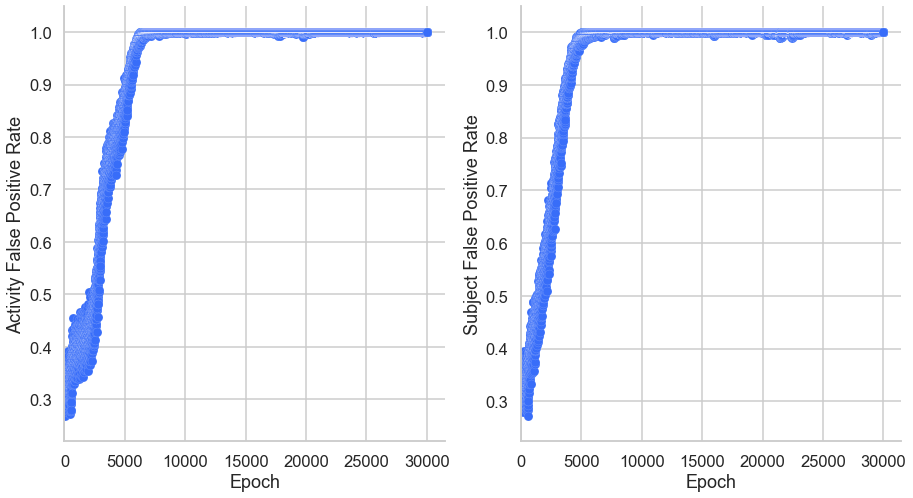

In [16]:
plot_metrics(model_output)